In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [3]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')

LIMIT = None
split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in islice(fp, LIMIT):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


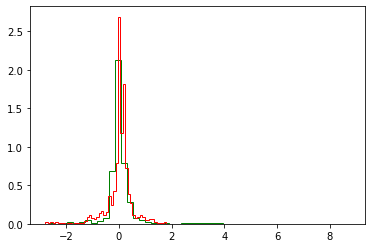

In [5]:
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()

In [6]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )

Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


In [7]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


In [9]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.keras.activations.linear(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output


W0820 12:46:24.777661  8956 deprecation.py:506] From <ipython-input-9-4effa1aabbcc>:58: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.0001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.8})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.8})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


W0820 12:47:42.689107  8956 deprecation_wrapper.py:119] From C:\Users\BALARAMI REDDY\Downloads\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\model.py:15: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 12:47:42.700306  8956 deprecation_wrapper.py:119] From C:\Users\BALARAMI REDDY\Downloads\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\model.py:5: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0820 12:47:45.215750  8956 deprecation.py:323] From C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch: 0, Step: 0, Loss: 2.81073


W0820 12:47:58.738546  8956 saver.py:1134] *******************************************************
W0820 12:47:58.740541  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 12:47:58.742535  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 12:47:58.744531  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 12:47:58.745529  8956 saver.py:1138] now on by default.
W0820 12:47:58.754504  8956 saver.py:1139] *******************************************************


Epoch: 0, Step: 10, Loss: 1.31213
Epoch: 0, Step: 20, Loss: 1.29873
Epoch: 0, Step: 30, Loss: 1.26248
Epoch: 0, Step: 40, Loss: 1.50354
Epoch: 0, Step: 50, Loss: 1.20912
Epoch: 0, Step: 60, Loss: 1.36903
Epoch: 0, Step: 70, Loss: 1.54574
Epoch: 0, Step: 80, Loss: 1.40993
Epoch: 0, Step: 90, Loss: 1.18032
Epoch: 0, Step: 100, Loss: 1.14704


W0820 12:53:12.619729  8956 saver.py:1134] *******************************************************
W0820 12:53:12.622721  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 12:53:12.623720  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 12:53:12.625713  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 12:53:12.626724  8956 saver.py:1138] now on by default.
W0820 12:53:12.631705  8956 saver.py:1139] *******************************************************


Epoch: 0, Step: 110, Loss: 1.09925
Epoch: 0, Step: 120, Loss: 1.10464
Epoch: 0, Step: 130, Loss: 1.42093
Epoch: 0, Step: 140, Loss: 1.92967
Epoch: 0, Step: 150, Loss: 1.3334
Epoch: 0, Step: 160, Loss: 1.83241
Epoch: 0, Step: 170, Loss: 1.27588
Epoch: 0, Step: 180, Loss: 1.69893
Epoch: 0, Step: 190, Loss: 1.43251
Epoch: 0, Step: 200, Loss: 1.02969


W0820 12:57:38.186964  8956 saver.py:1134] *******************************************************
W0820 12:57:38.191956  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 12:57:38.192949  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 12:57:38.193950  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 12:57:38.194944  8956 saver.py:1138] now on by default.
W0820 12:57:38.195945  8956 saver.py:1139] *******************************************************


Epoch: 0, Step: 210, Loss: 0.992244
Epoch: 0, Step: 220, Loss: 1.00784
Epoch: 0, Step: 230, Loss: 1.0788
Epoch: 0, Step: 240, Loss: 2.1241
Epoch: 0, Step: 250, Loss: 1.17078
Epoch: 0, Step: 260, Loss: 2.83394
Epoch: 0, Step: 270, Loss: 1.49641
Epoch: 0, Step: 280, Loss: 2.21509
Epoch: 0, Step: 290, Loss: 1.0424
Epoch: 0, Step: 300, Loss: 0.922465


W0820 13:01:52.147165  8956 saver.py:1134] *******************************************************
W0820 13:01:52.151155  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:01:52.152152  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:01:52.154146  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:01:52.155144  8956 saver.py:1138] now on by default.
W0820 13:01:52.156140  8956 saver.py:1139] *******************************************************


Epoch: 0, Step: 310, Loss: 1.08118
Epoch: 0, Step: 320, Loss: 2.0695
Epoch: 0, Step: 330, Loss: 1.37273
Epoch: 0, Step: 340, Loss: 1.09402
Epoch: 0, Step: 350, Loss: 0.917196
Epoch: 0, Step: 360, Loss: 0.931097
Epoch: 0, Step: 370, Loss: 1.14228
Epoch: 0, Step: 380, Loss: 1.20382
Epoch: 0, Step: 390, Loss: 2.35174
Epoch: 0, Step: 400, Loss: 1.71494


W0820 13:05:28.824217  8956 saver.py:1134] *******************************************************
W0820 13:05:28.826212  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:05:28.827209  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:05:28.828207  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:05:28.829205  8956 saver.py:1138] now on by default.
W0820 13:05:28.830202  8956 saver.py:1139] *******************************************************


Epoch: 0, Step: 410, Loss: 0.887353
Epoch: 0, Step: 420, Loss: 0.873554
Epoch: 0, Step: 430, Loss: 0.887076
Epoch: 0, Step: 440, Loss: 0.891902
Epoch: 0, Step: 450, Loss: 0.892085
Model saved in file: ./save\model.ckpt
Epoch: 1, Step: 100, Loss: 1.24496


W0820 13:07:20.857055  8956 saver.py:1134] *******************************************************
W0820 13:07:20.859050  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:07:20.860039  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:07:20.861035  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:07:20.863031  8956 saver.py:1138] now on by default.
W0820 13:07:20.864032  8956 saver.py:1139] *******************************************************


Epoch: 1, Step: 110, Loss: 1.16304
Epoch: 1, Step: 120, Loss: 0.871634
Epoch: 1, Step: 130, Loss: 0.80402
Epoch: 1, Step: 140, Loss: 0.80388
Epoch: 1, Step: 150, Loss: 0.885357
Epoch: 1, Step: 160, Loss: 1.29689
Epoch: 1, Step: 170, Loss: 2.46665
Epoch: 1, Step: 180, Loss: 1.62264
Epoch: 1, Step: 190, Loss: 0.817362
Epoch: 1, Step: 200, Loss: 0.773883


W0820 13:10:46.360423  8956 saver.py:1134] *******************************************************
W0820 13:10:46.363407  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:10:46.364405  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:10:46.365402  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:10:46.367398  8956 saver.py:1138] now on by default.
W0820 13:10:46.369393  8956 saver.py:1139] *******************************************************


Epoch: 1, Step: 210, Loss: 0.772339
Epoch: 1, Step: 220, Loss: 0.764747
Epoch: 1, Step: 230, Loss: 0.757299
Epoch: 1, Step: 240, Loss: 0.804984
Epoch: 1, Step: 250, Loss: 0.843753
Epoch: 1, Step: 260, Loss: 0.741104
Epoch: 1, Step: 270, Loss: 0.772064
Epoch: 1, Step: 280, Loss: 0.842039
Epoch: 1, Step: 290, Loss: 1.0094
Epoch: 1, Step: 300, Loss: 0.85648


W0820 13:14:14.467677  8956 saver.py:1134] *******************************************************
W0820 13:14:14.469672  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:14:14.470669  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:14:14.472664  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:14:14.473660  8956 saver.py:1138] now on by default.
W0820 13:14:14.478658  8956 saver.py:1139] *******************************************************


Epoch: 1, Step: 310, Loss: 0.707251
Epoch: 1, Step: 320, Loss: 0.701598
Epoch: 1, Step: 330, Loss: 0.697755
Epoch: 1, Step: 340, Loss: 0.693442
Epoch: 1, Step: 350, Loss: 0.690961
Epoch: 1, Step: 360, Loss: 2.58873
Epoch: 1, Step: 370, Loss: 4.78844
Epoch: 1, Step: 380, Loss: 0.692966
Epoch: 1, Step: 390, Loss: 0.682004
Epoch: 1, Step: 400, Loss: 0.673674


W0820 13:17:39.087667  8956 saver.py:1134] *******************************************************
W0820 13:17:39.090660  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:17:39.091656  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:17:39.092653  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:17:39.093652  8956 saver.py:1138] now on by default.
W0820 13:17:39.095646  8956 saver.py:1139] *******************************************************


Epoch: 1, Step: 410, Loss: 0.668542
Epoch: 1, Step: 420, Loss: 0.671525
Epoch: 1, Step: 430, Loss: 0.670308
Epoch: 1, Step: 440, Loss: 0.675255
Epoch: 1, Step: 450, Loss: 0.670424
Epoch: 1, Step: 460, Loss: 0.668302
Epoch: 1, Step: 470, Loss: 0.660149
Epoch: 1, Step: 480, Loss: 0.661779
Epoch: 1, Step: 490, Loss: 0.652674
Epoch: 1, Step: 500, Loss: 0.64804


W0820 13:21:14.250669  8956 saver.py:1134] *******************************************************
W0820 13:21:14.252660  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:21:14.257649  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:21:14.260641  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:21:14.262638  8956 saver.py:1138] now on by default.
W0820 13:21:14.264632  8956 saver.py:1139] *******************************************************


Epoch: 1, Step: 510, Loss: 0.650353
Epoch: 1, Step: 520, Loss: 0.643133
Epoch: 1, Step: 530, Loss: 0.640828
Epoch: 1, Step: 540, Loss: 0.636151
Epoch: 1, Step: 550, Loss: 0.634442
Model saved in file: ./save\model.ckpt
Epoch: 2, Step: 200, Loss: 0.635058


W0820 13:23:06.671385  8956 saver.py:1134] *******************************************************
W0820 13:23:06.675377  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:23:06.678368  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:23:06.680362  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:23:06.683354  8956 saver.py:1138] now on by default.
W0820 13:23:06.685349  8956 saver.py:1139] *******************************************************


Epoch: 2, Step: 210, Loss: 0.627392
Epoch: 2, Step: 220, Loss: 0.62768
Epoch: 2, Step: 230, Loss: 0.630217
Epoch: 2, Step: 240, Loss: 0.620329
Epoch: 2, Step: 250, Loss: 0.623822
Epoch: 2, Step: 260, Loss: 0.620761
Epoch: 2, Step: 270, Loss: 0.618979
Epoch: 2, Step: 280, Loss: 0.616156
Epoch: 2, Step: 290, Loss: 0.615324
Epoch: 2, Step: 300, Loss: 0.670907


W0820 13:26:36.248193  8956 saver.py:1134] *******************************************************
W0820 13:26:36.251184  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:26:36.252183  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:26:36.254177  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:26:36.258167  8956 saver.py:1138] now on by default.
W0820 13:26:36.260162  8956 saver.py:1139] *******************************************************


Epoch: 2, Step: 310, Loss: 0.62248
Epoch: 2, Step: 320, Loss: 4.90393
Epoch: 2, Step: 330, Loss: 2.28868
Epoch: 2, Step: 340, Loss: 0.603085
Epoch: 2, Step: 350, Loss: 0.600073
Epoch: 2, Step: 360, Loss: 0.609
Epoch: 2, Step: 370, Loss: 0.621147
Epoch: 2, Step: 380, Loss: 0.589995
Epoch: 2, Step: 390, Loss: 0.705266
Epoch: 2, Step: 400, Loss: 0.721264


W0820 13:29:59.386490  8956 saver.py:1134] *******************************************************
W0820 13:29:59.389482  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:29:59.390480  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:29:59.391478  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:29:59.393473  8956 saver.py:1138] now on by default.
W0820 13:29:59.398471  8956 saver.py:1139] *******************************************************


Epoch: 2, Step: 410, Loss: 0.578115
Epoch: 2, Step: 420, Loss: 0.634822
Epoch: 2, Step: 430, Loss: 0.585039
Epoch: 2, Step: 440, Loss: 0.593171
Epoch: 2, Step: 450, Loss: 0.578828
Epoch: 2, Step: 460, Loss: 0.641068
Epoch: 2, Step: 470, Loss: 0.600343
Epoch: 2, Step: 480, Loss: 0.734219
Epoch: 2, Step: 490, Loss: 0.704058
Epoch: 2, Step: 500, Loss: 0.568108


W0820 13:33:23.552782  8956 saver.py:1134] *******************************************************
W0820 13:33:23.556744  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:33:23.557743  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:33:23.559743  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:33:23.561732  8956 saver.py:1138] now on by default.
W0820 13:33:23.562730  8956 saver.py:1139] *******************************************************


Epoch: 2, Step: 510, Loss: 0.558351
Epoch: 2, Step: 520, Loss: 0.561749
Epoch: 2, Step: 530, Loss: 0.554378
Epoch: 2, Step: 540, Loss: 0.552955
Epoch: 2, Step: 550, Loss: 0.551102
Epoch: 2, Step: 560, Loss: 0.549753
Epoch: 2, Step: 570, Loss: 0.546298
Epoch: 2, Step: 580, Loss: 0.550014
Epoch: 2, Step: 590, Loss: 0.545544
Epoch: 2, Step: 600, Loss: 0.545085


W0820 13:36:51.325849  8956 saver.py:1134] *******************************************************
W0820 13:36:51.327844  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:36:51.328850  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:36:51.329842  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:36:51.331835  8956 saver.py:1138] now on by default.
W0820 13:36:51.333829  8956 saver.py:1139] *******************************************************


Epoch: 2, Step: 610, Loss: 0.550731
Epoch: 2, Step: 620, Loss: 0.557402
Epoch: 2, Step: 630, Loss: 0.561503
Epoch: 2, Step: 640, Loss: 0.93708
Epoch: 2, Step: 650, Loss: 0.561132
Model saved in file: ./save\model.ckpt
Epoch: 3, Step: 300, Loss: 0.563144


W0820 13:38:41.924465  8956 saver.py:1134] *******************************************************
W0820 13:38:41.929454  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:38:41.930451  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:38:41.931448  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:38:41.933445  8956 saver.py:1138] now on by default.
W0820 13:38:41.935439  8956 saver.py:1139] *******************************************************


Epoch: 3, Step: 310, Loss: 0.583997
Epoch: 3, Step: 320, Loss: 0.818653
Epoch: 3, Step: 330, Loss: 0.586887
Epoch: 3, Step: 340, Loss: 0.633278
Epoch: 3, Step: 350, Loss: 0.884406
Epoch: 3, Step: 360, Loss: 0.869007
Epoch: 3, Step: 370, Loss: 0.54087
Epoch: 3, Step: 380, Loss: 0.594661
Epoch: 3, Step: 390, Loss: 0.523927
Epoch: 3, Step: 400, Loss: 0.5433


W0820 13:42:02.525444  8956 saver.py:1134] *******************************************************
W0820 13:42:02.527439  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:42:02.528436  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:42:02.529434  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:42:02.531430  8956 saver.py:1138] now on by default.
W0820 13:42:02.533425  8956 saver.py:1139] *******************************************************


Epoch: 3, Step: 410, Loss: 0.615509
Epoch: 3, Step: 420, Loss: 1.5132
Epoch: 3, Step: 430, Loss: 0.665641
Epoch: 3, Step: 440, Loss: 1.29914
Epoch: 3, Step: 450, Loss: 0.980156
Epoch: 3, Step: 460, Loss: 1.01638
Epoch: 3, Step: 470, Loss: 1.00223
Epoch: 3, Step: 480, Loss: 0.545594
Epoch: 3, Step: 490, Loss: 0.515665
Epoch: 3, Step: 500, Loss: 0.528169


W0820 13:45:25.176735  8956 saver.py:1134] *******************************************************
W0820 13:45:25.179729  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:45:25.184716  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:45:25.186712  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:45:25.189702  8956 saver.py:1138] now on by default.
W0820 13:45:25.191698  8956 saver.py:1139] *******************************************************


Epoch: 3, Step: 510, Loss: 0.632654
Epoch: 3, Step: 520, Loss: 1.39428
Epoch: 3, Step: 530, Loss: 0.879529
Epoch: 3, Step: 540, Loss: 2.22081
Epoch: 3, Step: 550, Loss: 1.14427
Epoch: 3, Step: 560, Loss: 1.77137
Epoch: 3, Step: 570, Loss: 0.770823
Epoch: 3, Step: 580, Loss: 0.508872
Epoch: 3, Step: 590, Loss: 0.579144
Epoch: 3, Step: 600, Loss: 1.55233


W0820 13:48:50.864942  8956 saver.py:1134] *******************************************************
W0820 13:48:50.869945  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:48:50.870927  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:48:50.871925  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:48:50.873920  8956 saver.py:1138] now on by default.
W0820 13:48:50.875916  8956 saver.py:1139] *******************************************************


Epoch: 3, Step: 610, Loss: 1.23883
Epoch: 3, Step: 620, Loss: 0.635462
Epoch: 3, Step: 630, Loss: 0.577555
Epoch: 3, Step: 640, Loss: 0.532019
Epoch: 3, Step: 650, Loss: 0.834291
Epoch: 3, Step: 660, Loss: 0.694957
Epoch: 3, Step: 670, Loss: 1.65186
Epoch: 3, Step: 680, Loss: 1.4737
Epoch: 3, Step: 690, Loss: 0.662323
Epoch: 3, Step: 700, Loss: 0.508173


W0820 13:52:11.769720  8956 saver.py:1134] *******************************************************
W0820 13:52:11.772715  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:52:11.773713  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:52:11.774708  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:52:11.776706  8956 saver.py:1138] now on by default.
W0820 13:52:11.783685  8956 saver.py:1139] *******************************************************


Epoch: 3, Step: 710, Loss: 0.523404
Epoch: 3, Step: 720, Loss: 0.539001
Epoch: 3, Step: 730, Loss: 0.541896
Epoch: 3, Step: 740, Loss: 0.896936
Epoch: 3, Step: 750, Loss: 0.954447
Model saved in file: ./save\model.ckpt
Epoch: 4, Step: 400, Loss: 0.607481


W0820 13:54:02.939906  8956 saver.py:1134] *******************************************************
W0820 13:54:02.941899  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:54:02.942898  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:54:02.943894  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:54:02.945889  8956 saver.py:1138] now on by default.
W0820 13:54:02.946887  8956 saver.py:1139] *******************************************************


Epoch: 4, Step: 410, Loss: 0.4995
Epoch: 4, Step: 420, Loss: 0.499787
Epoch: 4, Step: 430, Loss: 0.530706
Epoch: 4, Step: 440, Loss: 0.744156
Epoch: 4, Step: 450, Loss: 1.89573
Epoch: 4, Step: 460, Loss: 1.58759
Epoch: 4, Step: 470, Loss: 0.523465
Epoch: 4, Step: 480, Loss: 0.53065
Epoch: 4, Step: 490, Loss: 0.485362
Epoch: 4, Step: 500, Loss: 0.491248


W0820 13:57:26.689388  8956 saver.py:1134] *******************************************************
W0820 13:57:26.694376  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 13:57:26.695373  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 13:57:26.697367  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 13:57:26.699361  8956 saver.py:1138] now on by default.
W0820 13:57:26.701358  8956 saver.py:1139] *******************************************************


Epoch: 4, Step: 510, Loss: 0.490232
Epoch: 4, Step: 520, Loss: 0.523272
Epoch: 4, Step: 530, Loss: 0.577749
Epoch: 4, Step: 540, Loss: 0.493282
Epoch: 4, Step: 550, Loss: 0.501064
Epoch: 4, Step: 560, Loss: 0.581647
Epoch: 4, Step: 570, Loss: 0.820579
Epoch: 4, Step: 580, Loss: 0.640258
Epoch: 4, Step: 590, Loss: 0.480427
Epoch: 4, Step: 600, Loss: 0.473171


W0820 14:00:50.701846  8956 saver.py:1134] *******************************************************
W0820 14:00:50.703843  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:00:50.704839  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:00:50.705837  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:00:50.707833  8956 saver.py:1138] now on by default.
W0820 14:00:50.709828  8956 saver.py:1139] *******************************************************


Epoch: 4, Step: 610, Loss: 0.473753
Epoch: 4, Step: 620, Loss: 0.472997
Epoch: 4, Step: 630, Loss: 0.471313
Epoch: 4, Step: 640, Loss: 1.02631
Epoch: 4, Step: 650, Loss: 5.58647
Epoch: 4, Step: 660, Loss: 0.516426
Epoch: 4, Step: 670, Loss: 0.472883
Epoch: 4, Step: 680, Loss: 0.468335
Epoch: 4, Step: 690, Loss: 0.468634
Epoch: 4, Step: 700, Loss: 0.47176


W0820 14:04:15.834711  8956 saver.py:1134] *******************************************************
W0820 14:04:15.839700  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:04:15.841694  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:04:15.842691  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:04:15.843691  8956 saver.py:1138] now on by default.
W0820 14:04:15.846682  8956 saver.py:1139] *******************************************************


Epoch: 4, Step: 710, Loss: 0.468486
Epoch: 4, Step: 720, Loss: 0.479031
Epoch: 4, Step: 730, Loss: 0.475054
Epoch: 4, Step: 740, Loss: 0.474321
Epoch: 4, Step: 750, Loss: 0.471011
Epoch: 4, Step: 760, Loss: 0.472058
Epoch: 4, Step: 770, Loss: 0.482091
Epoch: 4, Step: 780, Loss: 0.48194
Epoch: 4, Step: 790, Loss: 0.473605
Epoch: 4, Step: 800, Loss: 0.465482


W0820 14:07:40.985174  8956 saver.py:1134] *******************************************************
W0820 14:07:40.987170  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:07:40.988167  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:07:40.990162  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:07:40.994172  8956 saver.py:1138] now on by default.
W0820 14:07:40.998142  8956 saver.py:1139] *******************************************************


Epoch: 4, Step: 810, Loss: 0.463814
Epoch: 4, Step: 820, Loss: 0.465894
Epoch: 4, Step: 830, Loss: 0.468755
Epoch: 4, Step: 840, Loss: 0.466905
Epoch: 4, Step: 850, Loss: 0.467819
Model saved in file: ./save\model.ckpt
Epoch: 5, Step: 500, Loss: 0.466473


W0820 14:09:33.513851  8956 saver.py:1134] *******************************************************
W0820 14:09:33.515847  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:09:33.516843  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:09:33.517838  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:09:33.520832  8956 saver.py:1138] now on by default.
W0820 14:09:33.522829  8956 saver.py:1139] *******************************************************


Epoch: 5, Step: 510, Loss: 0.469326
Epoch: 5, Step: 520, Loss: 0.466252
Epoch: 5, Step: 530, Loss: 0.46748
Epoch: 5, Step: 540, Loss: 0.466406
Epoch: 5, Step: 550, Loss: 0.466697
Epoch: 5, Step: 560, Loss: 0.463381
Epoch: 5, Step: 570, Loss: 0.464474
Epoch: 5, Step: 580, Loss: 0.480645
Epoch: 5, Step: 590, Loss: 0.517238
Epoch: 5, Step: 600, Loss: 3.36628


W0820 14:12:56.113408  8956 saver.py:1134] *******************************************************
W0820 14:12:56.115403  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:12:56.116400  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:12:56.117401  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:12:56.121388  8956 saver.py:1138] now on by default.
W0820 14:12:56.125389  8956 saver.py:1139] *******************************************************


Epoch: 5, Step: 610, Loss: 3.31482
Epoch: 5, Step: 620, Loss: 0.459384
Epoch: 5, Step: 630, Loss: 0.456477
Epoch: 5, Step: 640, Loss: 0.497235
Epoch: 5, Step: 650, Loss: 0.495541
Epoch: 5, Step: 660, Loss: 0.485283
Epoch: 5, Step: 670, Loss: 0.521084
Epoch: 5, Step: 680, Loss: 0.587248
Epoch: 5, Step: 690, Loss: 0.453684
Epoch: 5, Step: 700, Loss: 0.48415


W0820 14:16:20.570156  8956 saver.py:1134] *******************************************************
W0820 14:16:20.572151  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:16:20.573148  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:16:20.575143  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:16:20.579132  8956 saver.py:1138] now on by default.
W0820 14:16:20.581127  8956 saver.py:1139] *******************************************************


Epoch: 5, Step: 710, Loss: 0.475591
Epoch: 5, Step: 720, Loss: 0.466339
Epoch: 5, Step: 730, Loss: 0.458063
Epoch: 5, Step: 740, Loss: 0.517714
Epoch: 5, Step: 750, Loss: 0.507424
Epoch: 5, Step: 760, Loss: 0.548707
Epoch: 5, Step: 770, Loss: 0.567055
Epoch: 5, Step: 780, Loss: 0.457529
Epoch: 5, Step: 790, Loss: 0.454335
Epoch: 5, Step: 800, Loss: 0.448782


W0820 14:19:45.801296  8956 saver.py:1134] *******************************************************
W0820 14:19:45.803290  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:19:45.805283  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:19:45.806284  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:19:45.808276  8956 saver.py:1138] now on by default.
W0820 14:19:45.809274  8956 saver.py:1139] *******************************************************


Epoch: 5, Step: 810, Loss: 0.447116
Epoch: 5, Step: 820, Loss: 0.446422
Epoch: 5, Step: 830, Loss: 0.446416
Epoch: 5, Step: 840, Loss: 0.446321
Epoch: 5, Step: 850, Loss: 0.445434
Epoch: 5, Step: 860, Loss: 0.453638
Epoch: 5, Step: 870, Loss: 0.450607
Epoch: 5, Step: 880, Loss: 0.450131
Epoch: 5, Step: 890, Loss: 0.450145
Epoch: 5, Step: 900, Loss: 0.458549


W0820 14:23:09.525161  8956 saver.py:1134] *******************************************************
W0820 14:23:09.527155  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:23:09.528153  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:23:09.530149  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:23:09.531147  8956 saver.py:1138] now on by default.
W0820 14:23:09.534138  8956 saver.py:1139] *******************************************************


Epoch: 5, Step: 910, Loss: 0.487157
Epoch: 5, Step: 920, Loss: 0.763882
Epoch: 5, Step: 930, Loss: 0.499973
Epoch: 5, Step: 940, Loss: 0.470772
Epoch: 5, Step: 950, Loss: 0.521035
Model saved in file: ./save\model.ckpt
Epoch: 6, Step: 600, Loss: 0.704138


W0820 14:25:00.738813  8956 saver.py:1134] *******************************************************
W0820 14:25:00.743813  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:25:00.746796  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:25:00.749786  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:25:00.752778  8956 saver.py:1138] now on by default.
W0820 14:25:00.755770  8956 saver.py:1139] *******************************************************


Epoch: 6, Step: 610, Loss: 0.593289
Epoch: 6, Step: 620, Loss: 0.471339
Epoch: 6, Step: 630, Loss: 0.715025
Epoch: 6, Step: 640, Loss: 0.785061
Epoch: 6, Step: 650, Loss: 0.460533
Epoch: 6, Step: 660, Loss: 0.503748
Epoch: 6, Step: 670, Loss: 0.440446
Epoch: 6, Step: 680, Loss: 0.465661
Epoch: 6, Step: 690, Loss: 0.451628
Epoch: 6, Step: 700, Loss: 1.22755


W0820 14:28:25.929147  8956 saver.py:1134] *******************************************************
W0820 14:28:25.935128  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:28:25.936126  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:28:25.937125  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:28:25.940117  8956 saver.py:1138] now on by default.
W0820 14:28:25.942112  8956 saver.py:1139] *******************************************************


Epoch: 6, Step: 710, Loss: 0.619032
Epoch: 6, Step: 720, Loss: 1.17836
Epoch: 6, Step: 730, Loss: 1.08918
Epoch: 6, Step: 740, Loss: 0.683575
Epoch: 6, Step: 750, Loss: 0.957426
Epoch: 6, Step: 760, Loss: 0.514481
Epoch: 6, Step: 770, Loss: 0.43888
Epoch: 6, Step: 780, Loss: 0.44426
Epoch: 6, Step: 790, Loss: 0.550059
Epoch: 6, Step: 800, Loss: 0.92186


W0820 14:31:53.389381  8956 saver.py:1134] *******************************************************
W0820 14:31:53.392374  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:31:53.393380  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:31:53.395367  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:31:53.402349  8956 saver.py:1138] now on by default.
W0820 14:31:53.405341  8956 saver.py:1139] *******************************************************


Epoch: 6, Step: 810, Loss: 1.1671
Epoch: 6, Step: 820, Loss: 1.64161
Epoch: 6, Step: 830, Loss: 1.525
Epoch: 6, Step: 840, Loss: 1.49575
Epoch: 6, Step: 850, Loss: 0.897287
Epoch: 6, Step: 860, Loss: 0.435787
Epoch: 6, Step: 870, Loss: 0.457712
Epoch: 6, Step: 880, Loss: 1.26989
Epoch: 6, Step: 890, Loss: 1.54962
Epoch: 6, Step: 900, Loss: 0.497029


W0820 14:35:20.295232  8956 saver.py:1134] *******************************************************
W0820 14:35:20.298226  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:35:20.303230  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:35:20.306204  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:35:20.309196  8956 saver.py:1138] now on by default.
W0820 14:35:20.312187  8956 saver.py:1139] *******************************************************


Epoch: 6, Step: 910, Loss: 0.528708
Epoch: 6, Step: 920, Loss: 0.436379
Epoch: 6, Step: 930, Loss: 0.697509
Epoch: 6, Step: 940, Loss: 0.631778
Epoch: 6, Step: 950, Loss: 1.31149
Epoch: 6, Step: 960, Loss: 1.56864
Epoch: 6, Step: 970, Loss: 0.717039
Epoch: 6, Step: 980, Loss: 0.435858
Epoch: 6, Step: 990, Loss: 0.446284
Epoch: 6, Step: 1000, Loss: 0.452197


W0820 14:38:50.308006  8956 saver.py:1134] *******************************************************
W0820 14:38:50.310999  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:38:50.316984  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:38:50.319975  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:38:50.323965  8956 saver.py:1138] now on by default.
W0820 14:38:50.327954  8956 saver.py:1139] *******************************************************


Epoch: 6, Step: 1010, Loss: 0.471752
Epoch: 6, Step: 1020, Loss: 0.751093
Epoch: 6, Step: 1030, Loss: 0.950265
Epoch: 6, Step: 1040, Loss: 0.626349
Epoch: 6, Step: 1050, Loss: 0.472624
Model saved in file: ./save\model.ckpt
Epoch: 7, Step: 700, Loss: 0.4555


W0820 14:41:18.822146  8956 saver.py:1134] *******************************************************
W0820 14:41:18.832120  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:41:18.837108  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:41:18.846087  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:41:18.849076  8956 saver.py:1138] now on by default.
W0820 14:41:18.852068  8956 saver.py:1139] *******************************************************


Epoch: 7, Step: 710, Loss: 0.439405
Epoch: 7, Step: 720, Loss: 0.578002
Epoch: 7, Step: 730, Loss: 1.54036
Epoch: 7, Step: 740, Loss: 1.83873
Epoch: 7, Step: 750, Loss: 0.511459
Epoch: 7, Step: 760, Loss: 0.495401
Epoch: 7, Step: 770, Loss: 0.422377
Epoch: 7, Step: 780, Loss: 0.437475
Epoch: 7, Step: 790, Loss: 0.432531
Epoch: 7, Step: 800, Loss: 0.441371


W0820 14:44:57.966809  8956 saver.py:1134] *******************************************************
W0820 14:44:57.968804  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:44:57.970800  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:44:57.971797  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:44:57.973794  8956 saver.py:1138] now on by default.
W0820 14:44:57.979776  8956 saver.py:1139] *******************************************************


Epoch: 7, Step: 810, Loss: 0.470732
Epoch: 7, Step: 820, Loss: 0.4543
Epoch: 7, Step: 830, Loss: 0.427315
Epoch: 7, Step: 840, Loss: 0.506711
Epoch: 7, Step: 850, Loss: 0.819105
Epoch: 7, Step: 860, Loss: 0.573935
Epoch: 7, Step: 870, Loss: 0.558229
Epoch: 7, Step: 880, Loss: 0.429354
Epoch: 7, Step: 890, Loss: 0.422377
Epoch: 7, Step: 900, Loss: 0.420044


W0820 14:48:26.630733  8956 saver.py:1134] *******************************************************
W0820 14:48:26.633727  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:48:26.634724  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:48:26.636720  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:48:26.637717  8956 saver.py:1138] now on by default.
W0820 14:48:26.645696  8956 saver.py:1139] *******************************************************


Epoch: 7, Step: 910, Loss: 0.419029
Epoch: 7, Step: 920, Loss: 0.472672
Epoch: 7, Step: 930, Loss: 5.78066
Epoch: 7, Step: 940, Loss: 0.618252
Epoch: 7, Step: 950, Loss: 0.421485
Epoch: 7, Step: 960, Loss: 0.414525
Epoch: 7, Step: 970, Loss: 0.41674
Epoch: 7, Step: 980, Loss: 0.420685
Epoch: 7, Step: 990, Loss: 0.414406
Epoch: 7, Step: 1000, Loss: 0.425186


W0820 14:51:56.296366  8956 saver.py:1134] *******************************************************
W0820 14:51:56.299357  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:51:56.301352  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:51:56.304345  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:51:56.310328  8956 saver.py:1138] now on by default.
W0820 14:51:56.313320  8956 saver.py:1139] *******************************************************


Epoch: 7, Step: 1010, Loss: 0.418158
Epoch: 7, Step: 1020, Loss: 0.417041
Epoch: 7, Step: 1030, Loss: 0.426231
Epoch: 7, Step: 1040, Loss: 0.433541
Epoch: 7, Step: 1050, Loss: 0.417264
Epoch: 7, Step: 1060, Loss: 0.4264
Epoch: 7, Step: 1070, Loss: 0.421797
Epoch: 7, Step: 1080, Loss: 0.419193
Epoch: 7, Step: 1090, Loss: 0.413147
Epoch: 7, Step: 1100, Loss: 0.419063


W0820 14:55:25.482593  8956 saver.py:1134] *******************************************************
W0820 14:55:25.485585  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:55:25.491570  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:55:25.495558  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:55:25.497554  8956 saver.py:1138] now on by default.
W0820 14:55:25.500547  8956 saver.py:1139] *******************************************************


Epoch: 7, Step: 1110, Loss: 0.414953
Epoch: 7, Step: 1120, Loss: 0.412381
Epoch: 7, Step: 1130, Loss: 0.415836
Epoch: 7, Step: 1140, Loss: 0.41224
Epoch: 7, Step: 1150, Loss: 0.418207
Model saved in file: ./save\model.ckpt
Epoch: 8, Step: 800, Loss: 0.416716


W0820 14:57:17.376613  8956 saver.py:1134] *******************************************************
W0820 14:57:17.378602  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 14:57:17.380593  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 14:57:17.381594  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 14:57:17.383587  8956 saver.py:1138] now on by default.
W0820 14:57:17.384584  8956 saver.py:1139] *******************************************************


Epoch: 8, Step: 810, Loss: 0.413915
Epoch: 8, Step: 820, Loss: 0.410758
Epoch: 8, Step: 830, Loss: 0.409722
Epoch: 8, Step: 840, Loss: 0.40751
Epoch: 8, Step: 850, Loss: 0.408319
Epoch: 8, Step: 860, Loss: 0.416491
Epoch: 8, Step: 870, Loss: 0.473459
Epoch: 8, Step: 880, Loss: 1.92425
Epoch: 8, Step: 890, Loss: 4.62509
Epoch: 8, Step: 900, Loss: 0.417994


W0820 15:00:44.643902  8956 saver.py:1134] *******************************************************
W0820 15:00:44.646884  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:00:44.647880  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:00:44.649877  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:00:44.651871  8956 saver.py:1138] now on by default.
W0820 15:00:44.653867  8956 saver.py:1139] *******************************************************


Epoch: 8, Step: 910, Loss: 0.406191
Epoch: 8, Step: 920, Loss: 0.437898
Epoch: 8, Step: 930, Loss: 0.440661
Epoch: 8, Step: 940, Loss: 0.443681
Epoch: 8, Step: 950, Loss: 0.422725
Epoch: 8, Step: 960, Loss: 0.495268
Epoch: 8, Step: 970, Loss: 0.410177
Epoch: 8, Step: 980, Loss: 0.406913
Epoch: 8, Step: 990, Loss: 0.439899
Epoch: 8, Step: 1000, Loss: 0.407613


W0820 15:04:14.396845  8956 saver.py:1134] *******************************************************
W0820 15:04:14.399838  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:04:14.400841  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:04:14.402831  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:04:14.404826  8956 saver.py:1138] now on by default.
W0820 15:04:14.410810  8956 saver.py:1139] *******************************************************


Epoch: 8, Step: 1010, Loss: 0.422566
Epoch: 8, Step: 1020, Loss: 0.448956
Epoch: 8, Step: 1030, Loss: 0.456851
Epoch: 8, Step: 1040, Loss: 0.503583
Epoch: 8, Step: 1050, Loss: 0.517091
Epoch: 8, Step: 1060, Loss: 0.422007
Epoch: 8, Step: 1070, Loss: 0.416109
Epoch: 8, Step: 1080, Loss: 0.403158
Epoch: 8, Step: 1090, Loss: 0.399912
Epoch: 8, Step: 1100, Loss: 0.403764


W0820 15:07:43.920453  8956 saver.py:1134] *******************************************************
W0820 15:07:43.925441  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:07:43.927435  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:07:43.928433  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:07:43.930428  8956 saver.py:1138] now on by default.
W0820 15:07:43.936418  8956 saver.py:1139] *******************************************************


Epoch: 8, Step: 1110, Loss: 0.403183
Epoch: 8, Step: 1120, Loss: 0.400154
Epoch: 8, Step: 1130, Loss: 0.400646
Epoch: 8, Step: 1140, Loss: 0.414466
Epoch: 8, Step: 1150, Loss: 0.415584
Epoch: 8, Step: 1160, Loss: 0.420716
Epoch: 8, Step: 1170, Loss: 0.401003
Epoch: 8, Step: 1180, Loss: 0.40619
Epoch: 8, Step: 1190, Loss: 0.451252
Epoch: 8, Step: 1200, Loss: 0.607201


W0820 15:11:11.220116  8956 saver.py:1134] *******************************************************
W0820 15:11:11.225116  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:11:11.227099  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:11:11.228098  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:11:11.230091  8956 saver.py:1138] now on by default.
W0820 15:11:11.232086  8956 saver.py:1139] *******************************************************


Epoch: 8, Step: 1210, Loss: 0.551102
Epoch: 8, Step: 1220, Loss: 0.415699
Epoch: 8, Step: 1230, Loss: 0.476172
Epoch: 8, Step: 1240, Loss: 0.591576
Epoch: 8, Step: 1250, Loss: 0.655156
Model saved in file: ./save\model.ckpt
Epoch: 9, Step: 900, Loss: 0.399868


W0820 15:13:04.631453  8956 saver.py:1134] *******************************************************
W0820 15:13:04.634446  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:13:04.635446  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:13:04.637442  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:13:04.643438  8956 saver.py:1138] now on by default.
W0820 15:13:04.645418  8956 saver.py:1139] *******************************************************


Epoch: 9, Step: 910, Loss: 0.514261
Epoch: 9, Step: 920, Loss: 0.624599
Epoch: 9, Step: 930, Loss: 0.413767
Epoch: 9, Step: 940, Loss: 0.452194
Epoch: 9, Step: 950, Loss: 0.394226
Epoch: 9, Step: 960, Loss: 0.40623
Epoch: 9, Step: 970, Loss: 0.404017
Epoch: 9, Step: 980, Loss: 1.12535
Epoch: 9, Step: 990, Loss: 0.707602
Epoch: 9, Step: 1000, Loss: 0.979446


W0820 15:16:35.192779  8956 saver.py:1134] *******************************************************
W0820 15:16:35.194774  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:16:35.196769  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:16:35.197765  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:16:35.199762  8956 saver.py:1138] now on by default.
W0820 15:16:35.201757  8956 saver.py:1139] *******************************************************


Epoch: 9, Step: 1010, Loss: 1.15572
Epoch: 9, Step: 1020, Loss: 0.542571
Epoch: 9, Step: 1030, Loss: 1.07974
Epoch: 9, Step: 1040, Loss: 0.552907
Epoch: 9, Step: 1050, Loss: 0.391711
Epoch: 9, Step: 1060, Loss: 0.401003
Epoch: 9, Step: 1070, Loss: 0.516637
Epoch: 9, Step: 1080, Loss: 0.630592
Epoch: 9, Step: 1090, Loss: 1.3323
Epoch: 9, Step: 1100, Loss: 1.11458


W0820 15:20:01.840510  8956 saver.py:1134] *******************************************************
W0820 15:20:01.844486  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:20:01.847480  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:20:01.850471  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:20:01.853463  8956 saver.py:1138] now on by default.
W0820 15:20:01.858466  8956 saver.py:1139] *******************************************************


Epoch: 9, Step: 1110, Loss: 2.17191
Epoch: 9, Step: 1120, Loss: 1.08554
Epoch: 9, Step: 1130, Loss: 1.03942
Epoch: 9, Step: 1140, Loss: 0.390743
Epoch: 9, Step: 1150, Loss: 0.389815
Epoch: 9, Step: 1160, Loss: 1.02549
Epoch: 9, Step: 1170, Loss: 1.72257
Epoch: 9, Step: 1180, Loss: 0.452475
Epoch: 9, Step: 1190, Loss: 0.520763
Epoch: 9, Step: 1200, Loss: 0.383726


W0820 15:23:34.862404  8956 saver.py:1134] *******************************************************
W0820 15:23:34.867403  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:23:34.869386  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:23:34.870383  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:23:34.873377  8956 saver.py:1138] now on by default.
W0820 15:23:34.876368  8956 saver.py:1139] *******************************************************


Epoch: 9, Step: 1210, Loss: 0.549781
Epoch: 9, Step: 1220, Loss: 0.70807
Epoch: 9, Step: 1230, Loss: 0.821735
Epoch: 9, Step: 1240, Loss: 1.50571
Epoch: 9, Step: 1250, Loss: 0.656715
Epoch: 9, Step: 1260, Loss: 0.389638
Epoch: 9, Step: 1270, Loss: 0.388491
Epoch: 9, Step: 1280, Loss: 0.394129
Epoch: 9, Step: 1290, Loss: 0.433589
Epoch: 9, Step: 1300, Loss: 0.641311


W0820 15:27:06.489089  8956 saver.py:1134] *******************************************************
W0820 15:27:06.495083  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:27:06.498069  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:27:06.502058  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:27:06.505051  8956 saver.py:1138] now on by default.
W0820 15:27:06.507044  8956 saver.py:1139] *******************************************************


Epoch: 9, Step: 1310, Loss: 0.916754
Epoch: 9, Step: 1320, Loss: 0.604415
Epoch: 9, Step: 1330, Loss: 0.445667
Epoch: 9, Step: 1340, Loss: 0.403831
Epoch: 9, Step: 1350, Loss: 0.396304
Model saved in file: ./save\model.ckpt
Epoch: 10, Step: 1000, Loss: 0.504871


W0820 15:29:00.212457  8956 saver.py:1134] *******************************************************
W0820 15:29:00.215448  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:29:00.216445  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:29:00.218440  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:29:00.222431  8956 saver.py:1138] now on by default.
W0820 15:29:00.226421  8956 saver.py:1139] *******************************************************


Epoch: 10, Step: 1010, Loss: 1.21331
Epoch: 10, Step: 1020, Loss: 1.80477
Epoch: 10, Step: 1030, Loss: 0.576688
Epoch: 10, Step: 1040, Loss: 0.471009
Epoch: 10, Step: 1050, Loss: 0.375885
Epoch: 10, Step: 1060, Loss: 0.383353
Epoch: 10, Step: 1070, Loss: 0.377499
Epoch: 10, Step: 1080, Loss: 0.385479
Epoch: 10, Step: 1090, Loss: 0.409165
Epoch: 10, Step: 1100, Loss: 0.423777


W0820 15:32:28.940281  8956 saver.py:1134] *******************************************************
W0820 15:32:28.945273  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:32:28.947264  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:32:28.949258  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:32:28.952252  8956 saver.py:1138] now on by default.
W0820 15:32:28.953249  8956 saver.py:1139] *******************************************************


Epoch: 10, Step: 1110, Loss: 0.383357
Epoch: 10, Step: 1120, Loss: 0.472608
Epoch: 10, Step: 1130, Loss: 0.753001
Epoch: 10, Step: 1140, Loss: 0.457303
Epoch: 10, Step: 1150, Loss: 0.546381
Epoch: 10, Step: 1160, Loss: 0.379193
Epoch: 10, Step: 1170, Loss: 0.382842
Epoch: 10, Step: 1180, Loss: 0.393221
Epoch: 10, Step: 1190, Loss: 0.381672
Epoch: 10, Step: 1200, Loss: 0.388826


W0820 15:36:00.067619  8956 saver.py:1134] *******************************************************
W0820 15:36:00.071609  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:36:00.076596  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:36:00.079590  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:36:00.082582  8956 saver.py:1138] now on by default.
W0820 15:36:00.085574  8956 saver.py:1139] *******************************************************


Epoch: 10, Step: 1210, Loss: 4.88391
Epoch: 10, Step: 1220, Loss: 1.28574
Epoch: 10, Step: 1230, Loss: 0.384955
Epoch: 10, Step: 1240, Loss: 0.452612
Epoch: 10, Step: 1250, Loss: 0.426861
Epoch: 10, Step: 1260, Loss: 0.376136
Epoch: 10, Step: 1270, Loss: 0.378381
Epoch: 10, Step: 1280, Loss: 0.404041
Epoch: 10, Step: 1290, Loss: 0.373811
Epoch: 10, Step: 1300, Loss: 0.382921


W0820 15:39:33.917621  8956 saver.py:1134] *******************************************************
W0820 15:39:33.920613  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:39:33.921612  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:39:33.922608  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:39:33.924604  8956 saver.py:1138] now on by default.
W0820 15:39:33.926610  8956 saver.py:1139] *******************************************************


Epoch: 10, Step: 1310, Loss: 0.386922
Epoch: 10, Step: 1320, Loss: 0.393197
Epoch: 10, Step: 1330, Loss: 0.373572
Epoch: 10, Step: 1340, Loss: 0.38942
Epoch: 10, Step: 1350, Loss: 0.378929
Epoch: 10, Step: 1360, Loss: 0.373307
Epoch: 10, Step: 1370, Loss: 0.367547
Epoch: 10, Step: 1380, Loss: 0.3727
Epoch: 10, Step: 1390, Loss: 0.374446
Epoch: 10, Step: 1400, Loss: 0.36602


W0820 15:43:02.521728  8956 saver.py:1134] *******************************************************
W0820 15:43:02.523724  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:43:02.524721  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:43:02.526718  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:43:02.532702  8956 saver.py:1138] now on by default.
W0820 15:43:02.534696  8956 saver.py:1139] *******************************************************


Epoch: 10, Step: 1410, Loss: 0.365959
Epoch: 10, Step: 1420, Loss: 0.364181
Epoch: 10, Step: 1430, Loss: 0.36641
Epoch: 10, Step: 1440, Loss: 0.36872
Epoch: 10, Step: 1450, Loss: 0.365943
Model saved in file: ./save\model.ckpt
Epoch: 11, Step: 1100, Loss: 0.365944


W0820 15:44:58.174865  8956 saver.py:1134] *******************************************************
W0820 15:44:58.179854  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:44:58.181847  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:44:58.182845  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:44:58.184840  8956 saver.py:1138] now on by default.
W0820 15:44:58.185837  8956 saver.py:1139] *******************************************************


Epoch: 11, Step: 1110, Loss: 0.363815
Epoch: 11, Step: 1120, Loss: 0.362937
Epoch: 11, Step: 1130, Loss: 0.362611
Epoch: 11, Step: 1140, Loss: 0.365777
Epoch: 11, Step: 1150, Loss: 0.44857
Epoch: 11, Step: 1160, Loss: 0.564315
Epoch: 11, Step: 1170, Loss: 5.75314
Epoch: 11, Step: 1180, Loss: 0.379545
Epoch: 11, Step: 1190, Loss: 0.361119
Epoch: 11, Step: 1200, Loss: 0.374005


W0820 15:48:31.342960  8956 saver.py:1134] *******************************************************
W0820 15:48:31.345953  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:48:31.346951  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:48:31.348946  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:48:31.357921  8956 saver.py:1138] now on by default.
W0820 15:48:31.360916  8956 saver.py:1139] *******************************************************


Epoch: 11, Step: 1210, Loss: 0.370818
Epoch: 11, Step: 1220, Loss: 0.383887
Epoch: 11, Step: 1230, Loss: 0.364456
Epoch: 11, Step: 1240, Loss: 0.528028
Epoch: 11, Step: 1250, Loss: 0.420963
Epoch: 11, Step: 1260, Loss: 0.359555
Epoch: 11, Step: 1270, Loss: 0.430713
Epoch: 11, Step: 1280, Loss: 0.360355
Epoch: 11, Step: 1290, Loss: 0.38431
Epoch: 11, Step: 1300, Loss: 0.382978


W0820 15:52:05.118283  8956 saver.py:1134] *******************************************************
W0820 15:52:05.120275  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:52:05.122271  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:52:05.123267  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:52:05.129256  8956 saver.py:1138] now on by default.
W0820 15:52:05.131248  8956 saver.py:1139] *******************************************************


Epoch: 11, Step: 1310, Loss: 0.43781
Epoch: 11, Step: 1320, Loss: 0.418422
Epoch: 11, Step: 1330, Loss: 0.48953
Epoch: 11, Step: 1340, Loss: 0.393717
Epoch: 11, Step: 1350, Loss: 0.402376
Epoch: 11, Step: 1360, Loss: 0.411191
Epoch: 11, Step: 1370, Loss: 0.372926
Epoch: 11, Step: 1380, Loss: 0.364907
Epoch: 11, Step: 1390, Loss: 0.361337
Epoch: 11, Step: 1400, Loss: 0.360703


W0820 15:55:39.005244  8956 saver.py:1134] *******************************************************
W0820 15:55:39.008236  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:55:39.008236  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:55:39.010233  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:55:39.012229  8956 saver.py:1138] now on by default.
W0820 15:55:39.014222  8956 saver.py:1139] *******************************************************


Epoch: 11, Step: 1410, Loss: 0.359076
Epoch: 11, Step: 1420, Loss: 0.362085
Epoch: 11, Step: 1430, Loss: 0.363127
Epoch: 11, Step: 1440, Loss: 0.365226
Epoch: 11, Step: 1450, Loss: 0.358649
Epoch: 11, Step: 1460, Loss: 0.356833
Epoch: 11, Step: 1470, Loss: 0.39066
Epoch: 11, Step: 1480, Loss: 0.447432
Epoch: 11, Step: 1490, Loss: 0.659627
Epoch: 11, Step: 1500, Loss: 0.356423


W0820 15:59:14.249837  8956 saver.py:1134] *******************************************************
W0820 15:59:14.251833  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 15:59:14.252831  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 15:59:14.254827  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 15:59:14.259813  8956 saver.py:1138] now on by default.
W0820 15:59:14.260811  8956 saver.py:1139] *******************************************************


Epoch: 11, Step: 1510, Loss: 0.403691
Epoch: 11, Step: 1520, Loss: 0.492596
Epoch: 11, Step: 1530, Loss: 0.466881
Epoch: 11, Step: 1540, Loss: 0.36644
Epoch: 11, Step: 1550, Loss: 0.450363
Model saved in file: ./save\model.ckpt
Epoch: 12, Step: 1200, Loss: 0.574248


W0820 16:01:13.235562  8956 saver.py:1134] *******************************************************
W0820 16:01:13.237557  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:01:13.238554  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:01:13.240550  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:01:13.244539  8956 saver.py:1138] now on by default.
W0820 16:01:13.246535  8956 saver.py:1139] *******************************************************


Epoch: 12, Step: 1210, Loss: 0.475839
Epoch: 12, Step: 1220, Loss: 0.40522
Epoch: 12, Step: 1230, Loss: 0.362644
Epoch: 12, Step: 1240, Loss: 0.353689
Epoch: 12, Step: 1250, Loss: 0.36026
Epoch: 12, Step: 1260, Loss: 0.888378
Epoch: 12, Step: 1270, Loss: 0.748992
Epoch: 12, Step: 1280, Loss: 0.801472
Epoch: 12, Step: 1290, Loss: 1.08588
Epoch: 12, Step: 1300, Loss: 0.47454


W0820 16:04:48.619664  8956 saver.py:1134] *******************************************************
W0820 16:04:48.624649  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:04:48.625647  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:04:48.627642  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:04:48.629641  8956 saver.py:1138] now on by default.
W0820 16:04:48.630635  8956 saver.py:1139] *******************************************************


Epoch: 12, Step: 1310, Loss: 0.896376
Epoch: 12, Step: 1320, Loss: 0.552036
Epoch: 12, Step: 1330, Loss: 0.35157
Epoch: 12, Step: 1340, Loss: 0.358113
Epoch: 12, Step: 1350, Loss: 0.416363
Epoch: 12, Step: 1360, Loss: 0.495982
Epoch: 12, Step: 1370, Loss: 1.30293
Epoch: 12, Step: 1380, Loss: 0.66947
Epoch: 12, Step: 1390, Loss: 2.40162
Epoch: 12, Step: 1400, Loss: 0.811567


W0820 16:08:24.988533  8956 saver.py:1134] *******************************************************
W0820 16:08:24.994521  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:08:24.995516  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:08:24.996513  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:08:24.999506  8956 saver.py:1138] now on by default.
W0820 16:08:25.001522  8956 saver.py:1139] *******************************************************


Epoch: 12, Step: 1410, Loss: 1.10976
Epoch: 12, Step: 1420, Loss: 0.360485
Epoch: 12, Step: 1430, Loss: 0.346823
Epoch: 12, Step: 1440, Loss: 0.71593
Epoch: 12, Step: 1450, Loss: 1.72798
Epoch: 12, Step: 1460, Loss: 0.712569
Epoch: 12, Step: 1470, Loss: 0.481726
Epoch: 12, Step: 1480, Loss: 0.384119
Epoch: 12, Step: 1490, Loss: 0.390386
Epoch: 12, Step: 1500, Loss: 0.626895


W0820 16:12:01.368844  8956 saver.py:1134] *******************************************************
W0820 16:12:01.371839  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:12:01.374830  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:12:01.381810  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:12:01.384803  8956 saver.py:1138] now on by default.
W0820 16:12:01.387794  8956 saver.py:1139] *******************************************************


Epoch: 12, Step: 1510, Loss: 0.569518
Epoch: 12, Step: 1520, Loss: 1.66587
Epoch: 12, Step: 1530, Loss: 0.700387
Epoch: 12, Step: 1540, Loss: 0.342441
Epoch: 12, Step: 1550, Loss: 0.349908
Epoch: 12, Step: 1560, Loss: 0.363052
Epoch: 12, Step: 1570, Loss: 0.380621
Epoch: 12, Step: 1580, Loss: 0.500059
Epoch: 12, Step: 1590, Loss: 0.863213
Epoch: 12, Step: 1600, Loss: 0.684374


W0820 16:15:30.434984  8956 saver.py:1134] *******************************************************
W0820 16:15:30.436975  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:15:30.437973  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:15:30.439969  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:15:30.444971  8956 saver.py:1138] now on by default.
W0820 16:15:30.446952  8956 saver.py:1139] *******************************************************


Epoch: 12, Step: 1610, Loss: 0.424698
Epoch: 12, Step: 1620, Loss: 0.359014
Epoch: 12, Step: 1630, Loss: 0.347683
Epoch: 12, Step: 1640, Loss: 0.426197
Epoch: 12, Step: 1650, Loss: 0.932098
Model saved in file: ./save\model.ckpt
Epoch: 13, Step: 1300, Loss: 1.8063


W0820 16:17:23.165537  8956 saver.py:1134] *******************************************************
W0820 16:17:23.168529  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:17:23.169528  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:17:23.171521  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:17:23.173516  8956 saver.py:1138] now on by default.
W0820 16:17:23.175513  8956 saver.py:1139] *******************************************************


Epoch: 13, Step: 1310, Loss: 0.820845
Epoch: 13, Step: 1320, Loss: 0.432305
Epoch: 13, Step: 1330, Loss: 0.338766
Epoch: 13, Step: 1340, Loss: 0.339656
Epoch: 13, Step: 1350, Loss: 0.335773
Epoch: 13, Step: 1360, Loss: 0.337738
Epoch: 13, Step: 1370, Loss: 0.374573
Epoch: 13, Step: 1380, Loss: 0.388791
Epoch: 13, Step: 1390, Loss: 0.368312
Epoch: 13, Step: 1400, Loss: 0.396565


W0820 16:20:52.397540  8956 saver.py:1134] *******************************************************
W0820 16:20:52.400533  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:20:52.403525  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:20:52.407522  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:20:52.414497  8956 saver.py:1138] now on by default.
W0820 16:20:52.417488  8956 saver.py:1139] *******************************************************


Epoch: 13, Step: 1410, Loss: 0.591714
Epoch: 13, Step: 1420, Loss: 0.548567
Epoch: 13, Step: 1430, Loss: 0.713061
Epoch: 13, Step: 1440, Loss: 0.45899
Epoch: 13, Step: 1450, Loss: 0.331989
Epoch: 13, Step: 1460, Loss: 0.355977
Epoch: 13, Step: 1470, Loss: 0.334961
Epoch: 13, Step: 1480, Loss: 0.338626
Epoch: 13, Step: 1490, Loss: 3.33351
Epoch: 13, Step: 1500, Loss: 2.95908


W0820 16:24:24.546744  8956 saver.py:1134] *******************************************************
W0820 16:24:24.549733  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:24:24.555732  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:24:24.559708  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:24:24.563698  8956 saver.py:1138] now on by default.
W0820 16:24:24.566688  8956 saver.py:1139] *******************************************************


Epoch: 13, Step: 1510, Loss: 0.331881
Epoch: 13, Step: 1520, Loss: 0.329765
Epoch: 13, Step: 1530, Loss: 0.327689
Epoch: 13, Step: 1540, Loss: 0.32949
Epoch: 13, Step: 1550, Loss: 0.326119
Epoch: 13, Step: 1560, Loss: 0.328756
Epoch: 13, Step: 1570, Loss: 0.326012
Epoch: 13, Step: 1580, Loss: 0.328198
Epoch: 13, Step: 1590, Loss: 0.326824
Epoch: 13, Step: 1600, Loss: 0.322395


W0820 16:27:54.229135  8956 saver.py:1134] *******************************************************
W0820 16:27:54.232124  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:27:54.233122  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:27:54.238111  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:27:54.241102  8956 saver.py:1138] now on by default.
W0820 16:27:54.243097  8956 saver.py:1139] *******************************************************


Epoch: 13, Step: 1610, Loss: 0.337953
Epoch: 13, Step: 1620, Loss: 0.387043
Epoch: 13, Step: 1630, Loss: 0.367915
Epoch: 13, Step: 1640, Loss: 0.323586
Epoch: 13, Step: 1650, Loss: 0.321194
Epoch: 13, Step: 1660, Loss: 0.323031
Epoch: 13, Step: 1670, Loss: 0.322401
Epoch: 13, Step: 1680, Loss: 0.321228
Epoch: 13, Step: 1690, Loss: 0.321118
Epoch: 13, Step: 1700, Loss: 0.320536


W0820 16:31:25.145379  8956 saver.py:1134] *******************************************************
W0820 16:31:25.151365  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:31:25.152363  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:31:25.154357  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:31:25.155354  8956 saver.py:1138] now on by default.
W0820 16:31:25.157349  8956 saver.py:1139] *******************************************************


Epoch: 13, Step: 1710, Loss: 0.342509
Epoch: 13, Step: 1720, Loss: 0.364622
Epoch: 13, Step: 1730, Loss: 0.356524
Epoch: 13, Step: 1740, Loss: 0.327371
Epoch: 13, Step: 1750, Loss: 0.323291
Model saved in file: ./save\model.ckpt
Epoch: 14, Step: 1400, Loss: 0.327867


W0820 16:33:20.721267  8956 saver.py:1134] *******************************************************
W0820 16:33:20.723264  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:33:20.725258  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:33:20.726253  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:33:20.733237  8956 saver.py:1138] now on by default.
W0820 16:33:20.735233  8956 saver.py:1139] *******************************************************


Epoch: 14, Step: 1410, Loss: 0.328061
Epoch: 14, Step: 1420, Loss: 0.340109
Epoch: 14, Step: 1430, Loss: 0.480644
Epoch: 14, Step: 1440, Loss: 0.351152
Epoch: 14, Step: 1450, Loss: 5.51968
Epoch: 14, Step: 1460, Loss: 0.795476
Epoch: 14, Step: 1470, Loss: 0.318357
Epoch: 14, Step: 1480, Loss: 0.330582
Epoch: 14, Step: 1490, Loss: 0.362686
Epoch: 14, Step: 1500, Loss: 0.373234


W0820 16:36:52.937568  8956 saver.py:1134] *******************************************************
W0820 16:36:52.942553  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:36:52.944549  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:36:52.945545  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:36:52.948539  8956 saver.py:1138] now on by default.
W0820 16:36:52.950534  8956 saver.py:1139] *******************************************************


Epoch: 14, Step: 1510, Loss: 0.320256
Epoch: 14, Step: 1520, Loss: 0.41764
Epoch: 14, Step: 1530, Loss: 0.394442
Epoch: 14, Step: 1540, Loss: 0.313237
Epoch: 14, Step: 1550, Loss: 0.36877
Epoch: 14, Step: 1560, Loss: 0.32309
Epoch: 14, Step: 1570, Loss: 0.324132
Epoch: 14, Step: 1580, Loss: 0.318929
Epoch: 14, Step: 1590, Loss: 0.446053
Epoch: 14, Step: 1600, Loss: 0.346303


W0820 16:40:21.753373  8956 saver.py:1134] *******************************************************
W0820 16:40:21.758359  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:40:21.760355  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:40:21.762351  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:40:21.764345  8956 saver.py:1138] now on by default.
W0820 16:40:21.766340  8956 saver.py:1139] *******************************************************


Epoch: 14, Step: 1610, Loss: 0.463771
Epoch: 14, Step: 1620, Loss: 0.394007
Epoch: 14, Step: 1630, Loss: 0.332433
Epoch: 14, Step: 1640, Loss: 0.320019
Epoch: 14, Step: 1650, Loss: 0.319902
Epoch: 14, Step: 1660, Loss: 0.317447
Epoch: 14, Step: 1670, Loss: 0.321156
Epoch: 14, Step: 1680, Loss: 0.325275
Epoch: 14, Step: 1690, Loss: 0.316502
Epoch: 14, Step: 1700, Loss: 0.308689


W0820 16:43:51.882838  8956 saver.py:1134] *******************************************************
W0820 16:43:51.888822  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:43:51.891819  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:43:51.895810  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:43:51.898797  8956 saver.py:1138] now on by default.
W0820 16:43:51.905780  8956 saver.py:1139] *******************************************************


Epoch: 14, Step: 1710, Loss: 0.32131
Epoch: 14, Step: 1720, Loss: 0.313869
Epoch: 14, Step: 1730, Loss: 0.320834
Epoch: 14, Step: 1740, Loss: 0.358987
Epoch: 14, Step: 1750, Loss: 0.320093
Epoch: 14, Step: 1760, Loss: 0.349697
Epoch: 14, Step: 1770, Loss: 0.764053
Epoch: 14, Step: 1780, Loss: 0.311008
Epoch: 14, Step: 1790, Loss: 0.382343
Epoch: 14, Step: 1800, Loss: 0.399656


W0820 16:47:23.633998  8956 saver.py:1134] *******************************************************
W0820 16:47:23.636991  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:47:23.639984  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:47:23.645982  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:47:23.650954  8956 saver.py:1138] now on by default.
W0820 16:47:23.653946  8956 saver.py:1139] *******************************************************


Epoch: 14, Step: 1810, Loss: 0.661451
Epoch: 14, Step: 1820, Loss: 0.345249
Epoch: 14, Step: 1830, Loss: 0.403191
Epoch: 14, Step: 1840, Loss: 0.522931
Epoch: 14, Step: 1850, Loss: 0.515087
Model saved in file: ./save\model.ckpt
Epoch: 15, Step: 1500, Loss: 0.33457


W0820 16:49:17.333384  8956 saver.py:1134] *******************************************************
W0820 16:49:17.337373  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:49:17.339368  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:49:17.343359  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:49:17.350351  8956 saver.py:1138] now on by default.
W0820 16:49:17.354329  8956 saver.py:1139] *******************************************************


Epoch: 15, Step: 1510, Loss: 0.330138
Epoch: 15, Step: 1520, Loss: 0.306644
Epoch: 15, Step: 1530, Loss: 0.333379
Epoch: 15, Step: 1540, Loss: 0.472903
Epoch: 15, Step: 1550, Loss: 0.869354
Epoch: 15, Step: 1560, Loss: 0.605718
Epoch: 15, Step: 1570, Loss: 1.21345
Epoch: 15, Step: 1580, Loss: 0.64289
Epoch: 15, Step: 1590, Loss: 0.728809
Epoch: 15, Step: 1600, Loss: 0.56893


W0820 16:52:48.252618  8956 saver.py:1134] *******************************************************
W0820 16:52:48.254610  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:52:48.256606  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:52:48.260604  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:52:48.263589  8956 saver.py:1138] now on by default.
W0820 16:52:48.264585  8956 saver.py:1139] *******************************************************


Epoch: 15, Step: 1610, Loss: 0.308651
Epoch: 15, Step: 1620, Loss: 0.311638
Epoch: 15, Step: 1630, Loss: 0.349172
Epoch: 15, Step: 1640, Loss: 0.410895
Epoch: 15, Step: 1650, Loss: 0.594639
Epoch: 15, Step: 1660, Loss: 0.384158
Epoch: 15, Step: 1670, Loss: 2.07201
Epoch: 15, Step: 1680, Loss: 0.633501
Epoch: 15, Step: 1690, Loss: 0.908566
Epoch: 15, Step: 1700, Loss: 0.454507


W0820 16:56:20.768591  8956 saver.py:1134] *******************************************************
W0820 16:56:20.773573  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:56:20.774574  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:56:20.777565  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:56:20.778562  8956 saver.py:1138] now on by default.
W0820 16:56:20.780557  8956 saver.py:1139] *******************************************************


Epoch: 15, Step: 1710, Loss: 0.337617
Epoch: 15, Step: 1720, Loss: 0.392523
Epoch: 15, Step: 1730, Loss: 1.15178
Epoch: 15, Step: 1740, Loss: 0.895261
Epoch: 15, Step: 1750, Loss: 0.416113
Epoch: 15, Step: 1760, Loss: 0.324163
Epoch: 15, Step: 1770, Loss: 0.36743
Epoch: 15, Step: 1780, Loss: 0.654214
Epoch: 15, Step: 1790, Loss: 0.486786
Epoch: 15, Step: 1800, Loss: 0.896819


W0820 16:59:52.434125  8956 saver.py:1134] *******************************************************
W0820 16:59:52.437119  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 16:59:52.438116  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 16:59:52.441109  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 16:59:52.442105  8956 saver.py:1138] now on by default.
W0820 16:59:52.449088  8956 saver.py:1139] *******************************************************


Epoch: 15, Step: 1810, Loss: 0.622585
Epoch: 15, Step: 1820, Loss: 0.326296
Epoch: 15, Step: 1830, Loss: 0.295712
Epoch: 15, Step: 1840, Loss: 0.31742
Epoch: 15, Step: 1850, Loss: 0.307021
Epoch: 15, Step: 1860, Loss: 0.347025
Epoch: 15, Step: 1870, Loss: 0.853765
Epoch: 15, Step: 1880, Loss: 0.767907
Epoch: 15, Step: 1890, Loss: 0.433205
Epoch: 15, Step: 1900, Loss: 0.31984


W0820 17:03:24.686339  8956 saver.py:1134] *******************************************************
W0820 17:03:24.691333  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:03:24.693320  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:03:24.694318  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:03:24.697311  8956 saver.py:1138] now on by default.
W0820 17:03:24.699316  8956 saver.py:1139] *******************************************************


Epoch: 15, Step: 1910, Loss: 0.306383
Epoch: 15, Step: 1920, Loss: 0.330029
Epoch: 15, Step: 1930, Loss: 0.481966
Epoch: 15, Step: 1940, Loss: 0.805983
Epoch: 15, Step: 1950, Loss: 0.52031
Model saved in file: ./save\model.ckpt
Epoch: 16, Step: 1600, Loss: 0.359154


W0820 17:05:20.863916  8956 saver.py:1134] *******************************************************
W0820 17:05:20.866909  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:05:20.867907  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:05:20.871898  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:05:20.874890  8956 saver.py:1138] now on by default.
W0820 17:05:20.876883  8956 saver.py:1139] *******************************************************


Epoch: 16, Step: 1610, Loss: 0.32484
Epoch: 16, Step: 1620, Loss: 0.330178
Epoch: 16, Step: 1630, Loss: 0.28647
Epoch: 16, Step: 1640, Loss: 0.296919
Epoch: 16, Step: 1650, Loss: 0.337305
Epoch: 16, Step: 1660, Loss: 0.355785
Epoch: 16, Step: 1670, Loss: 0.297633
Epoch: 16, Step: 1680, Loss: 0.346153
Epoch: 16, Step: 1690, Loss: 0.477693
Epoch: 16, Step: 1700, Loss: 0.573717


W0820 17:08:56.616130  8956 saver.py:1134] *******************************************************
W0820 17:08:56.618125  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:08:56.620121  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:08:56.622115  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:08:56.629097  8956 saver.py:1138] now on by default.
W0820 17:08:56.631091  8956 saver.py:1139] *******************************************************


Epoch: 16, Step: 1710, Loss: 0.485282
Epoch: 16, Step: 1720, Loss: 0.294284
Epoch: 16, Step: 1730, Loss: 0.288053
Epoch: 16, Step: 1740, Loss: 0.287646
Epoch: 16, Step: 1750, Loss: 0.287908
Epoch: 16, Step: 1760, Loss: 0.290529
Epoch: 16, Step: 1770, Loss: 1.70204
Epoch: 16, Step: 1780, Loss: 4.40757
Epoch: 16, Step: 1790, Loss: 0.288036
Epoch: 16, Step: 1800, Loss: 0.279884


W0820 17:12:28.505700  8956 saver.py:1134] *******************************************************
W0820 17:12:28.508694  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:12:28.509690  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:12:28.511686  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:12:28.513682  8956 saver.py:1138] now on by default.
W0820 17:12:28.515676  8956 saver.py:1139] *******************************************************


Epoch: 16, Step: 1810, Loss: 0.279516
Epoch: 16, Step: 1820, Loss: 0.289806
Epoch: 16, Step: 1830, Loss: 0.280652
Epoch: 16, Step: 1840, Loss: 0.282405
Epoch: 16, Step: 1850, Loss: 0.283759
Epoch: 16, Step: 1860, Loss: 0.278916
Epoch: 16, Step: 1870, Loss: 0.280507
Epoch: 16, Step: 1880, Loss: 0.276807
Epoch: 16, Step: 1890, Loss: 0.283852
Epoch: 16, Step: 1900, Loss: 0.305252


W0820 17:16:03.721861  8956 saver.py:1134] *******************************************************
W0820 17:16:03.727847  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:16:03.729841  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:16:03.731837  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:16:03.733830  8956 saver.py:1138] now on by default.
W0820 17:16:03.735834  8956 saver.py:1139] *******************************************************


Epoch: 16, Step: 1910, Loss: 0.315788
Epoch: 16, Step: 1920, Loss: 0.309324
Epoch: 16, Step: 1930, Loss: 0.296135
Epoch: 16, Step: 1940, Loss: 0.2996
Epoch: 16, Step: 1950, Loss: 0.357541
Epoch: 16, Step: 1960, Loss: 0.291705
Epoch: 16, Step: 1970, Loss: 0.2913
Epoch: 16, Step: 1980, Loss: 0.319358
Epoch: 16, Step: 1990, Loss: 0.306465
Epoch: 16, Step: 2000, Loss: 0.316338


W0820 17:19:40.137060  8956 saver.py:1134] *******************************************************
W0820 17:19:40.140054  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:19:40.142047  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:19:40.147036  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:19:40.149032  8956 saver.py:1138] now on by default.
W0820 17:19:40.151026  8956 saver.py:1139] *******************************************************


Epoch: 16, Step: 2010, Loss: 0.334536
Epoch: 16, Step: 2020, Loss: 0.299891
Epoch: 16, Step: 2030, Loss: 0.272569
Epoch: 16, Step: 2040, Loss: 0.274843
Epoch: 16, Step: 2050, Loss: 0.272226
Model saved in file: ./save\model.ckpt
Epoch: 17, Step: 1700, Loss: 0.272665


W0820 17:21:36.421882  8956 saver.py:1134] *******************************************************
W0820 17:21:36.427865  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:21:36.430858  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:21:36.432852  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:21:36.434846  8956 saver.py:1138] now on by default.
W0820 17:21:36.435842  8956 saver.py:1139] *******************************************************


Epoch: 17, Step: 1710, Loss: 0.33196
Epoch: 17, Step: 1720, Loss: 0.304034
Epoch: 17, Step: 1730, Loss: 3.9543
Epoch: 17, Step: 1740, Loss: 2.09531
Epoch: 17, Step: 1750, Loss: 0.272702
Epoch: 17, Step: 1760, Loss: 0.271958
Epoch: 17, Step: 1770, Loss: 0.301313
Epoch: 17, Step: 1780, Loss: 0.313796
Epoch: 17, Step: 1790, Loss: 0.285169
Epoch: 17, Step: 1800, Loss: 0.334171


W0820 17:25:11.396035  8956 saver.py:1134] *******************************************************
W0820 17:25:11.402018  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:25:11.403018  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:25:11.405018  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:25:11.408005  8956 saver.py:1138] now on by default.
W0820 17:25:11.409999  8956 saver.py:1139] *******************************************************


Epoch: 17, Step: 1810, Loss: 0.373303
Epoch: 17, Step: 1820, Loss: 0.265531
Epoch: 17, Step: 1830, Loss: 0.308515
Epoch: 17, Step: 1840, Loss: 0.280725
Epoch: 17, Step: 1850, Loss: 0.279958
Epoch: 17, Step: 1860, Loss: 0.270015
Epoch: 17, Step: 1870, Loss: 0.297826
Epoch: 17, Step: 1880, Loss: 0.28648
Epoch: 17, Step: 1890, Loss: 0.328934
Epoch: 17, Step: 1900, Loss: 0.297822


W0820 17:28:46.866874  8956 saver.py:1134] *******************************************************
W0820 17:28:46.873856  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:28:46.877846  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:28:46.880852  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:28:46.887820  8956 saver.py:1138] now on by default.
W0820 17:28:46.891808  8956 saver.py:1139] *******************************************************


Epoch: 17, Step: 1910, Loss: 0.349552
Epoch: 17, Step: 1920, Loss: 0.289855
Epoch: 17, Step: 1930, Loss: 0.269713
Epoch: 17, Step: 1940, Loss: 0.330497
Epoch: 17, Step: 1950, Loss: 0.291472
Epoch: 17, Step: 1960, Loss: 0.263395
Epoch: 17, Step: 1970, Loss: 0.265902
Epoch: 17, Step: 1980, Loss: 0.26564
Epoch: 17, Step: 1990, Loss: 0.279162
Epoch: 17, Step: 2000, Loss: 0.277148


W0820 17:32:24.568457  8956 saver.py:1134] *******************************************************
W0820 17:32:24.572465  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:32:24.574444  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:32:24.577434  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:32:24.579430  8956 saver.py:1138] now on by default.
W0820 17:32:24.581425  8956 saver.py:1139] *******************************************************


Epoch: 17, Step: 2010, Loss: 0.269966
Epoch: 17, Step: 2020, Loss: 0.264916
Epoch: 17, Step: 2030, Loss: 0.294507
Epoch: 17, Step: 2040, Loss: 0.311012
Epoch: 17, Step: 2050, Loss: 0.576092
Epoch: 17, Step: 2060, Loss: 0.265174
Epoch: 17, Step: 2070, Loss: 0.294991
Epoch: 17, Step: 2080, Loss: 0.426368
Epoch: 17, Step: 2090, Loss: 0.54834
Epoch: 17, Step: 2100, Loss: 0.356441


W0820 17:35:59.560645  8956 saver.py:1134] *******************************************************
W0820 17:35:59.564636  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:35:59.568625  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:35:59.572613  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:35:59.579595  8956 saver.py:1138] now on by default.
W0820 17:35:59.583584  8956 saver.py:1139] *******************************************************


Epoch: 17, Step: 2110, Loss: 0.283294
Epoch: 17, Step: 2120, Loss: 0.334041
Epoch: 17, Step: 2130, Loss: 0.47245
Epoch: 17, Step: 2140, Loss: 0.273967
Epoch: 17, Step: 2150, Loss: 0.306046
Model saved in file: ./save\model.ckpt
Epoch: 18, Step: 1800, Loss: 0.255311


W0820 17:37:59.239917  8956 saver.py:1134] *******************************************************
W0820 17:37:59.242912  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:37:59.243906  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:37:59.245902  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:37:59.247897  8956 saver.py:1138] now on by default.
W0820 17:37:59.252895  8956 saver.py:1139] *******************************************************


Epoch: 18, Step: 1810, Loss: 0.286135
Epoch: 18, Step: 1820, Loss: 0.299565
Epoch: 18, Step: 1830, Loss: 0.713961
Epoch: 18, Step: 1840, Loss: 0.42078
Epoch: 18, Step: 1850, Loss: 0.853997
Epoch: 18, Step: 1860, Loss: 0.653552
Epoch: 18, Step: 1870, Loss: 0.340725
Epoch: 18, Step: 1880, Loss: 0.355584
Epoch: 18, Step: 1890, Loss: 0.308932
Epoch: 18, Step: 1900, Loss: 0.254668


W0820 17:41:38.278691  8956 saver.py:1134] *******************************************************
W0820 17:41:38.283716  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:41:38.286670  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:41:38.289664  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:41:38.292655  8956 saver.py:1138] now on by default.
W0820 17:41:38.294663  8956 saver.py:1139] *******************************************************


Epoch: 18, Step: 1910, Loss: 0.267857
Epoch: 18, Step: 1920, Loss: 0.295455
Epoch: 18, Step: 1930, Loss: 0.756443
Epoch: 18, Step: 1940, Loss: 0.534437
Epoch: 18, Step: 1950, Loss: 1.67403
Epoch: 18, Step: 1960, Loss: 0.85019
Epoch: 18, Step: 1970, Loss: 0.849964
Epoch: 18, Step: 1980, Loss: 0.502126
Epoch: 18, Step: 1990, Loss: 0.250738
Epoch: 18, Step: 2000, Loss: 0.332932


W0820 17:45:17.006307  8956 saver.py:1134] *******************************************************
W0820 17:45:17.010332  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:45:17.014287  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:45:17.021269  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:45:17.025258  8956 saver.py:1138] now on by default.
W0820 17:45:17.029247  8956 saver.py:1139] *******************************************************


Epoch: 18, Step: 2010, Loss: 1.24017
Epoch: 18, Step: 2020, Loss: 1.22793
Epoch: 18, Step: 2030, Loss: 0.325338
Epoch: 18, Step: 2040, Loss: 0.315101
Epoch: 18, Step: 2050, Loss: 0.272313
Epoch: 18, Step: 2060, Loss: 0.61739
Epoch: 18, Step: 2070, Loss: 0.376419
Epoch: 18, Step: 2080, Loss: 0.776215
Epoch: 18, Step: 2090, Loss: 0.691768
Epoch: 18, Step: 2100, Loss: 0.397256


W0820 17:48:52.808408  8956 saver.py:1134] *******************************************************
W0820 17:48:52.811401  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:48:52.813396  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:48:52.816389  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:48:52.823370  8956 saver.py:1138] now on by default.
W0820 17:48:52.825373  8956 saver.py:1139] *******************************************************


Epoch: 18, Step: 2110, Loss: 0.247593
Epoch: 18, Step: 2120, Loss: 0.251243
Epoch: 18, Step: 2130, Loss: 0.258802
Epoch: 18, Step: 2140, Loss: 0.286494
Epoch: 18, Step: 2150, Loss: 0.699931
Epoch: 18, Step: 2160, Loss: 0.665283
Epoch: 18, Step: 2170, Loss: 0.367971
Epoch: 18, Step: 2180, Loss: 0.250766
Epoch: 18, Step: 2190, Loss: 0.265138
Epoch: 18, Step: 2200, Loss: 0.274259


W0820 17:52:32.051738  8956 saver.py:1134] *******************************************************
W0820 17:52:32.057723  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:52:32.061713  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:52:32.065702  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:52:32.072685  8956 saver.py:1138] now on by default.
W0820 17:52:32.076673  8956 saver.py:1139] *******************************************************


Epoch: 18, Step: 2210, Loss: 0.349268
Epoch: 18, Step: 2220, Loss: 0.383399
Epoch: 18, Step: 2230, Loss: 0.665926
Epoch: 18, Step: 2240, Loss: 0.329599
Epoch: 18, Step: 2250, Loss: 0.265485
Model saved in file: ./save\model.ckpt
Epoch: 19, Step: 1900, Loss: 0.267726


W0820 17:54:32.889838  8956 saver.py:1134] *******************************************************
W0820 17:54:32.896816  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:54:32.898815  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:54:32.900816  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:54:32.902802  8956 saver.py:1138] now on by default.
W0820 17:54:32.904797  8956 saver.py:1139] *******************************************************


Epoch: 19, Step: 1910, Loss: 0.245146
Epoch: 19, Step: 1920, Loss: 0.244714
Epoch: 19, Step: 1930, Loss: 0.268568
Epoch: 19, Step: 1940, Loss: 0.31057
Epoch: 19, Step: 1950, Loss: 0.248824
Epoch: 19, Step: 1960, Loss: 0.250348
Epoch: 19, Step: 1970, Loss: 0.331799
Epoch: 19, Step: 1980, Loss: 0.576099
Epoch: 19, Step: 1990, Loss: 0.493818
Epoch: 19, Step: 2000, Loss: 0.270723


W0820 17:58:09.594774  8956 saver.py:1134] *******************************************************
W0820 17:58:09.600760  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 17:58:09.602756  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 17:58:09.605747  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 17:58:09.616718  8956 saver.py:1138] now on by default.
W0820 17:58:09.621704  8956 saver.py:1139] *******************************************************


Epoch: 19, Step: 2010, Loss: 0.243774
Epoch: 19, Step: 2020, Loss: 0.234871
Epoch: 19, Step: 2030, Loss: 0.232813
Epoch: 19, Step: 2040, Loss: 0.236001
Epoch: 19, Step: 2050, Loss: 0.509567
Epoch: 19, Step: 2060, Loss: 5.4636
Epoch: 19, Step: 2070, Loss: 0.295147
Epoch: 19, Step: 2080, Loss: 0.236306
Epoch: 19, Step: 2090, Loss: 0.232583
Epoch: 19, Step: 2100, Loss: 0.234797


W0820 18:01:49.059282  8956 saver.py:1134] *******************************************************
W0820 18:01:49.065266  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:01:49.066264  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:01:49.068259  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:01:49.072249  8956 saver.py:1138] now on by default.
W0820 18:01:49.075242  8956 saver.py:1139] *******************************************************


Epoch: 19, Step: 2110, Loss: 0.242683
Epoch: 19, Step: 2120, Loss: 0.242974
Epoch: 19, Step: 2130, Loss: 0.257366
Epoch: 19, Step: 2140, Loss: 0.25025
Epoch: 19, Step: 2150, Loss: 0.260112
Epoch: 19, Step: 2160, Loss: 0.252012
Epoch: 19, Step: 2170, Loss: 0.280737
Epoch: 19, Step: 2180, Loss: 0.237265
Epoch: 19, Step: 2190, Loss: 0.37818
Epoch: 19, Step: 2200, Loss: 0.484734


W0820 18:05:31.411832  8956 saver.py:1134] *******************************************************
W0820 18:05:31.415824  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:05:31.419814  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:05:31.426793  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:05:31.430784  8956 saver.py:1138] now on by default.
W0820 18:05:31.432777  8956 saver.py:1139] *******************************************************


Epoch: 19, Step: 2210, Loss: 0.291024
Epoch: 19, Step: 2220, Loss: 0.318803
Epoch: 19, Step: 2230, Loss: 0.227567
Epoch: 19, Step: 2240, Loss: 0.227377
Epoch: 19, Step: 2250, Loss: 0.225796
Epoch: 19, Step: 2260, Loss: 0.227101
Epoch: 19, Step: 2270, Loss: 0.224274
Epoch: 19, Step: 2280, Loss: 0.225694
Epoch: 19, Step: 2290, Loss: 0.225616
Epoch: 19, Step: 2300, Loss: 0.227104


W0820 18:09:10.582758  8956 saver.py:1134] *******************************************************
W0820 18:09:10.585752  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:09:10.589742  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:09:10.591735  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:09:10.593731  8956 saver.py:1138] now on by default.
W0820 18:09:10.605710  8956 saver.py:1139] *******************************************************


Epoch: 19, Step: 2310, Loss: 0.228712
Epoch: 19, Step: 2320, Loss: 0.232453
Epoch: 19, Step: 2330, Loss: 0.226386
Epoch: 19, Step: 2340, Loss: 0.23119
Epoch: 19, Step: 2350, Loss: 0.228125
Model saved in file: ./save\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.286206


W0820 18:11:09.753574  8956 saver.py:1134] *******************************************************
W0820 18:11:09.756558  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:11:09.758555  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:11:09.760550  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:11:09.767532  8956 saver.py:1138] now on by default.
W0820 18:11:09.769526  8956 saver.py:1139] *******************************************************


Epoch: 20, Step: 2010, Loss: 2.7086
Epoch: 20, Step: 2020, Loss: 3.31885
Epoch: 20, Step: 2030, Loss: 0.226921
Epoch: 20, Step: 2040, Loss: 0.222093
Epoch: 20, Step: 2050, Loss: 0.261505
Epoch: 20, Step: 2060, Loss: 0.268416
Epoch: 20, Step: 2070, Loss: 0.257798
Epoch: 20, Step: 2080, Loss: 0.244095
Epoch: 20, Step: 2090, Loss: 0.314155
Epoch: 20, Step: 2100, Loss: 0.224326


W0820 18:14:50.963393  8956 saver.py:1134] *******************************************************
W0820 18:14:50.967380  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:14:50.968378  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:14:50.971371  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:14:50.973367  8956 saver.py:1138] now on by default.
W0820 18:14:50.980348  8956 saver.py:1139] *******************************************************


Epoch: 20, Step: 2110, Loss: 0.222497
Epoch: 20, Step: 2120, Loss: 0.239534
Epoch: 20, Step: 2130, Loss: 0.293171
Epoch: 20, Step: 2140, Loss: 0.260376
Epoch: 20, Step: 2150, Loss: 0.24745
Epoch: 20, Step: 2160, Loss: 0.230521
Epoch: 20, Step: 2170, Loss: 0.324389
Epoch: 20, Step: 2180, Loss: 0.37199
Epoch: 20, Step: 2190, Loss: 0.241992
Epoch: 20, Step: 2200, Loss: 0.217033


W0820 18:18:33.507041  8956 saver.py:1134] *******************************************************
W0820 18:18:33.510032  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:18:33.512027  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:18:33.515031  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:18:33.522011  8956 saver.py:1138] now on by default.
W0820 18:18:33.524992  8956 saver.py:1139] *******************************************************


Epoch: 20, Step: 2210, Loss: 0.2244
Epoch: 20, Step: 2220, Loss: 0.22188
Epoch: 20, Step: 2230, Loss: 0.221344
Epoch: 20, Step: 2240, Loss: 0.22107
Epoch: 20, Step: 2250, Loss: 0.221341
Epoch: 20, Step: 2260, Loss: 0.221367
Epoch: 20, Step: 2270, Loss: 0.232297
Epoch: 20, Step: 2280, Loss: 0.227745
Epoch: 20, Step: 2290, Loss: 0.231382
Epoch: 20, Step: 2300, Loss: 0.215072


W0820 18:22:12.678112  8956 saver.py:1134] *******************************************************
W0820 18:22:12.682101  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:22:12.689085  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:22:12.693073  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:22:12.695069  8956 saver.py:1138] now on by default.
W0820 18:22:12.697066  8956 saver.py:1139] *******************************************************


Epoch: 20, Step: 2310, Loss: 0.255525
Epoch: 20, Step: 2320, Loss: 0.302007
Epoch: 20, Step: 2330, Loss: 0.476954
Epoch: 20, Step: 2340, Loss: 0.260483
Epoch: 20, Step: 2350, Loss: 0.25433
Epoch: 20, Step: 2360, Loss: 0.3306
Epoch: 20, Step: 2370, Loss: 0.503759
Epoch: 20, Step: 2380, Loss: 0.396093
Epoch: 20, Step: 2390, Loss: 0.21746
Epoch: 20, Step: 2400, Loss: 0.255682


W0820 18:25:55.868497  8956 saver.py:1134] *******************************************************
W0820 18:25:55.872487  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:25:55.873485  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:25:55.880468  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:25:55.882460  8956 saver.py:1138] now on by default.
W0820 18:25:55.884456  8956 saver.py:1139] *******************************************************


Epoch: 20, Step: 2410, Loss: 0.357555
Epoch: 20, Step: 2420, Loss: 0.294669
Epoch: 20, Step: 2430, Loss: 0.252293
Epoch: 20, Step: 2440, Loss: 0.208073
Epoch: 20, Step: 2450, Loss: 0.232871
Model saved in file: ./save\model.ckpt
Epoch: 21, Step: 2100, Loss: 0.263111


W0820 18:27:58.180146  8956 saver.py:1134] *******************************************************
W0820 18:27:58.187129  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:27:58.191117  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:27:58.193113  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:27:58.195109  8956 saver.py:1138] now on by default.
W0820 18:27:58.201091  8956 saver.py:1139] *******************************************************


Epoch: 21, Step: 2110, Loss: 0.388789
Epoch: 21, Step: 2120, Loss: 0.304455
Epoch: 21, Step: 2130, Loss: 0.570171
Epoch: 21, Step: 2140, Loss: 0.544646
Epoch: 21, Step: 2150, Loss: 0.374775
Epoch: 21, Step: 2160, Loss: 0.308951
Epoch: 21, Step: 2170, Loss: 0.255371
Epoch: 21, Step: 2180, Loss: 0.211598
Epoch: 21, Step: 2190, Loss: 0.221502
Epoch: 21, Step: 2200, Loss: 0.361862


W0820 18:31:42.240624  8956 saver.py:1134] *******************************************************
W0820 18:31:42.244600  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:31:42.249587  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:31:42.254574  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:31:42.261556  8956 saver.py:1138] now on by default.
W0820 18:31:42.265545  8956 saver.py:1139] *******************************************************


Epoch: 21, Step: 2210, Loss: 0.571393
Epoch: 21, Step: 2220, Loss: 0.914196
Epoch: 21, Step: 2230, Loss: 1.37313
Epoch: 21, Step: 2240, Loss: 1.49242
Epoch: 21, Step: 2250, Loss: 1.15485
Epoch: 21, Step: 2260, Loss: 0.67371
Epoch: 21, Step: 2270, Loss: 0.200834
Epoch: 21, Step: 2280, Loss: 0.272919
Epoch: 21, Step: 2290, Loss: 1.07278
Epoch: 21, Step: 2300, Loss: 1.43219


W0820 18:35:28.319715  8956 saver.py:1134] *******************************************************
W0820 18:35:28.323707  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:35:28.325699  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:35:28.331686  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:35:28.334676  8956 saver.py:1138] now on by default.
W0820 18:35:28.336669  8956 saver.py:1139] *******************************************************


Epoch: 21, Step: 2310, Loss: 0.261417
Epoch: 21, Step: 2320, Loss: 0.297279
Epoch: 21, Step: 2330, Loss: 0.20157
Epoch: 21, Step: 2340, Loss: 0.455246
Epoch: 21, Step: 2350, Loss: 0.424396
Epoch: 21, Step: 2360, Loss: 0.494354
Epoch: 21, Step: 2370, Loss: 0.423414
Epoch: 21, Step: 2380, Loss: 0.381145
Epoch: 21, Step: 2390, Loss: 0.21997
Epoch: 21, Step: 2400, Loss: 0.214627


W0820 18:39:15.508912  8956 saver.py:1134] *******************************************************
W0820 18:39:15.512903  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:39:15.515907  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:39:15.518886  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:39:15.520882  8956 saver.py:1138] now on by default.
W0820 18:39:15.523875  8956 saver.py:1139] *******************************************************


Epoch: 21, Step: 2410, Loss: 0.211613
Epoch: 21, Step: 2420, Loss: 0.225173
Epoch: 21, Step: 2430, Loss: 0.339551
Epoch: 21, Step: 2440, Loss: 0.312265
Epoch: 21, Step: 2450, Loss: 0.298556
Epoch: 21, Step: 2460, Loss: 0.311253
Epoch: 21, Step: 2470, Loss: 0.43167
Epoch: 21, Step: 2480, Loss: 0.790292
Epoch: 21, Step: 2490, Loss: 0.292755
Epoch: 21, Step: 2500, Loss: 0.568535


W0820 18:43:02.736708  8956 saver.py:1134] *******************************************************
W0820 18:43:02.740694  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:43:02.744685  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:43:02.751674  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:43:02.756652  8956 saver.py:1138] now on by default.
W0820 18:43:02.761639  8956 saver.py:1139] *******************************************************


Epoch: 21, Step: 2510, Loss: 0.943251
Epoch: 21, Step: 2520, Loss: 0.272497
Epoch: 21, Step: 2530, Loss: 0.271587
Epoch: 21, Step: 2540, Loss: 0.194452
Epoch: 21, Step: 2550, Loss: 0.201056
Model saved in file: ./save\model.ckpt
Epoch: 22, Step: 2200, Loss: 0.196264


W0820 18:45:09.442413  8956 saver.py:1134] *******************************************************
W0820 18:45:09.446405  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:45:09.450396  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:45:09.452389  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:45:09.455383  8956 saver.py:1138] now on by default.
W0820 18:45:09.466353  8956 saver.py:1139] *******************************************************


Epoch: 22, Step: 2210, Loss: 0.206009
Epoch: 22, Step: 2220, Loss: 0.219219
Epoch: 22, Step: 2230, Loss: 0.250518
Epoch: 22, Step: 2240, Loss: 0.207539
Epoch: 22, Step: 2250, Loss: 0.343384
Epoch: 22, Step: 2260, Loss: 0.576995
Epoch: 22, Step: 2270, Loss: 0.332279
Epoch: 22, Step: 2280, Loss: 0.349939
Epoch: 22, Step: 2290, Loss: 0.199586
Epoch: 22, Step: 2300, Loss: 0.198807


W0820 18:49:03.307672  8956 saver.py:1134] *******************************************************
W0820 18:49:03.307672  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:49:03.317878  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:49:03.321867  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:49:03.324859  8956 saver.py:1138] now on by default.
W0820 18:49:03.326853  8956 saver.py:1139] *******************************************************


Epoch: 22, Step: 2310, Loss: 0.199385
Epoch: 22, Step: 2320, Loss: 0.201393
Epoch: 22, Step: 2330, Loss: 0.246093
Epoch: 22, Step: 2340, Loss: 5.54388
Epoch: 22, Step: 2350, Loss: 0.350104
Epoch: 22, Step: 2360, Loss: 0.225518
Epoch: 22, Step: 2370, Loss: 0.19762
Epoch: 22, Step: 2380, Loss: 0.194439
Epoch: 22, Step: 2390, Loss: 0.202379
Epoch: 22, Step: 2400, Loss: 0.445393


W0820 18:52:21.005158  8956 saver.py:1134] *******************************************************
W0820 18:52:21.005158  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:52:21.005158  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:52:21.013611  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:52:21.016602  8956 saver.py:1138] now on by default.
W0820 18:52:21.018607  8956 saver.py:1139] *******************************************************


Epoch: 22, Step: 2410, Loss: 0.716118
Epoch: 22, Step: 2420, Loss: 0.324764
Epoch: 22, Step: 2430, Loss: 0.408575
Epoch: 22, Step: 2440, Loss: 0.423786
Epoch: 22, Step: 2450, Loss: 0.434068
Epoch: 22, Step: 2460, Loss: 0.47564
Epoch: 22, Step: 2470, Loss: 0.347205
Epoch: 22, Step: 2480, Loss: 0.204569
Epoch: 22, Step: 2490, Loss: 0.184896
Epoch: 22, Step: 2500, Loss: 0.183201


W0820 18:55:56.556412  8956 saver.py:1134] *******************************************************
W0820 18:55:56.561399  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:55:56.563394  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:55:56.566387  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:55:56.568383  8956 saver.py:1138] now on by default.
W0820 18:55:56.571375  8956 saver.py:1139] *******************************************************


Epoch: 22, Step: 2510, Loss: 0.183887
Epoch: 22, Step: 2520, Loss: 0.184137
Epoch: 22, Step: 2530, Loss: 0.181979
Epoch: 22, Step: 2540, Loss: 0.184115
Epoch: 22, Step: 2550, Loss: 0.181653
Epoch: 22, Step: 2560, Loss: 0.184484
Epoch: 22, Step: 2570, Loss: 0.182351
Epoch: 22, Step: 2580, Loss: 0.182026
Epoch: 22, Step: 2590, Loss: 0.180075
Epoch: 22, Step: 2600, Loss: 0.185132


W0820 18:59:44.109958  8956 saver.py:1134] *******************************************************
W0820 18:59:44.117939  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 18:59:44.119934  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 18:59:44.121930  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 18:59:44.123923  8956 saver.py:1138] now on by default.
W0820 18:59:44.126914  8956 saver.py:1139] *******************************************************


Epoch: 22, Step: 2610, Loss: 0.179929
Epoch: 22, Step: 2620, Loss: 0.180405
Epoch: 22, Step: 2630, Loss: 0.182257
Epoch: 22, Step: 2640, Loss: 0.24347
Epoch: 22, Step: 2650, Loss: 1.19818
Model saved in file: ./save\model.ckpt
Epoch: 23, Step: 2300, Loss: 4.5819


W0820 19:01:50.480602  8956 saver.py:1134] *******************************************************
W0820 19:01:50.484588  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:01:50.486587  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:01:50.489577  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:01:50.491571  8956 saver.py:1138] now on by default.
W0820 19:01:50.496559  8956 saver.py:1139] *******************************************************


Epoch: 23, Step: 2310, Loss: 0.370047
Epoch: 23, Step: 2320, Loss: 0.194108
Epoch: 23, Step: 2330, Loss: 0.192056
Epoch: 23, Step: 2340, Loss: 0.192581
Epoch: 23, Step: 2350, Loss: 0.230499
Epoch: 23, Step: 2360, Loss: 0.182045
Epoch: 23, Step: 2370, Loss: 0.30931
Epoch: 23, Step: 2380, Loss: 0.211646
Epoch: 23, Step: 2390, Loss: 0.185002
Epoch: 23, Step: 2400, Loss: 0.552118


W0820 19:05:38.003591  8956 saver.py:1134] *******************************************************
W0820 19:05:38.007585  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:05:38.009575  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:05:38.013566  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:05:38.015562  8956 saver.py:1138] now on by default.
W0820 19:05:38.018554  8956 saver.py:1139] *******************************************************


Epoch: 23, Step: 2410, Loss: 0.339743
Epoch: 23, Step: 2420, Loss: 0.325821
Epoch: 23, Step: 2430, Loss: 0.335975
Epoch: 23, Step: 2440, Loss: 0.298429
Epoch: 23, Step: 2450, Loss: 0.253802
Epoch: 23, Step: 2460, Loss: 0.480804
Epoch: 23, Step: 2470, Loss: 0.368891
Epoch: 23, Step: 2480, Loss: 0.21866
Epoch: 23, Step: 2490, Loss: 0.227274
Epoch: 23, Step: 2500, Loss: 0.36603


W0820 19:09:31.303009  8956 saver.py:1134] *******************************************************
W0820 19:09:31.307012  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:09:31.310988  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:09:31.311985  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:09:31.314979  8956 saver.py:1138] now on by default.
W0820 19:09:31.317971  8956 saver.py:1139] *******************************************************


Epoch: 23, Step: 2510, Loss: 0.275418
Epoch: 23, Step: 2520, Loss: 0.209585
Epoch: 23, Step: 2530, Loss: 0.200192
Epoch: 23, Step: 2540, Loss: 0.18951
Epoch: 23, Step: 2550, Loss: 0.188513
Epoch: 23, Step: 2560, Loss: 0.184001
Epoch: 23, Step: 2570, Loss: 0.191686
Epoch: 23, Step: 2580, Loss: 0.173792
Epoch: 23, Step: 2590, Loss: 0.189294
Epoch: 23, Step: 2600, Loss: 0.242535


W0820 19:13:25.123517  8956 saver.py:1134] *******************************************************
W0820 19:13:25.128504  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:13:25.130500  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:13:25.135487  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:13:25.138478  8956 saver.py:1138] now on by default.
W0820 19:13:25.141470  8956 saver.py:1139] *******************************************************


Epoch: 23, Step: 2610, Loss: 0.395549
Epoch: 23, Step: 2620, Loss: 0.308005
Epoch: 23, Step: 2630, Loss: 0.201608
Epoch: 23, Step: 2640, Loss: 0.229722
Epoch: 23, Step: 2650, Loss: 0.363534
Epoch: 23, Step: 2660, Loss: 0.287869
Epoch: 23, Step: 2670, Loss: 0.199219
Epoch: 23, Step: 2680, Loss: 0.206944
Epoch: 23, Step: 2690, Loss: 0.355352
Epoch: 23, Step: 2700, Loss: 0.23519


W0820 19:17:24.888133  8956 saver.py:1134] *******************************************************
W0820 19:17:24.892122  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:17:24.894118  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:17:24.897111  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:17:24.899106  8956 saver.py:1138] now on by default.
W0820 19:17:24.902097  8956 saver.py:1139] *******************************************************


Epoch: 23, Step: 2710, Loss: 0.239861
Epoch: 23, Step: 2720, Loss: 0.170163
Epoch: 23, Step: 2730, Loss: 0.193972
Epoch: 23, Step: 2740, Loss: 0.196894
Epoch: 23, Step: 2750, Loss: 0.394287
Model saved in file: ./save\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.351312


W0820 19:19:17.299477  8956 saver.py:1134] *******************************************************
W0820 19:19:17.304463  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:19:17.305461  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:19:17.308453  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:19:17.311445  8956 saver.py:1138] now on by default.
W0820 19:19:17.313440  8956 saver.py:1139] *******************************************************


Epoch: 24, Step: 2410, Loss: 0.565562
Epoch: 24, Step: 2420, Loss: 0.440215
Epoch: 24, Step: 2430, Loss: 0.237413
Epoch: 24, Step: 2440, Loss: 0.47039
Epoch: 24, Step: 2450, Loss: 0.268287
Epoch: 24, Step: 2460, Loss: 0.16867
Epoch: 24, Step: 2470, Loss: 0.179816
Epoch: 24, Step: 2480, Loss: 0.289002
Epoch: 24, Step: 2490, Loss: 0.282308
Epoch: 24, Step: 2500, Loss: 0.617133


W0820 19:22:40.101369  8956 saver.py:1134] *******************************************************
W0820 19:22:40.106355  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:22:40.108352  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:22:40.111344  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:22:40.113339  8956 saver.py:1138] now on by default.
W0820 19:22:40.116331  8956 saver.py:1139] *******************************************************


Epoch: 24, Step: 2510, Loss: 0.751329
Epoch: 24, Step: 2520, Loss: 1.2612
Epoch: 24, Step: 2530, Loss: 0.493739
Epoch: 24, Step: 2540, Loss: 0.778713
Epoch: 24, Step: 2550, Loss: 0.166557
Epoch: 24, Step: 2560, Loss: 0.170502
Epoch: 24, Step: 2570, Loss: 0.517452
Epoch: 24, Step: 2580, Loss: 1.03171
Epoch: 24, Step: 2590, Loss: 0.247044
Epoch: 24, Step: 2600, Loss: 0.267588


W0820 19:26:06.443390  8956 saver.py:1134] *******************************************************
W0820 19:26:06.448378  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:26:06.450373  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:26:06.453367  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:26:06.455361  8956 saver.py:1138] now on by default.
W0820 19:26:06.458364  8956 saver.py:1139] *******************************************************


Epoch: 24, Step: 2610, Loss: 0.171491
Epoch: 24, Step: 2620, Loss: 0.322652
Epoch: 24, Step: 2630, Loss: 0.548453
Epoch: 24, Step: 2640, Loss: 0.439963
Epoch: 24, Step: 2650, Loss: 0.446088
Epoch: 24, Step: 2660, Loss: 0.253119
Epoch: 24, Step: 2670, Loss: 0.228613
Epoch: 24, Step: 2680, Loss: 0.171449
Epoch: 24, Step: 2690, Loss: 0.269544
Epoch: 24, Step: 2700, Loss: 0.186372


W0820 19:29:34.542692  8956 saver.py:1134] *******************************************************
W0820 19:29:34.546682  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:29:34.548681  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:29:34.551681  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:29:34.553667  8956 saver.py:1138] now on by default.
W0820 19:29:34.555661  8956 saver.py:1139] *******************************************************


Epoch: 24, Step: 2710, Loss: 0.35706
Epoch: 24, Step: 2720, Loss: 0.333873
Epoch: 24, Step: 2730, Loss: 0.38782
Epoch: 24, Step: 2740, Loss: 0.22983
Epoch: 24, Step: 2750, Loss: 0.184715
Epoch: 24, Step: 2760, Loss: 0.179743
Epoch: 24, Step: 2770, Loss: 0.230129
Epoch: 24, Step: 2780, Loss: 0.331554
Epoch: 24, Step: 2790, Loss: 0.396772
Epoch: 24, Step: 2800, Loss: 0.239388


W0820 19:33:00.569300  8956 saver.py:1134] *******************************************************
W0820 19:33:00.575284  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:33:00.577280  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:33:00.580271  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:33:00.583563  8956 saver.py:1138] now on by default.
W0820 19:33:00.586302  8956 saver.py:1139] *******************************************************


Epoch: 24, Step: 2810, Loss: 0.247177
Epoch: 24, Step: 2820, Loss: 0.159351
Epoch: 24, Step: 2830, Loss: 0.159904
Epoch: 24, Step: 2840, Loss: 0.155451
Epoch: 24, Step: 2850, Loss: 0.16451
Model saved in file: ./save\model.ckpt
Epoch: 25, Step: 2500, Loss: 0.188709


W0820 19:35:05.629298  8956 saver.py:1134] *******************************************************
W0820 19:35:05.633287  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:35:05.635283  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:35:05.641269  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:35:05.644263  8956 saver.py:1138] now on by default.
W0820 19:35:05.646256  8956 saver.py:1139] *******************************************************


Epoch: 25, Step: 2510, Loss: 0.203727
Epoch: 25, Step: 2520, Loss: 0.159116
Epoch: 25, Step: 2530, Loss: 0.258356
Epoch: 25, Step: 2540, Loss: 0.571827
Epoch: 25, Step: 2550, Loss: 0.370717
Epoch: 25, Step: 2560, Loss: 0.4688
Epoch: 25, Step: 2570, Loss: 0.186136
Epoch: 25, Step: 2580, Loss: 0.175547
Epoch: 25, Step: 2590, Loss: 0.18877
Epoch: 25, Step: 2600, Loss: 0.174937


W0820 19:38:34.496677  8956 saver.py:1134] *******************************************************
W0820 19:38:34.501698  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:38:34.503665  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:38:34.506652  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:38:34.509644  8956 saver.py:1138] now on by default.
W0820 19:38:34.512634  8956 saver.py:1139] *******************************************************


Epoch: 25, Step: 2610, Loss: 0.184904
Epoch: 25, Step: 2620, Loss: 5.08424
Epoch: 25, Step: 2630, Loss: 1.4611
Epoch: 25, Step: 2640, Loss: 0.632633
Epoch: 25, Step: 2650, Loss: 0.444934
Epoch: 25, Step: 2660, Loss: 0.273086
Epoch: 25, Step: 2670, Loss: 0.163787
Epoch: 25, Step: 2680, Loss: 0.467577
Epoch: 25, Step: 2690, Loss: 0.339968
Epoch: 25, Step: 2700, Loss: 0.213524


W0820 19:42:02.296916  8956 saver.py:1134] *******************************************************
W0820 19:42:02.299908  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:42:02.301903  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:42:02.308885  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:42:02.311878  8956 saver.py:1138] now on by default.
W0820 19:42:02.313874  8956 saver.py:1139] *******************************************************


Epoch: 25, Step: 2710, Loss: 0.152584
Epoch: 25, Step: 2720, Loss: 0.213363
Epoch: 25, Step: 2730, Loss: 0.167424
Epoch: 25, Step: 2740, Loss: 0.418833
Epoch: 25, Step: 2750, Loss: 0.183832
Epoch: 25, Step: 2760, Loss: 0.191743
Epoch: 25, Step: 2770, Loss: 0.151314
Epoch: 25, Step: 2780, Loss: 0.154371
Epoch: 25, Step: 2790, Loss: 0.151037
Epoch: 25, Step: 2800, Loss: 0.154936


W0820 19:45:27.683033  8956 saver.py:1134] *******************************************************
W0820 19:45:27.688023  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:45:27.690015  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:45:27.693007  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:45:27.695002  8956 saver.py:1138] now on by default.
W0820 19:45:27.697995  8956 saver.py:1139] *******************************************************


Epoch: 25, Step: 2810, Loss: 0.149758
Epoch: 25, Step: 2820, Loss: 0.152961
Epoch: 25, Step: 2830, Loss: 0.154451
Epoch: 25, Step: 2840, Loss: 0.147871
Epoch: 25, Step: 2850, Loss: 0.152059
Epoch: 25, Step: 2860, Loss: 0.147532
Epoch: 25, Step: 2870, Loss: 0.148206
Epoch: 25, Step: 2880, Loss: 0.204582
Epoch: 25, Step: 2890, Loss: 0.204083
Epoch: 25, Step: 2900, Loss: 0.192216


W0820 19:48:56.065644  8956 saver.py:1134] *******************************************************
W0820 19:48:56.070631  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:48:56.072627  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:48:56.074623  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:48:56.077615  8956 saver.py:1138] now on by default.
W0820 19:48:56.079610  8956 saver.py:1139] *******************************************************


Epoch: 25, Step: 2910, Loss: 0.16717
Epoch: 25, Step: 2920, Loss: 0.320346
Epoch: 25, Step: 2930, Loss: 0.35381
Epoch: 25, Step: 2940, Loss: 5.43007
Epoch: 25, Step: 2950, Loss: 0.324399
Model saved in file: ./save\model.ckpt
Epoch: 26, Step: 2600, Loss: 0.235263


W0820 19:50:51.516264  8956 saver.py:1134] *******************************************************
W0820 19:50:51.520252  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:50:51.523246  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:50:51.525240  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:50:51.528232  8956 saver.py:1138] now on by default.
W0820 19:50:51.533220  8956 saver.py:1139] *******************************************************


Epoch: 26, Step: 2610, Loss: 1.20614
Epoch: 26, Step: 2620, Loss: 0.367946
Epoch: 26, Step: 2630, Loss: 0.160219
Epoch: 26, Step: 2640, Loss: 0.146282
Epoch: 26, Step: 2650, Loss: 0.268152
Epoch: 26, Step: 2660, Loss: 0.308482
Epoch: 26, Step: 2670, Loss: 0.212834
Epoch: 26, Step: 2680, Loss: 0.37172
Epoch: 26, Step: 2690, Loss: 0.181394
Epoch: 26, Step: 2700, Loss: 0.338603


W0820 19:54:17.842665  8956 saver.py:1134] *******************************************************
W0820 19:54:17.847653  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:54:17.849650  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:54:17.852641  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:54:17.854637  8956 saver.py:1138] now on by default.
W0820 19:54:17.857628  8956 saver.py:1139] *******************************************************


Epoch: 26, Step: 2710, Loss: 0.172224
Epoch: 26, Step: 2720, Loss: 0.188154
Epoch: 26, Step: 2730, Loss: 0.18473
Epoch: 26, Step: 2740, Loss: 0.280532
Epoch: 26, Step: 2750, Loss: 0.218034
Epoch: 26, Step: 2760, Loss: 0.163443
Epoch: 26, Step: 2770, Loss: 0.152542
Epoch: 26, Step: 2780, Loss: 0.148214
Epoch: 26, Step: 2790, Loss: 0.14917
Epoch: 26, Step: 2800, Loss: 0.143674


W0820 19:58:09.382069  8956 saver.py:1134] *******************************************************
W0820 19:58:09.386055  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 19:58:09.389050  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 19:58:09.392043  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 19:58:09.395033  8956 saver.py:1138] now on by default.
W0820 19:58:09.400021  8956 saver.py:1139] *******************************************************


Epoch: 26, Step: 2810, Loss: 0.169502
Epoch: 26, Step: 2820, Loss: 0.153669
Epoch: 26, Step: 2830, Loss: 0.149713
Epoch: 26, Step: 2840, Loss: 0.152274
Epoch: 26, Step: 2850, Loss: 0.163987
Epoch: 26, Step: 2860, Loss: 0.16
Epoch: 26, Step: 2870, Loss: 0.157435
Epoch: 26, Step: 2880, Loss: 0.176414
Epoch: 26, Step: 2890, Loss: 0.227153
Epoch: 26, Step: 2900, Loss: 0.618325


W0820 20:02:25.867169  8956 saver.py:1134] *******************************************************
W0820 20:02:25.873333  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:02:25.875147  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:02:25.877143  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:02:25.880136  8956 saver.py:1138] now on by default.
W0820 20:02:25.883186  8956 saver.py:1139] *******************************************************


Epoch: 26, Step: 2910, Loss: 0.213729
Epoch: 26, Step: 2920, Loss: 0.280789
Epoch: 26, Step: 2930, Loss: 0.45376
Epoch: 26, Step: 2940, Loss: 0.291848
Epoch: 26, Step: 2950, Loss: 0.280515
Epoch: 26, Step: 2960, Loss: 0.197701
Epoch: 26, Step: 2970, Loss: 0.259884
Epoch: 26, Step: 2980, Loss: 0.340208
Epoch: 26, Step: 2990, Loss: 0.177908
Epoch: 26, Step: 3000, Loss: 0.139917


W0820 20:06:39.004414  8956 saver.py:1134] *******************************************************
W0820 20:06:39.010400  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:06:39.013408  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:06:39.015388  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:06:39.019177  8956 saver.py:1138] now on by default.
W0820 20:06:39.021371  8956 saver.py:1139] *******************************************************


Epoch: 26, Step: 3010, Loss: 0.148481
Epoch: 26, Step: 3020, Loss: 0.171993
Epoch: 26, Step: 3030, Loss: 0.277118
Epoch: 26, Step: 3040, Loss: 0.299008
Epoch: 26, Step: 3050, Loss: 0.611055
Model saved in file: ./save\model.ckpt
Epoch: 27, Step: 2700, Loss: 0.980768


W0820 20:08:58.532698  8956 saver.py:1134] *******************************************************
W0820 20:08:58.538686  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:08:58.542735  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:08:58.545665  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:08:58.547659  8956 saver.py:1138] now on by default.
W0820 20:08:58.550652  8956 saver.py:1139] *******************************************************


Epoch: 27, Step: 2710, Loss: 0.328686
Epoch: 27, Step: 2720, Loss: 0.232027
Epoch: 27, Step: 2730, Loss: 0.266573
Epoch: 27, Step: 2740, Loss: 0.155354
Epoch: 27, Step: 2750, Loss: 0.14577
Epoch: 27, Step: 2760, Loss: 0.20668
Epoch: 27, Step: 2770, Loss: 0.299518
Epoch: 27, Step: 2780, Loss: 0.399755
Epoch: 27, Step: 2790, Loss: 0.322284
Epoch: 27, Step: 2800, Loss: 1.62213


W0820 20:13:13.373243  8956 saver.py:1134] *******************************************************
W0820 20:13:13.381227  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:13:13.384404  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:13:13.391197  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:13:13.394189  8956 saver.py:1138] now on by default.
W0820 20:13:13.396186  8956 saver.py:1139] *******************************************************


Epoch: 27, Step: 2810, Loss: 0.302282
Epoch: 27, Step: 2820, Loss: 0.491889
Epoch: 27, Step: 2830, Loss: 0.159164
Epoch: 27, Step: 2840, Loss: 0.141174
Epoch: 27, Step: 2850, Loss: 0.297395
Epoch: 27, Step: 2860, Loss: 0.666597
Epoch: 27, Step: 2870, Loss: 0.406663
Epoch: 27, Step: 2880, Loss: 0.308121
Epoch: 27, Step: 2890, Loss: 0.144302
Epoch: 27, Step: 2900, Loss: 0.20508


W0820 20:17:47.062404  8956 saver.py:1134] *******************************************************
W0820 20:17:47.071212  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:17:47.073205  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:17:47.077194  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:17:47.086180  8956 saver.py:1138] now on by default.
W0820 20:17:47.089214  8956 saver.py:1139] *******************************************************


Epoch: 27, Step: 2910, Loss: 0.380809
Epoch: 27, Step: 2920, Loss: 0.609731
Epoch: 27, Step: 2930, Loss: 0.33801
Epoch: 27, Step: 2940, Loss: 0.460751
Epoch: 27, Step: 2950, Loss: 0.13644
Epoch: 27, Step: 2960, Loss: 0.133304
Epoch: 27, Step: 2970, Loss: 0.159546
Epoch: 27, Step: 2980, Loss: 0.148206
Epoch: 27, Step: 2990, Loss: 0.254776
Epoch: 27, Step: 3000, Loss: 0.451061


W0820 20:22:25.543140  8956 saver.py:1134] *******************************************************
W0820 20:22:25.547133  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:22:25.549124  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:22:25.557669  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:22:25.560662  8956 saver.py:1138] now on by default.
W0820 20:22:25.563656  8956 saver.py:1139] *******************************************************


Epoch: 27, Step: 3010, Loss: 0.404481
Epoch: 27, Step: 3020, Loss: 0.216593
Epoch: 27, Step: 3030, Loss: 0.144691
Epoch: 27, Step: 3040, Loss: 0.151074
Epoch: 27, Step: 3050, Loss: 0.174366
Epoch: 27, Step: 3060, Loss: 0.284684
Epoch: 27, Step: 3070, Loss: 0.298386
Epoch: 27, Step: 3080, Loss: 0.24692
Epoch: 27, Step: 3090, Loss: 0.206117
Epoch: 27, Step: 3100, Loss: 0.140605


W0820 20:27:06.858674  8956 saver.py:1134] *******************************************************
W0820 20:27:06.863640  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:27:06.868623  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:27:06.872613  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:27:06.876687  8956 saver.py:1138] now on by default.
W0820 20:27:06.880635  8956 saver.py:1139] *******************************************************


Epoch: 27, Step: 3110, Loss: 0.146374
Epoch: 27, Step: 3120, Loss: 0.126979
Epoch: 27, Step: 3130, Loss: 0.139972
Epoch: 27, Step: 3140, Loss: 0.15503
Epoch: 27, Step: 3150, Loss: 0.170615
Model saved in file: ./save\model.ckpt
Epoch: 28, Step: 2800, Loss: 0.131954


W0820 20:29:38.392462  8956 saver.py:1134] *******************************************************
W0820 20:29:38.398607  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:29:38.400603  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:29:38.404683  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:29:38.411265  8956 saver.py:1138] now on by default.
W0820 20:29:38.414130  8956 saver.py:1139] *******************************************************


Epoch: 28, Step: 2810, Loss: 0.294127
Epoch: 28, Step: 2820, Loss: 0.639222
Epoch: 28, Step: 2830, Loss: 0.309282
Epoch: 28, Step: 2840, Loss: 0.479121
Epoch: 28, Step: 2850, Loss: 0.1585
Epoch: 28, Step: 2860, Loss: 0.142539
Epoch: 28, Step: 2870, Loss: 0.143799
Epoch: 28, Step: 2880, Loss: 0.139599
Epoch: 28, Step: 2890, Loss: 0.140463
Epoch: 28, Step: 2900, Loss: 3.58573


W0820 20:34:15.272771  8956 saver.py:1134] *******************************************************
W0820 20:34:15.278772  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:34:15.284519  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:34:15.287650  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:34:15.290644  8956 saver.py:1138] now on by default.
W0820 20:34:15.294633  8956 saver.py:1139] *******************************************************


Epoch: 28, Step: 2910, Loss: 3.09716
Epoch: 28, Step: 2920, Loss: 0.150497
Epoch: 28, Step: 2930, Loss: 0.130283
Epoch: 28, Step: 2940, Loss: 0.130865
Epoch: 28, Step: 2950, Loss: 0.131614
Epoch: 28, Step: 2960, Loss: 0.129779
Epoch: 28, Step: 2970, Loss: 0.483788
Epoch: 28, Step: 2980, Loss: 0.540703
Epoch: 28, Step: 2990, Loss: 0.290481
Epoch: 28, Step: 3000, Loss: 0.650311


W0820 20:38:58.815691  8956 saver.py:1134] *******************************************************
W0820 20:38:58.820677  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:38:58.822672  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:38:58.827660  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:38:58.831703  8956 saver.py:1138] now on by default.
W0820 20:38:58.833773  8956 saver.py:1139] *******************************************************


Epoch: 28, Step: 3010, Loss: 0.230931
Epoch: 28, Step: 3020, Loss: 0.734725
Epoch: 28, Step: 3030, Loss: 0.172803
Epoch: 28, Step: 3040, Loss: 0.231669
Epoch: 28, Step: 3050, Loss: 0.151052
Epoch: 28, Step: 3060, Loss: 0.121662
Epoch: 28, Step: 3070, Loss: 0.122983
Epoch: 28, Step: 3080, Loss: 0.141912
Epoch: 28, Step: 3090, Loss: 0.128002
Epoch: 28, Step: 3100, Loss: 0.164261


W0820 20:43:43.089381  8956 saver.py:1134] *******************************************************
W0820 20:43:43.094351  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:43:43.096347  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:43:43.108316  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:43:43.111885  8956 saver.py:1138] now on by default.
W0820 20:43:43.114883  8956 saver.py:1139] *******************************************************


Epoch: 28, Step: 3110, Loss: 0.202439
Epoch: 28, Step: 3120, Loss: 0.136433
Epoch: 28, Step: 3130, Loss: 0.143169
Epoch: 28, Step: 3140, Loss: 0.18561
Epoch: 28, Step: 3150, Loss: 0.179062
Epoch: 28, Step: 3160, Loss: 0.128971
Epoch: 28, Step: 3170, Loss: 0.15372
Epoch: 28, Step: 3180, Loss: 0.15116
Epoch: 28, Step: 3190, Loss: 0.147526
Epoch: 28, Step: 3200, Loss: 0.582737


W0820 20:48:33.068427  8956 saver.py:1134] *******************************************************
W0820 20:48:33.076351  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:48:33.081339  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:48:33.084330  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:48:33.091312  8956 saver.py:1138] now on by default.
W0820 20:48:33.096352  8956 saver.py:1139] *******************************************************


Epoch: 28, Step: 3210, Loss: 0.317881
Epoch: 28, Step: 3220, Loss: 4.50041
Epoch: 28, Step: 3230, Loss: 0.941631
Epoch: 28, Step: 3240, Loss: 0.164651
Epoch: 28, Step: 3250, Loss: 0.139787
Model saved in file: ./save\model.ckpt
Epoch: 29, Step: 2900, Loss: 0.155211


W0820 20:51:06.363386  8956 saver.py:1134] *******************************************************
W0820 20:51:06.369233  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:51:06.370230  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:51:06.375218  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:51:06.385744  8956 saver.py:1138] now on by default.
W0820 20:51:06.387739  8956 saver.py:1139] *******************************************************


Epoch: 29, Step: 2910, Loss: 0.178429
Epoch: 29, Step: 2920, Loss: 0.132281
Epoch: 29, Step: 2930, Loss: 0.164334
Epoch: 29, Step: 2940, Loss: 0.20504
Epoch: 29, Step: 2950, Loss: 0.141666
Epoch: 29, Step: 2960, Loss: 0.538114
Epoch: 29, Step: 2970, Loss: 0.190275
Epoch: 29, Step: 2980, Loss: 0.331406
Epoch: 29, Step: 2990, Loss: 0.185853
Epoch: 29, Step: 3000, Loss: 0.164585


W0820 20:55:48.617651  8956 saver.py:1134] *******************************************************
W0820 20:55:48.623315  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 20:55:48.627753  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 20:55:48.632258  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 20:55:48.635360  8956 saver.py:1138] now on by default.
W0820 20:55:48.638241  8956 saver.py:1139] *******************************************************


Epoch: 29, Step: 3010, Loss: 0.15393
Epoch: 29, Step: 3020, Loss: 0.314629
Epoch: 29, Step: 3030, Loss: 0.301808
Epoch: 29, Step: 3040, Loss: 0.1649
Epoch: 29, Step: 3050, Loss: 0.143436
Epoch: 29, Step: 3060, Loss: 0.239833
Epoch: 29, Step: 3070, Loss: 0.213667
Epoch: 29, Step: 3080, Loss: 0.126691
Epoch: 29, Step: 3090, Loss: 0.165686
Epoch: 29, Step: 3100, Loss: 0.399498


W0820 21:00:33.825776  8956 saver.py:1134] *******************************************************
W0820 21:00:33.830672  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 21:00:33.833630  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 21:00:33.838654  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 21:00:33.841643  8956 saver.py:1138] now on by default.
W0820 21:00:33.846201  8956 saver.py:1139] *******************************************************


Epoch: 29, Step: 3110, Loss: 0.433951
Epoch: 29, Step: 3120, Loss: 0.154757
Epoch: 29, Step: 3130, Loss: 0.13386
Epoch: 29, Step: 3140, Loss: 0.157147
Epoch: 29, Step: 3150, Loss: 0.128908
Epoch: 29, Step: 3160, Loss: 0.167523
Epoch: 29, Step: 3170, Loss: 0.149957
Epoch: 29, Step: 3180, Loss: 0.466982
Epoch: 29, Step: 3190, Loss: 0.124167
Epoch: 29, Step: 3200, Loss: 0.180052


W0820 21:05:24.484268  8956 saver.py:1134] *******************************************************
W0820 21:05:24.493845  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 21:05:24.496841  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 21:05:24.499831  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 21:05:24.504889  8956 saver.py:1138] now on by default.
W0820 21:05:24.507810  8956 saver.py:1139] *******************************************************


Epoch: 29, Step: 3210, Loss: 0.184735
Epoch: 29, Step: 3220, Loss: 0.3677
Epoch: 29, Step: 3230, Loss: 0.178575
Epoch: 29, Step: 3240, Loss: 0.147762
Epoch: 29, Step: 3250, Loss: 0.485037
Epoch: 29, Step: 3260, Loss: 0.29859
Epoch: 29, Step: 3270, Loss: 0.141853
Epoch: 29, Step: 3280, Loss: 0.148586
Epoch: 29, Step: 3290, Loss: 0.119798
Epoch: 29, Step: 3300, Loss: 0.1505


W0820 21:10:08.395601  8956 saver.py:1134] *******************************************************
W0820 21:10:08.403616  8956 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0820 21:10:08.407610  8956 saver.py:1136] Consider switching to the more efficient V2 format:
W0820 21:10:08.413630  8956 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0820 21:10:08.423008  8956 saver.py:1138] now on by default.
W0820 21:10:08.425652  8956 saver.py:1139] *******************************************************


Epoch: 29, Step: 3310, Loss: 0.222936
Epoch: 29, Step: 3320, Loss: 0.444786
Epoch: 29, Step: 3330, Loss: 0.343774
Epoch: 29, Step: 3340, Loss: 0.6787
Epoch: 29, Step: 3350, Loss: 0.410977
Model saved in file: ./save\model.ckpt
Run the command line:
--> tensorboard --logdir=./logs 
Then open http://0.0.0.0:6006/ into your web browser


In [11]:
import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0
i = 0
cap = cv2.VideoCapture(0)
while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) +".jpg", mode = "RGB")
    image =scipy.misc.imresize(full_image[-150:],[66,200])/255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180 / scipy.pi
    #call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow('frame', full_image)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cap.release()
cv2.destroyAllWindows()


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
W0820 21:12:42.107351  8956 deprecation.py:323] From C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\BALARAMI REDDY\Anaconda3\lib\s

Predicted steering angle: 4.107974160735034 degrees
Predicted steering angle: 4.323520843675473 degrees
Predicted steering angle: 3.7831196916386487 degrees
Predicted steering angle: 4.124209947278977 degrees
Predicted steering angle: 4.2779728734215965 degrees
Predicted steering angle: 3.6189403001249367 degrees
Predicted steering angle: 3.139842230323093 degrees
Predicted steering angle: 3.1836961002193944 degrees
Predicted steering angle: 3.466511395304585 degrees
Predicted steering angle: 3.5502098140543907 degrees
Predicted steering angle: 3.3241028048834655 degrees
Predicted steering angle: 3.4199630157807137 degrees
Predicted steering angle: 3.4012147868392635 degrees
Predicted steering angle: 3.4057184428232405 degrees
Predicted steering angle: 3.3154305990716653 degrees
Predicted steering angle: 3.3841916075500644 degrees
Predicted steering angle: 3.3422711080756997 degrees
Predicted steering angle: 3.0571104967842557 degrees
Predicted steering angle: 3.216158068353761 degrees

Predicted steering angle: 2.925618683090932 degrees
Predicted steering angle: 3.1475718700294317 degrees
Predicted steering angle: 0.980166723729503 degrees
Predicted steering angle: 0.9422630158173403 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.7797723575904465 degrees
Predicted steering angle: 7.046253239782819 degrees
Predicted steering angle: 10.405087983482622 degrees
Predicted steering angle: 8.619030227791077 degrees
Predicted steering angle: 13.193266825330207 degrees
Predicted steering angle: 10.943560460852563 degrees
Predicted steering angle: 6.395627348693975 degrees
Predicted steering angle: 4.0777638071492435 degrees
Predicted steering angle: 4.939420772363502 degrees
Predicted steering angle: 4.989283714625533 degrees
Predicted steering angle: 4.70220702182849 degrees
Predicted steering angle: 3.4937802852356263 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pr

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: -18.65478683096266 degrees
Predicted steering angle: -25.05419255492812 degrees
Predicted steering angle: -25.626992709292903 degrees
Predicted steering angle: -26.092357403107965 degrees
Predicted steering angle: -25.067897329497754 degrees
Predicted steering angle: -18.972042287720583 degrees
Predicted steering angle: -30.086023652327782 degrees
Predicted steering angle: -26.85974964692641 degrees
Predicted steering angle: -16.249190790189584 degrees
Predicted steering angle: -29.26289364978745 degrees
Predicted steering angle: -41.10965868968864 degrees
Predicted steering angle: -44.81216763496915 degrees
Predicted steering angle: -43.81594356338777 degrees
Predicted steering angle: -36.6755579371243 degrees
Predicted steering angle: -74.35644458799361 degrees
Predicted steering angle: -78.25879120801036 degrees
Predicted steering angle: -83.8567937611853 degrees
Predicted steering angle: -91.73631172357628 degrees
Predicted steering angle: -90.552564808332

Predicted steering angle: 0.9158698842039417 degrees
Predicted steering angle: 1.1268535738919894 degrees
Predicted steering angle: 1.376122181425251 degrees
Predicted steering angle: 1.434150614840033 degrees
Predicted steering angle: -0.5965248164468187 degrees
Predicted steering angle: -0.5521580420325314 degrees
Predicted steering angle: -1.2796867405338408 degrees
Predicted steering angle: 0.37969747303700196 degrees
Predicted steering angle: 1.4234054466151336 degrees
Predicted steering angle: 2.5143480202853112 degrees
Predicted steering angle: 2.1203810014116833 degrees
Predicted steering angle: 2.5933639174722503 degrees
Predicted steering angle: 3.27637664461459 degrees
Predicted steering angle: 1.9272420347039403 degrees
Predicted steering angle: 1.8817354724719073 degrees
Predicted steering angle: 1.856673800859838 degrees
Predicted steering angle: 2.1448172838278734 degrees
Predicted steering angle: 2.4580544549197128 degrees
Predicted steering angle: 1.8765411136081127 de

Predicted steering angle: -1.3118364409570908 degrees
Predicted steering angle: -3.3794738678242897 degrees
Predicted steering angle: -14.961162254245043 degrees
Predicted steering angle: -24.051466143256892 degrees
Predicted steering angle: -40.399609299047036 degrees
Predicted steering angle: -48.51829316541518 degrees
Predicted steering angle: -50.85996546574611 degrees
Predicted steering angle: -59.46127049886736 degrees
Predicted steering angle: -56.2443538526289 degrees
Predicted steering angle: -61.49620241866759 degrees
Predicted steering angle: -51.061920499125044 degrees
Predicted steering angle: -46.32169408305533 degrees
Predicted steering angle: -36.40449163462859 degrees
Predicted steering angle: -36.565561155635834 degrees
Predicted steering angle: -41.269396323807726 degrees
Predicted steering angle: -43.19072170714314 degrees
Predicted steering angle: -46.49104520843121 degrees
Predicted steering angle: -50.23257160934542 degrees
Predicted steering angle: -48.809378752

Predicted steering angle: 108.83097064998672 degrees
Predicted steering angle: 102.13432533862606 degrees
Predicted steering angle: 111.41484487338089 degrees
Predicted steering angle: 105.31618262385484 degrees
Predicted steering angle: 112.11620967849281 degrees
Predicted steering angle: 122.12599534111907 degrees
Predicted steering angle: 106.04180143070948 degrees
Predicted steering angle: 95.30703899901056 degrees
Predicted steering angle: 94.85506489106331 degrees
Predicted steering angle: 117.48045583751323 degrees
Predicted steering angle: 98.11406233277822 degrees
Predicted steering angle: 93.97387486548328 degrees
Predicted steering angle: 109.17100478762664 degrees
Predicted steering angle: 107.86687578826108 degrees
Predicted steering angle: 83.75103511207682 degrees
Predicted steering angle: 79.93128596969304 degrees
Predicted steering angle: 73.78391764119563 degrees
Predicted steering angle: 62.858012365573906 degrees
Predicted steering angle: 45.965431415947464 degrees


Predicted steering angle: 1.7100778775906775 degrees
Predicted steering angle: 1.745663590053267 degrees
Predicted steering angle: 2.316144468308004 degrees
Predicted steering angle: 3.1949878970213064 degrees
Predicted steering angle: 3.4640775000825337 degrees
Predicted steering angle: 2.618440957009952 degrees
Predicted steering angle: 2.3166964329703057 degrees
Predicted steering angle: 2.0956484595402443 degrees
Predicted steering angle: 2.2110620079273575 degrees
Predicted steering angle: 1.809368764441976 degrees
Predicted steering angle: 1.9357025046514706 degrees
Predicted steering angle: 2.197794792351431 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.83549400908113 degrees
Predicted steering angle: 3.83157177295025 degrees
Predicted steering angle: 2.761932559301342 degrees
Predicted steering angle: 3.518087434387821 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pred

Predicted steering angle: 4.242159630282281 degrees
Predicted steering angle: 11.16067595286799 degrees
Predicted steering angle: 12.628329926247405 degrees
Predicted steering angle: 13.59688148640648 degrees
Predicted steering angle: 18.513135537765766 degrees
Predicted steering angle: 12.356835029381276 degrees
Predicted steering angle: 16.282117424630925 degrees
Predicted steering angle: 20.6014351406459 degrees
Predicted steering angle: 26.527942472141774 degrees
Predicted steering angle: 24.682237528202155 degrees
Predicted steering angle: 26.8006685106058 degrees
Predicted steering angle: 23.282352691767606 degrees
Predicted steering angle: 22.990454312303356 degrees
Predicted steering angle: 21.925639773529415 degrees
Predicted steering angle: 20.592407338110437 degrees
Predicted steering angle: 12.859606961733206 degrees
Predicted steering angle: 11.807926876733202 degrees
Predicted steering angle: 11.653088195796304 degrees
Predicted steering angle: 13.689461285511417 degrees


Predicted steering angle: 14.291363168382327 degrees
Predicted steering angle: 14.091411087977496 degrees
Predicted steering angle: 13.0384537576027 degrees
Predicted steering angle: 6.49681745502136 degrees
Predicted steering angle: 4.477263279250582 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 1.9104999603877697 degrees
Predicted steering angle: 0.6635695264528406 degrees
Predicted steering angle: 1.2608998783348977 degrees
Predicted steering angle: 1.9328692568063846 degrees
Predicted steering angle: 2.072271710219052 degrees
Predicted steering angle: 1.4260722085992004 degrees
Predicted steering angle: 3.439991478304718 degrees
Predicted steering angle: 3.9163045384724895 degrees
Predicted steering angle: 2.130111886544836 degrees
Predicted steering angle: 7.476553023059506 degrees
Predicted steering angle: 8.75162810524312 degrees
Predicted steering angle: 6.311148580831496 degrees
Predicted steering angle: 4.773960293493589 degrees
Predic

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.489460289560933 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.542162456083574 deg

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.783765998288861 degrees
Predicted steering angle: 3.9235321592748322 degrees
Predicted steering angle: 3.4035571148377546 degrees
Predicted steering angle: 3.7253619044697284 degrees
Predicted steering angle: 3.8092101604944513 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.756558793503762 degrees
Predicted steering angle: 3.697134013290535 degrees
Predicted steering angle: 3.6101208183591575 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degr

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7206392555454877 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.6825327763923403 degrees
Predicted steering angle: 3.518479529934862 degrees
Predicted steering angle: 3.6428434008990425 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 de

Predicted steering angle: 3.0793523674861674 degrees
Predicted steering angle: 2.909290902436605 degrees
Predicted steering angle: 3.5356049486181997 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.177030361451624 degrees
Predicted steering angle: 4.929287759842965 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degr

Predicted steering angle: 3.4298657228601743 degrees
Predicted steering angle: 3.507469478436213 degrees
Predicted steering angle: 3.646431384647415 degrees
Predicted steering angle: 3.471029992327372 degrees
Predicted steering angle: 3.419808055863919 degrees
Predicted steering angle: 3.3476084740252414 degrees
Predicted steering angle: 3.2665934658456046 degrees
Predicted steering angle: 3.2101099358437146 degrees
Predicted steering angle: 3.317221602738089 degrees
Predicted steering angle: 3.4568001469652967 degrees
Predicted steering angle: 3.6854787223587313 degrees
Predicted steering angle: 3.8377223582978464 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7956944967874655 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.921491213373468 degrees

Predicted steering angle: 2.8616368860408374 degrees
Predicted steering angle: 3.0826554042801035 degrees
Predicted steering angle: 3.3715075193745276 degrees
Predicted steering angle: 3.290712571352212 degrees
Predicted steering angle: 3.464596381016043 degrees
Predicted steering angle: 3.5955046404221536 degrees
Predicted steering angle: 3.6523079086545645 degrees
Predicted steering angle: 3.5572037143210724 degrees
Predicted steering angle: 3.4371874722070164 degrees
Predicted steering angle: 3.5138855873877937 degrees
Predicted steering angle: 3.4870958779157113 degrees
Predicted steering angle: 2.9372186921791408 degrees
Predicted steering angle: 2.223061796525424 degrees
Predicted steering angle: 2.3036486372214657 degrees
Predicted steering angle: 2.357762091581361 degrees
Predicted steering angle: 2.9483875455759927 degrees
Predicted steering angle: 3.6780918727713625 degrees
Predicted steering angle: 3.7666947942320608 degrees
Predicted steering angle: 3.751788760142154 degree

Predicted steering angle: 2.4472362890480586 degrees
Predicted steering angle: 2.5563865539662705 degrees
Predicted steering angle: 2.2790988029103243 degrees
Predicted steering angle: 2.4957553915908903 degrees
Predicted steering angle: 2.508615357137555 degrees
Predicted steering angle: 2.721603280460178 degrees
Predicted steering angle: 2.4332715404031444 degrees
Predicted steering angle: 2.530985080442993 degrees
Predicted steering angle: 2.5769266403477915 degrees
Predicted steering angle: 2.9711608903726963 degrees
Predicted steering angle: 2.7988151539325874 degrees
Predicted steering angle: 3.043872949842536 degrees
Predicted steering angle: 3.1576325252334487 degrees
Predicted steering angle: 2.8118531312844954 degrees
Predicted steering angle: 2.690569889079402 degrees
Predicted steering angle: 2.6434040177658793 degrees
Predicted steering angle: 2.633525002905102 degrees
Predicted steering angle: 2.4747299348914757 degrees
Predicted steering angle: 2.8861175646866326 degrees

Predicted steering angle: 3.675237707471944 degrees
Predicted steering angle: 3.559918927959564 degrees
Predicted steering angle: 3.3745819582746797 degrees
Predicted steering angle: 3.506176865135788 degrees
Predicted steering angle: 3.7421291651084636 degrees
Predicted steering angle: 3.4373025182058488 degrees
Predicted steering angle: 3.4710709734623917 degrees
Predicted steering angle: 3.4538066031181267 degrees
Predicted steering angle: 3.6608238738891012 degrees
Predicted steering angle: 3.3361271394738616 degrees
Predicted steering angle: 3.3937186542251743 degrees
Predicted steering angle: 3.7186909440847415 degrees
Predicted steering angle: 3.393876602349731 degrees
Predicted steering angle: 3.5969253197695163 degrees
Predicted steering angle: 3.429969029471371 degrees
Predicted steering angle: 3.398784093268385 degrees
Predicted steering angle: 3.560817951609067 degrees
Predicted steering angle: 3.28057336897274 degrees
Predicted steering angle: 3.1413499945823733 degrees
Pr

Predicted steering angle: 2.671098513859577 degrees
Predicted steering angle: 2.4770769586450214 degrees
Predicted steering angle: 2.6573683395239702 degrees
Predicted steering angle: 2.4601500423344373 degrees
Predicted steering angle: 2.441849404227034 degrees
Predicted steering angle: 2.613588534491481 degrees
Predicted steering angle: 2.6798136217971016 degrees
Predicted steering angle: 2.697783422616582 degrees
Predicted steering angle: 3.055355778497797 degrees
Predicted steering angle: 2.6223234926662813 degrees
Predicted steering angle: 2.428793924515378 degrees
Predicted steering angle: 3.0239684979406496 degrees
Predicted steering angle: 3.1712493611175154 degrees
Predicted steering angle: 3.613671236067095 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees


Predicted steering angle: 3.6279659682262855 degrees
Predicted steering angle: 3.8035684242400207 degrees
Predicted steering angle: 3.5378239063248076 degrees
Predicted steering angle: 3.384008259659532 degrees
Predicted steering angle: 3.4977925944861856 degrees
Predicted steering angle: 3.366161402245112 degrees
Predicted steering angle: 3.4007654884579233 degrees
Predicted steering angle: 3.459307680164337 degrees
Predicted steering angle: 3.44374466725364 degrees
Predicted steering angle: 3.4026514744424934 degrees
Predicted steering angle: 3.451080290422234 degrees
Predicted steering angle: 3.5335804378595252 degrees
Predicted steering angle: 3.4315433880750588 degrees
Predicted steering angle: 3.4327890438249398 degrees
Predicted steering angle: 3.550830080608393 degrees
Predicted steering angle: 3.74676515600761 degrees
Predicted steering angle: 3.3495185791153177 degrees
Predicted steering angle: 3.815541745855053 degrees
Predicted steering angle: 3.469186481581703 degrees
Pred

Predicted steering angle: 3.4480730861967244 degrees
Predicted steering angle: 3.6817630994502446 degrees
Predicted steering angle: 3.4866890547732723 degrees
Predicted steering angle: 3.7174798661675337 degrees
Predicted steering angle: 3.4480286899671193 degrees
Predicted steering angle: 3.449753099289136 degrees
Predicted steering angle: 3.7161112670125926 degrees
Predicted steering angle: 3.5256554974316066 degrees
Predicted steering angle: 3.54170281344314 degrees
Predicted steering angle: 3.4047498366215683 degrees
Predicted steering angle: 3.587649922876639 degrees
Predicted steering angle: 3.333193573225341 degrees
Predicted steering angle: 3.4119582475168704 degrees
Predicted steering angle: 3.470124138488699 degrees
Predicted steering angle: 3.3311784539767757 degrees
Predicted steering angle: 3.5160405120709326 degrees
Predicted steering angle: 3.4484186510800448 degrees
Predicted steering angle: 3.71813897942244 degrees
Predicted steering angle: 3.3582921705476108 degrees
P

Predicted steering angle: 0.560999721913113 degrees
Predicted steering angle: 1.0476507002765214 degrees
Predicted steering angle: -0.24136309045579496 degrees
Predicted steering angle: -0.29928522905161875 degrees
Predicted steering angle: -0.34740391175435853 degrees
Predicted steering angle: 0.8143600396460353 degrees
Predicted steering angle: 1.1857810309562744 degrees
Predicted steering angle: -0.6889611815791862 degrees
Predicted steering angle: -0.09830050942164664 degrees
Predicted steering angle: -2.631452040492003 degrees
Predicted steering angle: -1.755728727568927 degrees
Predicted steering angle: -1.18684568669315 degrees
Predicted steering angle: -1.6953413175695518 degrees
Predicted steering angle: -1.9305192448450772 degrees
Predicted steering angle: -2.1499322417425666 degrees
Predicted steering angle: -0.5955438305272756 degrees
Predicted steering angle: -0.5794036666317123 degrees
Predicted steering angle: -1.7370251083004935 degrees
Predicted steering angle: -0.4665

Predicted steering angle: 2.665193815322101 degrees
Predicted steering angle: 2.3592600374437094 degrees
Predicted steering angle: 2.7018162224346516 degrees
Predicted steering angle: 2.913345260039242 degrees
Predicted steering angle: 2.9496592414220846 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.0935073931861234 degrees
Predicted steering angle: 5.042839227907604 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.1015477075243587 degrees
Predicted steering angle: 3.6362501339158646 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.5646279165054646 degrees
Predicted steering angle: 3.3759516246466785 degrees
Predicted steering angle: 3.1920739675666496 degrees
Predicted steering angle: 2.2100805951209916 degrees
Predicted steering angle: 1.992412284669617 degrees
Predicted steering angle: 1.8826878569743009 degrees
Predicted steering angle: 1.6825364204230704 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8063491650058623 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: -0.2197818271126703 degrees
Predicted steering angle: -0.20100222198972023 degrees
Predicted steering angle: -0.9838131909726435 degrees
Predicted steering angle: 0.7799474121733955 degrees
Predicted steering angle: 0.06609872880597527 degrees
Predicted steering angle: 0.3059587507575443 degrees
Predicted steering angle: 2.017361685047204 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7662363177840237 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.824361227620832 degrees
Predicted steering angle: 3.5321384141710066 degrees
Predicted steering angle: 3.439492447608484 degrees
Predicted steering angle: 0.6495655042201989 degrees
Predicted steering angle: 0.9378771805965459 degrees
Predicted steering angle: 0.6129612397976312 degrees
Predicted steering angle: 1.6910630578281851 degrees
Predicted steering angle: 2.3494083433396122

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.0686459314941 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degr

Predicted steering angle: -10.038622721302051 degrees
Predicted steering angle: -13.318291730539999 degrees
Predicted steering angle: -14.554767706176577 degrees
Predicted steering angle: -16.958690350603 degrees
Predicted steering angle: -15.06533800701337 degrees
Predicted steering angle: -15.081950734622133 degrees
Predicted steering angle: -19.130601714207845 degrees
Predicted steering angle: -18.702157607951285 degrees
Predicted steering angle: -20.993223329174295 degrees
Predicted steering angle: -14.687135064744131 degrees
Predicted steering angle: -17.024154298702985 degrees
Predicted steering angle: -17.552373808355092 degrees
Predicted steering angle: -14.500998749482944 degrees
Predicted steering angle: -18.188397608772096 degrees
Predicted steering angle: -16.881229175225887 degrees
Predicted steering angle: -8.495061440581699 degrees
Predicted steering angle: -23.013250068658273 degrees
Predicted steering angle: -18.627414847863836 degrees
Predicted steering angle: -12.332

Predicted steering angle: -25.30405453514553 degrees
Predicted steering angle: -25.36181402986174 degrees
Predicted steering angle: -21.031853171572592 degrees
Predicted steering angle: -18.534111048706876 degrees
Predicted steering angle: -20.49231262337119 degrees
Predicted steering angle: -18.405628360229766 degrees
Predicted steering angle: -17.115409041108943 degrees
Predicted steering angle: -16.663093423703188 degrees
Predicted steering angle: -16.930949537288992 degrees
Predicted steering angle: -16.053394879894707 degrees
Predicted steering angle: -15.943464692750645 degrees
Predicted steering angle: -19.643709430321298 degrees
Predicted steering angle: -19.168753443364242 degrees
Predicted steering angle: -16.974550049855768 degrees
Predicted steering angle: -16.666899546618176 degrees
Predicted steering angle: -13.196820231245907 degrees
Predicted steering angle: -9.2728492323169 degrees
Predicted steering angle: -10.243825509631328 degrees
Predicted steering angle: -8.20406

Predicted steering angle: -6.922995646020769 degrees
Predicted steering angle: -7.566796043694653 degrees
Predicted steering angle: -6.561255167198554 degrees
Predicted steering angle: -5.619226939133932 degrees
Predicted steering angle: -4.216789319497091 degrees
Predicted steering angle: -3.414617752424944 degrees
Predicted steering angle: -3.139248430752125 degrees
Predicted steering angle: -3.2747653603007016 degrees
Predicted steering angle: -2.807588958808292 degrees
Predicted steering angle: -1.6671915466789906 degrees
Predicted steering angle: -1.4213363261834429 degrees
Predicted steering angle: -2.056250220860318 degrees
Predicted steering angle: -1.03885000153096 degrees
Predicted steering angle: -2.1723992952436775 degrees
Predicted steering angle: -0.8424018081703458 degrees
Predicted steering angle: -0.9554636370488594 degrees
Predicted steering angle: -1.058681455786092 degrees
Predicted steering angle: -1.4576464655848769 degrees
Predicted steering angle: -2.51923373997

Predicted steering angle: -23.036561504295527 degrees
Predicted steering angle: -25.026014609507236 degrees
Predicted steering angle: -27.242219749879613 degrees
Predicted steering angle: -29.59767195686104 degrees
Predicted steering angle: -33.99151557445732 degrees
Predicted steering angle: -35.63731454176901 degrees
Predicted steering angle: -41.189332846356834 degrees
Predicted steering angle: -40.399790299060044 degrees
Predicted steering angle: -42.40548559411804 degrees
Predicted steering angle: -39.92092915144503 degrees
Predicted steering angle: -35.843084235799395 degrees
Predicted steering angle: -34.88314212908912 degrees
Predicted steering angle: -43.893182757616856 degrees
Predicted steering angle: -46.21832258506177 degrees
Predicted steering angle: -46.098029293399506 degrees
Predicted steering angle: -45.967063831159095 degrees
Predicted steering angle: -48.90147360804207 degrees
Predicted steering angle: -41.89530119896935 degrees
Predicted steering angle: -46.8891735

Predicted steering angle: -6.526904438315267 degrees
Predicted steering angle: -7.528611871139697 degrees
Predicted steering angle: -9.27273994929018 degrees
Predicted steering angle: -8.864893986023088 degrees
Predicted steering angle: -7.654355653759632 degrees
Predicted steering angle: -6.284795576579471 degrees
Predicted steering angle: -6.98790976389257 degrees
Predicted steering angle: -6.228260393271983 degrees
Predicted steering angle: -11.721632559211967 degrees
Predicted steering angle: -18.121524934155794 degrees
Predicted steering angle: -23.52357106759036 degrees
Predicted steering angle: -24.71481411544853 degrees
Predicted steering angle: -8.590796787083184 degrees
Predicted steering angle: -5.927715848092143 degrees
Predicted steering angle: -6.074047528417789 degrees
Predicted steering angle: -5.313457299239032 degrees
Predicted steering angle: -4.210012064293147 degrees
Predicted steering angle: -0.892581500455137 degrees
Predicted steering angle: -0.9292869370547855 

Predicted steering angle: -5.154783467083174 degrees
Predicted steering angle: -5.865451843618307 degrees
Predicted steering angle: -7.943853221730622 degrees
Predicted steering angle: -13.95587622918235 degrees
Predicted steering angle: -14.63234328722229 degrees
Predicted steering angle: -16.09756742080447 degrees
Predicted steering angle: -14.52440751531587 degrees
Predicted steering angle: -17.595205924640243 degrees
Predicted steering angle: -26.44507178694201 degrees
Predicted steering angle: -26.559907757457434 degrees
Predicted steering angle: -22.788502694019 degrees
Predicted steering angle: -23.51003021756081 degrees
Predicted steering angle: -19.679460347984435 degrees
Predicted steering angle: -21.450784531862617 degrees
Predicted steering angle: -27.06735666184353 degrees
Predicted steering angle: -27.97966844437672 degrees
Predicted steering angle: -30.951941374923656 degrees
Predicted steering angle: -24.33637382410563 degrees
Predicted steering angle: -24.8190769531287

Predicted steering angle: 0.6761123150899229 degrees
Predicted steering angle: 1.35423142513536 degrees
Predicted steering angle: 2.2699113447030106 degrees
Predicted steering angle: 2.6928157406558673 degrees
Predicted steering angle: 1.4796272949944473 degrees
Predicted steering angle: 1.878894113777182 degrees
Predicted steering angle: 1.7492174228557893 degrees
Predicted steering angle: 1.4490604909113476 degrees
Predicted steering angle: 1.8964938037210124 degrees
Predicted steering angle: 1.986840130967356 degrees
Predicted steering angle: 1.656198357209855 degrees
Predicted steering angle: 0.8487316859836551 degrees
Predicted steering angle: 0.7415019848826861 degrees
Predicted steering angle: 1.3118885211495122 degrees
Predicted steering angle: 0.6675916541003319 degrees
Predicted steering angle: 0.08595195428908671 degrees
Predicted steering angle: 1.3629582724605207 degrees
Predicted steering angle: 2.0820990717742314 degrees
Predicted steering angle: 2.1860272301851453 degre

Predicted steering angle: 2.1054916159078787 degrees
Predicted steering angle: 2.958147032126295 degrees
Predicted steering angle: 1.68396350307278 degrees
Predicted steering angle: 1.8287511337591797 degrees
Predicted steering angle: 2.03770711103738 degrees
Predicted steering angle: 2.0543445980818844 degrees
Predicted steering angle: 2.0011395588816008 degrees
Predicted steering angle: 4.175219507547925 degrees
Predicted steering angle: 3.661342968266022 degrees
Predicted steering angle: 3.9281758341367947 degrees
Predicted steering angle: 1.4518224486569715 degrees
Predicted steering angle: 3.6973752043456014 degrees
Predicted steering angle: 11.220042249586449 degrees
Predicted steering angle: 11.451044369958158 degrees
Predicted steering angle: 13.423459568285269 degrees
Predicted steering angle: 12.420169666007512 degrees
Predicted steering angle: 8.259135607592057 degrees
Predicted steering angle: 2.4679202362889727 degrees
Predicted steering angle: 1.456863128264441 degrees
Pr

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.824619494148823 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.688945043362513 degrees
Predicted steering angle: 3.5564735244101158 degrees
Predicted steering angle: 3.4957646686329267 degrees
Predicted steering angle: 3.6808931041047144 degrees
Predicted steering angle: 3.2708081194503253 degrees
Predicted steering angle: 3.287144864727938 degrees
Predicted steering angle: 2.998939696613961 degrees
Predicted steering angle: 3.471712370914138 degrees
Predicted steering angle: 3.4685689897920517 degree

Predicted steering angle: 1.8682817073542748 degrees
Predicted steering angle: 1.5745673513444476 degrees
Predicted steering angle: 1.7180491352389056 degrees
Predicted steering angle: 1.6341569098714008 degrees
Predicted steering angle: 1.4690819098027708 degrees
Predicted steering angle: 1.57513169572462 degrees
Predicted steering angle: 1.2034891501531786 degrees
Predicted steering angle: 1.1025479188436758 degrees
Predicted steering angle: 0.37520790431818796 degrees
Predicted steering angle: 0.05506882707005093 degrees
Predicted steering angle: -0.06150756102325733 degrees
Predicted steering angle: -0.010584231892581009 degrees
Predicted steering angle: 0.06275535120725403 degrees
Predicted steering angle: 0.6756427395844845 degrees
Predicted steering angle: 0.38533494042320127 degrees
Predicted steering angle: -0.2888346127346761 degrees
Predicted steering angle: -0.6244052217519875 degrees
Predicted steering angle: -0.7565284010567143 degrees
Predicted steering angle: -0.4437876

Predicted steering angle: 0.5000445524389804 degrees
Predicted steering angle: 0.370270531321915 degrees
Predicted steering angle: 0.3747801637214159 degrees
Predicted steering angle: 0.30659993476587927 degrees
Predicted steering angle: 0.5473359284785024 degrees
Predicted steering angle: 0.41734718328940473 degrees
Predicted steering angle: 0.10072693412429366 degrees
Predicted steering angle: 0.2901451552816723 degrees
Predicted steering angle: 0.24203501031539498 degrees
Predicted steering angle: -0.007315559487906782 degrees
Predicted steering angle: -0.17300484969501484 degrees
Predicted steering angle: -0.06543876177742279 degrees
Predicted steering angle: -0.1839156500072871 degrees
Predicted steering angle: -0.04291237100789761 degrees
Predicted steering angle: -0.09206796180401 degrees
Predicted steering angle: -0.32237852552225493 degrees
Predicted steering angle: -0.033330896262839096 degrees
Predicted steering angle: 0.016441545992690067 degrees
Predicted steering angle: 0

Predicted steering angle: 3.30962984747562 degrees
Predicted steering angle: 3.34636964846453 degrees
Predicted steering angle: 3.2773369265232115 degrees
Predicted steering angle: 3.146911476114056 degrees
Predicted steering angle: 3.144282920500659 degrees
Predicted steering angle: 3.3839860615447295 degrees
Predicted steering angle: 3.318545592220014 degrees
Predicted steering angle: 3.381466362071229 degrees
Predicted steering angle: 3.3959706956605746 degrees
Predicted steering angle: 3.407091310846413 degrees
Predicted steering angle: 3.4028472020508964 degrees
Predicted steering angle: 3.203701724298362 degrees
Predicted steering angle: 3.089457845806613 degrees
Predicted steering angle: 2.1513332842960655 degrees
Predicted steering angle: 2.182570727578296 degrees
Predicted steering angle: 2.0460544559767815 degrees
Predicted steering angle: 1.8290640418005308 degrees
Predicted steering angle: 1.6596365036833103 degrees
Predicted steering angle: 1.469452874452067 degrees
Predic

Predicted steering angle: 1.3117779574623227 degrees
Predicted steering angle: 1.1673113456669135 degrees
Predicted steering angle: 1.1253842294467904 degrees
Predicted steering angle: 1.2460813560437318 degrees
Predicted steering angle: 0.9051610013590079 degrees
Predicted steering angle: 0.5964227904960916 degrees
Predicted steering angle: 0.8272268353818699 degrees
Predicted steering angle: 0.8458211716235834 degrees
Predicted steering angle: 0.6177739618415514 degrees
Predicted steering angle: 0.5099218597524651 degrees
Predicted steering angle: 0.19228348551419897 degrees
Predicted steering angle: 0.1705233565921846 degrees
Predicted steering angle: 0.6802612281238825 degrees
Predicted steering angle: 0.7642328544404886 degrees
Predicted steering angle: 0.7606478588998782 degrees
Predicted steering angle: 0.8467722754655077 degrees
Predicted steering angle: 0.9566772762870059 degrees
Predicted steering angle: 0.9838345353137998 degrees
Predicted steering angle: 1.0199880072511467 

Predicted steering angle: -8.100355053730418 degrees
Predicted steering angle: -9.157451478742242 degrees
Predicted steering angle: -10.313363665571229 degrees
Predicted steering angle: -11.834272623909232 degrees
Predicted steering angle: -7.425996816596718 degrees
Predicted steering angle: -8.198726853251525 degrees
Predicted steering angle: -6.65689659859895 degrees
Predicted steering angle: -11.483146259057218 degrees
Predicted steering angle: -6.884951492343798 degrees
Predicted steering angle: -4.755926032763817 degrees
Predicted steering angle: -6.520987786946743 degrees
Predicted steering angle: -7.782442191264881 degrees
Predicted steering angle: -5.236270185202365 degrees
Predicted steering angle: -3.344919087039549 degrees
Predicted steering angle: -0.5113532112704059 degrees
Predicted steering angle: -0.8440359309292713 degrees
Predicted steering angle: -2.2360105545312985 degrees
Predicted steering angle: -2.9288939722413647 degrees
Predicted steering angle: -4.88238783902

Predicted steering angle: -0.3105213171231128 degrees
Predicted steering angle: -0.12072956999549914 degrees
Predicted steering angle: -0.023761801235651234 degrees
Predicted steering angle: -0.8033177581922403 degrees
Predicted steering angle: -1.4028435890056332 degrees
Predicted steering angle: -3.528302836065221 degrees
Predicted steering angle: -2.144492849842298 degrees
Predicted steering angle: -1.5498241373024302 degrees
Predicted steering angle: -4.156150900045718 degrees
Predicted steering angle: -5.250125223933735 degrees
Predicted steering angle: -5.228118354427955 degrees
Predicted steering angle: -3.783531637422965 degrees
Predicted steering angle: -3.718382731798445 degrees
Predicted steering angle: -5.409108975923184 degrees
Predicted steering angle: -6.472033259844323 degrees
Predicted steering angle: -9.702230782037045 degrees
Predicted steering angle: -9.890358097441291 degrees
Predicted steering angle: -10.029419041395458 degrees
Predicted steering angle: -5.1009829

Predicted steering angle: 1.7863723712801893 degrees
Predicted steering angle: 1.7016498510417049 degrees
Predicted steering angle: 1.3812811086827261 degrees
Predicted steering angle: 0.9834358230210003 degrees
Predicted steering angle: 0.8785954074690665 degrees
Predicted steering angle: 0.23063499770382057 degrees
Predicted steering angle: -0.7403826876324503 degrees
Predicted steering angle: -4.402517530955371 degrees
Predicted steering angle: -12.244370842055138 degrees
Predicted steering angle: -18.04518561734985 degrees
Predicted steering angle: -22.4661177651944 degrees
Predicted steering angle: -17.500370455561907 degrees
Predicted steering angle: -14.393660619128902 degrees
Predicted steering angle: -11.196811068671943 degrees
Predicted steering angle: -12.626651407258874 degrees
Predicted steering angle: -9.267919543283444 degrees
Predicted steering angle: -6.327994815532509 degrees
Predicted steering angle: -3.7387392568460216 degrees
Predicted steering angle: -3.1646055080

Predicted steering angle: -0.850081929005202 degrees
Predicted steering angle: -0.06722357558491175 degrees
Predicted steering angle: 0.9119374027893068 degrees
Predicted steering angle: 0.7079871003990799 degrees
Predicted steering angle: 1.4644647019238421 degrees
Predicted steering angle: 1.2704958672319424 degrees
Predicted steering angle: 1.3344768105083906 degrees
Predicted steering angle: 1.5230882155700616 degrees
Predicted steering angle: 1.1782494667358658 degrees
Predicted steering angle: 1.0185173821454783 degrees
Predicted steering angle: 0.7640159959343407 degrees
Predicted steering angle: 0.4707724960904214 degrees
Predicted steering angle: 0.8144731646541636 degrees
Predicted steering angle: 0.4759651474069236 degrees
Predicted steering angle: -1.1671790107517446 degrees
Predicted steering angle: -1.6487662576192348 degrees
Predicted steering angle: -6.884826841391445 degrees
Predicted steering angle: -12.611042717458103 degrees
Predicted steering angle: -17.37155479536

Predicted steering angle: 8.77346848888788 degrees
Predicted steering angle: 8.338879773699249 degrees
Predicted steering angle: 9.237381767504317 degrees
Predicted steering angle: 10.283148616230385 degrees
Predicted steering angle: 14.137832468671489 degrees
Predicted steering angle: 15.845010930959495 degrees
Predicted steering angle: 16.09859024163268 degrees
Predicted steering angle: 14.340040219049715 degrees
Predicted steering angle: 4.7292135898067205 degrees
Predicted steering angle: 3.8219488901833483 degrees
Predicted steering angle: 3.8093911605074564 degrees
Predicted steering angle: 3.7398453206047404 degrees
Predicted steering angle: 3.7535351541355615 degrees
Predicted steering angle: 3.8723838607883687 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.503550116045022 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees

Predicted steering angle: -11.145058725330756 degrees
Predicted steering angle: -4.812712225523303 degrees
Predicted steering angle: -1.847661366250006 degrees
Predicted steering angle: -1.2544722434390925 degrees
Predicted steering angle: -1.1305734656687074 degrees
Predicted steering angle: -0.7566675661610532 degrees
Predicted steering angle: -0.10928003851244214 degrees
Predicted steering angle: 0.2617627310725074 degrees
Predicted steering angle: 1.2443703936566437 degrees
Predicted steering angle: 1.0496604834397978 degrees
Predicted steering angle: 0.5565575376316659 degrees
Predicted steering angle: -0.015808045947171386 degrees
Predicted steering angle: -0.2718056704733649 degrees
Predicted steering angle: -0.8786325466226784 degrees
Predicted steering angle: -0.9842784976098506 degrees
Predicted steering angle: -0.10295314890689469 degrees
Predicted steering angle: 0.8887869034843717 degrees
Predicted steering angle: 0.4874040067194024 degrees
Predicted steering angle: 0.8731

Predicted steering angle: 0.8971816328611405 degrees
Predicted steering angle: 0.715626240098916 degrees
Predicted steering angle: 0.8714907300717838 degrees
Predicted steering angle: 0.7558658727072229 degrees
Predicted steering angle: 0.8682156543647627 degrees
Predicted steering angle: 1.0740613342496683 degrees
Predicted steering angle: 1.2643401592424686 degrees
Predicted steering angle: 1.4172834626846864 degrees
Predicted steering angle: 0.7171626057753457 degrees
Predicted steering angle: 1.2031604472993718 degrees
Predicted steering angle: 0.3479020886769464 degrees
Predicted steering angle: 1.8961343650159403 degrees
Predicted steering angle: 2.4729959206159386 degrees
Predicted steering angle: 1.296553038915541 degrees
Predicted steering angle: 1.8256160769301437 degrees
Predicted steering angle: 1.9612696102621208 degrees
Predicted steering angle: 2.327011299277494 degrees
Predicted steering angle: -1.8752997267264628 degrees
Predicted steering angle: 0.5735642817781745 deg

Predicted steering angle: -2.84814149945795 degrees
Predicted steering angle: -3.3943944160661825 degrees
Predicted steering angle: -4.216142159073232 degrees
Predicted steering angle: -6.568945960203988 degrees
Predicted steering angle: -7.1349756895539915 degrees
Predicted steering angle: -6.107445445911859 degrees
Predicted steering angle: -4.81191565471135 degrees
Predicted steering angle: -4.54348665900891 degrees
Predicted steering angle: -3.9493447248087796 degrees
Predicted steering angle: -3.742596606179786 degrees
Predicted steering angle: -3.8734152193530407 degrees
Predicted steering angle: -2.5267469480630003 degrees
Predicted steering angle: -2.6452524377100137 degrees
Predicted steering angle: -2.6896196390111244 degrees
Predicted steering angle: -2.8339338522106776 degrees
Predicted steering angle: -2.7658846775098405 degrees
Predicted steering angle: -2.8254302666940116 degrees
Predicted steering angle: -3.6207246870456027 degrees
Predicted steering angle: -4.669096399

Predicted steering angle: 2.3785382463760705 degrees
Predicted steering angle: 1.8809756139267433 degrees
Predicted steering angle: 2.6483251690628733 degrees
Predicted steering angle: 2.667767729422138 degrees
Predicted steering angle: 2.675396623838219 degrees
Predicted steering angle: 2.562008653426837 degrees
Predicted steering angle: 1.6779584861318695 degrees
Predicted steering angle: -0.26819634238383633 degrees
Predicted steering angle: 0.5831624051093349 degrees
Predicted steering angle: 2.061604235395962 degrees
Predicted steering angle: 2.40209087306839 degrees
Predicted steering angle: 2.4785983832826415 degrees
Predicted steering angle: 2.1729218047151835 degrees
Predicted steering angle: 2.7097994329139268 degrees
Predicted steering angle: 2.757270955192808 degrees
Predicted steering angle: 1.4835508117857965 degrees
Predicted steering angle: 1.5270514328359615 degrees
Predicted steering angle: 1.709703070959973 degrees
Predicted steering angle: 2.67895301796168 degrees
P

Predicted steering angle: -2.6880153983298176 degrees
Predicted steering angle: -5.995563532212465 degrees
Predicted steering angle: -12.157478882981529 degrees
Predicted steering angle: -11.978971889023246 degrees
Predicted steering angle: -13.018762322225552 degrees
Predicted steering angle: -25.187473451297166 degrees
Predicted steering angle: -11.953534557006826 degrees
Predicted steering angle: -7.846094431687523 degrees
Predicted steering angle: -15.815425966569585 degrees
Predicted steering angle: -10.858522044364966 degrees
Predicted steering angle: -14.479044813943231 degrees
Predicted steering angle: -20.269607475293757 degrees
Predicted steering angle: -14.36350874903788 degrees
Predicted steering angle: -24.238343534043025 degrees
Predicted steering angle: -14.134441279748577 degrees
Predicted steering angle: -31.46688982701843 degrees
Predicted steering angle: -32.55983279234177 degrees
Predicted steering angle: -26.242990395063426 degrees
Predicted steering angle: -26.996

Predicted steering angle: 3.7149544037219218 degrees
Predicted steering angle: 3.682048259848093 degrees
Predicted steering angle: 3.7256261474132435 degrees
Predicted steering angle: 3.635525280090197 degrees
Predicted steering angle: 3.725604803072087 degrees
Predicted steering angle: 3.6525055572536718 degrees
Predicted steering angle: 3.6974823529382057 degrees
Predicted steering angle: 3.7972560487864597 degrees
Predicted steering angle: 3.7705781836620362 degrees
Predicted steering angle: 3.830811487518263 degrees
Predicted steering angle: 3.8253362371248514 degrees
Predicted steering angle: 3.8315909828572905 degrees
Predicted steering angle: 3.8908445814544437 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.70137513387829 degrees
Predicted steering angle: 3.4311822418226945 degrees
Predicted steering angle: 3.4596780044833992 degrees
Predicted steering angle: 3.481475059115614 degrees


Predicted steering angle: 0.5487309946164776 degrees
Predicted steering angle: 0.48678416705222377 degrees
Predicted steering angle: 0.8425921996934599 degrees
Predicted steering angle: 1.019534226558164 degrees
Predicted steering angle: 1.2557110689998037 degrees
Predicted steering angle: 1.190961302554906 degrees
Predicted steering angle: 1.385719450982765 degrees
Predicted steering angle: 0.9127741009626335 degrees
Predicted steering angle: 0.32194480850995916 degrees
Predicted steering angle: -0.030479292284358774 degrees
Predicted steering angle: -1.0932106233614451 degrees
Predicted steering angle: -1.8029629007741503 degrees
Predicted steering angle: -0.7257643752613305 degrees
Predicted steering angle: -0.6359012838987652 degrees
Predicted steering angle: -1.6887134727537008 degrees
Predicted steering angle: -5.7872649606418785 degrees
Predicted steering angle: -5.635680864844493 degrees
Predicted steering angle: -5.490249061941997 degrees
Predicted steering angle: -7.063499467

Predicted steering angle: -0.42209501853620984 degrees
Predicted steering angle: -0.19258956336638017 degrees
Predicted steering angle: -2.9551082382758738 degrees
Predicted steering angle: -2.2880335441183473 degrees
Predicted steering angle: -0.09119369759024837 degrees
Predicted steering angle: 7.862311008324426 degrees
Predicted steering angle: 6.794246153279206 degrees
Predicted steering angle: 8.74689734546924 degrees
Predicted steering angle: 6.659773388899994 degrees
Predicted steering angle: 9.542315562999537 degrees
Predicted steering angle: 11.792958517167119 degrees
Predicted steering angle: 12.594437673812156 degrees
Predicted steering angle: 13.037317384879538 degrees
Predicted steering angle: 13.180957116898552 degrees
Predicted steering angle: 11.375803006061297 degrees
Predicted steering angle: 12.565335091532377 degrees
Predicted steering angle: 13.481376157352393 degrees
Predicted steering angle: 14.184491198439138 degrees
Predicted steering angle: 14.504538495020302

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.849401554891745 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 0.408847439754147 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 deg

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.873304655665851 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.903798888989019 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7062501813983864 degrees
Predicted steering angle: 3.758809767722104 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.3801030990015772 degrees
Predicted steering angle: 3.3886941963169837 degrees
Predicted steering angle: 3.429351110794896 degrees
Predicted steering angle: 3.1753835465560774 degrees
Predicted steering angle: 3.5834613093681287 degrees
Predicted steering angle: 3.53636160551219 degrees
Predicted steering angle: 3.556871809816092 degrees
Predicted steering angle: 2.683360624410454 degrees
Predicted steering angle: 1.5686293556347677 degrees
P

Predicted steering angle: -1.3152088468597847 degrees
Predicted steering angle: -1.0980942086180043 degrees
Predicted steering angle: -1.9451025524967005 degrees
Predicted steering angle: -2.378618074211995 degrees
Predicted steering angle: -2.8489944193305554 degrees
Predicted steering angle: -2.6492079710130976 degrees
Predicted steering angle: -2.1605233038243177 degrees
Predicted steering angle: -1.9500535858713135 degrees
Predicted steering angle: -1.4100340706543641 degrees
Predicted steering angle: -0.9323434467083662 degrees
Predicted steering angle: -0.6469751549774716 degrees
Predicted steering angle: -1.0994611002256531 degrees
Predicted steering angle: -1.457250314613016 degrees
Predicted steering angle: -3.918084656524924 degrees
Predicted steering angle: -5.017121858135213 degrees
Predicted steering angle: -6.0394953089539865 degrees
Predicted steering angle: -10.69093481534224 degrees
Predicted steering angle: -11.808551839042257 degrees
Predicted steering angle: -10.789

Predicted steering angle: -1.4531906209250898 degrees
Predicted steering angle: -1.3746314926388956 degrees
Predicted steering angle: -0.5110560980415103 degrees
Predicted steering angle: 0.4785303103270865 degrees
Predicted steering angle: -0.010451470090588886 degrees
Predicted steering angle: 0.7405440508515919 degrees
Predicted steering angle: 0.4134074447987768 degrees
Predicted steering angle: 0.8954066374505835 degrees
Predicted steering angle: 0.9565197550492726 degrees
Predicted steering angle: 1.3058011150517383 degrees
Predicted steering angle: 1.025106807147248 degrees
Predicted steering angle: 1.469843049008404 degrees
Predicted steering angle: 2.096436492615734 degrees
Predicted steering angle: 2.826097277355146 degrees
Predicted steering angle: 2.7702722202779273 degrees
Predicted steering angle: 2.846970122015293 degrees
Predicted steering angle: 2.7203629607955864 degrees
Predicted steering angle: 2.782616506542256 degrees
Predicted steering angle: 2.793928367024855 de

Predicted steering angle: 1.745799340063021 degrees
Predicted steering angle: 1.8316543910432581 degrees
Predicted steering angle: 1.7976963980372473 degrees
Predicted steering angle: 0.7089057608424465 degrees
Predicted steering angle: 0.4588572310833341 degrees
Predicted steering angle: 0.12221129415856878 degrees
Predicted steering angle: 1.15539522688618 degrees
Predicted steering angle: 1.5460380780681275 degrees
Predicted steering angle: 1.8528728005867259 degrees
Predicted steering angle: 2.1883059520469907 degrees
Predicted steering angle: 2.5589858678322837 degrees
Predicted steering angle: 3.189271242129417 degrees
Predicted steering angle: 3.677753778407447 degrees
Predicted steering angle: 3.837198141279048 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degree

Predicted steering angle: 3.316876037854769 degrees
Predicted steering angle: 3.315048321921556 degrees
Predicted steering angle: 3.2835985024448204 degrees
Predicted steering angle: 3.3029249495881947 degrees
Predicted steering angle: 3.3057027021462746 degrees
Predicted steering angle: 3.321207871892438 degrees
Predicted steering angle: 3.31473477354997 degrees
Predicted steering angle: 3.32646605033629 degrees
Predicted steering angle: 3.3284250339676142 degrees
Predicted steering angle: 3.333155366854671 degrees
Predicted steering angle: 3.403157548771309 degrees
Predicted steering angle: 3.4057282612201725 degrees
Predicted steering angle: 3.4205647127579093 degrees
Predicted steering angle: 3.410078237947824 degrees
Predicted steering angle: 3.392306085727451 degrees
Predicted steering angle: 3.381401048387291 degrees
Predicted steering angle: 3.3977853915456824 degrees
Predicted steering angle: 3.4173331795068473 degrees
Predicted steering angle: 3.423960597435875 degrees
Predic

Predicted steering angle: 3.3438194265831767 degrees
Predicted steering angle: 3.210638208287333 degrees
Predicted steering angle: 3.2188350756215827 degrees
Predicted steering angle: 3.287982843561734 degrees
Predicted steering angle: 3.3021264577855383 degrees
Predicted steering angle: 3.287661611227332 degrees
Predicted steering angle: 3.3351299318550396 degrees
Predicted steering angle: 3.309080657577669 degrees
Predicted steering angle: 2.9909394106617606 degrees
Predicted steering angle: 3.069628739429008 degrees
Predicted steering angle: 2.889569798425251 degrees
Predicted steering angle: 3.1942269712590847 degrees
Predicted steering angle: 3.0096438837038404 degrees
Predicted steering angle: 2.8708168737287463 degrees
Predicted steering angle: 3.002122564767187 degrees
Predicted steering angle: 2.854915126123899 degrees
Predicted steering angle: 2.5571566577951894 degrees
Predicted steering angle: 2.8356759773358537 degrees
Predicted steering angle: 2.7208436353584258 degrees
P

Predicted steering angle: 1.9145553852074648 degrees
Predicted steering angle: 1.8226312842628483 degrees
Predicted steering angle: 2.0248556832271776 degrees
Predicted steering angle: 1.9734555215150698 degrees
Predicted steering angle: 1.8137332553216141 degrees
Predicted steering angle: 1.8746192691304002 degrees
Predicted steering angle: 1.9396315709715204 degrees
Predicted steering angle: 1.8769065287287083 degrees
Predicted steering angle: 1.9334980610968489 degrees
Predicted steering angle: 1.8809572577933489 degrees
Predicted steering angle: 1.961005794205429 degrees
Predicted steering angle: 2.0048129199945985 degrees
Predicted steering angle: 1.9119782694562544 degrees
Predicted steering angle: 1.789038706377433 degrees
Predicted steering angle: 1.883247505599419 degrees
Predicted steering angle: 1.882637057442349 degrees
Predicted steering angle: 1.9055557572023267 degrees
Predicted steering angle: 1.9010593582943427 degrees
Predicted steering angle: 1.9285636763083378 degre

Predicted steering angle: 1.417980995753674 degrees
Predicted steering angle: 1.420640927548571 degrees
Predicted steering angle: 1.2952015152335248 degrees
Predicted steering angle: 0.9504451555561925 degrees
Predicted steering angle: 0.8778521975100044 degrees
Predicted steering angle: 0.7856805022079749 degrees
Predicted steering angle: 0.5965879956966412 degrees
Predicted steering angle: 0.7175728440123696 degrees
Predicted steering angle: 0.6637086915571797 degrees
Predicted steering angle: 0.8507192710321287 degrees
Predicted steering angle: 0.9573829202056329 degrees
Predicted steering angle: 1.0758640773037285 degrees
Predicted steering angle: 1.233352444751767 degrees
Predicted steering angle: 1.2945424019786187 degrees
Predicted steering angle: 1.2745252519554269 degrees
Predicted steering angle: 1.2908067153894447 degrees
Predicted steering angle: 1.2572551186390497 degrees
Predicted steering angle: 1.3936714987239525 degrees
Predicted steering angle: 1.3702038225094348 degr

Predicted steering angle: -94.55073898240423 degrees
Predicted steering angle: -96.36655843363046 degrees
Predicted steering angle: -87.22292272003185 degrees
Predicted steering angle: -86.48713376150306 degrees
Predicted steering angle: -84.89771459069524 degrees
Predicted steering angle: -81.43846966289391 degrees
Predicted steering angle: -77.15964301582606 degrees
Predicted steering angle: -73.54981290739345 degrees
Predicted steering angle: -78.80232400178163 degrees
Predicted steering angle: -76.38232650714359 degrees
Predicted steering angle: -82.95112433761994 degrees
Predicted steering angle: -82.7433636434465 degrees
Predicted steering angle: -77.66679139188868 degrees
Predicted steering angle: -73.0018336604725 degrees
Predicted steering angle: -66.40919846979278 degrees
Predicted steering angle: -56.532089231794025 degrees
Predicted steering angle: -58.23042942929604 degrees
Predicted steering angle: -59.582130696230735 degrees
Predicted steering angle: -66.54768738540396 d

Predicted steering angle: -0.7257686441295618 degrees
Predicted steering angle: -0.9973728240224113 degrees
Predicted steering angle: -0.8695244893644664 degrees
Predicted steering angle: -0.9900901348198853 degrees
Predicted steering angle: -0.912199511298706 degrees
Predicted steering angle: -0.8311379724553485 degrees
Predicted steering angle: -1.1856717479295542 degrees
Predicted steering angle: -1.5800605309844304 degrees
Predicted steering angle: -1.745450146641704 degrees
Predicted steering angle: -1.2007878103364387 degrees
Predicted steering angle: -1.071274617068303 degrees
Predicted steering angle: -0.8750334638169048 degrees
Predicted steering angle: -1.1667811522325913 degrees
Predicted steering angle: -0.5680792129878312 degrees
Predicted steering angle: -0.08840783418252943 degrees
Predicted steering angle: 0.003249889384456692 degrees
Predicted steering angle: -0.10237557103520549 degrees
Predicted steering angle: -0.3807441995273064 degrees
Predicted steering angle: -0

Predicted steering angle: 1.4392335562429919 degrees
Predicted steering angle: 1.6108087619673583 degrees
Predicted steering angle: 1.7440491040882053 degrees
Predicted steering angle: 1.3307863739224681 degrees
Predicted steering angle: 1.039792994523245 degrees
Predicted steering angle: 0.7931104673644793 degrees
Predicted steering angle: 1.0266551256547254 degrees
Predicted steering angle: 0.6911464152267671 degrees
Predicted steering angle: -0.250895473216194 degrees
Predicted steering angle: -0.6830125136989282 degrees
Predicted steering angle: -0.36196929015941076 degrees
Predicted steering angle: -0.07890490661292605 degrees
Predicted steering angle: -0.576416739530301 degrees
Predicted steering angle: -1.3603316378378276 degrees
Predicted steering angle: -2.31296458836254 degrees
Predicted steering angle: -1.6796660334243725 degrees
Predicted steering angle: -1.812229759930565 degrees
Predicted steering angle: -0.8735350910677333 degrees
Predicted steering angle: -0.23109945056

Predicted steering angle: 3.746972196116826 degrees
Predicted steering angle: 3.7076085352695727 degrees
Predicted steering angle: 3.6789938846286274 degrees
Predicted steering angle: 3.7677500584588275 degrees
Predicted steering angle: 3.4451450694769044 degrees
Predicted steering angle: 3.190803765824439 degrees
Predicted steering angle: 3.21020214339751 degrees
Predicted steering angle: 3.1638904726170614 degrees
Predicted steering angle: 2.5941907972486447 degrees
Predicted steering angle: 1.8332219194577761 degrees
Predicted steering angle: 1.4759735706753137 degrees
Predicted steering angle: 1.1321640459716742 degrees
Predicted steering angle: 0.24590345870656094 degrees
Predicted steering angle: 0.18369836461431607 degrees
Predicted steering angle: 1.5599614186911985 degrees
Predicted steering angle: 1.0991217252012682 degrees
Predicted steering angle: 1.5670887210901068 degrees
Predicted steering angle: 1.8088138115719123 degrees
Predicted steering angle: -0.9574836654958906 de

Predicted steering angle: 0.5059142462569601 degrees
Predicted steering angle: 0.26943132596313923 degrees
Predicted steering angle: 0.09350528973747456 degrees
Predicted steering angle: 0.37470972739560016 degrees
Predicted steering angle: -0.012207682480928414 degrees
Predicted steering angle: -0.015028977494966808 degrees
Predicted steering angle: -0.2007516394245454 degrees
Predicted steering angle: -0.025009164532824812 degrees
Predicted steering angle: 0.1972383608702201 degrees
Predicted steering angle: 0.139070762351099 degrees
Predicted steering angle: 0.0768221258028953 degrees
Predicted steering angle: -0.21156126755973684 degrees
Predicted steering angle: 0.18421404389665202 degrees
Predicted steering angle: -0.14541430054274834 degrees
Predicted steering angle: -0.16896351214048294 degrees
Predicted steering angle: 0.04585191367194185 degrees
Predicted steering angle: 0.2068164205206936 degrees
Predicted steering angle: 0.24903424666736554 degrees
Predicted steering angle:

Predicted steering angle: 2.5507469521459556 degrees
Predicted steering angle: 2.4499952585859206 degrees
Predicted steering angle: 2.504970170554884 degrees
Predicted steering angle: 2.625476051855065 degrees
Predicted steering angle: 2.552869433430537 degrees
Predicted steering angle: 2.878122187932898 degrees
Predicted steering angle: 2.814951902733566 degrees
Predicted steering angle: 2.797770988763222 degrees
Predicted steering angle: 2.5111070955241406 degrees
Predicted steering angle: 2.5137234848630783 degrees
Predicted steering angle: 2.3663450780471282 degrees
Predicted steering angle: 2.3641423420397993 degrees
Predicted steering angle: 2.5676738684565397 degrees
Predicted steering angle: 2.3535350582587693 degrees
Predicted steering angle: 2.3829501216930753 degrees
Predicted steering angle: 2.553384258939227 degrees
Predicted steering angle: 2.55269910558811 degrees
Predicted steering angle: 2.486757898019868 degrees
Predicted steering angle: 2.4070824606912 degrees
Predic

Predicted steering angle: 2.3003987478370087 degrees
Predicted steering angle: 2.094361822655343 degrees
Predicted steering angle: 2.0769926515960004 degrees
Predicted steering angle: 2.61064258852509 degrees
Predicted steering angle: 2.2219745157869224 degrees
Predicted steering angle: 2.39736694348368 degrees
Predicted steering angle: 2.596478910620599 degrees
Predicted steering angle: 2.551817157411532 degrees
Predicted steering angle: 2.6149374968525585 degrees
Predicted steering angle: 3.0009853382703797 degrees
Predicted steering angle: 2.471033095003206 degrees
Predicted steering angle: 2.8875288525238867 degrees
Predicted steering angle: 3.0925207587625403 degrees
Predicted steering angle: 3.032589477333675 degrees
Predicted steering angle: 2.1477499963027475 degrees
Predicted steering angle: 1.9674044007972615 degrees
Predicted steering angle: 2.11283236171835 degrees
Predicted steering angle: 1.5494787858625214 degrees
Predicted steering angle: 1.216860953000771 degrees
Predi

Predicted steering angle: -0.6317971939812338 degrees
Predicted steering angle: -2.757833592025688 degrees
Predicted steering angle: -4.747496725554375 degrees
Predicted steering angle: 0.7776413695548698 degrees
Predicted steering angle: 1.0189246321747403 degrees
Predicted steering angle: 1.8794157694750417 degrees
Predicted steering angle: 2.237857266928141 degrees
Predicted steering angle: 3.2491809657737147 degrees
Predicted steering angle: 3.1577424485904038 degrees
Predicted steering angle: 3.5568980633557143 degrees
Predicted steering angle: 3.65736310241402 degrees
Predicted steering angle: 3.671105443024086 degrees
Predicted steering angle: 2.7084656250350703 degrees
Predicted steering angle: 0.953843601555097 degrees
Predicted steering angle: 0.7679057886666629 degrees
Predicted steering angle: 0.6995364488484815 degrees
Predicted steering angle: 0.46719817272038905 degrees
Predicted steering angle: 0.24139937583576065 degrees
Predicted steering angle: 3.4896793969692683 deg

Predicted steering angle: 1.0551400027014404 degrees
Predicted steering angle: 1.368978657327064 degrees
Predicted steering angle: 1.6768865733190006 degrees
Predicted steering angle: 1.2582186021988446 degrees
Predicted steering angle: 1.281556504819132 degrees
Predicted steering angle: 1.149191707572516 degrees
Predicted steering angle: -1.010042824932785 degrees
Predicted steering angle: 0.09517825919730456 degrees
Predicted steering angle: 0.6052260505625917 degrees
Predicted steering angle: -2.170626861154059 degrees
Predicted steering angle: -1.8577367490494212 degrees
Predicted steering angle: -2.0673279339204327 degrees
Predicted steering angle: -0.2461741049524227 degrees
Predicted steering angle: -1.1806711956834586 degrees
Predicted steering angle: -1.779578040603319 degrees
Predicted steering angle: -1.955996704222871 degrees
Predicted steering angle: -1.226973048066975 degrees
Predicted steering angle: -0.42613080656204116 degrees
Predicted steering angle: -5.1978059748914

Predicted steering angle: 2.0125596351738624 degrees
Predicted steering angle: 2.5268553773160742 degrees
Predicted steering angle: 2.2111845244455948 degrees
Predicted steering angle: 2.2524081311812068 degrees
Predicted steering angle: 2.0108601987309984 degrees
Predicted steering angle: 2.14832117087209 degrees
Predicted steering angle: 2.3610666224791776 degrees
Predicted steering angle: 2.854204146119983 degrees
Predicted steering angle: 3.3006833668799613 degrees
Predicted steering angle: 3.3573464027909754 degrees
Predicted steering angle: 3.8428138374372676 degrees
Predicted steering angle: 3.4800560873155435 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8294083105306482 degrees
Predicted steering angle: 3.885144788592068 degrees
Predicted steering angle: 3.0161268004432404 degrees
Predicted steering angle: 3.813665151380592 degrees
Predicted steering angle: 3.8068827735347694 degrees
Predicted steering angle: 3.6536816304513833 degree

Predicted steering angle: 18.536930209286798 degrees
Predicted steering angle: 19.09467662672087 degrees
Predicted steering angle: 16.123165262266387 degrees
Predicted steering angle: 20.3107781480633 degrees
Predicted steering angle: 22.62345629536752 degrees
Predicted steering angle: 22.04851999933982 degrees
Predicted steering angle: 19.290728669109622 degrees
Predicted steering angle: 18.933229737761987 degrees
Predicted steering angle: 19.967018142231144 degrees
Predicted steering angle: 17.546856723053015 degrees
Predicted steering angle: 16.778246998015018 degrees
Predicted steering angle: 16.69788982242982 degrees
Predicted steering angle: 16.68987459543881 degrees
Predicted steering angle: 16.48632300534138 degrees
Predicted steering angle: 13.852059061345447 degrees
Predicted steering angle: 10.79554770021745 degrees
Predicted steering angle: 9.228871351798482 degrees
Predicted steering angle: 10.507337622905006 degrees
Predicted steering angle: 10.825752504274538 degrees
Pre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.783728744667177 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.6884535821610225 degrees
Predicted steering angle: 5.330902883039714 degrees
Predicted steering angle: 7.4884640191983625 degrees
Predicted steering angle: 5.322860335292025 degrees
Predicted steering angle: 11.410551593463737 degrees
Predicted steering angle: 11.778080657607537 degrees
Predicted steering angle: 7.419743778411571 degrees
Predicted steering angle: 5.358990755340923 degrees
Predicted steering angle: 6.587614574752925 degrees
Predicted steering angle: 10.843600642349427 degrees
Predicted steering angle: 5.849779120794066 degrees
Predicted steering angle: 6.842372519944761 degrees
Predicted steering angle: 3.9370422734531174 degrees
P

Predicted steering angle: 1.9713270638149645 degrees
Predicted steering angle: 1.8823343946847528 degrees
Predicted steering angle: 1.6503990997176912 degrees
Predicted steering angle: 1.9879214352903336 degrees
Predicted steering angle: 1.5370004571357312 degrees
Predicted steering angle: 0.8878123208671755 degrees
Predicted steering angle: 1.2711037540680736 degrees
Predicted steering angle: 1.9897566217429514 degrees
Predicted steering angle: 1.4068768157105258 degrees
Predicted steering angle: 1.0312830057042321 degrees
Predicted steering angle: 0.8611779981987108 degrees
Predicted steering angle: 2.2896172942321438 degrees
Predicted steering angle: 2.094316999538915 degrees
Predicted steering angle: 2.1399610193279943 degrees
Predicted steering angle: 2.839534393886676 degrees
Predicted steering angle: 3.1544430403344643 degrees
Predicted steering angle: 3.3866995676359286 degrees
Predicted steering angle: 2.9802642518758535 degrees
Predicted steering angle: 2.710954375213894 degr

Predicted steering angle: 1.6429038208772484 degrees
Predicted steering angle: 1.472103414736855 degrees
Predicted steering angle: 1.3226870502273025 degrees
Predicted steering angle: 1.6381162851558926 degrees
Predicted steering angle: 1.7863322439188154 degrees
Predicted steering angle: 2.2935864879135672 degrees
Predicted steering angle: 2.3121791166079886 degrees
Predicted steering angle: 2.2711954202669733 degrees
Predicted steering angle: 2.226374011386057 degrees
Predicted steering angle: 2.1594535254455645 degrees
Predicted steering angle: 2.3371246750041674 degrees
Predicted steering angle: 3.1044703881588895 degrees
Predicted steering angle: 3.4842336017666526 degrees
Predicted steering angle: 3.6646901878461513 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.517181153662325 degrees
Predicted steering angle: 3.7930892065059285 degrees
Predicted steering angle: 3.6596559115410288 degr

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9778996112944873 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.912753693877729 degrees
Predicted steering angle: 3.913696259983191 degrees
Predicted steering angle: 3.8594214424041535 degrees
Predicted steering angle: 3.7707463770703478 degrees
Predicted steering angle: 3.608937488085453 degrees
Predicted steering angle: 3.604173004252546 degrees
Predicted steering angle: 3.7150790546742742 degrees
Predicted steering angle: 3.6419580376278797 degrees
Predicted steering angle: 3.708006393788726 degrees
Predicted steering angle: 3.5778466804269664 degrees
Predicted steering angle: 3.6316760416060716 degrees
Predicted steering angle: 3.541726719105235 degrees
Predicted steering angle: 3.5877814040181617 degrees
Predicted steering angle: 3.507535859337209 degrees
Predicted steering angle: 3.5763734940003595 degrees
Predicted steering angle: 3.5251229561197572 degrees


Predicted steering angle: 3.1673027924377175 degrees
Predicted steering angle: 2.8137512835435246 degrees
Predicted steering angle: 3.3071763154597047 degrees
Predicted steering angle: 2.816845786124363 degrees
Predicted steering angle: 3.2751410207050524 degrees
Predicted steering angle: 3.266702321985502 degrees
Predicted steering angle: 3.2830051297606757 degrees
Predicted steering angle: 3.0531733196145665 degrees
Predicted steering angle: 3.379843338369705 degrees
Predicted steering angle: 3.2902133272125664 degrees
Predicted steering angle: 2.238620113681067 degrees
Predicted steering angle: 2.975125601742477 degrees
Predicted steering angle: 3.0820332167353977 degrees
Predicted steering angle: 2.9590874637976405 degrees
Predicted steering angle: 3.127390582022748 degrees
Predicted steering angle: 2.718128208276523 degrees
Predicted steering angle: 2.4430540788418953 degrees
Predicted steering angle: 2.4345406749282974 degrees
Predicted steering angle: 2.2190840651075376 degrees


Predicted steering angle: 3.8152412175315726 degrees
Predicted steering angle: 3.802840582206591 degrees
Predicted steering angle: 3.8982489334015606 degrees
Predicted steering angle: 3.9162639842242926 degrees
Predicted steering angle: 3.826403881069489 degrees
Predicted steering angle: 3.8777587927783457 degrees
Predicted steering angle: 3.894531176058958 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8935322608928438 degrees
Predicted steering angle: 3.921546281773651 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7953593906313117 degrees
Predicted steering angle: 3.8241452228883306 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 15.05396744959259 degrees
Predicted steering angle: 14.592212510753878 degrees
Predicted steering angle: 15.056863449800677 degrees
Predicted steering angle: 16.0463358793875 degrees
Predicted steering angle: 17.264247400859983 degrees
Predicted steering angle: 16.852696059968157 degrees
Predicted steering angle: 16.25247611118036 degrees
Predicted steering angle: 16.39470284781483 degrees
Predicted steering angle: 15.460546412768648 degrees
Predicted steering angle: 15.239678585577945 degrees
Predicted steering angle: 14.129854807720914 degrees
Predicted steering angle: 14.030832432681361 degrees
Predicted steering angle: 13.819789832611722 degrees
Predicted steering angle: 14.110644900680253 degrees
Predicted steering angle: 14.017194252456138 degrees
Predicted steering angle: 13.897133187225654 degrees
Predicted steering angle: 14.032516074311769 degrees
Predicted steering angle: 14.081631964633331 degrees
Predicted steering angle: 13.71025579643952 degrees

Predicted steering angle: 26.867894647511648 degrees
Predicted steering angle: 25.967378601675073 degrees
Predicted steering angle: 17.73017387773428 degrees
Predicted steering angle: 20.46343629110767 degrees
Predicted steering angle: 23.54224821987576 degrees
Predicted steering angle: 25.47116706602094 degrees
Predicted steering angle: 25.120076559662067 degrees
Predicted steering angle: 24.010577215790608 degrees
Predicted steering angle: 23.168951060977882 degrees
Predicted steering angle: 20.21204264096889 degrees
Predicted steering angle: 22.90285713619794 degrees
Predicted steering angle: 22.741060200044096 degrees
Predicted steering angle: 24.78268229013636 degrees
Predicted steering angle: 24.730687475079637 degrees
Predicted steering angle: 26.157771832336472 degrees
Predicted steering angle: 25.181811224475226 degrees
Predicted steering angle: 24.918220564026093 degrees
Predicted steering angle: 23.92111539804178 degrees
Predicted steering angle: 21.27596413250885 degrees
Pr

Predicted steering angle: 6.6501607514168475 degrees
Predicted steering angle: 7.136763491569242 degrees
Predicted steering angle: 2.0291753509903874 degrees
Predicted steering angle: -0.49915150520500123 degrees
Predicted steering angle: -14.847933085731864 degrees
Predicted steering angle: -21.58809523984197 degrees
Predicted steering angle: -27.881740607151663 degrees
Predicted steering angle: -25.70566965834228 degrees
Predicted steering angle: -21.01430641559483 degrees
Predicted steering angle: -16.962508426349036 degrees
Predicted steering angle: -8.289576906949158 degrees
Predicted steering angle: -4.997604592581902 degrees
Predicted steering angle: -2.9197039527131126 degrees
Predicted steering angle: -1.2469308608217522 degrees
Predicted steering angle: -2.6219350256572365 degrees
Predicted steering angle: -2.63712878146593 degrees
Predicted steering angle: -2.9173970563209406 degrees
Predicted steering angle: -0.5320448424741364 degrees
Predicted steering angle: 0.0568173554

Predicted steering angle: 3.5906867957363557 degrees
Predicted steering angle: 3.7537400598106623 degrees
Predicted steering angle: 3.6766553986115444 degrees
Predicted steering angle: 3.680695028618784 degrees
Predicted steering angle: 3.611896667543361 degrees
Predicted steering angle: 3.7320567705168104 degrees
Predicted steering angle: 3.566054572268351 degrees
Predicted steering angle: 3.4949068395618554 degrees
Predicted steering angle: 3.697096020363277 degrees
Predicted steering angle: 3.893180933037411 degrees
Predicted steering angle: 3.924389348015669 degrees
Predicted steering angle: 3.829079180790018 degrees
Predicted steering angle: 3.636219824951423 degrees
Predicted steering angle: 3.4328601204809903 degrees
Predicted steering angle: 3.369184401283077 degrees
Predicted steering angle: 3.3797223159553487 degrees
Predicted steering angle: 3.395149578856292 degrees
Predicted steering angle: 3.4884452671636117 degrees
Predicted steering angle: 3.6228211282339733 degrees
Pre

Predicted steering angle: 0.09795046222668348 degrees
Predicted steering angle: 1.2908229370887236 degrees
Predicted steering angle: 1.464440796261747 degrees
Predicted steering angle: 1.2969346757354157 degrees
Predicted steering angle: -0.61969666009291 degrees
Predicted steering angle: -0.7016768593796343 degrees
Predicted steering angle: -0.8932406137100432 degrees
Predicted steering angle: -1.0421259310116273 degrees
Predicted steering angle: -1.160176359305189 degrees
Predicted steering angle: -1.2498695497121501 degrees
Predicted steering angle: -0.6702383524037119 degrees
Predicted steering angle: -2.3263372449837787 degrees
Predicted steering angle: -3.184317433990454 degrees
Predicted steering angle: -2.7350224677451376 degrees
Predicted steering angle: -5.005678729954503 degrees
Predicted steering angle: -4.281407177913644 degrees
Predicted steering angle: -4.755115801573524 degrees
Predicted steering angle: -4.439633632678866 degrees
Predicted steering angle: -4.06801243144

Predicted steering angle: -3.7635866312728816 degrees
Predicted steering angle: -2.4561876788421837 degrees
Predicted steering angle: -0.965581708530587 degrees
Predicted steering angle: -1.097984071817638 degrees
Predicted steering angle: -0.14599230530126067 degrees
Predicted steering angle: -0.009537505402276556 degrees
Predicted steering angle: 0.4676438425637324 degrees
Predicted steering angle: 1.9439038542973635 degrees
Predicted steering angle: 1.7282572798403126 degrees
Predicted steering angle: 1.8758247975189075 degrees
Predicted steering angle: 2.0655725753037393 degrees
Predicted steering angle: 2.50963348221071 degrees
Predicted steering angle: 2.3005797478500143 degrees
Predicted steering angle: 2.877192001545307 degrees
Predicted steering angle: 2.8442320699317643 degrees
Predicted steering angle: 3.0783350961866587 degrees
Predicted steering angle: 3.2977690105384814 degrees
Predicted steering angle: 3.450191085169663 degrees
Predicted steering angle: 3.089615153600935

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7801532551047474 degrees
Predicted steering angle: 3.8777865404218486 degrees
Predicted steering angle: 3.7329220701072865 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8020435845078153 degrees
Predicted steering angle: 3.6325063364770513 degrees
Predicted steering angle: 3.675161294730604 degrees
Predicted steering angle: 3.403759459191916 degrees
Predicted steering angle: 3.260459955970933 degrees
Predicted steering angle: 3.31105287470051 degrees
Predicted steering angle: 2.7399416980514277 degrees
Predicted steering angle: 2.998644290932358 degrees

Predicted steering angle: -26.870934081692305 degrees
Predicted steering angle: -25.126261295955512 degrees
Predicted steering angle: -29.299868878859314 degrees
Predicted steering angle: -19.957455877393127 degrees
Predicted steering angle: -26.401013651700843 degrees
Predicted steering angle: -29.944696793116464 degrees
Predicted steering angle: -32.076532021766255 degrees
Predicted steering angle: -31.411189634336974 degrees
Predicted steering angle: -34.425488718847 degrees
Predicted steering angle: -17.901842144786087 degrees
Predicted steering angle: -31.06740230774814 degrees
Predicted steering angle: -33.47484932978629 degrees
Predicted steering angle: -34.639625394610654 degrees
Predicted steering angle: -32.435530179636714 degrees
Predicted steering angle: -25.16096207203376 degrees
Predicted steering angle: -30.00490832574471 degrees
Predicted steering angle: -31.42517103156799 degrees
Predicted steering angle: -30.593544273700164 degrees
Predicted steering angle: -25.108349

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9296323719773 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8933102797448185 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9534923571822698 degrees
Predicted steering angle: 5.158311686676309 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degre

Predicted steering angle: 13.406334576488755 degrees
Predicted steering angle: 12.792481570117614 degrees
Predicted steering angle: 12.970481422530025 degrees
Predicted steering angle: 14.027839102277603 degrees
Predicted steering angle: 13.205681547920351 degrees
Predicted steering angle: 10.868804894160421 degrees
Predicted steering angle: 9.313547768260069 degrees
Predicted steering angle: 9.458377660741958 degrees
Predicted steering angle: 9.51270925426847 degrees
Predicted steering angle: 10.662389747253465 degrees
Predicted steering angle: 9.274797543777646 degrees
Predicted steering angle: 9.613233417151779 degrees
Predicted steering angle: 9.044413555525825 degrees
Predicted steering angle: 10.37454679260891 degrees
Predicted steering angle: 10.958954853468127 degrees
Predicted steering angle: 10.72405952526951 degrees
Predicted steering angle: 8.098224888483019 degrees
Predicted steering angle: 8.982243466153076 degrees
Predicted steering angle: 5.260902408670369 degrees
Predi

Predicted steering angle: 3.250525872709973 degrees
Predicted steering angle: 2.949557002027946 degrees
Predicted steering angle: 3.3001207300470816 degrees
Predicted steering angle: 2.953675392654052 degrees
Predicted steering angle: 3.368683449596139 degrees
Predicted steering angle: 2.6416742723585735 degrees
Predicted steering angle: 3.7186188002116336 degrees
Predicted steering angle: 3.250248396274941 degrees
Predicted steering angle: 3.10246700829796 degrees
Predicted steering angle: 2.176137116266967 degrees
Predicted steering angle: 1.92403398022815 degrees
Predicted steering angle: 2.0300086340691292 degrees
Predicted steering angle: 1.4902870858547215 degrees
Predicted steering angle: 1.525726376136979 degrees
Predicted steering angle: 1.7560467582521557 degrees
Predicted steering angle: 1.9893954754905872 degrees
Predicted steering angle: 1.8689856437256092 degrees
Predicted steering angle: 2.206186533520438 degrees
Predicted steering angle: 2.4749835056644125 degrees
Predi

Predicted steering angle: -6.259273720972072 degrees
Predicted steering angle: -5.484621839839552 degrees
Predicted steering angle: -4.658009294596161 degrees
Predicted steering angle: -4.491887141150403 degrees
Predicted steering angle: -2.287187454434912 degrees
Predicted steering angle: -1.4515138094838516 degrees
Predicted steering angle: -0.9378545555949203 degrees
Predicted steering angle: -0.8881965190079888 degrees
Predicted steering angle: -0.08061544211319112 degrees
Predicted steering angle: 0.2539839993815092 degrees
Predicted steering angle: -0.25044980337285067 degrees
Predicted steering angle: 0.0825611922529985 degrees
Predicted steering angle: 0.22304068112041264 degrees
Predicted steering angle: -0.10258218425759838 degrees
Predicted steering angle: -0.10463038723495595 degrees
Predicted steering angle: -0.012278545693567297 degrees
Predicted steering angle: 0.19826929254806888 degrees
Predicted steering angle: 0.47292870143402976 degrees
Predicted steering angle: 0.2

Predicted steering angle: -0.9312053664379129 degrees
Predicted steering angle: -0.20883346075996298 degrees
Predicted steering angle: -0.08208393278474387 degrees
Predicted steering angle: -0.911428980582964 degrees
Predicted steering angle: -0.3975088988451027 degrees
Predicted steering angle: -0.36311121241127226 degrees
Predicted steering angle: -0.3212856952550529 degrees
Predicted steering angle: -0.40983739029697575 degrees
Predicted steering angle: -0.303782481733249 degrees
Predicted steering angle: -0.42833951898489403 degrees
Predicted steering angle: -0.4251532357370831 degrees
Predicted steering angle: -1.027095245969368 degrees
Predicted steering angle: -2.0696194623869717 degrees
Predicted steering angle: -2.2765801706538817 degrees
Predicted steering angle: -2.3732802813756297 degrees
Predicted steering angle: -2.7531113699882703 degrees
Predicted steering angle: -2.0192220578223865 degrees
Predicted steering angle: -2.4467739706186133 degrees
Predicted steering angle: 

Predicted steering angle: -0.2580355822197961 degrees
Predicted steering angle: 0.27925783374467195 degrees
Predicted steering angle: 0.3841046525989527 degrees
Predicted steering angle: -0.044850864071711856 degrees
Predicted steering angle: 0.3397767248855699 degrees
Predicted steering angle: 0.1403151374405107 degrees
Predicted steering angle: 0.9650011424511359 degrees
Predicted steering angle: 0.49147095748332187 degrees
Predicted steering angle: 0.4765785837717553 degrees
Predicted steering angle: 0.5072896756010714 degrees
Predicted steering angle: 0.35544645950204856 degrees
Predicted steering angle: 0.21204962608539274 degrees
Predicted steering angle: -0.14211788049457094 degrees
Predicted steering angle: -0.5042566447227627 degrees
Predicted steering angle: -0.854031912779585 degrees
Predicted steering angle: -1.3764816201303227 degrees
Predicted steering angle: -1.8398544600286817 degrees
Predicted steering angle: -2.4754180764503544 degrees
Predicted steering angle: -2.105

Predicted steering angle: -5.069030442053664 degrees
Predicted steering angle: -5.477424528001651 degrees
Predicted steering angle: -6.108372644091688 degrees
Predicted steering angle: -5.876176948162519 degrees
Predicted steering angle: -6.631131417502369 degrees
Predicted steering angle: -6.367518558938434 degrees
Predicted steering angle: -6.816390053455209 degrees
Predicted steering angle: -7.645184417251597 degrees
Predicted steering angle: -7.83267481751574 degrees
Predicted steering angle: -7.030986913214194 degrees
Predicted steering angle: -6.320483314992788 degrees
Predicted steering angle: -7.281053372219878 degrees
Predicted steering angle: -6.115532389889154 degrees
Predicted steering angle: -6.612433774649459 degrees
Predicted steering angle: -5.812254915267663 degrees
Predicted steering angle: -5.442601662291987 degrees
Predicted steering angle: -5.202703220526337 degrees
Predicted steering angle: -4.721293558577267 degrees
Predicted steering angle: -4.696377028485061 de

Predicted steering angle: 2.531740670119926 degrees
Predicted steering angle: 2.5075959514039305 degrees
Predicted steering angle: 2.901831482089305 degrees
Predicted steering angle: 3.1991171732614023 degrees
Predicted steering angle: 3.251307929369939 degrees
Predicted steering angle: 3.350551858670694 degrees
Predicted steering angle: 3.4099424879380704 degrees
Predicted steering angle: 3.2293603971325724 degrees
Predicted steering angle: 3.1803584855927856 degrees
Predicted steering angle: 3.018407016408967 degrees
Predicted steering angle: 3.173983784663048 degrees
Predicted steering angle: 3.2309351826230834 degrees
Predicted steering angle: 3.181450035199518 degrees
Predicted steering angle: 3.042680014615311 degrees
Predicted steering angle: 3.173138975640082 degrees
Predicted steering angle: 2.7219176826054103 degrees
Predicted steering angle: 2.8480275206761756 degrees
Predicted steering angle: 2.6916746721776517 degrees
Predicted steering angle: 2.3803610531108177 degrees
Pr

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 1.3664429495976966 degrees
Predicted steering angle: 1.2299373501667605 degrees
Predicted steering angle: 1.4073135209305836 degrees
Predicted steering angle: 1.714799672741272 degrees
Predicted steering angle: 1.948575703689652 degrees
Predicted steering angle: 1.9605234120952968 degrees
Predicted steering angle: 2.1359807265891693 degrees
Predicted steering angle: 2.166147537719 degrees
Predicted steering angle: 2.0208980154899785 degrees
Predicted steering angle: 1.7676508227651844 degrees
Predicted steering angle: 0.9263371491069862 degrees
Predicted steering angle: 0.75928651682093 degrees
Predicted steering angle: 0.7522100139539737 degrees
Predicted steering angle: 0.8647928758169401 degrees
Predicted steering angle: 1.354479019492773 degrees
Predicted steering angle: 0.8475248769346785 degrees
Predicted steering angle: 1.1740950041732057 degrees
Predicted steering angle: 1.0207721983452287 degrees
Predicted steering angle: 0.8727090650649848 degrees
Pr

Predicted steering angle: 3.626421064813393 degrees
Predicted steering angle: 3.740379782907294 degrees
Predicted steering angle: 3.8055790611769433 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7618073669940935 degrees
Predicted steering angle: 3.7085750070371297 degrees
Predicted steering angle: 3.5603966143146417 degrees
Predicted steering angle: 3.3607836954907846 degrees
Predicted steering angle: 3.6307108504989842 deg

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7961081501190743 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.777869837487848 degrees
Predicted steering angle: 3.891622796133002 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9048998301058604 degrees
Predicted steering angle: 2.082186156686149 degrees
Predicted steering angle: 2.8947541254487024 degrees
Predicted steering angle: 0.5088802559040382 degrees
Predicted steering angle: 2.4859544970187453 degrees
Predicted steering angle: 2.882471951217138 degrees
Predicted steering angle: 3.6921048596272903 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7476027079545826 degrees
Predicted steering angle: 3.585512927440071 degrees
Predicted steering angle: 3.626412953963754 degrees

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.917511347521466 de

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.730073881223391 degrees
Predicted steering angle: 3.806619811251724 degrees
Predicted steering angle: 3.8539530221999123 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.6332264945476647 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 deg

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.584273248105714 degrees
Predicted steering angle: 3.654637856935185 degrees
Predicted steering angle: 3.4976002819723675 degrees
Predicted steering angle: 3.401874326980993 degrees
Predicted steering angle: 3.4831808988608244 degrees
Predicted steering angle: 3.412390043538462 degrees
Predicted steering angle: 3.3921822885487445 degrees
Predicted steering angle: 3.4891071551828685 degrees
Predicted steering angle: 3.2478066036466613 degrees
Predicted steering angle: 3.3563980737134016 degrees
Predicted steering angle: 3.4480246345422993 degrees
Predicted steering angle: 3.709238389160267 degrees
Predicted steering angle: 3.7687097000372143 degrees
Predicted steering angle: 3.8265485957025285 degrees
Predicted steering angle: 3.3791776083690404 degrees
Predicted steering angle: 3.323438142099859 degrees
Predicted steering angle: 3.73154322566859 degrees
Predicted steering angle: 3.8579303267309752 degrees
Predicted steering angle: 3.7394005045350434 degrees
P

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8808883000786807 degrees
Predicted steering angle: 3.8937457043044064 degrees
Predicted steering angle: 3.752168689414736 degrees
Predicted steering angle: 3.600681923813023 degrees
Predicted steering angle: 3.6000006124433144 degrees
Predicted steering angle: 3.707331912608187 degrees
Predicted steering angle: 3.6657522822620883 degrees
Predicted steering angle: 3.600261440292244 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.936983363071526 degrees
Predicted steering angle: 3.9370422734531174 degree

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.792180791346317 degrees
Predicted steering angle: 3.6172690382123993 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 de

Predicted steering angle: 3.6153356677904624 degrees
Predicted steering angle: 3.6679981338385534 degrees
Predicted steering angle: 3.7383764030463644 degrees
Predicted steering angle: 3.7011497376356797 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.4048027705876356 degrees
Predicted steering angle: 3.2769531552692213 degrees
Predicted steering angle: 3.0259526678945385 degrees
Predicted steering angle: 3.264949524689747 degrees
Predicted steering angle: 3.2721553742641105 degrees
Predicted steering angle: 3.608678794670639 degrees
Predicted steering angle: 3.269336640571011 degrees
Predicted steering angle: 3.342772913536284 degrees
Predicted steering angle: 3.554418491243588 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8771790804725406 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.419175196148635 degrees
Predicted steering angle: 3.3270662532096047 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 1.237177350686974 degrees
Predicted steering angle: 1.1874027739973292 degrees
Predicted steering angle: 0.33479879764110004 degrees
Predicted steering angle: 1.068994187659165 degrees
Predicted steering angle: 1.5997126927738496 degrees
Predicted steering angle: 2.5502585936203 degrees
Predicted steering angle: 1.9043865141937852 degrees
Predicted steering angle: 1.8121571891706336 degrees
Predicted steering angle: 2.0199020885316257 degrees
Predicted steering angle: 2.142317861478472 degrees
Predicted steering angle: 2.4556310184248273 degrees
Predicted steering angle: 2.153144138199765 degrees
Predicted steering angle: 0.9701212230077068 degrees
Predicted steering angle: 1.839041240630627 degrees
Predicted steering angle: 1.4047304287638493 degrees
Predicted steering angle: 1.1181817949670119 degrees
Predicted steering angle: 1.297052069611775 degrees
Predicted steering angle: 1.0189417076476655 degrees
Predicted steering angle: 0.7391045884840117 degrees
P

Predicted steering angle: -2.7281905710278327 degrees
Predicted steering angle: -3.0018045340839583 degrees
Predicted steering angle: -2.5671022670003745 degrees
Predicted steering angle: -3.9065459056958334 degrees
Predicted steering angle: -4.198385374778492 degrees
Predicted steering angle: -4.147176031476322 degrees
Predicted steering angle: -3.85836660506421 degrees
Predicted steering angle: -4.2817341732201575 degrees
Predicted steering angle: -5.215693386554055 degrees
Predicted steering angle: -6.62409546888361 degrees
Predicted steering angle: -7.068188392302314 degrees
Predicted steering angle: -8.744848288718236 degrees
Predicted steering angle: -7.578496157742886 degrees
Predicted steering angle: -10.03444776817188 degrees
Predicted steering angle: -6.334614976385544 degrees
Predicted steering angle: -4.3815992228485605 degrees
Predicted steering angle: -4.04991413769534 degrees
Predicted steering angle: -1.5497490052215601 degrees
Predicted steering angle: -1.0909873967866

Predicted steering angle: 2.7719125328957883 degrees
Predicted steering angle: 2.519594886228351 degrees
Predicted steering angle: 2.5805184660775717 degrees
Predicted steering angle: 2.5603258655700754 degrees
Predicted steering angle: 3.191001627866958 degrees
Predicted steering angle: 3.340454704643299 degrees
Predicted steering angle: 3.4790546108284905 degrees
Predicted steering angle: 3.564995892946999 degrees
Predicted steering angle: 3.0914499131667292 degrees
Predicted steering angle: 3.038632487201844 degrees
Predicted steering angle: 2.9333982685555764 degrees
Predicted steering angle: 3.5059719594606875 degrees
Predicted steering angle: 3.5327048929852944 degrees
Predicted steering angle: 1.5533246092520616 degrees
Predicted steering angle: 1.2920502367052102 degrees
Predicted steering angle: 2.37824454824176 degrees
Predicted steering angle: 2.5492336383579746 degrees
Predicted steering angle: 3.147897371232065 degrees
Predicted steering angle: 2.0901356431063975 degrees
P

Predicted steering angle: -3.704520009104258 degrees
Predicted steering angle: -3.7560119514833374 degrees
Predicted steering angle: -4.460755138913484 degrees
Predicted steering angle: -5.153197155648439 degrees
Predicted steering angle: -4.492806655367415 degrees
Predicted steering angle: -4.66422305919358 degrees
Predicted steering angle: -5.276482070167169 degrees
Predicted steering angle: -5.575901341681249 degrees
Predicted steering angle: -6.258270536937727 degrees
Predicted steering angle: -7.224817009688578 degrees
Predicted steering angle: -6.759919756944837 degrees
Predicted steering angle: -7.11394382955223 degrees
Predicted steering angle: -6.2010036696154005 degrees
Predicted steering angle: -5.643693530514564 degrees
Predicted steering angle: -5.504394383713093 degrees
Predicted steering angle: -6.21253132138709 degrees
Predicted steering angle: -6.762377771272395 degrees
Predicted steering angle: -7.426826684580875 degrees
Predicted steering angle: -7.935745787185818 de

Predicted steering angle: 3.089050595777351 degrees
Predicted steering angle: 2.175038309584241 degrees
Predicted steering angle: 1.0058904968042404 degrees
Predicted steering angle: -0.7887788467702219 degrees
Predicted steering angle: -2.7411098738429116 degrees
Predicted steering angle: -2.3892817070536774 degrees
Predicted steering angle: -2.502008002889214 degrees
Predicted steering angle: -2.1701094743244305 degrees
Predicted steering angle: -0.01239807400404252 degrees
Predicted steering angle: 0.685064985544517 degrees
Predicted steering angle: 1.0299596565525422 degrees
Predicted steering angle: 1.9273103365956405 degrees
Predicted steering angle: 1.5236542674975264 degrees
Predicted steering angle: 2.4429260127949575 degrees
Predicted steering angle: 2.997894677670949 degrees
Predicted steering angle: 2.9208631638813105 degrees
Predicted steering angle: 2.950287832269137 degrees
Predicted steering angle: 2.4231602991105867 degrees
Predicted steering angle: 2.3658737949943975 

Predicted steering angle: 2.7304319402926547 degrees
Predicted steering angle: 3.3368317161754306 degrees
Predicted steering angle: 3.209520405140978 degrees
Predicted steering angle: 2.7087834422748873 degrees
Predicted steering angle: 1.7557705624775934 degrees
Predicted steering angle: 1.4662858011112967 degrees
Predicted steering angle: 0.5370957673653608 degrees
Predicted steering angle: -0.6213184031339649 degrees
Predicted steering angle: -1.145278862951745 degrees
Predicted steering angle: -1.0605751257334781 degrees
Predicted steering angle: -0.7266800474969354 degrees
Predicted steering angle: -1.3062570301788368 degrees
Predicted steering angle: -2.785208990219099 degrees
Predicted steering angle: -2.7917164529508285 degrees
Predicted steering angle: -3.0344647911476668 degrees
Predicted steering angle: -3.1775239570872302 degrees
Predicted steering angle: -3.8015880962675404 degrees
Predicted steering angle: -3.7551223193439434 degrees
Predicted steering angle: -4.353410178

Predicted steering angle: 3.7735377900067673 degrees
Predicted steering angle: 3.8040939219192884 degrees
Predicted steering angle: 3.9003966010087066 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.831973473450811 degrees
Predicted steering angle: 3.5372187942530267 degrees
Predicted steering angle: 3.511677728738587 degrees
Predicted steering angle: 3.1360574517492594 degrees
Predicted steering angle: 3.333542339759835 degrees
Predicted steering angle: 3.6591146190493054 degrees
Predicted steering angle: 3.11341985696231 degrees
Predicted steering angle: 2.738171611839337 degrees
Predicted steering angle: 2.966181042137522 degrees
Predicted steering angle: 2.413220666320926 degrees
P

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.29970013205823 degrees
Predicted steering angle: 4.441855578593236 degrees
Predicted steering angle: 6.1174256329497165 degrees
Predicted steering angle: 6.105426698125297 degrees
Predicted steering angle: 3.3206305074641604 degrees
Predicted steering angle: 3.1116117778229606 degrees
Predicted steering angle: 3.0288879416903516 degrees
Predicted steering angle: 3.2997346109155643 degrees
Predicted steering angle: 3.2967278335768775 degrees
Predicted steering angle: 3.921468161485019 degrees
Predicted steering angle: 4.068182332404185 degrees
Predicted steering angle: 3.6219775998714767 degrees
Predicted steering angle: 3.758650112050255 degrees
Predicted steering angle: 4.5139093785818165 degrees
Predicted steering angle: 6.315040934884757 degrees
Predicted steering angle: 6.9356754653280746 degrees
Predicted steering angle: 6.531674898563698 degrees
Predicted steering angle: 6.527524704869268 degrees
Pre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.598851860002283 degrees
Predicted steering angle: 3.465723789115918 degrees
Predicted steering angle: 3.1501938088970705 deg

Predicted steering angle: 3.1070466501364535 degrees
Predicted steering angle: 3.3193353328427966 degrees
Predicted steering angle: 3.2214766512830852 degrees
Predicted steering angle: 3.0411163281822016 degrees
Predicted steering angle: 2.5091903736883054 degrees
Predicted steering angle: 2.578954779644462 degrees
Predicted steering angle: 2.1697730875078074 degrees
Predicted steering angle: 1.787148451524632 degrees
Predicted steering angle: 1.1339996593111152 degrees
Predicted steering angle: 0.5729102911651458 degrees
Predicted steering angle: -0.036401920068406084 degrees
Predicted steering angle: -0.36602215365816704 degrees
Predicted steering angle: 0.7391306285802224 degrees
Predicted steering angle: 1.0680396687226557 degrees
Predicted steering angle: 1.1434334312153722 degrees
Predicted steering angle: 1.6543226165090403 degrees
Predicted steering angle: 1.8428272998649298 degrees
Predicted steering angle: 1.8335984336357731 degrees
Predicted steering angle: 1.836078219191310

Predicted steering angle: -3.001080534031937 degrees
Predicted steering angle: 0.2825346169989856 degrees
Predicted steering angle: 1.0995883124989447 degrees
Predicted steering angle: 1.1765705208605122 degrees
Predicted steering angle: 0.9737258553421809 degrees
Predicted steering angle: 0.4766921356667068 degrees
Predicted steering angle: 0.43903346079101835 degrees
Predicted steering angle: 0.19919691761472125 degrees
Predicted steering angle: -0.5586138514586628 degrees
Predicted steering angle: -0.49271319813861797 degrees
Predicted steering angle: -0.20895426973090758 degrees
Predicted steering angle: -0.35003993788716037 degrees
Predicted steering angle: -0.5969850004421482 degrees
Predicted steering angle: 0.42727400947437205 degrees
Predicted steering angle: 0.739580567291797 degrees
Predicted steering angle: 0.7081254117297726 degrees
Predicted steering angle: 0.7517139714655015 degrees
Predicted steering angle: 0.5501636267948877 degrees
Predicted steering angle: 0.80805961

Predicted steering angle: 2.288839933327232 degrees
Predicted steering angle: 1.884259227370227 degrees
Predicted steering angle: 1.635121247204842 degrees
Predicted steering angle: 1.5035077707669275 degrees
Predicted steering angle: 1.2733372259266678 degrees
Predicted steering angle: 1.0002483336629866 degrees
Predicted steering angle: 1.1535058258070252 degrees
Predicted steering angle: 1.0580957670647635 degrees
Predicted steering angle: 1.0103373768407418 degrees
Predicted steering angle: 1.3346940959013618 degrees
Predicted steering angle: 1.4154948068957893 degrees
Predicted steering angle: 2.425675516272444 degrees
Predicted steering angle: 3.2823714162717454 degrees
Predicted steering angle: 3.3900186126857315 degrees
Predicted steering angle: 2.4194741313928954 degrees
Predicted steering angle: 2.5492332114711513 degrees
Predicted steering angle: 2.5129781404699005 degrees
Predicted steering angle: 2.4706164534638355 degrees
Predicted steering angle: 2.5033433048719513 degre

Predicted steering angle: -0.7340088404763591 degrees
Predicted steering angle: -3.0075939731791905 degrees
Predicted steering angle: -3.0628741092266885 degrees
Predicted steering angle: -4.339782243428804 degrees
Predicted steering angle: -3.0291252907640094 degrees
Predicted steering angle: -1.3776239692690075 degrees
Predicted steering angle: -1.1209454602599283 degrees
Predicted steering angle: -0.9392803575841604 degrees
Predicted steering angle: -0.7207505895237181 degrees
Predicted steering angle: -0.7117249214223693 degrees
Predicted steering angle: -1.167995218357561 degrees
Predicted steering angle: 0.4423832416920865 degrees
Predicted steering angle: 0.2937079527074802 degrees
Predicted steering angle: -0.20981401979268294 degrees
Predicted steering angle: -0.8129628390739445 degrees
Predicted steering angle: -0.46272952145590823 degrees
Predicted steering angle: 0.2830895698690491 degrees
Predicted steering angle: 0.24583771813579958 degrees
Predicted steering angle: 0.325

Predicted steering angle: 3.4808121038792996 degrees
Predicted steering angle: 3.639451785089308 degrees
Predicted steering angle: 3.5730915881041683 degrees
Predicted steering angle: 2.6695706859196098 degrees
Predicted steering angle: 3.7325660464967996 degrees
Predicted steering angle: 3.431946582679501 degrees
Predicted steering angle: 3.4146457135118586 degrees
Predicted steering angle: 3.616366599468311 degrees
Predicted steering angle: 3.543640025846485 degrees
Predicted steering angle: 3.4740508569312216 degrees
Predicted steering angle: 3.8426371062924938 degrees
Predicted steering angle: 3.1348246026040725 degrees
Predicted steering angle: 2.8854321978921043 degrees
Predicted steering angle: 3.1706224778177554 degrees
Predicted steering angle: 3.328835272204638 degrees
Predicted steering angle: 3.3372297881379955 degrees
Predicted steering angle: 3.395432818263436 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.5166031489038123 degrees

Predicted steering angle: 1.441419643664219 degrees
Predicted steering angle: 1.7738927618929297 degrees
Predicted steering angle: 2.056049584053449 degrees
Predicted steering angle: 1.7021407708882996 degrees
Predicted steering angle: 1.4842398071183216 degrees
Predicted steering angle: 1.3424006837192517 degrees
Predicted steering angle: 1.4248274066229656 degrees
Predicted steering angle: 1.8738355049231412 degrees
Predicted steering angle: 2.037006162873807 degrees
Predicted steering angle: 2.165909334871696 degrees
Predicted steering angle: 2.350211317453912 degrees
Predicted steering angle: 2.242140649311385 degrees
Predicted steering angle: 1.0884521159440619 degrees
Predicted steering angle: 0.9702441664127669 degrees
Predicted steering angle: 1.9715294081691261 degrees
Predicted steering angle: 3.0970113946984124 degrees
Predicted steering angle: 2.9844101767020517 degrees
Predicted steering angle: 2.36828869375282 degrees
Predicted steering angle: 2.3190511406866676 degrees
P

Predicted steering angle: 0.2946663136253976 degrees
Predicted steering angle: 0.5319398283156475 degrees
Predicted steering angle: 0.9148654195091267 degrees
Predicted steering angle: 1.551021127954475 degrees
Predicted steering angle: 2.224670732961785 degrees
Predicted steering angle: 2.090831468628093 degrees
Predicted steering angle: 2.0893685274852407 degrees
Predicted steering angle: 1.7898421073785558 degrees
Predicted steering angle: 1.5208039441795154 degrees
Predicted steering angle: 2.4645427077444015 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.6771604057233023 degrees
Predicted steering angle: 3.7882914255008178 degrees
Predicted steering angle: 3.3972357747609077 degrees
Predicted steering angle: 3.698636654907938 degrees
Predicted steering angle: 3.523840801546499 degrees
Predicted steering angle: 3.4315491510471707 degree

Predicted steering angle: 0.7929068423498483 degrees
Predicted steering angle: 1.1513423633874238 degrees
Predicted steering angle: 1.420845406336848 degrees
Predicted steering angle: 1.3522037127255124 degrees
Predicted steering angle: 1.5667450771974905 degrees
Predicted steering angle: 1.498937947325366 degrees
Predicted steering angle: 1.5444368255945826 degrees
Predicted steering angle: 1.6581304469713223 degrees
Predicted steering angle: 1.3999646642704728 degrees
Predicted steering angle: 1.07466111023616 degrees
Predicted steering angle: 0.6734519564082029 degrees
Predicted steering angle: 0.22309404197330335 degrees
Predicted steering angle: -0.18356261460456205 degrees
Predicted steering angle: 0.08017147981714029 degrees
Predicted steering angle: 0.6236065165059191 degrees
Predicted steering angle: 0.9475564124241002 degrees
Predicted steering angle: 1.1200272267033846 degrees
Predicted steering angle: 1.0835403561571766 degrees
Predicted steering angle: 1.2028035699152386 d

Predicted steering angle: -0.8707291639793274 degrees
Predicted steering angle: -0.2910172850613183 degrees
Predicted steering angle: -0.8302679771098181 degrees
Predicted steering angle: -0.08279427245842519 degrees
Predicted steering angle: -1.0840701227046756 degrees
Predicted steering angle: -0.9928444086026929 degrees
Predicted steering angle: -1.7896406167980403 degrees
Predicted steering angle: -1.9432344957587022 degrees
Predicted steering angle: -1.0498730730777144 degrees
Predicted steering angle: -1.2272044207251092 degrees
Predicted steering angle: -1.3344068010693981 degrees
Predicted steering angle: -0.6627336820531603 degrees
Predicted steering angle: -1.6288323505265527 degrees
Predicted steering angle: -2.562598611016397 degrees
Predicted steering angle: -3.3819745708341604 degrees
Predicted steering angle: -4.265087294665544 degrees
Predicted steering angle: -7.086836516283742 degrees
Predicted steering angle: -7.038973965674877 degrees
Predicted steering angle: -9.20

Predicted steering angle: 2.1540508458120846 degrees
Predicted steering angle: 2.004499158179601 degrees
Predicted steering angle: 2.193372671750671 degrees
Predicted steering angle: 2.385102911942099 degrees
Predicted steering angle: 2.429191356147708 degrees
Predicted steering angle: 2.5525915301086823 degrees
Predicted steering angle: 2.1628323346506053 degrees
Predicted steering angle: 1.981990696656647 degrees
Predicted steering angle: 1.418173948597727 degrees
Predicted steering angle: 0.9094465181763678 degrees
Predicted steering angle: 0.708608647613551 degrees
Predicted steering angle: -0.6457030322445567 degrees
Predicted steering angle: -0.219421107747129 degrees
Predicted steering angle: -0.6470780347018449 degrees
Predicted steering angle: 0.7727505272223176 degrees
Predicted steering angle: 0.6558983702412701 degrees
Predicted steering angle: -0.5447891216917339 degrees
Predicted steering angle: -0.5576700046927318 degrees
Predicted steering angle: -0.9532216274538027 deg

Predicted steering angle: 2.3578854618732445 degrees
Predicted steering angle: 2.5517676385400496 degrees
Predicted steering angle: 3.382067632161602 degrees
Predicted steering angle: 3.3145778926424714 degrees
Predicted steering angle: 3.529513913982429 degrees
Predicted steering angle: 3.332045247671133 degrees
Predicted steering angle: 3.5216679476167885 degrees
Predicted steering angle: 2.995533139765417 degrees
Predicted steering angle: 2.288724246998165 degrees
Predicted steering angle: 1.4831819815706158 degrees
Predicted steering angle: 1.5924846450846835 degrees
Predicted steering angle: 2.0965082096020193 degrees
Predicted steering angle: 2.7741825035777596 degrees
Predicted steering angle: 2.9559970166416214 degrees
Predicted steering angle: 2.920983545965432 degrees
Predicted steering angle: 2.96137899226418 degrees
Predicted steering angle: 2.9792072801017944 degrees
Predicted steering angle: 2.8171529311936023 degrees
Predicted steering angle: 2.2567679263057907 degrees
P

Predicted steering angle: 1.0530136794354508 degrees
Predicted steering angle: 1.0516412382991014 degrees
Predicted steering angle: 1.053628396460752 degrees
Predicted steering angle: 1.079866995044179 degrees
Predicted steering angle: 1.4205568308444152 degrees
Predicted steering angle: 1.930009541978265 degrees
Predicted steering angle: 1.9919226454834917 degrees
Predicted steering angle: 1.9418522362254207 degrees
Predicted steering angle: 1.9096769225927832 degrees
Predicted steering angle: 1.7907099682899705 degrees
Predicted steering angle: 1.9804556116406866 degrees
Predicted steering angle: 2.029950150574361 degrees
Predicted steering angle: 1.9631180302062554 degrees
Predicted steering angle: 1.8789965666147321 degrees
Predicted steering angle: 1.915923557475583 degrees
Predicted steering angle: 1.8090242667757135 degrees
Predicted steering angle: 1.7838247107197744 degrees
Predicted steering angle: 1.6876377179594237 degrees
Predicted steering angle: 1.6575097535304975 degree

Predicted steering angle: 1.301435770398454 degrees
Predicted steering angle: 1.3380524145388923 degrees
Predicted steering angle: 1.4707096292593493 degrees
Predicted steering angle: 1.5534321847314894 degrees
Predicted steering angle: 1.39497264976084 degrees
Predicted steering angle: 1.3853403754838294 degrees
Predicted steering angle: 1.3537772175555542 degrees
Predicted steering angle: 1.2996650438561281 degrees
Predicted steering angle: 1.1888733991029976 degrees
Predicted steering angle: 1.1733125206264161 degrees
Predicted steering angle: 1.1743968131571556 degrees
Predicted steering angle: 0.9658305835484693 degrees
Predicted steering angle: 0.8351361944407447 degrees
Predicted steering angle: 1.1029201641534414 degrees
Predicted steering angle: 1.0949096329174859 degrees
Predicted steering angle: 0.7448180417247273 degrees
Predicted steering angle: 0.8166383346210577 degrees
Predicted steering angle: 1.094370474859878 degrees
Predicted steering angle: 1.0443346434344802 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.701090827254088 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 de

Predicted steering angle: 2.8652709735661075 degrees
Predicted steering angle: 3.0061308185929265 degrees
Predicted steering angle: 2.683719849672114 degrees
Predicted steering angle: 1.7879808808297273 degrees
Predicted steering angle: 1.5488773023287372 degrees
Predicted steering angle: 1.515820467406345 degrees
Predicted steering angle: 1.6085795589769956 degrees
Predicted steering angle: 1.3804687430583178 degrees
Predicted steering angle: 1.8280143271024645 degrees
Predicted steering angle: 2.0349408844235244 degrees
Predicted steering angle: 2.8225366143634534 degrees
Predicted steering angle: 1.8634625820080075 degrees
Predicted steering angle: 1.6920269682748033 degrees
Predicted steering angle: 1.1926317106937971 degrees
Predicted steering angle: 1.7265586971710951 degrees
Predicted steering angle: 1.1622049254886828 degrees
Predicted steering angle: 1.227749982085064 degrees
Predicted steering angle: 1.8282094143806331 degrees
Predicted steering angle: 1.2788585800969767 degr

Predicted steering angle: -0.5827952824414467 degrees
Predicted steering angle: -0.5786079495934058 degrees
Predicted steering angle: -0.1733613001923249 degrees
Predicted steering angle: 0.199196063841075 degrees
Predicted steering angle: -1.0104756881714345 degrees
Predicted steering angle: -1.4172791938164553 degrees
Predicted steering angle: -2.7334703072562525 degrees
Predicted steering angle: -3.5873575054027977 degrees
Predicted steering angle: -3.35350121973167 degrees
Predicted steering angle: -3.254476283371179 degrees
Predicted steering angle: -1.94275211364857 degrees
Predicted steering angle: -1.2562404086604797 degrees
Predicted steering angle: -1.6774632974170434 degrees
Predicted steering angle: -1.7248485885576532 degrees
Predicted steering angle: -0.3608461509277668 degrees
Predicted steering angle: 0.10560539673897527 degrees
Predicted steering angle: -0.008919800169213527 degrees
Predicted steering angle: 0.07247471039618217 degrees
Predicted steering angle: -0.8717

Predicted steering angle: 2.923282544951376 degrees
Predicted steering angle: 3.0836421531717586 degrees
Predicted steering angle: 3.0646559348264155 degrees
Predicted steering angle: 3.2308766991283155 degrees
Predicted steering angle: 2.8452487009010383 degrees
Predicted steering angle: 3.18080842430436 degrees
Predicted steering angle: 3.343600647086325 degrees
Predicted steering angle: 3.2125412697448277 degrees
Predicted steering angle: 3.093749125596085 degrees
Predicted steering angle: 3.137008342147772 degrees
Predicted steering angle: 3.100750069495348 degrees
Predicted steering angle: 3.1785350385278037 degrees
Predicted steering angle: 3.111049567876904 degrees
Predicted steering angle: 3.165068466805477 degrees
Predicted steering angle: 3.098323644792701 degrees
Predicted steering angle: 2.9577007219527167 degrees
Predicted steering angle: 2.575038093042283 degrees
Predicted steering angle: 2.7549499715354733 degrees
Predicted steering angle: 2.254943412023751 degrees
Predi

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 2.135114146338224 degrees
Predicted steering angle: 2.022142817466213 degrees
Predicted steering angle: 1.525421152058444 degrees
Predicted steering angle: 1.7107463823556925 degrees
Predicted steering angle: 1.5459877054229987 degrees
Predicted steering angle: 1.5563546519226086 degrees
Predicted steering angle: 1.148146261742681 degrees
Predicted steering angle: 1.1977039799261777 degrees
Predicted steering angle: 1.4903080033090548 degrees
Predicted steering angle: 1.1050733812892881 degrees
Predicted steering angle: 1.1118677119661582 degrees
Predicted steering angle: 1.1731302399529413 degrees
Predicted steering angle: 0.9240550121505557 degrees
Predicted steering angle: 1.1672596923613154 degrees
Predicted steering angle: 0.4350190171063434 degrees
Predicted steering angle: 0.8677827911261131 degrees
Predicted steering angle: 0.8361684067790629 degrees
Predicted steering angle: 0.3997176112679556 degrees
Predicted steering angle: 0.8352271213340705 degre

Predicted steering angle: 3.1836809457371733 degrees
Predicted steering angle: 3.19095957951488 degrees
Predicted steering angle: 3.401879663066282 degrees
Predicted steering angle: 3.461678182693155 degrees
Predicted steering angle: 3.5973436688561793 degrees
Predicted steering angle: 3.698154272797806 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7651528790269304 degrees
Predicted steering angle: 3.421278894412999 degrees
Predicted steering angle: 3.49678941045184 degrees
Predicted steering angle: 3.5066167720070194 degrees
Predicted steering angle: 3.6873928828736275 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
P

Predicted steering angle: 4.957714580281735 degrees
Predicted steering angle: 4.530773115642578 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.948358501779286 degrees
Predicted steering angle: 4.875292553133075 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.537619526511869 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.278044590407881 degrees
Predicted steering angle: 4.129358202365874 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees


Predicted steering angle: 16.64185324293174 degrees
Predicted steering angle: 6.928306118100454 degrees
Predicted steering angle: 3.459187298080216 degrees
Predicted steering angle: -0.898611703718612 degrees
Predicted steering angle: 0.9163932474490939 degrees
Predicted steering angle: 3.326516422981419 degrees
Predicted steering angle: 17.489454105720935 degrees
Predicted steering angle: 18.63755597123401 degrees
Predicted steering angle: 21.810621095453694 degrees
Predicted steering angle: 32.534359601832215 degrees
Predicted steering angle: 37.376468534656425 degrees
Predicted steering angle: 58.23589358063205 degrees
Predicted steering angle: 66.03657066943357 degrees
Predicted steering angle: 87.08810161600498 degrees
Predicted steering angle: 93.74877915119635 degrees
Predicted steering angle: 74.75994484340129 degrees
Predicted steering angle: 74.08912464425765 degrees
Predicted steering angle: 58.725611313932795 degrees
Predicted steering angle: 54.178163572092096 degrees
Pred

Predicted steering angle: 5.407381364949994 degrees
Predicted steering angle: 5.576448610588496 degrees
Predicted steering angle: 6.571483802367471 degrees
Predicted steering angle: 6.310857444018124 degrees
Predicted steering angle: 6.461732480802297 degrees
Predicted steering angle: 5.179848126903005 degrees
Predicted steering angle: 5.4971539563060565 degrees
Predicted steering angle: 5.907177042371091 degrees
Predicted steering angle: 5.8442620354919885 degrees
Predicted steering angle: 6.617336142926235 degrees
Predicted steering angle: 5.4917832931843105 degrees
Predicted steering angle: 5.560873644846751 degrees
Predicted steering angle: 5.5779333229593275 degrees
Predicted steering angle: 5.235129116724149 degrees
Predicted steering angle: 6.002739926596033 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pred

Predicted steering angle: -0.1870349120238673 degrees
Predicted steering angle: -1.9302588438829704 degrees
Predicted steering angle: -5.438390850668674 degrees
Predicted steering angle: -2.6459303339851377 degrees
Predicted steering angle: 1.6446344200582004 degrees
Predicted steering angle: 4.85969837748429 degrees
Predicted steering angle: 5.430257802914482 degrees
Predicted steering angle: 1.9211746922868533 degrees
Predicted steering angle: 0.0277079430286261 degrees
Predicted steering angle: 0.6842453628441155 degrees
Predicted steering angle: -0.795022920332083 degrees
Predicted steering angle: 0.4761482818540445 degrees
Predicted steering angle: 3.396828311288234 degrees
Predicted steering angle: 8.694125596394429 degrees
Predicted steering angle: 7.002098628119625 degrees
Predicted steering angle: 2.926105547512707 degrees
Predicted steering angle: 2.0257000653633206 degrees
Predicted steering angle: 1.9445108873598482 degrees
Predicted steering angle: 1.5630230509866567 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.847960384976872 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 2.862886170328715 degrees
Predicted steering angle: 3.0141887342662494 degrees
Predicted steering angle: 2.431713403498735 degrees
Predicted steering angle: 2.3153466168355816 degrees
Predicted steering angle: 1.8006350869276453 degrees
Predicted steering angle: 1.77935691322894 degrees
Predicted steering angle: 2.041390290547309 degrees
Predicted steering angle: 1.8857076543610929 degrees
Predicted steering angle: 1.6338871173991851 degrees
Predicted steering angle: 1.283776316299386 degrees
Predicted steering angle: 1.224238411078031 degrees
Predicted steering angle: 1.2056415135153788 degrees
Predicted steering angle: 1.0250086231779292 degrees
Predicted steering angle: 1.3097412804291895 degrees
P

Predicted steering angle: 3.129987334567822 degrees
Predicted steering angle: 3.296491765163689 degrees
Predicted steering angle: 3.271467232705232 degrees
Predicted steering angle: 3.2259278001878178 degrees
Predicted steering angle: 3.306912926289836 degrees
Predicted steering angle: 3.209205789552334 degrees
Predicted steering angle: 3.1259820689498445 degrees
Predicted steering angle: 3.086678812588064 degrees
Predicted steering angle: 3.1832489362721703 degrees
Predicted steering angle: 2.9763328376782767 degrees
Predicted steering angle: 3.060423138531712 degrees
Predicted steering angle: 3.144152506576194 degrees
Predicted steering angle: 3.0743633411842963 degrees
Predicted steering angle: 3.106799482665864 degrees
Predicted steering angle: 3.087185313803703 degrees
Predicted steering angle: 3.0877129459170862 degrees
Predicted steering angle: 3.113820917132637 degrees
Predicted steering angle: 2.8584813386442915 degrees
Predicted steering angle: 2.9932988141331767 degrees
Pred

Predicted steering angle: 2.115251956231827 degrees
Predicted steering angle: 2.112707710765997 degrees
Predicted steering angle: 2.021969501416024 degrees
Predicted steering angle: 2.159841992454609 degrees
Predicted steering angle: 2.090265416700628 degrees
Predicted steering angle: 2.2959258277042967 degrees
Predicted steering angle: 1.9297354806378182 degrees
Predicted steering angle: 3.042695169097532 degrees
Predicted steering angle: 2.393651320575193 degrees
Predicted steering angle: 2.278840536382333 degrees
Predicted steering angle: 3.4152215838362556 degrees
Predicted steering angle: 3.4664629436501606 degrees
Predicted steering angle: 3.6474823800059504 degrees
Predicted steering angle: 3.462776349045646 degrees
Predicted steering angle: 3.490973077486751 degrees
Predicted steering angle: 3.5344305829677807 degrees
Predicted steering angle: 3.5333567491642075 degrees
Predicted steering angle: 3.1620710809768995 degrees
Predicted steering angle: 3.3067682116567965 degrees
Pre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: -12.623868105172095 degrees
Predicted steering angle: -5.630054496515695 degrees
Predicted steering angle: -4.798273205617896 degrees
Predicted steering angle: -3.1532349506250186 degrees
Predicted steering angle: -4.291453532409086 degrees
Predicted steering angle: -2.5646485215410473 degrees
Predicted steering angle: -2.0669001933236606 degrees
Predicted steering angle: -4.243995670508545 degrees
Predicted steering angle: -2.4675753117358874 degrees
Predicted steering angle: -3.1115110325327033 degrees
Predicted steering angle: -3.2781206907304705 degrees
Predicted steering angle: -4.440788788422244 degrees
Predicted steering angle: -2.778300253873631 degrees
Predicted steering angle: -1.9931307351929377 degrees
Predicted steering angle: -3.7987501526673997 degrees
Predicted steering angle: -3.186829236057726 degrees
Predicted steering angle: -0.7242476463787646 degrees
Predicted steering angle: -2.5435287228537216 degrees
Predicted steering angle: -4.516299

Predicted steering angle: -53.58887192597632 degrees
Predicted steering angle: -50.414534679023724 degrees
Predicted steering angle: -50.760675005781636 degrees
Predicted steering angle: -52.93777048296652 degrees
Predicted steering angle: -52.75185956394794 degrees
Predicted steering angle: -51.19299865948676 degrees
Predicted steering angle: -50.178384303565124 degrees
Predicted steering angle: -49.76879493451238 degrees
Predicted steering angle: -46.413467919838205 degrees
Predicted steering angle: -46.30749411977087 degrees
Predicted steering angle: -45.42884492456209 degrees
Predicted steering angle: -42.06227883360865 degrees
Predicted steering angle: -37.981466200768644 degrees
Predicted steering angle: -38.32040750814136 degrees
Predicted steering angle: -40.13822137460523 degrees
Predicted steering angle: -36.08101387553679 degrees
Predicted steering angle: -36.90129227409864 degrees
Predicted steering angle: -38.685061062644586 degrees
Predicted steering angle: -39.4773834969

Predicted steering angle: 3.3260408710604565 degrees
Predicted steering angle: 3.6963741547453712 degrees
Predicted steering angle: 3.73285291444194 degrees
Predicted steering angle: 3.5371137800945376 degrees
Predicted steering angle: 3.594594517715249 degrees
Predicted steering angle: 3.5327800250661645 degrees
Predicted steering angle: 3.4836348929972187 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degr

Predicted steering angle: 19.99600717261597 degrees
Predicted steering angle: 21.607122439322332 degrees
Predicted steering angle: 22.205901218195255 degrees
Predicted steering angle: 23.346250819000367 degrees
Predicted steering angle: 26.635217423245994 degrees
Predicted steering angle: 25.80308010873771 degrees
Predicted steering angle: 26.13666825534842 degrees
Predicted steering angle: 26.34079870397801 degrees
Predicted steering angle: 23.901628868339735 degrees
Predicted steering angle: 27.109196693151738 degrees
Predicted steering angle: 28.162391372600194 degrees
Predicted steering angle: 36.44997386431171 degrees
Predicted steering angle: 41.718973035356306 degrees
Predicted steering angle: 31.917631085820496 degrees
Predicted steering angle: 27.922629534617943 degrees
Predicted steering angle: 28.664773984169432 degrees
Predicted steering angle: 30.553604742528513 degrees
Predicted steering angle: 29.435468624451577 degrees
Predicted steering angle: 29.487685420656323 degree

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8476530264642217 degrees
Predicted steering angle: 3.8870802934481206 degrees
Predicted steering angle: 3.8075179811275808 degrees
Predicted steering angle: 3.5771307912245844 degrees
Predicted steering angle: 3.8412292335498246 degrees
Predicted steering angle: 3.836333268575395 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8344571009877573 degrees
Predicted steering angle: 3.7441867595959297 de

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: -32.14675661171774 degrees
Predicted steering angle: -30.17270558308441 degrees
Predicted steering angle: -37.4041034800383 degrees
Predicted steering angle: -27.684409611840824 degrees
Predicted steering angle: -37.04318603901107 degrees
Predicted steering angle: -17.947066534828036 degrees
Predicted steering angle: -33.9687881199941 degrees
Predicted steering angle: -32.64107789251908 degrees
Predicted steering angle: -22.4253927622682 degrees
Predicted steering angle: -25.664490447836272 degrees
Predicted steering angle: -22.556525564143275 degrees
Predicted steering angle: -20.30189036440582 degrees
Predicted steering angle: -35.88727214463479 degrees
Predicted steering angle: -39.25326108460336 degrees
Predicted steering angle: -35.52479059028763 degrees
Predicted steering angle: -38.72523965043718 degrees
Predicted steering angle: -31.673086407871946 degrees
Predicted steering angle: -36.38344099160661 degrees
Predicted steering angle: -34.04670008785643

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8420659317231514 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.782536137351436 degrees
Predicted steering angle: 3.855663130813354 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.827742171259988 degrees
Predicted steering angle: 3.84886965391013 degrees
Predicted steering angle: 3.8915318692396763 degrees
Predicted steering angle: 3.814133019338738 degrees
Predicted steering angle: 3.809660952979672 degrees


Predicted steering angle: 3.909011177099385 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 de

Predicted steering angle: 21.62743542191395 degrees
Predicted steering angle: 20.73845215049094 degrees
Predicted steering angle: 20.13857541870894 degrees
Predicted steering angle: 20.801964372035595 degrees
Predicted steering angle: 18.32001535407824 degrees
Predicted steering angle: 19.46080720963211 degrees
Predicted steering angle: 21.680318161562774 degrees
Predicted steering angle: 21.991192514088613 degrees
Predicted steering angle: 24.741899230602215 degrees
Predicted steering angle: 25.09211718029462 degrees
Predicted steering angle: 24.460995748154392 degrees
Predicted steering angle: 25.39935104199284 degrees
Predicted steering angle: 26.02534641716097 degrees
Predicted steering angle: 27.224070229707596 degrees
Predicted steering angle: 30.22233715268831 degrees
Predicted steering angle: 27.940755149127863 degrees
Predicted steering angle: 31.069188402216096 degrees
Predicted steering angle: 32.93864191389985 degrees
Predicted steering angle: 31.076459138587577 degrees
Pre

Predicted steering angle: 2.5016016066335984 degrees
Predicted steering angle: 2.63496275772539 degrees
Predicted steering angle: 2.5883800138122566 degrees
Predicted steering angle: 2.436568387338145 degrees
Predicted steering angle: 2.231624719310504 degrees
Predicted steering angle: 2.0371184341082893 degrees
Predicted steering angle: 2.010651877961313 degrees
Predicted steering angle: 2.201014372771446 degrees
Predicted steering angle: 2.07338033529871 degrees
Predicted steering angle: 1.9546750626184735 degrees
Predicted steering angle: 1.8551182252763676 degrees
Predicted steering angle: 1.753448298159789 degrees
Predicted steering angle: 1.724148494167727 degrees
Predicted steering angle: 1.5644783081666926 degrees
Predicted steering angle: 1.4434409527717198 degrees
Predicted steering angle: 1.0102485843815316 degrees
Predicted steering angle: 1.1629024585576704 degrees
Predicted steering angle: 0.5861672614573175 degrees
Predicted steering angle: 0.37931156734889626 degrees
Pr

Predicted steering angle: 2.707772787721137 degrees
Predicted steering angle: 2.7075454704878226 degrees
Predicted steering angle: 2.751223249569585 degrees
Predicted steering angle: 2.7262217689995762 degrees
Predicted steering angle: 2.760535785616074 degrees
Predicted steering angle: 2.8621555535309353 degrees
Predicted steering angle: 2.9253367243442576 degrees
Predicted steering angle: 3.918041114068965 degrees
Predicted steering angle: 4.734903991158987 degrees
Predicted steering angle: 3.790949649748422 degrees
Predicted steering angle: 3.7715570351474637 degrees
Predicted steering angle: 3.9779674862993644 degrees
Predicted steering angle: 4.41812323254838 degrees
Predicted steering angle: 10.807797644493867 degrees
Predicted steering angle: 9.66346775094993 degrees
Predicted steering angle: 3.6641856076212167 degrees
Predicted steering angle: 3.7643563082149774 degrees
Predicted steering angle: 4.109457592445396 degrees
Predicted steering angle: 6.153363527041385 degrees
Predi

Predicted steering angle: 10.567605504593907 degrees
Predicted steering angle: 13.401316948769734 degrees
Predicted steering angle: 11.896743241605462 degrees
Predicted steering angle: 12.541946816266961 degrees
Predicted steering angle: 14.07164452051948 degrees
Predicted steering angle: 15.877119650247725 degrees
Predicted steering angle: 13.536104755624413 degrees
Predicted steering angle: 12.915934678044655 degrees
Predicted steering angle: 17.821196393708455 degrees
Predicted steering angle: 19.89214390100217 degrees
Predicted steering angle: 20.24780209636849 degrees
Predicted steering angle: 21.257406508533926 degrees
Predicted steering angle: 19.127833780046696 degrees
Predicted steering angle: 19.729216568540686 degrees
Predicted steering angle: 18.96283007007753 degrees
Predicted steering angle: 19.512098515204322 degrees
Predicted steering angle: 17.683866902708886 degrees
Predicted steering angle: 18.58695280722068 degrees
Predicted steering angle: 19.521935695156433 degree

Predicted steering angle: -15.151948220783716 degrees
Predicted steering angle: -14.198638227757527 degrees
Predicted steering angle: -14.218660927309418 degrees
Predicted steering angle: -16.8965544121761 degrees
Predicted steering angle: -18.75594193257055 degrees
Predicted steering angle: -19.162659207077297 degrees
Predicted steering angle: -20.435130279639843 degrees
Predicted steering angle: -25.559708515779107 degrees
Predicted steering angle: -28.59960031910917 degrees
Predicted steering angle: -24.360754184347993 degrees
Predicted steering angle: -27.41839764933092 degrees
Predicted steering angle: -26.298051965057486 degrees
Predicted steering angle: -26.903958046329315 degrees
Predicted steering angle: -29.034826803211555 degrees
Predicted steering angle: -30.933943826460673 degrees
Predicted steering angle: -31.77342188677943 degrees
Predicted steering angle: -29.840399804490367 degrees
Predicted steering angle: -26.746938827499893 degrees
Predicted steering angle: -26.4148

Predicted steering angle: -13.049412796125983 degrees
Predicted steering angle: -18.108006282241046 degrees
Predicted steering angle: -16.97410608755972 degrees
Predicted steering angle: -17.27993463783621 degrees
Predicted steering angle: -11.155440612869176 degrees
Predicted steering angle: -10.427823975682303 degrees
Predicted steering angle: -11.417308358100172 degrees
Predicted steering angle: -8.248851904022956 degrees
Predicted steering angle: -9.560362630334003 degrees
Predicted steering angle: -12.738709198329396 degrees
Predicted steering angle: -14.107185409865641 degrees
Predicted steering angle: -16.055935710265953 degrees
Predicted steering angle: -16.34762064631864 degrees
Predicted steering angle: -11.677789574929657 degrees
Predicted steering angle: -8.778913857203674 degrees
Predicted steering angle: -9.731433255833435 degrees
Predicted steering angle: -6.045454649004823 degrees
Predicted steering angle: -5.63548108181127 degrees
Predicted steering angle: -4.895275552

Predicted steering angle: 1.7811664864721701 degrees
Predicted steering angle: 1.5600997300218913 degrees
Predicted steering angle: 1.8921156524630343 degrees
Predicted steering angle: 2.4490680604060913 degrees
Predicted steering angle: 2.3689764084248757 degrees
Predicted steering angle: 2.476349970385238 degrees
Predicted steering angle: 3.1899724037364017 degrees
Predicted steering angle: 2.6576611838846347 degrees
Predicted steering angle: 3.0860980330652015 degrees
Predicted steering angle: 3.454019406199455 degrees
Predicted steering angle: 4.222790067569771 degrees
Predicted steering angle: 4.915558225837593 degrees
Predicted steering angle: 6.709540281626823 degrees
Predicted steering angle: 4.080564184708949 degrees
Predicted steering angle: 2.783118525446252 degrees
Predicted steering angle: 2.16607240563813 degrees
Predicted steering angle: 2.040330757452311 degrees
Predicted steering angle: 3.615870130093016 degrees
Predicted steering angle: 10.46776179930666 degrees
Predi

Predicted steering angle: 23.842838015058852 degrees
Predicted steering angle: 32.20957386151435 degrees
Predicted steering angle: 27.764346730792067 degrees
Predicted steering angle: 29.273244801474604 degrees
Predicted steering angle: 28.4592877429896 degrees
Predicted steering angle: 29.755377609702048 degrees
Predicted steering angle: 25.376743115840096 degrees
Predicted steering angle: 26.52617174559945 degrees
Predicted steering angle: 25.02111907141963 degrees
Predicted steering angle: 25.195669678301183 degrees
Predicted steering angle: 30.74474075626215 degrees
Predicted steering angle: 29.009456065539542 degrees
Predicted steering angle: 29.336628956972323 degrees
Predicted steering angle: 31.453536807191053 degrees
Predicted steering angle: 29.826203256300495 degrees
Predicted steering angle: 29.523998121378696 degrees
Predicted steering angle: 28.773770142944496 degrees
Predicted steering angle: 35.25302077830741 degrees
Predicted steering angle: 36.26816105879514 degrees
P

Predicted steering angle: 24.100879146807348 degrees
Predicted steering angle: 24.61131967404991 degrees
Predicted steering angle: 21.593581589292782 degrees
Predicted steering angle: 18.489841177601438 degrees
Predicted steering angle: 4.280014246209784 degrees
Predicted steering angle: 4.478149923182214 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.617458149075044 degrees
Predicted steering angle: 3.7032244075960707 degrees
Predicted steering angle: 3.0047483456162336 degrees
Predicted steering angle: 2.2212108152603505 degrees
Predicted steering angle: 2.0501427510818573 degrees
Predicted steering angle: 1.8857917510652487 degrees
Predicted steering angle: 1.6586730201235154 degrees
Predicted steering angle: 1.1935828145357215 degre

Predicted steering angle: 1.2059565559908458 degrees
Predicted steering angle: 1.7607164732103289 degrees
Predicted steering angle: 1.452047418012759 degrees
Predicted steering angle: 1.2227199746481727 degrees
Predicted steering angle: 0.7841577969098852 degrees
Predicted steering angle: 0.6445154331026207 degrees
Predicted steering angle: 1.027933651689987 degrees
Predicted steering angle: 1.5987752493102654 degrees
Predicted steering angle: 1.263238791238804 degrees
Predicted steering angle: 0.9445997942871309 degrees
Predicted steering angle: 1.7353841553523979 degrees
Predicted steering angle: 2.5132761074724423 degrees
Predicted steering angle: 1.8246850367689065 degrees
Predicted steering angle: 1.5045280302741981 degrees
Predicted steering angle: -1.1149801437935685 degrees
Predicted steering angle: 1.1718184167454757 degrees
Predicted steering angle: 0.45936906838426195 degrees
Predicted steering angle: 0.339088156439868 degrees
Predicted steering angle: 1.296885156863933 degr

Predicted steering angle: 3.6738563017123087 degrees
Predicted steering angle: 3.5253782344399864 degrees
Predicted steering angle: 3.4427380681247097 degrees
Predicted steering angle: 2.8678645244600083 degrees
Predicted steering angle: 3.9039303701305417 degrees
Predicted steering angle: 3.575173728583964 degrees
Predicted steering angle: 3.3774167002236464 degrees
Predicted steering angle: 2.900697670687083 degrees
Predicted steering angle: 2.7404592983244678 degrees
Predicted steering angle: 4.389577737572782 degrees
Predicted steering angle: 3.09215470331171 degrees
Predicted steering angle: 3.064288598715116 degrees
Predicted steering angle: 1.993504688049996 degrees
Predicted steering angle: 2.512167909279608 degrees
Predicted steering angle: 2.7401190695264366 degrees
Predicted steering angle: 2.7225714597750277 degrees
Predicted steering angle: 3.480385857386408 degrees
Predicted steering angle: 3.26046358450893 degrees
Predicted steering angle: 2.7651837293462678 degrees
Pred

Predicted steering angle: -0.8624279228168231 degrees
Predicted steering angle: -0.9402152397268059 degrees
Predicted steering angle: -0.3450760979078536 degrees
Predicted steering angle: -0.6520418746811516 degrees
Predicted steering angle: -0.3397690409227537 degrees
Predicted steering angle: -0.006614611324334224 degrees
Predicted steering angle: 0.3501782492178531 degrees
Predicted steering angle: 1.345153249954767 degrees
Predicted steering angle: 0.8582555310075917 degrees
Predicted steering angle: 0.8584544602671682 degrees
Predicted steering angle: 1.2509803092259235 degrees
Predicted steering angle: 1.8952178390066894 degrees
Predicted steering angle: 1.4953875296174286 degrees
Predicted steering angle: 1.330952006009841 degrees
Predicted steering angle: 0.8848424692386894 degrees
Predicted steering angle: 0.8799810820969328 degrees
Predicted steering angle: 1.1160729740607704 degrees
Predicted steering angle: 1.092575415768634 degrees
Predicted steering angle: 0.3242990893394

Predicted steering angle: 11.102101958093254 degrees
Predicted steering angle: 13.151396058170738 degrees
Predicted steering angle: 16.138531480351624 degrees
Predicted steering angle: 17.018268383185728 degrees
Predicted steering angle: 24.10139994873156 degrees
Predicted steering angle: 23.239664009455026 degrees
Predicted steering angle: 20.899152841283 degrees
Predicted steering angle: 13.278763718265843 degrees
Predicted steering angle: 18.24361456556977 degrees
Predicted steering angle: 14.316581934345306 degrees
Predicted steering angle: 8.022234765098396 degrees
Predicted steering angle: 4.819296100996372 degrees
Predicted steering angle: 5.736888473531626 degrees
Predicted steering angle: 10.11585508534197 degrees
Predicted steering angle: 10.388294255860853 degrees
Predicted steering angle: 9.85265801454376 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9789689627864178 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pred

Predicted steering angle: 14.2698907611791 degrees
Predicted steering angle: 8.993402287709584 degrees
Predicted steering angle: 3.0420548388628434 degrees
Predicted steering angle: 6.047963462864333 degrees
Predicted steering angle: 3.0730263316542663 degrees
Predicted steering angle: 3.827510371715031 degrees
Predicted steering angle: 2.816193076171804 degrees
Predicted steering angle: 1.885874140222112 degrees
Predicted steering angle: 1.1562041774160035 degrees
Predicted steering angle: 1.9678423866777888 degrees
Predicted steering angle: 8.898758917701656 degrees
Predicted steering angle: 9.978258363191124 degrees
Predicted steering angle: 10.89567058948702 degrees
Predicted steering angle: 7.838430105665122 degrees
Predicted steering angle: 6.483543409256264 degrees
Predicted steering angle: 6.578730206190031 degrees
Predicted steering angle: 10.134580048951559 degrees
Predicted steering angle: 3.84990613511668 degrees
Predicted steering angle: 3.507661364063208 degrees
Predicted

Predicted steering angle: -8.65984829204472 degrees
Predicted steering angle: -15.31153217564648 degrees
Predicted steering angle: -15.09190744288472 degrees
Predicted steering angle: -14.652862883036299 degrees
Predicted steering angle: -17.121359843423317 degrees
Predicted steering angle: -14.449533274086898 degrees
Predicted steering angle: -15.671790503418801 degrees
Predicted steering angle: -16.526247168587396 degrees
Predicted steering angle: -15.772921699364597 degrees
Predicted steering angle: -15.130180407898886 degrees
Predicted steering angle: -16.157229123204534 degrees
Predicted steering angle: -17.185032574413466 degrees
Predicted steering angle: -13.967086277157632 degrees
Predicted steering angle: -12.049013771414433 degrees
Predicted steering angle: -11.327506738440137 degrees
Predicted steering angle: -8.087980458501647 degrees
Predicted steering angle: -5.685760665612673 degrees
Predicted steering angle: -5.997469154990898 degrees
Predicted steering angle: -9.410279

Predicted steering angle: 0.05884079903919047 degrees
Predicted steering angle: -0.5193001363697157 degrees
Predicted steering angle: -0.3993159107673942 degrees
Predicted steering angle: -0.4747130883546956 degrees
Predicted steering angle: -0.659620823338927 degrees
Predicted steering angle: -1.2876626939371232 degrees
Predicted steering angle: -0.855260066169718 degrees
Predicted steering angle: -0.638863024677612 degrees
Predicted steering angle: -1.3055509593733867 degrees
Predicted steering angle: -1.3085963699695662 degrees
Predicted steering angle: -1.0501360353607598 degrees
Predicted steering angle: -1.080212773370911 degrees
Predicted steering angle: -0.8030142416609979 degrees
Predicted steering angle: -1.0901336231403544 degrees
Predicted steering angle: -1.5512567694808403 degrees
Predicted steering angle: -1.4541528238244152 degrees
Predicted steering angle: -1.2501922761504334 degrees
Predicted steering angle: -1.770931021114083 degrees
Predicted steering angle: -2.0409

Predicted steering angle: -2.8613160805932587 degrees
Predicted steering angle: -4.290706480468616 degrees
Predicted steering angle: -1.5727291766840679 degrees
Predicted steering angle: 0.2956443113371788 degrees
Predicted steering angle: 0.46110991284896896 degrees
Predicted steering angle: 0.5978840240916512 degrees
Predicted steering angle: 0.612210345875753 degrees
Predicted steering angle: 0.9289889700522437 degrees
Predicted steering angle: 1.4505528872449955 degrees
Predicted steering angle: 1.0773236033519955 degrees
Predicted steering angle: 0.6282326890081334 degrees
Predicted steering angle: -1.389404338039987 degrees
Predicted steering angle: -4.74098584772806 degrees
Predicted steering angle: 1.2978430908950274 degrees
Predicted steering angle: -1.7987794099075174 degrees
Predicted steering angle: -1.0216259719914804 degrees
Predicted steering angle: 2.853164890149083 degrees
Predicted steering angle: 1.751585364063668 degrees
Predicted steering angle: 1.1458385115768628 

Predicted steering angle: 9.023805167252604 degrees
Predicted steering angle: 14.159362932482662 degrees
Predicted steering angle: 5.628370854885286 degrees
Predicted steering angle: 18.64108717903491 degrees
Predicted steering angle: 14.393165430414076 degrees
Predicted steering angle: 6.084603158893221 degrees
Predicted steering angle: 8.097178161992716 degrees
Predicted steering angle: 11.12344459170225 degrees
Predicted steering angle: 13.539362755858509 degrees
Predicted steering angle: 8.079564811670545 degrees
Predicted steering angle: 4.042304026299476 degrees
Predicted steering angle: 3.4860248188764884 degrees
Predicted steering angle: 3.35815962218903 degrees
Predicted steering angle: 3.335764926004439 degrees
Predicted steering angle: 3.215479318304991 degrees
Predicted steering angle: 3.082958707367934 degrees
Predicted steering angle: 3.131555503312575 degrees
Predicted steering angle: 3.1981097203588256 degrees
Predicted steering angle: 3.3397755277077064 degrees
Predict

Predicted steering angle: 2.60430033099391 degrees
Predicted steering angle: 2.712812826998372 degrees
Predicted steering angle: 2.5363544629042694 degrees
Predicted steering angle: 2.5020878307251384 degrees
Predicted steering angle: 2.79804248878273 degrees
Predicted steering angle: 2.9739915768968435 degrees
Predicted steering angle: 3.1865854836817213 degrees
Predicted steering angle: 3.980063073714089 degrees
Predicted steering angle: 3.1159271767179395 degrees
Predicted steering angle: 3.415751136940343 degrees
Predicted steering angle: 3.633747296471878 degrees
Predicted steering angle: 3.256141782311604 degrees
Predicted steering angle: 11.17170243950933 degrees
Predicted steering angle: 5.818141257671744 degrees
Predicted steering angle: 2.799970309675966 degrees
Predicted steering angle: 2.772335791180917 degrees
Predicted steering angle: 3.5144117253972964 degrees
Predicted steering angle: 1.6443663351332773 degrees
Predicted steering angle: 1.128033489071109 degrees
Predict

Predicted steering angle: -30.786708853617295 degrees
Predicted steering angle: -33.71600623390651 degrees
Predicted steering angle: -46.48279775500842 degrees
Predicted steering angle: -66.49519738163242 degrees
Predicted steering angle: -65.15261441723969 degrees
Predicted steering angle: -63.12680763017059 degrees
Predicted steering angle: -55.951960284449825 degrees
Predicted steering angle: -58.66066304511514 degrees
Predicted steering angle: -70.6892203999654 degrees
Predicted steering angle: -56.29480162983862 degrees
Predicted steering angle: -57.40138106783989 degrees
Predicted steering angle: -51.124526013057384 degrees
Predicted steering angle: -45.50581774141355 degrees
Predicted steering angle: -45.71953777563783 degrees
Predicted steering angle: -44.88480669679223 degrees
Predicted steering angle: -51.99601033982682 degrees
Predicted steering angle: -30.688432676744565 degrees
Predicted steering angle: -33.34160599945768 degrees
Predicted steering angle: -39.9894188733473

Predicted steering angle: 1.0981569609810038 degrees
Predicted steering angle: 1.6147177646067212 degrees
Predicted steering angle: 2.304150229238638 degrees
Predicted steering angle: 1.7691415115515396 degrees
Predicted steering angle: 2.2869193695099885 degrees
Predicted steering angle: 2.188387914317031 degrees
Predicted steering angle: 2.2212757020574654 degrees
Predicted steering angle: 2.2551461832647357 degrees
Predicted steering angle: 2.3526091407394096 degrees
Predicted steering angle: 1.9402168328060259 degrees
Predicted steering angle: 1.548205382469137 degrees
Predicted steering angle: 2.6231418347062134 degrees
Predicted steering angle: 2.1317007593005104 degrees
Predicted steering angle: 1.4402060044260725 degrees
Predicted steering angle: 1.9058511628839299 degrees
Predicted steering angle: 1.7258201829670874 degrees
Predicted steering angle: 0.9172034786393867 degrees
Predicted steering angle: 1.6381880021421777 degrees
Predicted steering angle: 1.5740828348001998 degr

Predicted steering angle: 2.231037323041883 degrees
Predicted steering angle: 1.893553834170145 degrees
Predicted steering angle: 1.9299395325392723 degrees
Predicted steering angle: 1.0829670471537187 degrees
Predicted steering angle: 1.318990210339033 degrees
Predicted steering angle: 0.4203336835039928 degrees
Predicted steering angle: 0.67159969448266 degrees
Predicted steering angle: -0.006093382513297625 degrees
Predicted steering angle: 0.8458391008701547 degrees
Predicted steering angle: 0.7903075284838353 degrees
Predicted steering angle: 0.23575294382627573 degrees
Predicted steering angle: 0.6667438568696041 degrees
Predicted steering angle: 1.3043872658935458 degrees
Predicted steering angle: 1.8271375015677642 degrees
Predicted steering angle: 1.8640119853493704 degrees
Predicted steering angle: 1.7481967364616955 degrees
Predicted steering angle: 1.4918132062473963 degrees
Predicted steering angle: 1.7348424359738512 degrees
Predicted steering angle: 1.6490911184916337 de

Predicted steering angle: 14.931785610624818 degrees
Predicted steering angle: 16.836385568230167 degrees
Predicted steering angle: 17.475199500923118 degrees
Predicted steering angle: 17.710274121587446 degrees
Predicted steering angle: 19.056881774948604 degrees
Predicted steering angle: 18.773025943232042 degrees
Predicted steering angle: 17.73014143433572 degrees
Predicted steering angle: 18.235537866876232 degrees
Predicted steering angle: 19.68369165017526 degrees
Predicted steering angle: 18.367071942365044 degrees
Predicted steering angle: 23.294585560571097 degrees
Predicted steering angle: 21.957367709771415 degrees
Predicted steering angle: 18.866331449936297 degrees
Predicted steering angle: 15.028144211888065 degrees
Predicted steering angle: 15.935171135550956 degrees
Predicted steering angle: 15.18057354359524 degrees
Predicted steering angle: 14.07620196424317 degrees
Predicted steering angle: 14.089075163281352 degrees
Predicted steering angle: 13.887292592178959 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.787514918369552 degrees
Predicted steering angle: 3.786215047993134 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.856141244055255 degrees
Predicted steering angle: 3.4833768399126392 degrees
Predicted steering angle: 3.443492804027996 degrees
Predicted steering angle: 3.5221031587329654 degrees
Predicted steering angle: 3.4495417903116885 degrees
Predicted steering angle: 3.2843099093355597 degrees
Predicted steering angle: 3.424020788477936 degrees
Predicted steering angle: 3.4235341374995727 degrees
Predicted steering angle: 3.484985776349 degrees
Predicted steering angle: 3.516018954286365 degrees
Predicted steering angle: 3.322913284750826 degrees
Predicted steering angle: 3.267150339706372 degrees
Predicted steering angle: 2.9391371215622684 degrees
Predicted steering angle: 2.7919802690075204 degrees
Predi

Predicted steering angle: 2.6589358679384882 degrees
Predicted steering angle: 2.5551750491622394 degrees
Predicted steering angle: 2.4147945980377905 degrees
Predicted steering angle: 2.7445488740900132 degrees
Predicted steering angle: 2.5483943788637093 degrees
Predicted steering angle: 2.73377040869291 degrees
Predicted steering angle: 2.50461457383122 degrees
Predicted steering angle: 1.8339484808307362 degrees
Predicted steering angle: 1.3776154315325448 degrees
Predicted steering angle: 1.0508591816391348 degrees
Predicted steering angle: 0.47596173231233857 degrees
Predicted steering angle: 0.5849156292919125 degrees
Predicted steering angle: 0.7954831043274125 degrees
Predicted steering angle: 0.34368231243034786 degrees
Predicted steering angle: 0.5539390138586122 degrees
Predicted steering angle: 0.49806422446649984 degrees
Predicted steering angle: 0.8951650195086943 degrees
Predicted steering angle: 1.5570291331031474 degrees
Predicted steering angle: 1.7091109789362975 de

Predicted steering angle: 1.5302078340061536 degrees
Predicted steering angle: 2.6004434085469685 degrees
Predicted steering angle: 1.2517990781526789 degrees
Predicted steering angle: 0.8231586039574811 degrees
Predicted steering angle: -2.472698807387043 degrees
Predicted steering angle: -3.5713808391604918 degrees
Predicted steering angle: -1.1769419123966316 degrees
Predicted steering angle: -14.340050464333471 degrees
Predicted steering angle: -5.479022792267434 degrees
Predicted steering angle: -1.2683281359441096 degrees
Predicted steering angle: -2.717944433499167 degrees
Predicted steering angle: -2.898686606863337 degrees
Predicted steering angle: -2.8316021963827644 degrees
Predicted steering angle: -2.620469950080269 degrees
Predicted steering angle: -0.2787344704995197 degrees
Predicted steering angle: 0.966416699156621 degrees
Predicted steering angle: 3.1539918209624207 degrees
Predicted steering angle: -1.9694077806581909 degrees
Predicted steering angle: -4.18146614243

Predicted steering angle: 2.1921970254397825 degrees
Predicted steering angle: 2.7031771376267764 degrees
Predicted steering angle: 2.435697111332145 degrees
Predicted steering angle: 2.2975872712199026 degrees
Predicted steering angle: 2.134537422240181 degrees
Predicted steering angle: 2.3951052970947595 degrees
Predicted steering angle: 1.8184187650922428 degrees
Predicted steering angle: 2.0357955118434226 degrees
Predicted steering angle: 2.77399958257405 degrees
Predicted steering angle: 2.4812724023427015 degrees
Predicted steering angle: 2.6713160126959594 degrees
Predicted steering angle: 2.441743536294899 degrees
Predicted steering angle: 2.548153614695466 degrees
Predicted steering angle: 2.805928369066333 degrees
Predicted steering angle: 2.858452523783731 degrees
Predicted steering angle: 2.494859356149149 degrees
Predicted steering angle: 2.334225259701497 degrees
Predicted steering angle: 1.9189557345802455 degrees
Predicted steering angle: 1.7019303156844985 degrees
Pre

Predicted steering angle: 1.276544426628812 degrees
Predicted steering angle: 2.0036368467968866 degrees
Predicted steering angle: 3.0735516158901226 degrees
Predicted steering angle: 3.099665136634374 degrees
Predicted steering angle: 2.3760601683678253 degrees
Predicted steering angle: 2.3389991350445127 degrees
Predicted steering angle: 2.8127024226191044 degrees
Predicted steering angle: 2.7037982579544244 degrees
Predicted steering angle: 3.044983495912898 degrees
Predicted steering angle: 3.377271985590607 degrees
Predicted steering angle: 3.4027631053467404 degrees
Predicted steering angle: 3.567936075941278 degrees
Predicted steering angle: 3.545788120340454 degrees
Predicted steering angle: 3.8608967632648765 degrees
Predicted steering angle: 3.44155132275642 degrees
Predicted steering angle: 3.6170462032907276 degrees
Predicted steering angle: 3.884093793233532 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7924749163674507 degrees
Pr

Predicted steering angle: 0.6559700872275552 degrees
Predicted steering angle: -0.4797290085264237 degrees
Predicted steering angle: -0.6137044497566932 degrees
Predicted steering angle: -0.8841240187153686 degrees
Predicted steering angle: -0.06061280624198566 degrees
Predicted steering angle: -1.5954950509613668 degrees
Predicted steering angle: -2.016237265155091 degrees
Predicted steering angle: -1.1384759945384122 degrees
Predicted steering angle: -0.8489865374170612 degrees
Predicted steering angle: -1.7543319538836595 degrees
Predicted steering angle: -2.9255172974704395 degrees
Predicted steering angle: -4.130293511395343 degrees
Predicted steering angle: -10.315474194024763 degrees
Predicted steering angle: -16.26304241382637 degrees
Predicted steering angle: -8.894550667399283 degrees
Predicted steering angle: -9.57672605603806 degrees
Predicted steering angle: -8.535272471772856 degrees
Predicted steering angle: -9.122224778097902 degrees
Predicted steering angle: -7.9903941

Predicted steering angle: 1.569583020797631 degrees
Predicted steering angle: 0.952503603817305 degrees
Predicted steering angle: 0.827546146725568 degrees
Predicted steering angle: 0.09626852814356784 degrees
Predicted steering angle: 0.20559424354608444 degrees
Predicted steering angle: -1.3656310108601113 degrees
Predicted steering angle: -1.8099425003322571 degrees
Predicted steering angle: -0.8190254857359771 degrees
Predicted steering angle: -1.03149986421038 degrees
Predicted steering angle: -0.37222097721677677 degrees
Predicted steering angle: -0.8568404011889296 degrees
Predicted steering angle: -0.4161002468790543 degrees
Predicted steering angle: -1.0216114578394941 degrees
Predicted steering angle: -1.9108124415422978 degrees
Predicted steering angle: -1.6676406316169188 degrees
Predicted steering angle: -2.2454268240758077 degrees
Predicted steering angle: -2.4086965197694385 degrees
Predicted steering angle: -4.269926483692498 degrees
Predicted steering angle: -6.2142977

Predicted steering angle: 2.3231244947529337 degrees
Predicted steering angle: 1.5632813175146478 degrees
Predicted steering angle: 2.124194381402666 degrees
Predicted steering angle: 2.3503799377490466 degrees
Predicted steering angle: 1.4179920948110754 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 5.509376579825794 degrees
Predicted steering angle: 1.2108567898335068 degrees
Predicted steering angle: -1.834677176637812 degrees
Predicted steering angle: -0.23995521771312608 degrees
Predicted steering angle: 0.49824821268726704 degrees
Predicted steering angle: 1.8475435454868234 degrees
Predicted steering angle: 7.32771380953482 degrees
Predicted steering angle: 10.329497426164444 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.318996384705235 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 2.487057145682879 degrees
Predicted steering angle: 9.422030809073735 degre

Predicted steering angle: 3.5749747993243877 degrees
Predicted steering angle: 3.4964199399064246 degrees
Predicted steering angle: 3.160138564328609 degrees
Predicted steering angle: 3.332291134481253 degrees
Predicted steering angle: 3.8341497424751068 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.774534997625589 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8909897229743065 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degr

Predicted steering angle: 11.33855286187534 degrees
Predicted steering angle: 12.590519706549507 degrees
Predicted steering angle: 13.841649853050347 degrees
Predicted steering angle: 12.832332308830054 degrees
Predicted steering angle: 11.773232930844122 degrees
Predicted steering angle: 11.382617827305678 degrees
Predicted steering angle: 10.48039594172389 degrees
Predicted steering angle: 9.302038899508597 degrees
Predicted steering angle: 7.373624633588353 degrees
Predicted steering angle: 3.996242938084203 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degree

Predicted steering angle: 14.08770912544735 degrees
Predicted steering angle: 13.207306279169169 degrees
Predicted steering angle: 11.408966989576294 degrees
Predicted steering angle: 10.859423629335408 degrees
Predicted steering angle: 10.48834969701237 degrees
Predicted steering angle: 8.902931309510889 degrees
Predicted steering angle: 7.576400997214984 degrees
Predicted steering angle: 3.9884270672395927 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 5.545291848915837 degrees
Predicted steering angle: 6.529817087109454 degrees
Predicted steering angle: 5.202684864392943 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees


Predicted steering angle: 1.005475562812162 degrees
Predicted steering angle: 1.2045256313597281 degrees
Predicted steering angle: 0.8716781333871361 degrees
Predicted steering angle: 0.6286407928110417 degrees
Predicted steering angle: 0.4574967427780322 degrees
Predicted steering angle: 0.3440652299106917 degrees
Predicted steering angle: 0.5875712922185782 degrees
Predicted steering angle: 0.5893979409347334 degrees
Predicted steering angle: 0.4039168969470441 degrees
Predicted steering angle: -0.27332880265827775 degrees
Predicted steering angle: -0.625468596828394 degrees
Predicted steering angle: -0.9713839542305128 degrees
Predicted steering angle: -2.405298500657357 degrees
Predicted steering angle: -2.5845072965528595 degrees
Predicted steering angle: -3.1255308495778005 degrees
Predicted steering angle: -3.322942953385033 degrees
Predicted steering angle: -3.36628818763158 degrees
Predicted steering angle: -4.587286954608909 degrees
Predicted steering angle: -6.55602665738890

Predicted steering angle: -51.4730773965923 degrees
Predicted steering angle: -50.57442599239914 degrees
Predicted steering angle: -45.12083412884578 degrees
Predicted steering angle: -40.87732980507065 degrees
Predicted steering angle: -43.59224120769151 degrees
Predicted steering angle: -40.388821015253 degrees
Predicted steering angle: -44.54676355929538 degrees
Predicted steering angle: -53.124842534143994 degrees
Predicted steering angle: -51.67912371328408 degrees
Predicted steering angle: -53.0900153995661 degrees
Predicted steering angle: -53.59086634121397 degrees
Predicted steering angle: -49.61843515012372 degrees
Predicted steering angle: -49.150184701384326 degrees
Predicted steering angle: -42.840203229127255 degrees
Predicted steering angle: -44.501660405111195 degrees
Predicted steering angle: -42.885972326755514 degrees
Predicted steering angle: -51.35496976546444 degrees
Predicted steering angle: -52.255031603721214 degrees
Predicted steering angle: -45.16961533989801

Predicted steering angle: 3.1208385096180016 degrees
Predicted steering angle: 3.622230316870767 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.5577633629461904 degrees
Predicted steering angle: 3.7836823284715284 degrees
Predicted steering angle: 3.927610635982976 degrees
Predicted steering angle: 2.639051479717289 degrees
Predicted steering angle: 1.987732751314512 degrees
Predicted steering angle: 3.4694976820757617 degrees
Predicted steering angle: 3.8698831577784976 degrees
Predicted steering angle: 3.7530771045743476 degrees
Predicted steering angle: 3.903391638959757 degrees
Predicted steering angle: 2.5669473070835798 degrees
Predicted steering angle: 3.356226892097328 degrees
Predicted steering angle: 3.1756187611956195 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 2.9338578122206713 degrees

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: -31.31818294840891 degrees
Predicted steering angle: -33.97053664842162 degrees
Predicted steering angle: -23.907765793308993 degrees
Predicted steering angle: -33.508382143516464 degrees
Predicted steering angle: -22.379983957118665 degrees
Predicted steering angle: -31.48652320578763 degrees
Predicted steering angle: -29.516963026533585 degrees
Predicted steering angle: -16.55740307648641 degrees
Predicted steering angle: -16.323605701196875 degrees
Predicted steering angle: -31.148616672074176 degrees
Predicted steering angle: -26.703942786674663 degrees
Predicted steering angle: -35.29333596988341 degrees
Predicted steering angle: -31.430399541377636 degrees
Predicted steering angle: -24.815426217017404 degrees
Predicted steering angle: -27.87830843709373 degrees
Predicted steering angle: -29.143853697837883 degrees
Predicted steering angle: -52.20027397714522 degrees
Predicted steering angle: -40.06598529394318 degrees
Predicted steering angle: -43.418300

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9107878800572347 degrees
Predicted steering angle: 3.634467454542491 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 5.138121220602928 degrees
Predicted steering angle: 4.391846214150872 degrees
Predicted steering angle: 4.212088014914007 degrees
Predicted steering angle: 4.0358533395152225 degrees
Predicted steering angle: 3.941845177100106 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8010100915090277 degrees
Predicted steering angle: 3.636092612678131 degrees
Predicted steering angle: 3.5922163312236157 degrees
Predicted steering angle: 3.606537103479017 degrees
Predicted steering angle: 3.9370422734531174 degrees


Predicted steering angle: 17.734531538424747 degrees
Predicted steering angle: 19.080039531329533 degrees
Predicted steering angle: 19.815676518149292 degrees
Predicted steering angle: 19.682795187846693 degrees
Predicted steering angle: 20.26749694684022 degrees
Predicted steering angle: 17.942102694848728 degrees
Predicted steering angle: 16.87411211811073 degrees
Predicted steering angle: 15.668913286230934 degrees
Predicted steering angle: 12.070025140848685 degrees
Predicted steering angle: 5.0650121563875805 degrees
Predicted steering angle: 7.392960899128659 degrees
Predicted steering angle: 5.41561729242856 degrees
Predicted steering angle: 7.689178519469296 degrees
Predicted steering angle: 4.402643462568193 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.5026392540325446 degrees


Predicted steering angle: -46.97163439390623 degrees
Predicted steering angle: -46.05529279976273 degrees
Predicted steering angle: -57.844496420433636 degrees
Predicted steering angle: -68.4255249542939 degrees
Predicted steering angle: -64.52625191940368 degrees
Predicted steering angle: -64.22926163391318 degrees
Predicted steering angle: -62.97758165718415 degrees
Predicted steering angle: -58.647863270610536 degrees
Predicted steering angle: -56.68350769550404 degrees
Predicted steering angle: -54.06267531851094 degrees
Predicted steering angle: -58.69062708500399 degrees
Predicted steering angle: -69.57586541430746 degrees
Predicted steering angle: -79.43344031127998 degrees
Predicted steering angle: -73.58118396625132 degrees
Predicted steering angle: -73.11058393243744 degrees
Predicted steering angle: -69.6537978727373 degrees
Predicted steering angle: -62.10652763233242 degrees
Predicted steering angle: -59.5432805802317 degrees
Predicted steering angle: -55.70172264382807 de

Predicted steering angle: 2.483995086500598 degrees
Predicted steering angle: 2.4593107828401717 degrees
Predicted steering angle: 3.3396423390188907 degrees
Predicted steering angle: 3.4374912021816706 degrees
Predicted steering angle: 3.4850722209306833 degrees
Predicted steering angle: 3.5326267726966623 degrees
Predicted steering angle: 3.6428792593921853 degrees
Predicted steering angle: 3.623095616461243 degrees
Predicted steering angle: 3.0482765008664905 degrees
Predicted steering angle: 2.4478228315430335 degrees
Predicted steering angle: 1.8701010989944369 degrees
Predicted steering angle: 2.2195719967463705 degrees
Predicted steering angle: 2.6899637097905638 degrees
Predicted steering angle: 2.810813234983361 degrees
Predicted steering angle: 2.8766526300442874 degrees
Predicted steering angle: 1.5445900779640849 degrees
Predicted steering angle: 2.138544608848863 degrees
Predicted steering angle: 1.658987635712159 degrees
Predicted steering angle: 2.0512283242730662 degree

Predicted steering angle: 7.9552186565095235 degrees
Predicted steering angle: 10.172460278088451 degrees
Predicted steering angle: 4.677029663887353 degrees
Predicted steering angle: -5.877686419969092 degrees
Predicted steering angle: -6.089774038981743 degrees
Predicted steering angle: -3.5874855714497356 degrees
Predicted steering angle: 6.6511199661084115 degrees
Predicted steering angle: 4.005537117997298 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 10.397773704655185 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.1680196343890845 de

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.6833707552261363 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.630431239629837 degrees
Predicted steering angle: 3.3987960460994326 degrees
Predicted steering angle: 3.3697352987283207 degrees
Predicted steering angle: 3.2470706507635922 degrees
Predicted steering angle: 1.6515645007448245 degrees
Predicted steering angle: 2.103317481317699 degrees
Predicted steering angle: 2.4548335938392283 degrees
Predicted steering angle: 1.8731358374200382 degrees
Predicted steering angle: 2.0005679574254356 deg

Predicted steering angle: -15.101920500207958 degrees
Predicted steering angle: -18.757289187384334 degrees
Predicted steering angle: -23.1183598497956 degrees
Predicted steering angle: -23.151018399312015 degrees
Predicted steering angle: -24.09702008992629 degrees
Predicted steering angle: -27.280427828096663 degrees
Predicted steering angle: -24.687032320999503 degrees
Predicted steering angle: -18.13796349194072 degrees
Predicted steering angle: -13.868869864440141 degrees
Predicted steering angle: -12.165919289248372 degrees
Predicted steering angle: -10.633644896131466 degrees
Predicted steering angle: -8.690983709376223 degrees
Predicted steering angle: -11.085974173915561 degrees
Predicted steering angle: -8.620695940174913 degrees
Predicted steering angle: -4.161702136293647 degrees
Predicted steering angle: -4.785774813210419 degrees
Predicted steering angle: -2.5765304893759304 degrees
Predicted steering angle: -1.7250611781955698 degrees
Predicted steering angle: -0.6246912

Predicted steering angle: 10.651504133263757 degrees
Predicted steering angle: 7.308703685527382 degrees
Predicted steering angle: 4.567068314005202 degrees
Predicted steering angle: 4.32588579667559 degrees
Predicted steering angle: 4.843270064983117 degrees
Predicted steering angle: 4.516404532062986 degrees
Predicted steering angle: 4.1950193721781455 degrees
Predicted steering angle: 8.715987324380347 degrees
Predicted steering angle: 21.048742521842744 degrees
Predicted steering angle: 25.21631734016213 degrees
Predicted steering angle: 33.3481151697367 degrees
Predicted steering angle: 37.13879844210749 degrees
Predicted steering angle: 44.859091034567136 degrees
Predicted steering angle: 44.62977426337313 degrees
Predicted steering angle: 41.42696195777075 degrees
Predicted steering angle: 43.35707437947339 degrees
Predicted steering angle: 41.73587092336292 degrees
Predicted steering angle: 41.21551296144549 degrees
Predicted steering angle: 43.8182829031785 degrees
Predicted s

Predicted steering angle: -90.08981266187466 degrees
Predicted steering angle: -89.6611431593755 degrees
Predicted steering angle: -76.50522210087962 degrees
Predicted steering angle: -71.95956045350688 degrees
Predicted steering angle: -61.95458324405632 degrees
Predicted steering angle: -57.09844851777149 degrees
Predicted steering angle: -56.22224453028557 degrees
Predicted steering angle: -54.319620204897646 degrees
Predicted steering angle: -65.05579648575475 degrees
Predicted steering angle: -66.25379800579665 degrees
Predicted steering angle: -77.64026976734151 degrees
Predicted steering angle: -83.91011021784642 degrees
Predicted steering angle: -80.18559440306012 degrees
Predicted steering angle: -86.38000224437141 degrees
Predicted steering angle: -98.4869223595692 degrees
Predicted steering angle: -110.19240493648869 degrees
Predicted steering angle: -114.74234228228185 degrees
Predicted steering angle: -111.26792750433391 degrees
Predicted steering angle: -103.8207400258372

Predicted steering angle: -4.9432576311297565 degrees
Predicted steering angle: -3.0823794219489526 degrees
Predicted steering angle: -3.927518001542358 degrees
Predicted steering angle: -9.597180765054956 degrees
Predicted steering angle: -20.98146174342353 degrees
Predicted steering angle: -23.308232278532785 degrees
Predicted steering angle: -16.103499440098627 degrees
Predicted steering angle: -24.63985961949681 degrees
Predicted steering angle: -21.54072617040064 degrees
Predicted steering angle: -51.427192185748154 degrees
Predicted steering angle: -46.34661061314753 degrees
Predicted steering angle: -23.053387675315854 degrees
Predicted steering angle: 0.15918225436220154 degrees
Predicted steering angle: -1.9108448849408555 degrees
Predicted steering angle: -5.913941917857166 degrees
Predicted steering angle: -8.825695530376384 degrees
Predicted steering angle: -6.619240058157376 degrees
Predicted steering angle: -1.3733482708485796 degrees
Predicted steering angle: -1.02600156

Predicted steering angle: 3.464771191170113 degrees
Predicted steering angle: 3.2261630148273603 degrees
Predicted steering angle: 2.970848836104991 degrees
Predicted steering angle: 3.4934569184671087 degrees
Predicted steering angle: 3.2459402544559555 degrees
Predicted steering angle: 3.095682922904845 degrees
Predicted steering angle: 2.9587393375933817 degrees
Predicted steering angle: 2.1413586467869083 degrees
Predicted steering angle: 0.9871493114953717 degrees
Predicted steering angle: 0.8728563410189633 degrees
Predicted steering angle: 0.3293944104603274 degrees
Predicted steering angle: 1.1795758040953177 degrees
Predicted steering angle: 1.7449600805687557 degrees
Predicted steering angle: 2.6317551301364226 degrees
Predicted steering angle: 3.1599806162040522 degrees
Predicted steering angle: 1.5603383597560185 degrees
Predicted steering angle: 1.7141623307143452 degrees
Predicted steering angle: 1.0467474077587873 degrees
Predicted steering angle: 0.40678643017209565 deg

Predicted steering angle: 51.39161031526697 degrees
Predicted steering angle: 40.89276603259488 degrees
Predicted steering angle: 44.98430206243181 degrees
Predicted steering angle: 42.4429628420939 degrees
Predicted steering angle: 40.5074887218928 degrees
Predicted steering angle: 33.41878030688965 degrees
Predicted steering angle: 22.080814841282933 degrees
Predicted steering angle: 15.631087698607404 degrees
Predicted steering angle: 14.091875540841057 degrees
Predicted steering angle: 4.7340280193979325 degrees
Predicted steering angle: 6.328645391050953 degrees
Predicted steering angle: 7.7490596416964435 degrees
Predicted steering angle: 6.050229378121485 degrees
Predicted steering angle: 2.8791987965008214 degrees
Predicted steering angle: 4.429752483383973 degrees
Predicted steering angle: 7.85379120110848 degrees
Predicted steering angle: 10.904410670303697 degrees
Predicted steering angle: 13.122782688190261 degrees
Predicted steering angle: 12.274220476275387 degrees
Predic

Predicted steering angle: 1.17981784892403 degrees
Predicted steering angle: 1.9155901588667217 degrees
Predicted steering angle: 1.4418179290701953 degrees
Predicted steering angle: 1.1938180291752636 degrees
Predicted steering angle: 1.2071787329654549 degrees
Predicted steering angle: 0.8769070700836039 degrees
Predicted steering angle: 0.8507662285826726 degrees
Predicted steering angle: 0.7572417289381574 degrees
Predicted steering angle: 0.7234395496225874 degrees
Predicted steering angle: 0.46547184240766837 degrees
Predicted steering angle: 0.55142038160217 degrees
Predicted steering angle: 0.7058343101500565 degrees
Predicted steering angle: 0.32005498054398124 degrees
Predicted steering angle: 0.5994327694859516 degrees
Predicted steering angle: 0.3714337979149328 degrees
Predicted steering angle: 1.1266128097237464 degrees
Predicted steering angle: 1.650171569040965 degrees
Predicted steering angle: 1.8605994520853029 degrees
Predicted steering angle: 2.557904563509306 degre

Predicted steering angle: 2.953618830149988 degrees
Predicted steering angle: 2.3418725102509725 degrees
Predicted steering angle: 1.6683676198767021 degrees
Predicted steering angle: 2.5623185732604266 degrees
Predicted steering angle: 2.8220732287169503 degrees
Predicted steering angle: 2.5611702477062184 degrees
Predicted steering angle: 3.1151049926965992 degrees
Predicted steering angle: 3.4467262582697624 degrees
Predicted steering angle: 3.1380514401000803 degrees
Predicted steering angle: 2.8270870144545626 degrees
Predicted steering angle: 3.253825707852735 degrees
Predicted steering angle: 2.4911774572996896 degrees
Predicted steering angle: 1.9522477841421801 degrees
Predicted steering angle: 2.830627186878745 degrees
Predicted steering angle: 3.411484403143201 degrees
Predicted steering angle: 2.9770570511737096 degrees
Predicted steering angle: 3.229912361794874 degrees
Predicted steering angle: 3.420034519323587 degrees
Predicted steering angle: 3.245866189592143 degrees


Predicted steering angle: 3.9182707791798066 degrees
Predicted steering angle: 18.517850075840368 degrees
Predicted steering angle: 12.994347811037342 degrees
Predicted steering angle: 23.612452319259734 degrees
Predicted steering angle: 17.83895488555049 degrees
Predicted steering angle: 15.897022821489143 degrees
Predicted steering angle: 14.312191830256282 degrees
Predicted steering angle: 14.801815648455937 degrees
Predicted steering angle: 14.870252436392173 degrees
Predicted steering angle: 14.48484193700128 degrees
Predicted steering angle: 5.845091049702499 degrees
Predicted steering angle: 6.804325378060028 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.5125765389446784 degrees
Predicted steering angle: 3.4279003359265032 degrees
Predicted steering angle: 3.729022032091209 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degree

Predicted steering angle: -20.13911671120066 degrees
Predicted steering angle: -22.745452011680413 degrees
Predicted steering angle: -22.81631180922471 degrees
Predicted steering angle: -24.623634505123444 degrees
Predicted steering angle: -32.62513623099627 degrees
Predicted steering angle: -37.606939607820166 degrees
Predicted steering angle: -38.92850608013676 degrees
Predicted steering angle: -42.31231156855531 degrees
Predicted steering angle: -45.217723777317 degrees
Predicted steering angle: -56.08540169026436 degrees
Predicted steering angle: -56.91126035337812 degrees
Predicted steering angle: -59.66737828726166 degrees
Predicted steering angle: -68.50948846976088 degrees
Predicted steering angle: -67.99333790437218 degrees
Predicted steering angle: -66.75322143790798 degrees
Predicted steering angle: -63.31320349262024 degrees
Predicted steering angle: -64.14695102422536 degrees
Predicted steering angle: -70.7391217620415 degrees
Predicted steering angle: -57.223147281448405 

Predicted steering angle: -11.379260789328615 degrees
Predicted steering angle: -4.931396153862383 degrees
Predicted steering angle: -6.650571843427517 degrees
Predicted steering angle: -2.6113029824404657 degrees
Predicted steering angle: -3.669344534878692 degrees
Predicted steering angle: 1.0807258913323081 degrees
Predicted steering angle: -0.23941990163692634 degrees
Predicted steering angle: 0.8423198459003056 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.6716428935344014 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.3693903741752353 degrees
Predicted steering angle: 1.984902064790365 degrees
Predicted steering angle: 1.8071570638113612 degrees
Predicted steering angle: 1.435876091379107

Predicted steering angle: 1.2010729707342866 degrees
Predicted steering angle: 1.0520015307778197 degrees
Predicted steering angle: 1.0866348587380155 degrees
Predicted steering angle: 1.0211376134658245 degrees
Predicted steering angle: 0.8383694352390995 degrees
Predicted steering angle: 0.9174877852635884 degrees
Predicted steering angle: 0.7199356625783709 degrees
Predicted steering angle: 1.0806857639709344 degrees
Predicted steering angle: 1.0286623474970629 degrees
Predicted steering angle: 1.3757221884719821 degrees
Predicted steering angle: 0.8929947268999228 degrees
Predicted steering angle: 0.5774327301693405 degrees
Predicted steering angle: -1.1740424970939611 degrees
Predicted steering angle: -2.9565596534745016 degrees
Predicted steering angle: -1.2288120765010009 degrees
Predicted steering angle: -2.519470235275998 degrees
Predicted steering angle: -5.421609075877953 degrees
Predicted steering angle: -6.1780286207947706 degrees
Predicted steering angle: -4.8447867938656

Predicted steering angle: -29.343705032952457 degrees
Predicted steering angle: -30.771607305362398 degrees
Predicted steering angle: -30.104205615898355 degrees
Predicted steering angle: -22.10242897491144 degrees
Predicted steering angle: -19.08221323903289 degrees
Predicted steering angle: -10.998926828038334 degrees
Predicted steering angle: -7.755941057285232 degrees
Predicted steering angle: -4.035051646061392 degrees
Predicted steering angle: -3.97225147173771 degrees
Predicted steering angle: -4.076589441498824 degrees
Predicted steering angle: -4.051859887835147 degrees
Predicted steering angle: -2.6122993362856413 degrees
Predicted steering angle: -3.3766359242241495 degrees
Predicted steering angle: -2.9479314170054827 degrees
Predicted steering angle: -1.5167933424762485 degrees
Predicted steering angle: -1.6546513193628472 degrees
Predicted steering angle: -4.792346308965617 degrees
Predicted steering angle: -5.220355844436235 degrees
Predicted steering angle: -4.574211411

Predicted steering angle: 12.51222780941459 degrees
Predicted steering angle: 12.955017020475468 degrees
Predicted steering angle: 10.022561531468765 degrees
Predicted steering angle: 9.988458396942892 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 9.7609029607811 degrees
Predicted steering angle: 8.45716925861376 degrees
Predicted steering angle: 10.052819269491922 degrees
Predicted steering angle: 5.114957060919653 degrees
Predicted steering angle: 5.93988639141946 degrees
Predicted steering angle: 6.004145664904586 degrees
Predicted steering angle: 8.76861051684071 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.65288793337912 degrees
Predicte

Predicted steering angle: 28.916381077719777 degrees
Predicted steering angle: 27.66080618561655 degrees
Predicted steering angle: 27.631509796719072 degrees
Predicted steering angle: 26.873118034679415 degrees
Predicted steering angle: 27.528862298777536 degrees
Predicted steering angle: 21.18838403187636 degrees
Predicted steering angle: 25.39262501320767 degrees
Predicted steering angle: 26.798141340612894 degrees
Predicted steering angle: 29.09005912793486 degrees
Predicted steering angle: 27.111445532935964 degrees
Predicted steering angle: 25.393417315151392 degrees
Predicted steering angle: 24.553409915171958 degrees
Predicted steering angle: 21.225734921352576 degrees
Predicted steering angle: 23.200079648120216 degrees
Predicted steering angle: 23.81817932460781 degrees
Predicted steering angle: 28.484497971216115 degrees
Predicted steering angle: 29.209382532734985 degrees
Predicted steering angle: 31.830935494685523 degrees
Predicted steering angle: 33.4942982934479 degrees


Predicted steering angle: 32.08981673970193 degrees
Predicted steering angle: 37.778274903149935 degrees
Predicted steering angle: 26.03468328575638 degrees
Predicted steering angle: 19.764858203177106 degrees
Predicted steering angle: 17.6464869849287 degrees
Predicted steering angle: 13.984733778425653 degrees
Predicted steering angle: 11.671466527305517 degrees
Predicted steering angle: 5.302041491815003 degrees
Predicted steering angle: 6.057944930562661 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees

Predicted steering angle: 4.893602155863764 degrees
Predicted steering angle: 7.248515204787584 degrees
Predicted steering angle: 6.86509741308704 degrees
Predicted steering angle: 4.718012933341545 degrees
Predicted steering angle: 3.5042789263201706 degrees
Predicted steering angle: 3.585580375558125 degrees
Predicted steering angle: 4.994761953226707 degrees
Predicted steering angle: 5.060045328200512 degrees
Predicted steering angle: 4.030325155155744 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7853386493452565 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 6.42374211486504 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pred

Predicted steering angle: 8.310716342430348 degrees
Predicted steering angle: 2.012232212980525 degrees
Predicted steering angle: 2.354504518234088 degrees
Predicted steering angle: 2.2979065825636007 degrees
Predicted steering angle: 4.328948709631518 degrees
Predicted steering angle: 2.4727483262585257 degrees
Predicted steering angle: 3.49639475358386 degrees
Predicted steering angle: 2.3529690063313047 degrees
Predicted steering angle: 2.314099253538408 degrees
Predicted steering angle: 2.1930076835168983 degrees
Predicted steering angle: 3.6864118969540844 degrees
Predicted steering angle: 2.998250701281436 degrees
Predicted steering angle: 2.882761807370041 degrees
Predicted steering angle: 2.6661169580771102 degrees
Predicted steering angle: 1.818015783931212 degrees
Predicted steering angle: 0.9043123503546339 degrees
Predicted steering angle: 0.08797582471752612 degrees
Predicted steering angle: -0.8946284227720251 degrees
Predicted steering angle: 0.34602335976836973 degrees


Predicted steering angle: -45.695389641827255 degrees
Predicted steering angle: -41.78100481339836 degrees
Predicted steering angle: -41.90145178431695 degrees
Predicted steering angle: -42.51879843244855 degrees
Predicted steering angle: -47.71114580553268 degrees
Predicted steering angle: -43.83237016834165 degrees
Predicted steering angle: -41.81378289122525 degrees
Predicted steering angle: -43.750489860571534 degrees
Predicted steering angle: -50.06119191778604 degrees
Predicted steering angle: -50.99662389065973 degrees
Predicted steering angle: -56.85476102856377 degrees
Predicted steering angle: -50.59791159786023 degrees
Predicted steering angle: -49.44652611890367 degrees
Predicted steering angle: -46.61391348141056 degrees
Predicted steering angle: -44.6116742620726 degrees
Predicted steering angle: -47.88810917673854 degrees
Predicted steering angle: -58.73796712614134 degrees
Predicted steering angle: -58.90148185487145 degrees
Predicted steering angle: -58.93227234764987 

Predicted steering angle: 0.9035298668078443 degrees
Predicted steering angle: 1.090335540607693 degrees
Predicted steering angle: 1.908009929548477 degrees
Predicted steering angle: 1.9610177470364765 degrees
Predicted steering angle: 2.267992061546237 degrees
Predicted steering angle: 1.8835898688315658 degrees
Predicted steering angle: 1.7833598309693905 degrees
Predicted steering angle: 2.031650867677694 degrees
Predicted steering angle: 2.0421860075856157 degrees
Predicted steering angle: 1.7499059913014912 degrees
Predicted steering angle: 2.3657909789507108 degrees
Predicted steering angle: 2.5328189862351413 degrees
Predicted steering angle: 2.7663235171640137 degrees
Predicted steering angle: 2.827180075782004 degrees
Predicted steering angle: 2.8925799908585224 degrees
Predicted steering angle: 2.9150922943628848 degrees
Predicted steering angle: 3.0004651766764012 degrees
Predicted steering angle: 3.2980772228247783 degrees
Predicted steering angle: 3.2751760254245488 degree

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 2.930964800220348 degrees
Predicted steering angle: 3.297095383131589 degrees
Predicted steering angle: 0.42030550897366653 degrees
Predicted steering angle: 1.5214173805443472 degrees
Predicted steering angle: 0.9916760193677976 degrees
Predicted steering angle: 3.337378985082678 degrees
Predicted steering angle: 7.820104708121978 degrees
Predicted steering angle: 17.62933125728092 degrees
Predicted steering angle: 15.157221126822966 degrees
Predicted steering angle: 4.5516410511042595 degrees
Predicted steering angle: 6.371389995537362 degrees
Predicted steering angle: 8.633868813762929 degrees
Predicted steering angle: 12.022925010105924 degrees
Predicted steering angle: 12.987358819969126 degrees
Predicted steering angle: 5.661900680407703 degrees


Predicted steering angle: 3.7343679357772133 degrees
Predicted steering angle: 3.509663463263668 degrees
Predicted steering angle: 3.221549222043017 degrees
Predicted steering angle: 2.4703018378751915 degrees
Predicted steering angle: 2.3645905732040813 degrees
Predicted steering angle: 2.1975348182761474 degrees
Predicted steering angle: 3.2418133260933866 degrees
Predicted steering angle: 2.6001475759785424 degrees
Predicted steering angle: 2.2180147136156076 degrees
Predicted steering angle: 2.9848720682446737 degrees
Predicted steering angle: 2.963477354443255 degrees
Predicted steering angle: 3.045944631595166 degrees
Predicted steering angle: 3.046614630464062 degrees
Predicted steering angle: 2.9878201486451803 degrees
Predicted steering angle: 2.970006161516141 degrees
Predicted steering angle: 2.9282284556841116 degrees
Predicted steering angle: 2.852944189661527 degrees
Predicted steering angle: 2.649514475752102 degrees
Predicted steering angle: 2.6151300228097885 degrees
P

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8366111718972498 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.373746754205234 degrees
Predicted steering angle: 3.662445616930156 degrees
Predicted steering angle: 2.88025021874618 degrees
Predicted steering angle: 2.6378664418962914 degrees
Predicted steering angle: 3.0671929232162523 degrees
Predicted steering angle: 2.687168881759559 degrees
Predicted steering angle: 2.5850003508335697 degrees
Predicted steering angle: 2.2839670202412505 degrees
Predicted steering angle: 2.238889906153282 degrees
Predicted steering angle: 2.3460901520634554 degrees
Predicted steering angle: 2.5919598867109896 degrees
Predicted steering angle: 1.8813811564087128 degrees
Predicted steering angle: 1.9409566276705028 degrees
Predicted steering angle: 2.5494808058285647 degrees
Predicted steering angle: 2.0948006623095163 degrees
Predicted steering angle: 1.820445196841621 degrees
Predicted steering angle: 0.49985501468951254 degrees
Predicted steering angle: -0.28217560518073675 degrees
Predicted steering angle: 0.8769360983875765 degre

Predicted steering angle: -2.0560615368844966 degrees
Predicted steering angle: -2.6494863012217755 degrees
Predicted steering angle: -1.8126515241118133 degrees
Predicted steering angle: -10.074126044607777 degrees
Predicted steering angle: -17.30577324346637 degrees
Predicted steering angle: -17.083734038833008 degrees
Predicted steering angle: -6.305209304461346 degrees
Predicted steering angle: 3.489138104477545 degrees
Predicted steering angle: 2.560924360896098 degrees
Predicted steering angle: 2.3226327211326927 degrees
Predicted steering angle: 1.4003906973199525 degrees
Predicted steering angle: -3.4022286430441873 degrees
Predicted steering angle: -4.1898134873701265 degrees
Predicted steering angle: -4.306557641984923 degrees
Predicted steering angle: -3.4918031589143195 degrees
Predicted steering angle: -4.2802264089608775 degrees
Predicted steering angle: -3.2290415126756975 degrees
Predicted steering angle: -3.5675234898267267 degrees
Predicted steering angle: -3.49410920

Predicted steering angle: 9.815046724105438 degrees
Predicted steering angle: 9.015526977978547 degrees
Predicted steering angle: 5.555546097294141 degrees
Predicted steering angle: 9.18837857530406 degrees
Predicted steering angle: 8.782043791390832 degrees
Predicted steering angle: 6.430973577648792 degrees
Predicted steering angle: 9.713705499842666 degrees
Predicted steering angle: 11.991752026733986 degrees
Predicted steering angle: 12.285140241210945 degrees
Predicted steering angle: 11.886443316337083 degrees
Predicted steering angle: 5.645457853754543 degrees
Predicted steering angle: 5.134224597681436 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.263603009181536 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.403740134816803 degrees
Predicted steering angle: 5.37248208649899 degrees
Predicted steering angle: 4.518591046371037 degrees
Predicte

Predicted steering angle: 10.930112672150456 degrees
Predicted steering angle: 12.07882071695237 degrees
Predicted steering angle: 12.083506226722998 degrees
Predicted steering angle: 10.168275079674526 degrees
Predicted steering angle: 4.084364331208415 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 deg

Predicted steering angle: 2.10031177119607 degrees
Predicted steering angle: 2.222217841276104 degrees
Predicted steering angle: 2.331232783071385 degrees
Predicted steering angle: 2.8893200696337225 degrees
Predicted steering angle: 3.504982008917859 degrees
Predicted steering angle: 3.2333641686466694 degrees
Predicted steering angle: 3.0766358731872065 degrees
Predicted steering angle: 2.4068160833135694 degrees
Predicted steering angle: 2.991710154820914 degrees
Predicted steering angle: 2.6638220145159863 degrees
Predicted steering angle: 3.1319414090006807 degrees
Predicted steering angle: 3.1573761796961617 degrees
Predicted steering angle: 3.3034547161356937 degrees
Predicted steering angle: 3.6162214579484484 degrees
Predicted steering angle: 4.044266851912209 degrees
Predicted steering angle: 3.7035146906357963 degrees
Predicted steering angle: 3.230614590618916 degrees
Predicted steering angle: 2.8529258335281327 degrees
Predicted steering angle: 2.4055076752006888 degrees
P

Predicted steering angle: 2.697977229234281 degrees
Predicted steering angle: 2.7546904243470127 degrees
Predicted steering angle: 2.771985957429366 degrees
Predicted steering angle: 2.704719906605553 degrees
Predicted steering angle: 2.761606844655297 degrees
Predicted steering angle: 2.7122591547887778 degrees
Predicted steering angle: 2.7346792507393447 degrees
Predicted steering angle: 2.7864365032789973 degrees
Predicted steering angle: 2.7187446328491163 degrees
Predicted steering angle: 2.6962220840609996 degrees
Predicted steering angle: 2.641031380802946 degrees
Predicted steering angle: 2.7627735263428996 degrees
Predicted steering angle: 2.807544135691864 degrees
Predicted steering angle: 2.709409685244413 degrees
Predicted steering angle: 2.7733825176712217 degrees
Predicted steering angle: 2.6765208302869206 degrees
Predicted steering angle: 2.6173255017411243 degrees
Predicted steering angle: 2.6658811031073335 degrees
Predicted steering angle: 2.7199586989740863 degrees


Predicted steering angle: 2.665317185613984 degrees
Predicted steering angle: 2.6810720841516766 degrees
Predicted steering angle: 2.6778403374572024 degrees
Predicted steering angle: 2.7825324098381 degrees
Predicted steering angle: 2.648110018104018 degrees
Predicted steering angle: 2.707090409134371 degrees
Predicted steering angle: 2.6730376472536257 degrees
Predicted steering angle: 2.7035096824619913 degrees
Predicted steering angle: 2.6491127752515404 degrees
Predicted steering angle: 2.7028706328877723 degrees
Predicted steering angle: 2.6505338814857264 degrees
Predicted steering angle: 2.6810447633949965 degrees
Predicted steering angle: 2.685316192947193 degrees
Predicted steering angle: 2.668884465351435 degrees
Predicted steering angle: 2.6551698723848722 degrees
Predicted steering angle: 2.55003191671722 degrees
Predicted steering angle: 2.6640696088733993 degrees
Predicted steering angle: 2.651475593817542 degrees
Predicted steering angle: 2.6442330319763894 degrees
Pred

Predicted steering angle: 2.2243697777514813 degrees
Predicted steering angle: 2.191401735288299 degrees
Predicted steering angle: 3.118759143902556 degrees
Predicted steering angle: 3.6783889860002583 degrees
Predicted steering angle: 3.894642593519794 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.271534040493051 degrees
Predicted steering angle: 3.0611529015558454 degrees
Predicted steering angle: 2.097530603543406 degrees
Predicted steering angle: 0.9640013735113753 degrees
Predicted steering angle: 0.9502436649756771 degrees
Predicted steering angle: 0.19014136743575372 degrees
Predicted steering angle: 0.42008267405199484 degrees
Predicted steering angle: 0.7073604305427311 degrees
Predicted steering angle: 1.0830609622548062 degrees
Predicted steering angle: 2.0267762470444204 degrees
Predicted steering angle: 1.1938491919133518 degrees
Predicted steering angle: 0.8089189401984739 degrees
Predicted steering angle: 1.5597398644299962 degr

Predicted steering angle: -5.716581040468709 degrees
Predicted steering angle: -1.7543003642587482 degrees
Predicted steering angle: -10.560688230511975 degrees
Predicted steering angle: -1.763771275316617 degrees
Predicted steering angle: 2.522069976028834 degrees
Predicted steering angle: 3.203155736051584 degrees
Predicted steering angle: 3.0277724864215236 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.633394687955976 degrees
Predicted steering angle: 0.42830195294445894 degrees
Predicted steering angle: 1.4306569730795715 degrees
Predicted steering angle: 1.0125520656791185 degrees
Predicted steering angle: 2.104976790399189 degrees
Predicted steering angle: -1.7080625448987006 degrees
Predicted steering angle: -1.5498796325894366 degrees
Predicted steering angle: 0.6541566720029168 degrees
Predicted steering angle: -0.02376436255658999 degrees
Predicted steering angle: 1.3130774009519175 degrees
Predicted steering angle: 1.654765725031445

Predicted steering angle: 3.535081371929636 degrees
Predicted steering angle: 3.4630275719410557 degrees
Predicted steering angle: 3.501460192627071 degrees
Predicted steering angle: 3.607548825249825 degrees
Predicted steering angle: 3.759880826761327 degrees
Predicted steering angle: 3.7071688418417534 degrees
Predicted steering angle: 3.512219234673722 degrees
Predicted steering angle: 3.5812380827932895 degrees
Predicted steering angle: 3.3235877659313644 degrees
Predicted steering angle: 3.4442641885173844 degrees
Predicted steering angle: 3.564626208958172 degrees
Predicted steering angle: 3.653867326219443 degrees
Predicted steering angle: 3.370215119517514 degrees
Predicted steering angle: 3.4582718392880225 degrees
Predicted steering angle: 3.384561504982303 degrees
Predicted steering angle: 3.323010188059675 degrees
Predicted steering angle: 3.4888085478500916 degrees
Predicted steering angle: 3.738452815787704 degrees
Predicted steering angle: 3.8346005349603276 degrees
Pred

Predicted steering angle: 13.416969181026465 degrees
Predicted steering angle: 14.138102261143704 degrees
Predicted steering angle: 13.906207093538017 degrees
Predicted steering angle: 10.83938385431059 degrees
Predicted steering angle: 5.254479042642796 degrees
Predicted steering angle: 3.663625532109276 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.422102671513559 degrees
Predicted steering angle: 10.835787759712579 degrees
Predicted steering angle: 8.179933587750236 degrees
Predicted steering angle: 8.530049938378736 degrees
Predicted steering angle: 12.32929912174237 degrees
Predicted steering angle: 11.021375098519227 degrees
Predicted steering angle: 8.26423007493924 degrees
Predicted steering angle: 4.9835356835521445 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pr

Predicted steering angle: 3.8443745356626158 degrees
Predicted steering angle: 3.9072711864083245 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.772865870147167 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8792678376980954 degrees
Predicted steering angle: 3.8590402324711026 degrees
Predicted steering angle: 3.818320779073602 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.911379545194087 degrees
Predicted steering angle: 3.9370422734531174 degr

Predicted steering angle: 7.827838189809725 degrees
Predicted steering angle: 3.314791549497446 degrees
Predicted steering angle: 2.601001776511617 degrees
Predicted steering angle: 4.386546414241765 degrees
Predicted steering angle: 2.460139370163859 degrees
Predicted steering angle: 12.455392097783621 degrees
Predicted steering angle: 18.721751713132758 degrees
Predicted steering angle: 18.754978875897578 degrees
Predicted steering angle: 3.2401292575761556 degrees
Predicted steering angle: -0.11318690671768943 degrees
Predicted steering angle: -2.276054246087791 degrees
Predicted steering angle: -1.4047679948042844 degrees
Predicted steering angle: -0.11498281958257965 degrees
Predicted steering angle: -2.145952802777388 degrees
Predicted steering angle: -0.508923798359997 degrees
Predicted steering angle: 12.314603969743088 degrees
Predicted steering angle: 22.280970119815574 degrees
Predicted steering angle: 27.79269201584762 degrees
Predicted steering angle: 31.36739787647344 deg

Predicted steering angle: 1.2726234711584015 degrees
Predicted steering angle: -0.22061297575729621 degrees
Predicted steering angle: 1.683994238924045 degrees
Predicted steering angle: -4.52620798795607 degrees
Predicted steering angle: 0.6973302977465674 degrees
Predicted steering angle: 18.84825876939244 degrees
Predicted steering angle: 1.6241301921698221 degrees
Predicted steering angle: 16.879017901482094 degrees
Predicted steering angle: 3.1071119638203917 degrees
Predicted steering angle: 14.46174565232288 degrees
Predicted steering angle: 22.425776960409014 degrees
Predicted steering angle: -4.0309031599142555 degrees
Predicted steering angle: -0.04789029825236753 degrees
Predicted steering angle: -1.7055072003754697 degrees
Predicted steering angle: -0.7328933852075313 degrees
Predicted steering angle: 9.553864559112382 degrees
Predicted steering angle: -3.4952071544419243 degrees
Predicted steering angle: -5.466638805528555 degrees
Predicted steering angle: -7.18753271455677

Predicted steering angle: 39.22615206378758 degrees
Predicted steering angle: 41.403247540972465 degrees
Predicted steering angle: 34.48164311910826 degrees
Predicted steering angle: 26.04717570174833 degrees
Predicted steering angle: 36.54064804063821 degrees
Predicted steering angle: 38.11953164465128 degrees
Predicted steering angle: 28.458614969356354 degrees
Predicted steering angle: 25.882014897428252 degrees
Predicted steering angle: 31.923098652251092 degrees
Predicted steering angle: 33.86204933873972 degrees
Predicted steering angle: 26.65244657542735 degrees
Predicted steering angle: 11.561621717526078 degrees
Predicted steering angle: 3.6136665403120407 degrees
Predicted steering angle: 1.0099326881324184 degrees
Predicted steering angle: -4.108866354195366 degrees
Predicted steering angle: -0.5946571865956433 degrees
Predicted steering angle: -1.6993762518217368 degrees
Predicted steering angle: 9.48847232799868 degrees
Predicted steering angle: 0.216197258458883 degrees
P

Predicted steering angle: -21.495471044507426 degrees
Predicted steering angle: 37.03690568006924 degrees
Predicted steering angle: 26.060089881921535 degrees
Predicted steering angle: 2.3513054283815835 degrees
Predicted steering angle: 1.3825498163210561 degrees
Predicted steering angle: 3.1880245191624783 degrees
Predicted steering angle: 3.169565506043696 degrees
Predicted steering angle: 6.821665947702221 degrees
Predicted steering angle: 8.994033226434164 degrees
Predicted steering angle: 7.593303154089827 degrees
Predicted steering angle: 11.495776132606217 degrees
Predicted steering angle: 19.43622365126194 degrees
Predicted steering angle: 22.135691996169403 degrees
Predicted steering angle: 1.10108583147447 degrees
Predicted steering angle: 2.5711414701207906 degrees
Predicted steering angle: 2.414351489515386 degrees
Predicted steering angle: 1.058742500601799 degrees
Predicted steering angle: -1.6298790770168572 degrees
Predicted steering angle: -1.416297354123266 degrees
P

Predicted steering angle: 3.2799855458172953 degrees
Predicted steering angle: -0.18391821132822586 degrees
Predicted steering angle: -0.6783803647811902 degrees
Predicted steering angle: 6.986246185942848 degrees
Predicted steering angle: 8.537715971948428 degrees
Predicted steering angle: 4.10484209211376 degrees
Predicted steering angle: 0.37761213090603246 degrees
Predicted steering angle: 0.006226998088936 degrees
Predicted steering angle: -1.1975989657676889 degrees
Predicted steering angle: -0.6747381664062809 degrees
Predicted steering angle: -0.8444653790733359 degrees
Predicted steering angle: -2.003352113285862 degrees
Predicted steering angle: -1.751731359357177 degrees
Predicted steering angle: -5.683467429598841 degrees
Predicted steering angle: -5.215817183732762 degrees
Predicted steering angle: -5.2021755884129535 degrees
Predicted steering angle: -1.6181191988133876 degrees
Predicted steering angle: -0.4234917922214775 degrees
Predicted steering angle: -3.082663728573

Predicted steering angle: 0.07450669167426097 degrees
Predicted steering angle: -0.4924404174586406 degrees
Predicted steering angle: -6.752089798835064 degrees
Predicted steering angle: -9.550438365469974 degrees
Predicted steering angle: -23.492705442731072 degrees
Predicted steering angle: -22.859939642548166 degrees
Predicted steering angle: -36.342394969789424 degrees
Predicted steering angle: -36.821792287254276 degrees
Predicted steering angle: -27.52232239264725 degrees
Predicted steering angle: -6.409231377973348 degrees
Predicted steering angle: -8.313456955834814 degrees
Predicted steering angle: 2.120810876442571 degrees
Predicted steering angle: 1.991356593556027 degrees
Predicted steering angle: 1.8221032252626417 degrees
Predicted steering angle: 1.5960815934563415 degrees
Predicted steering angle: 2.086720548521391 degrees
Predicted steering angle: 6.185600312376553 degrees
Predicted steering angle: 3.416381008447865 degrees
Predicted steering angle: 1.4917619798286212 

Predicted steering angle: 2.158568589061225 degrees
Predicted steering angle: 3.533273506233698 degrees
Predicted steering angle: -0.24351929579940337 degrees
Predicted steering angle: -0.7559918043200451 degrees
Predicted steering angle: 0.64314555328721 degrees
Predicted steering angle: 2.46390878081206 degrees
Predicted steering angle: 3.411911930296561 degrees
Predicted steering angle: 3.8750856274919316 degrees
Predicted steering angle: 3.5546840148475725 degrees
Predicted steering angle: 3.4938227604745276 degrees
Predicted steering angle: 3.8261003645382465 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.7271108597840747 degre

Predicted steering angle: 1.9220677395208325 degrees
Predicted steering angle: 2.6474039472985678 degrees
Predicted steering angle: 3.4072893863323435 degrees
Predicted steering angle: 2.9691660482482294 degrees
Predicted steering angle: 7.651347809203887 degrees
Predicted steering angle: 8.507977328302193 degrees
Predicted steering angle: 8.217294722510205 degrees
Predicted steering angle: 14.453093510191767 degrees
Predicted steering angle: 8.07143005636906 degrees
Predicted steering angle: 4.452762110037277 degrees
Predicted steering angle: 8.33165001846279 degrees
Predicted steering angle: 7.633353675835489 degrees
Predicted steering angle: 3.942856471984091 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 5.341518704557207 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.0120761703539385 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pred

Predicted steering angle: 3.6630628952763957 degrees
Predicted steering angle: 3.1865316959420076 degrees
Predicted steering angle: 1.0753492517950387 degrees
Predicted steering angle: 3.151560700504719 degrees
Predicted steering angle: 3.8801894863492237 degrees
Predicted steering angle: 2.5452593220346733 degrees
Predicted steering angle: 1.665482291839195 degrees
Predicted steering angle: 2.3046180971967845 degrees
Predicted steering angle: 1.486674769557431 degrees
Predicted steering angle: -9.846749047138053 degrees
Predicted steering angle: -3.6760799551739707 degrees
Predicted steering angle: -4.1089662457119775 degrees
Predicted steering angle: -13.630902658662311 degrees
Predicted steering angle: -7.636100265655481 degrees
Predicted steering angle: -8.413573868688863 degrees
Predicted steering angle: -9.686523054493309 degrees
Predicted steering angle: -20.369461425864756 degrees
Predicted steering angle: -17.417424638281272 degrees
Predicted steering angle: -5.008299815048495

Predicted steering angle: 2.3167036900462987 degrees
Predicted steering angle: 1.7129751584592323 degrees
Predicted steering angle: 1.3341199331242575 degrees
Predicted steering angle: 0.9550918186259167 degrees
Predicted steering angle: 0.7442814449880583 degrees
Predicted steering angle: 0.7737246829526907 degrees
Predicted steering angle: 0.7046236591196717 degrees
Predicted steering angle: 2.19737943147253 degrees
Predicted steering angle: 2.7071672487625333 degrees
Predicted steering angle: 3.391654229548538 degrees
Predicted steering angle: 3.3346323952626866 degrees
Predicted steering angle: 2.9773355948257993 degrees
Predicted steering angle: 2.2838577372145306 degrees
Predicted steering angle: 1.9088193069651236 degrees
Predicted steering angle: 2.0455763427348805 degrees
Predicted steering angle: 2.4823071760019584 degrees
Predicted steering angle: 0.42779225007764676 degrees
Predicted steering angle: 1.811954844816472 degrees
Predicted steering angle: 3.2665462948516493 degr

Predicted steering angle: -5.814040155961974 degrees
Predicted steering angle: -15.18667290252406 degrees
Predicted steering angle: -5.985386550349146 degrees
Predicted steering angle: -2.1657313230664523 degrees
Predicted steering angle: 1.0209975945878391 degrees
Predicted steering angle: -3.842271264285075 degrees
Predicted steering angle: -1.8138331468382256 degrees
Predicted steering angle: 3.3726566987023823 degrees
Predicted steering angle: 3.3521814991179766 degrees
Predicted steering angle: 3.017255062316762 degrees
Predicted steering angle: 2.847937874443319 degrees
Predicted steering angle: 2.800808715396585 degrees
Predicted steering angle: 2.7276057360801502 degrees
Predicted steering angle: 3.2767847484174983 degrees
Predicted steering angle: 3.7758387099834154 degrees
Predicted steering angle: 3.493325437325586 degrees
Predicted steering angle: 3.3970795341836437 degrees
Predicted steering angle: 3.2000806568211972 degrees
Predicted steering angle: 2.476997130809097 degr

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.713750582880707 degrees
Predicted steering angle: 3.800804758947104 degrees
Predicted steering angle: 3.486559281179042 degrees
Predicted steering angle: 3.49491836550608 degrees
Predicted steering angle: 3.400257920025227 degrees
Predicted steering angle: 2.9013213523356693 degrees
Predicted steering angle: 1.860257088853156 degrees
Predicted steering angle: -1.2175140898401535 degrees

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 2.5411945057048695 degrees
Predicted steering angle: 2.5906916059594827 degrees
Predicted steering angle: 1.5235825505112413 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.446800536576986 degrees
Predicted steering angle: 0.42554853293529754 degrees
Predicted steering angle: -4.239431396595684 degrees
Predicted steering angle: -7.6358885297912105 degrees
Predicted steering angle: 1.456279573977228 degrees
Predicted steering angle: -1.379325540145987 d

Predicted steering angle: 2.621765978475279 degrees
Predicted steering angle: -0.4871261033975475 degrees
Predicted steering angle: 3.0548311345921753 degrees
Predicted steering angle: 6.6640618939251155 degrees
Predicted steering angle: 6.46588865091225 degrees
Predicted steering angle: -6.848971763343463 degrees
Predicted steering angle: -0.3317008799656761 degrees
Predicted steering angle: -5.054677653286528 degrees
Predicted steering angle: 2.3064268166663684 degrees
Predicted steering angle: 1.2902564582744356 degrees
Predicted steering angle: 0.28337814536148215 degrees
Predicted steering angle: 2.4820092089994166 degrees
Predicted steering angle: 3.4148333302706226 degrees
Predicted steering angle: 3.46225789499896 degrees
Predicted steering angle: 3.3016297749668313 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.8430200237728376 degrees
Predicted steering angle: 3.6502750736028395 deg

Predicted steering angle: -15.410788484665105 degrees
Predicted steering angle: -13.87109992120415 degrees
Predicted steering angle: -8.246693564245232 degrees
Predicted steering angle: -7.215369150519158 degrees
Predicted steering angle: -6.412215316866997 degrees
Predicted steering angle: -9.509146456842663 degrees
Predicted steering angle: -17.21642753893343 degrees
Predicted steering angle: -7.14624379413722 degrees
Predicted steering angle: -6.632412931745392 degrees
Predicted steering angle: -5.661005498739607 degrees
Predicted steering angle: -2.2392002528736947 degrees
Predicted steering angle: 0.4699234181992242 degrees
Predicted steering angle: 0.8414267986663264 degrees
Predicted steering angle: -0.5673236233108985 degrees
Predicted steering angle: -0.10636952415237046 degrees
Predicted steering angle: -0.8248934720066643 degrees
Predicted steering angle: -0.9338409656838915 degrees
Predicted steering angle: -1.1164529033333523 degrees
Predicted steering angle: -0.7042667817

Predicted steering angle: -18.953774946785384 degrees
Predicted steering angle: -11.097442061532012 degrees
Predicted steering angle: 3.030699862811109 degrees
Predicted steering angle: 7.812846778355193 degrees
Predicted steering angle: 13.171864427565973 degrees
Predicted steering angle: 13.077305581149023 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.693564698094308 degrees
Predicted steering angle: 4.805761227382345 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.924496382140201 degrees
Predicted steering angle: 9.52475600041708 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.91967256103888 degrees
Predicted steering angle: 6.486563633529879 degrees
Predicted steering angle: 3.9370422734531174 degrees
P

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.6358616669068202 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 2.0657574172981525 degrees
Predicted steering angle: 1.7567084328280007 degrees
Predicted steering angle: 1.4666409709481374 degrees
Predicted steering angle: 2.0036731321768526 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.864539388526609 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 de

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 12.976649083350546 degrees
Predicted steering angle: 12.220241491264776 degrees
Predicted steering angle: 12.687342760676316 degrees
Predicted steering angle: 11.101180736328947 degrees
Predicted steering angle: 11.004754686947647 degrees
Predicted steering angle: 10.043154551816354 degrees
Predicted steering angle: 9.956008168196162 degrees
Predicted steering angle: 11.349745834377698 degrees
Predicted steering angle: 10.759570532538053 degrees
Predicted steering angle: 9.69602299385515 degrees
Predicted steering angle: 9.977304698028261 degrees
Predicted steering angle: 10.716795619087202 degrees
Predicted steering angle: 10.742992809648786 degrees
Predicted steering angle: 11.351011126921444 degrees
Predicted steering angle: 13.178050871406711 degrees
Predicted steering angle: 12.641879314013417 degrees
Predicted steering angle: 12.197578923598673 degrees
Predicted steering angle: 11.957966496004518 degrees
Predicted steering angle: 11.096562674676374 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.22661113152357 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 deg

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9620155794927996 degrees
Predicted steering angle: 4.531198294918411 degrees
Predicted steering angle: 3.9763892857142684 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.039002910496245 degrees
Predicted steering angle: 3.9370422734531174 deg

Predicted steering angle: 7.437050623994738 degrees
Predicted steering angle: 8.436282540131861 degrees
Predicted steering angle: 9.885539398981848 degrees
Predicted steering angle: 7.632236086132546 degrees
Predicted steering angle: 5.7624005107420935 degrees
Predicted steering angle: 4.809770975311966 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.982797710703033 degrees
Predicted steering angle: 4.414215083682664 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees


Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.174167658415743 degrees
Predicted steering angle: 4.367368523712839 degrees
Predicted steering angle: 4.4689125192165955 degrees
Predicted steering angle: 4.848969004071846 degrees
Predicted steering angle: 5.166594998592242 degrees
Predicted steering angle: 4.8786585557334226 degre

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.537228498181886 degrees
Predicted steering angle: 6.80271814917096 degrees
Predicted steering angle: 6.630220441021819 degrees
Predicted steering angle: 7.82262334037842 degrees
Predicted steering angle: 8.472513278584195 degrees
Predicted steering angle: 8.426961039462087 degrees
Predicted steering angle: 7.723779404030934 degrees
Predicted steering angle: 6.9238775941973465 degrees
Predicted steering angle: 6.482459116725525 degrees
Pre

Predicted steering angle: 5.584621785704063 degrees
Predicted steering angle: 5.374871798934849 degrees
Predicted steering angle: 4.7165858506918354 degrees
Predicted steering angle: 4.544239260478081 degrees
Predicted steering angle: 6.12950567627053 degrees
Predicted steering angle: 6.297163768505895 degrees
Predicted steering angle: 5.898354145510727 degrees
Predicted steering angle: 5.087065129670259 degrees
Predicted steering angle: 5.6176128800556935 degrees
Predicted steering angle: 5.696759404610509 degrees
Predicted steering angle: 6.502418210140771 degrees
Predicted steering angle: 4.334892254869898 degrees
Predicted steering angle: 5.502943395401288 degrees
Predicted steering angle: 6.584179416487232 degrees
Predicted steering angle: 5.042903687817896 degrees
Predicted steering angle: 5.3820597192626405 degrees
Predicted steering angle: 4.622857299145866 degrees
Predicted steering angle: 4.615175043876895 degrees
Predicted steering angle: 4.670171727073837 degrees
Predicted 

Predicted steering angle: 10.140813450342844 degrees
Predicted steering angle: 7.700677142937012 degrees
Predicted steering angle: 7.40770642377307 degrees
Predicted steering angle: 12.212875132244918 degrees
Predicted steering angle: 12.948725562476241 degrees
Predicted steering angle: 14.816377611766406 degrees
Predicted steering angle: 13.17857508842551 degrees
Predicted steering angle: 12.735256537703956 degrees
Predicted steering angle: 11.516918129408346 degrees
Predicted steering angle: 7.83374544966814 degrees
Predicted steering angle: 6.559178789690869 degrees
Predicted steering angle: 5.72287292535476 degrees
Predicted steering angle: 4.271880344681945 degrees
Predicted steering angle: 4.528255337159782 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Pred

Predicted steering angle: 14.312301113283002 degrees
Predicted steering angle: 14.249347259702994 degrees
Predicted steering angle: 14.999471077752352 degrees
Predicted steering angle: 13.665468538504454 degrees
Predicted steering angle: 13.447734060595495 degrees
Predicted steering angle: 12.840124700899391 degrees
Predicted steering angle: 11.717112681528711 degrees
Predicted steering angle: 11.81950917001825 degrees
Predicted steering angle: 14.595648095906396 degrees
Predicted steering angle: 14.035253272621652 degrees
Predicted steering angle: 14.391283713297737 degrees
Predicted steering angle: 12.822165572250489 degrees
Predicted steering angle: 11.470127918499173 degrees
Predicted steering angle: 12.784324616701326 degrees
Predicted steering angle: 12.300997379142775 degrees
Predicted steering angle: 10.116249528766538 degrees
Predicted steering angle: 9.29046941282824 degrees
Predicted steering angle: 9.592911896823699 degrees
Predicted steering angle: 8.274105674705433 degree

Predicted steering angle: 13.826116295330447 degrees
Predicted steering angle: 13.354134855756932 degrees
Predicted steering angle: 13.473159439780867 degrees
Predicted steering angle: 14.137187015794922 degrees
Predicted steering angle: 14.26192334551228 degrees
Predicted steering angle: 13.443996239572206 degrees
Predicted steering angle: 13.198326287957894 degrees
Predicted steering angle: 13.114106640397052 degrees
Predicted steering angle: 12.981650489370287 degrees
Predicted steering angle: 10.707094189144845 degrees
Predicted steering angle: 8.015003302314645 degrees
Predicted steering angle: 9.212752105357252 degrees
Predicted steering angle: 9.187581150718461 degrees
Predicted steering angle: 8.656290617260789 degrees
Predicted steering angle: 8.048276568856362 degrees
Predicted steering angle: 9.327728948524307 degrees
Predicted steering angle: 8.832091148760455 degrees
Predicted steering angle: 7.150699211910184 degrees
Predicted steering angle: 9.60704014312187 degrees
Pred

Predicted steering angle: 14.939606177224483 degrees
Predicted steering angle: 14.640003344376458 degrees
Predicted steering angle: 13.69956655038845 degrees
Predicted steering angle: 12.77567759721209 degrees
Predicted steering angle: 12.3974866077739 degrees
Predicted steering angle: 11.728336389882335 degrees
Predicted steering angle: 8.29663078481449 degrees
Predicted steering angle: 10.275083016594246 degrees
Predicted steering angle: 10.392093548586674 degrees
Predicted steering angle: 9.799477307892394 degrees
Predicted steering angle: 4.946663761091477 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.767027224599203 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 4.296564648342371 degrees
Predicted steering angle: 4.798986960386162 degrees
Predicted steering angle: 4.531851858644616 degrees
Predi

Predicted steering angle: 7.110016043892649 degrees
Predicted steering angle: 6.983199067799377 degrees
Predicted steering angle: 5.258928057113413 degrees
Predicted steering angle: 5.616439368178921 degrees
Predicted steering angle: 5.653083333076039 degrees
Predicted steering angle: 8.137384924315642 degrees
Predicted steering angle: 7.616610320858849 degrees
Predicted steering angle: 8.986698457039218 degrees
Predicted steering angle: 9.210772204271594 degrees
Predicted steering angle: 10.145721795035143 degrees
Predicted steering angle: 9.429265686952071 degrees
Predicted steering angle: 7.9537578498007875 degrees
Predicted steering angle: 6.450052430434752 degrees
Predicted steering angle: 5.701897414413651 degrees
Predicted steering angle: 5.7464012194981615 degrees
Predicted steering angle: 5.636255027621597 degrees
Predicted steering angle: 4.219555546110946 degrees
Predicted steering angle: 4.748753907248481 degrees
Predicted steering angle: 5.68406677869851 degrees
Predicted 

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9086474695260818 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 d

Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 6.612805593072402 degrees
Predicted steering angle: 7.791132753210076 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 degrees
Predicted steering angle: 3.9370422734531174 deg

Predicted steering angle: -22.699037461175593 degrees
Predicted steering angle: -27.186208783590924 degrees
Predicted steering angle: -24.846882653239895 degrees
Predicted steering angle: -27.69659125422554 degrees
Predicted steering angle: -28.36432762295891 degrees
Predicted steering angle: -36.95894590088272 degrees
Predicted steering angle: -21.538875189135567 degrees
Predicted steering angle: -19.784192761170118 degrees
Predicted steering angle: -26.752119525985346 degrees
Predicted steering angle: -24.290659367990738 degrees
Predicted steering angle: -24.086102032538026 degrees
Predicted steering angle: -27.484285069159448 degrees
Predicted steering angle: -30.060120159900507 degrees
Predicted steering angle: -25.943838354700624 degrees
Predicted steering angle: -30.66570522228135 degrees
Predicted steering angle: -33.90387058702771 degrees
Predicted steering angle: -33.56253188325633 degrees
Predicted steering angle: -32.40539196992403 degrees
Predicted steering angle: -37.41999

IndexError: too many indices for array

In [12]:
#pip3 install opencv-python
import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()

Starting frameofvideo:31785
Steering angle: -0.23995521771312608 (pred)	-28.34 (actual)
Steering angle: 0.49824821268726704 (pred)	-28.840000000000003 (actual)
Steering angle: 1.8475435454868234 (pred)	-29.75 (actual)
Steering angle: 7.32771380953482 (pred)	-31.06 (actual)
Steering angle: 10.329497426164444 (pred)	-32.27 (actual)
Steering angle: 3.9370422734531174 (pred)	-33.48 (actual)
Steering angle: 3.318996384705235 (pred)	-34.39 (actual)
Steering angle: 3.9370422734531174 (pred)	-35.599999999999994 (actual)
Steering angle: 2.487057145682879 (pred)	-36.5 (actual)
Steering angle: 9.422030809073735 (pred)	-37.61 (actual)
Steering angle: 5.861828428263615 (pred)	-38.62 (actual)
Steering angle: 12.049360403514813 (pred)	-39.63 (actual)
Steering angle: 10.13545260561803 (pred)	-39.93000000000001 (actual)
Steering angle: 8.47204284930511 (pred)	-40.03000000000001 (actual)
Steering angle: 5.409083362713796 (pred)	-40.03000000000001 (actual)
Steering angle: 1.4823785805694931 (pred)	-40.03

Steering angle: 3.771219794557194 (pred)	-0.61 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.61 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.61 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.61 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.61 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.61 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.5 (actual)
Steering angle: 3.9042654762866955 (pred)	-0.3 (actual)
Steering angle: 3.690695706224152 (pred)	0.2 (actual)
Steering angle: 3.5749747993243877 (pred)	0.3 (actual)
Steering angle: 3.4964199399064246 (pred)	0.4 (actual)
Steering angle: 3.160138564328609 (pred)	0.5 (actual)
Steering angle: 3.332291134481253 (pred)	1.01 (actual)
Steering angle: 3.8341497424751068 (pred)	1.6100000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	2.12 (actual)
Steering angle: 3.774534997625589 (pred)	2.52 (actual)
Steering angle: 3.9370422734531174 (pred)	3.13 (actual)
Steering angle: 3.9370422734531174 (p

Steering angle: 3.9370422734531174 (pred)	23.09 (actual)
Steering angle: 3.9370422734531174 (pred)	23.29 (actual)
Steering angle: 3.9370422734531174 (pred)	23.39 (actual)
Steering angle: 3.9370422734531174 (pred)	23.29 (actual)
Steering angle: 3.9370422734531174 (pred)	22.89 (actual)
Steering angle: 3.9370422734531174 (pred)	22.59 (actual)
Steering angle: 3.9370422734531174 (pred)	22.59 (actual)
Steering angle: 3.9370422734531174 (pred)	22.39 (actual)
Steering angle: 3.891248843275944 (pred)	22.08 (actual)
Steering angle: 3.9370422734531174 (pred)	22.08 (actual)
Steering angle: 3.9370422734531174 (pred)	22.08 (actual)
Steering angle: 5.306652296391584 (pred)	21.98 (actual)
Steering angle: 8.58656548489236 (pred)	21.78 (actual)
Steering angle: 10.02944123951026 (pred)	21.68 (actual)
Steering angle: 7.9791157808681055 (pred)	21.68 (actual)
Steering angle: 4.585596909676155 (pred)	21.68 (actual)
Steering angle: 4.387410006284949 (pred)	0.0 (actual)
Steering angle: 6.126377449630665 (pred)

Steering angle: 11.095167608538398 (pred)	37.10999999999999 (actual)
Steering angle: 6.8282946462917185 (pred)	37.51 (actual)
Steering angle: 6.836758958220657 (pred)	37.71 (actual)
Steering angle: 12.603719047120556 (pred)	38.02 (actual)
Steering angle: 12.512607738687171 (pred)	38.32 (actual)
Steering angle: 15.695306844731157 (pred)	38.72 (actual)
Steering angle: 12.422830878462879 (pred)	39.13 (actual)
Steering angle: 14.956251348231804 (pred)	39.43 (actual)
Steering angle: 12.917535503631377 (pred)	39.830000000000005 (actual)
Steering angle: 12.096086581400515 (pred)	39.93000000000001 (actual)
Steering angle: 7.318584407935451 (pred)	39.93000000000001 (actual)
Steering angle: 8.353551020036436 (pred)	40.13 (actual)
Steering angle: 7.442385855510164 (pred)	40.64000000000001 (actual)
Steering angle: 12.340447698015122 (pred)	41.24 (actual)
Steering angle: 8.197698056007793 (pred)	41.75 (actual)
Steering angle: 8.845091560071927 (pred)	42.959999999999994 (actual)
Steering angle: 13.1

Steering angle: -4.648061124070036 (pred)	7.559999999999999 (actual)
Steering angle: -4.990292021301757 (pred)	7.460000000000001 (actual)
Steering angle: -3.0298288002485205 (pred)	7.06 (actual)
Steering angle: -2.218836897636948 (pred)	6.35 (actual)
Steering angle: -1.6539776919559546 (pred)	5.45 (actual)
Steering angle: -2.5772425365969043 (pred)	4.64 (actual)
Steering angle: -2.333083764336459 (pred)	3.829999999999999 (actual)
Steering angle: -2.5665917103599156 (pred)	3.53 (actual)
Steering angle: -2.5163983576967848 (pred)	3.4300000000000006 (actual)
Steering angle: -2.356010148059253 (pred)	3.4300000000000006 (actual)
Steering angle: -2.1368413304245912 (pred)	0.0 (actual)
Steering angle: 0.17434570120645299 (pred)	3.13 (actual)
Steering angle: 1.4060341411216755 (pred)	2.92 (actual)
Steering angle: 1.39201048209517 (pred)	2.62 (actual)
Steering angle: 2.220743374189028 (pred)	1.92 (actual)
Steering angle: 3.321408508699307 (pred)	1.21 (actual)
Steering angle: 3.3539033471190542 

Steering angle: -27.756980371772208 (pred)	-29.04 (actual)
Steering angle: -27.77699624113493 (pred)	-29.04 (actual)
Steering angle: -30.906066409363266 (pred)	-29.04 (actual)
Steering angle: -29.001959932925452 (pred)	-29.04 (actual)
Steering angle: -30.270349967458916 (pred)	-29.04 (actual)
Steering angle: -30.807356515478244 (pred)	-28.840000000000003 (actual)
Steering angle: -37.663660913782536 (pred)	-28.34 (actual)
Steering angle: -34.600263014423874 (pred)	-27.830000000000002 (actual)
Steering angle: -30.949035129431817 (pred)	-27.830000000000002 (actual)
Steering angle: -30.831409026640443 (pred)	-28.13 (actual)
Steering angle: -35.625481239031956 (pred)	-28.24 (actual)
Steering angle: -41.58040557256967 (pred)	-28.24 (actual)
Steering angle: -41.77138790704698 (pred)	-28.24 (actual)
Steering angle: -46.0613819134078 (pred)	-28.34 (actual)
Steering angle: -53.493105843623574 (pred)	-28.34 (actual)
Steering angle: -51.2415954554314 (pred)	-28.03 (actual)
Steering angle: -52.3126

Steering angle: 10.84987502487573 (pred)	-31.969999999999995 (actual)
Steering angle: 14.345062115636967 (pred)	-31.359999999999996 (actual)
Steering angle: 9.445383225846008 (pred)	-31.06 (actual)
Steering angle: 5.741508242731493 (pred)	-30.449999999999992 (actual)
Steering angle: 18.720097099806324 (pred)	-29.34 (actual)
Steering angle: 18.912882604224517 (pred)	-28.03 (actual)
Steering angle: 16.44911725738503 (pred)	-27.130000000000003 (actual)
Steering angle: 2.8170912460476605 (pred)	-26.02 (actual)
Steering angle: 2.4874187188220667 (pred)	-25.71 (actual)
Steering angle: 2.767982185915269 (pred)	-24.200000000000003 (actual)
Steering angle: 6.672585970009292 (pred)	-22.49 (actual)
Steering angle: 3.4961971049847533 (pred)	-21.18 (actual)
Steering angle: 1.7901217182477032 (pred)	-20.57 (actual)
Steering angle: 0.8906280663525133 (pred)	-20.370000000000005 (actual)
Steering angle: 0.242191250892659 (pred)	-20.07 (actual)
Steering angle: 0.6041016306704784 (pred)	-19.56 (actual)
S

Steering angle: 3.2494654858413283 (pred)	0.1 (actual)
Steering angle: 1.9565315934122476 (pred)	-0.5 (actual)
Steering angle: 1.8989133982344895 (pred)	-0.91 (actual)
Steering angle: 2.109540637425227 (pred)	-1.21 (actual)
Steering angle: 2.77114797859557 (pred)	-1.6100000000000003 (actual)
Steering angle: 3.591756574115109 (pred)	-2.22 (actual)
Steering angle: 3.8166601893316425 (pred)	-3.3299999999999996 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.03 (actual)
Steering angle: 3.9370422734531174 (pred)	-5.340000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.76 (actual)
Steering angle: 3.362491029339876 (pred)	-8.469999999999999 (actual)
Steering angle: 3.296351746285704 (pred)	-9.380000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	-10.08 (actual)
Steering angle: 3.9370422734531174 (pred)	-11.5 (actual)
Steering angle: 3.5388413910677277 (pred)	-13.610000000000001 (actual)
Steering angle: 3.655305507926554 (pred)	-14.82 (actual)
Steering angle:

Steering angle: 3.9370422734531174 (pred)	4.13 (actual)
Steering angle: 3.9370422734531174 (pred)	4.54 (actual)
Steering angle: 3.9370422734531174 (pred)	4.54 (actual)
Steering angle: 3.9370422734531174 (pred)	4.54 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.54 (actual)
Steering angle: 3.9370422734531174 (pred)	4.44 (actual)
Steering angle: 3.9370422734531174 (pred)	4.44 (actual)
Steering angle: 3.9370422734531174 (pred)	4.44 (actual)
Steering angle: 3.9370422734531174 (pred)	4.24 (actual)
Steering angle: 3.9370422734531174 (pred)	4.13 (

Steering angle: 3.9370422734531174 (pred)	10.59 (actual)
Steering angle: 3.9370422734531174 (pred)	10.59 (actual)
Steering angle: 3.9370422734531174 (pred)	10.59 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	11.089999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	11.19 (actual)
Steering angle: 3.9370422734531174 (pred)	11.19 (actual)
Steering angle: 3.9370422734531174 (pred)	11.5 (actual)
Steering angle: 3.9370422734531174 (pred)	11.899999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	11.899999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	11.899999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	11.899999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	11.899999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	11.899999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	12.2 (actual)
Steering angle: 3.9370422734531174 (pred)	12.61 (actual)

Steering angle: -30.283269270273994 (pred)	-46.989999999999995 (actual)
Steering angle: -30.451865659746588 (pred)	-46.989999999999995 (actual)
Steering angle: -38.38988419237873 (pred)	-47.5 (actual)
Steering angle: -63.160623896751325 (pred)	-48.5 (actual)
Steering angle: -57.173717202425024 (pred)	-50.22 (actual)
Steering angle: -50.371231279685844 (pred)	-52.84 (actual)
Steering angle: -48.40605266678436 (pred)	-55.16 (actual)
Steering angle: -46.0655961401257 (pred)	-57.480000000000004 (actual)
Steering angle: -31.757948093214768 (pred)	-60.71 (actual)
Steering angle: -26.78047847141924 (pred)	-62.71999999999999 (actual)
Steering angle: -24.957207283808525 (pred)	-63.83 (actual)
Steering angle: -21.825550181432046 (pred)	-64.54 (actual)
Steering angle: -48.865147246941355 (pred)	-64.94 (actual)
Steering angle: -50.78391813952719 (pred)	-66.15 (actual)
Steering angle: -50.97333636068456 (pred)	-67.97 (actual)
Steering angle: -54.39592707830503 (pred)	-69.07999999999998 (actual)
Ste

Steering angle: 3.9370422734531174 (pred)	22.29 (actual)
Steering angle: 3.9370422734531174 (pred)	22.59 (actual)
Steering angle: 3.9370422734531174 (pred)	23.09 (actual)
Steering angle: 3.9370422734531174 (pred)	23.9 (actual)
Steering angle: 3.9370422734531174 (pred)	24.4 (actual)
Steering angle: 3.9370422734531174 (pred)	24.4 (actual)
Steering angle: 4.003414636712717 (pred)	24.4 (actual)
Steering angle: 5.752697800139267 (pred)	24.4 (actual)
Steering angle: 8.49150120447683 (pred)	24.4 (actual)
Steering angle: 8.269245141337322 (pred)	24.4 (actual)
Steering angle: 10.660410699941455 (pred)	24.4 (actual)
Steering angle: 9.087400204840947 (pred)	24.4 (actual)
Steering angle: 7.394235583182513 (pred)	24.4 (actual)
Steering angle: 4.109137427328051 (pred)	24.4 (actual)
Steering angle: 3.9370422734531174 (pred)	24.61 (actual)
Steering angle: 3.698952978043874 (pred)	25.210000000000004 (actual)
Steering angle: 3.5593313182475312 (pred)	25.71 (actual)
Steering angle: 3.450591931896578 (pre

Steering angle: 54.19161562966244 (pred)	52.74000000000001 (actual)
Steering angle: 50.78959061163288 (pred)	52.84 (actual)
Steering angle: 41.359452368014345 (pred)	52.84 (actual)
Steering angle: 40.561037404985704 (pred)	52.94 (actual)
Steering angle: 39.01861676585674 (pred)	52.94 (actual)
Steering angle: 34.81767135079996 (pred)	53.24 (actual)
Steering angle: 36.689993541935124 (pred)	54.15 (actual)
Steering angle: 40.15361662099444 (pred)	55.56 (actual)
Steering angle: 38.63481477601539 (pred)	56.97 (actual)
Steering angle: 33.0373688832578 (pred)	58.38999999999999 (actual)
Steering angle: 26.304308418337218 (pred)	59.19 (actual)
Steering angle: 25.65551899436146 (pred)	59.9 (actual)
Steering angle: 21.646167215712712 (pred)	60.4 (actual)
Steering angle: 21.474772156227704 (pred)	61.41 (actual)
Steering angle: 24.29809744399688 (pred)	62.92000000000001 (actual)
Steering angle: 24.70774657720486 (pred)	64.44 (actual)
Steering angle: 23.154780125997398 (pred)	65.65000000000002 (actu

Steering angle: -4.811318013158974 (pred)	-2.42 (actual)
Steering angle: -7.605434423829416 (pred)	-3.3299999999999996 (actual)
Steering angle: -9.307923961252209 (pred)	-4.24 (actual)
Steering angle: -8.560767860397222 (pred)	-5.45 (actual)
Steering angle: -11.308780067283255 (pred)	-6.55 (actual)
Steering angle: -12.388520276940966 (pred)	-8.17 (actual)
Steering angle: -14.64178431620254 (pred)	-9.28 (actual)
Steering angle: -21.837185408683165 (pred)	-11.19 (actual)
Steering angle: -18.63243162180921 (pred)	-12.5 (actual)
Steering angle: -26.275717246471544 (pred)	-14.02 (actual)
Steering angle: -20.03536101506629 (pred)	-15.230000000000002 (actual)
Steering angle: -29.103039902452473 (pred)	-17.65 (actual)
Steering angle: -27.17057106548618 (pred)	-20.67 (actual)
Steering angle: -26.17260871076103 (pred)	-23.9 (actual)
Steering angle: -31.09862651753885 (pred)	-25.92 (actual)
Steering angle: -46.02000804251045 (pred)	-27.43 (actual)
Steering angle: -48.0135968272646 (pred)	-29.55 (

Steering angle: -33.30615390257073 (pred)	-35.8 (actual)
Steering angle: -49.260826935749364 (pred)	-35.8 (actual)
Steering angle: -68.33636366486857 (pred)	-35.8 (actual)
Steering angle: -55.01315078303157 (pred)	-35.8 (actual)
Steering angle: -59.36799743556166 (pred)	-35.70000000000001 (actual)
Steering angle: -45.82603408517667 (pred)	-35.09000000000001 (actual)
Steering angle: -43.03799184711249 (pred)	-33.78 (actual)
Steering angle: -40.77139015594917 (pred)	-32.27 (actual)
Steering angle: -49.20411587507075 (pred)	-29.95 (actual)
Steering angle: -51.13033850404106 (pred)	-28.03 (actual)
Steering angle: -46.74665820792976 (pred)	-25.92 (actual)
Steering angle: -44.463377194813276 (pred)	-24.91 (actual)
Steering angle: -42.74290035421126 (pred)	-24.61 (actual)
Steering angle: -34.950241907495325 (pred)	-24.810000000000002 (actual)
Steering angle: -34.143459962733424 (pred)	-25.41 (actual)
Steering angle: -24.595149201189905 (pred)	-25.61 (actual)
Steering angle: -27.49324627735050

Steering angle: 3.9370422734531174 (pred)	3.03 (actual)
Steering angle: 3.9370422734531174 (pred)	3.03 (actual)
Steering angle: 3.9370422734531174 (pred)	3.03 (actual)
Steering angle: 3.9370422734531174 (pred)	3.03 (actual)
Steering angle: 2.619013412239764 (pred)	3.03 (actual)
Steering angle: 3.540919476122704 (pred)	3.03 (actual)
Steering angle: 1.0246069226773677 (pred)	3.03 (actual)
Steering angle: 2.075333769401334 (pred)	3.13 (actual)
Steering angle: 1.5886187580144564 (pred)	3.3299999999999996 (actual)
Steering angle: 1.2932233216951599 (pred)	0.0 (actual)
Steering angle: 1.7649196008708254 (pred)	4.74 (actual)
Steering angle: 3.9370422734531174 (pred)	5.45 (actual)
Steering angle: 3.9370422734531174 (pred)	6.860000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	7.969999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	8.469999999999999 (actual)
Steering angle: 3.907755276065749 (pred)	8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	8

Steering angle: 3.9370422734531174 (pred)	15.33 (actual)
Steering angle: 3.9370422734531174 (pred)	15.030000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	14.72 (actual)
Steering angle: 3.9370422734531174 (pred)	14.22 (actual)
Steering angle: 3.9370422734531174 (pred)	13.82 (actual)
Steering angle: 3.4212564828547847 (pred)	13.82 (actual)
Steering angle: 3.9370422734531174 (pred)	14.12 (actual)
Steering angle: 3.607019912475972 (pred)	14.32 (actual)
Steering angle: 3.899617105669679 (pred)	14.420000000000002 (actual)
Steering angle: 3.9131127056959776 (pred)	14.420000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	14.420000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	14.420000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	14.420000000000002 (actual)
Steering angle: 3.6056854642668807 (pred)	14.420000000000002 (actual)
Steering angle: 3.5327159920426956 (pred)	0.0 (actual)
Steering angle: 3.5908323641430417 (pred)	14.62 (actual)
S

Steering angle: 2.103317481317699 (pred)	15.929999999999998 (actual)
Steering angle: 2.4548335938392283 (pred)	15.929999999999998 (actual)
Steering angle: 1.8731358374200382 (pred)	15.83 (actual)
Steering angle: 2.0005679574254356 (pred)	15.33 (actual)
Steering angle: 1.5794338611280816 (pred)	14.32 (actual)
Steering angle: 0.8520861626397775 (pred)	13.01 (actual)
Steering angle: 0.39603357798437994 (pred)	11.699999999999998 (actual)
Steering angle: 0.6139315535465961 (pred)	11.19 (actual)
Steering angle: 1.278316433831607 (pred)	11.089999999999998 (actual)
Steering angle: 1.8743033728812872 (pred)	10.89 (actual)
Steering angle: 1.7917891381788325 (pred)	10.18 (actual)
Steering angle: 1.7735973562113267 (pred)	9.18 (actual)
Steering angle: 1.7790213801859631 (pred)	8.07 (actual)
Steering angle: 2.3501080108427153 (pred)	7.659999999999998 (actual)
Steering angle: 3.346931858410587 (pred)	7.659999999999998 (actual)
Steering angle: 2.21454753883818 (pred)	6.96 (actual)
Steering angle: 1.8

Steering angle: -43.67268717573592 (pred)	-41.34 (actual)
Steering angle: -34.00639855665877 (pred)	-39.53 (actual)
Steering angle: -30.142977184721932 (pred)	-38.02 (actual)
Steering angle: -17.945611704534823 (pred)	-36.29999999999999 (actual)
Steering angle: -15.101920500207958 (pred)	-35.09000000000001 (actual)
Steering angle: -18.757289187384334 (pred)	-34.18 (actual)
Steering angle: -23.1183598497956 (pred)	-34.08 (actual)
Steering angle: -23.151018399312015 (pred)	-34.08 (actual)
Steering angle: -24.09702008992629 (pred)	-34.18 (actual)
Steering angle: -27.280427828096663 (pred)	-34.18 (actual)
Steering angle: -24.687032320999503 (pred)	-34.49 (actual)
Steering angle: -18.13796349194072 (pred)	-34.69 (actual)
Steering angle: -13.868869864440141 (pred)	-34.69 (actual)
Steering angle: -12.165919289248372 (pred)	-34.69 (actual)
Steering angle: -10.633644896131466 (pred)	-34.69 (actual)
Steering angle: -8.690983709376223 (pred)	-34.69 (actual)
Steering angle: -11.085974173915561 (pr

Steering angle: 4.996033649072799 (pred)	90.55 (actual)
Steering angle: 8.59207744755256 (pred)	90.55 (actual)
Steering angle: 4.0554068904484994 (pred)	90.55 (actual)
Steering angle: 8.09746161484327 (pred)	90.76 (actual)
Steering angle: 9.623789474514034 (pred)	91.15999999999998 (actual)
Steering angle: 13.853286787848758 (pred)	92.27 (actual)
Steering angle: 10.532103888835472 (pred)	92.87 (actual)
Steering angle: 5.85555788771872 (pred)	93.28 (actual)
Steering angle: 8.129016235035083 (pred)	93.28 (actual)
Steering angle: 8.720650636036172 (pred)	93.48 (actual)
Steering angle: 3.9029007191131626 (pred)	94.49 (actual)
Steering angle: 3.9370422734531174 (pred)	95.9 (actual)
Steering angle: 3.1176782664664016 (pred)	97.92 (actual)
Steering angle: 3.9370422734531174 (pred)	99.13 (actual)
Steering angle: 3.9370422734531174 (pred)	99.63 (actual)
Steering angle: 6.740163007883751 (pred)	99.63 (actual)
Steering angle: 13.749013704884758 (pred)	99.63 (actual)
Steering angle: 15.215598753659

Steering angle: -19.771976967839553 (pred)	-33.28 (actual)
Steering angle: -21.145234311794805 (pred)	-34.08 (actual)
Steering angle: -31.64703265128293 (pred)	-35.19 (actual)
Steering angle: -31.568328381476874 (pred)	-36.1 (actual)
Steering angle: -34.41057158569969 (pred)	-37.21 (actual)
Steering angle: -31.904575179222018 (pred)	-38.120000000000005 (actual)
Steering angle: -29.464391060491995 (pred)	-38.81999999999999 (actual)
Steering angle: -23.882377980164055 (pred)	-39.43 (actual)
Steering angle: -19.028002027590496 (pred)	-39.73 (actual)
Steering angle: -21.293500643202858 (pred)	-40.03000000000001 (actual)
Steering angle: -22.82789581005705 (pred)	-41.24 (actual)
Steering angle: -23.582669279383897 (pred)	-42.76 (actual)
Steering angle: -33.5667051288392 (pred)	-43.97 (actual)
Steering angle: -32.60969317328287 (pred)	-45.279999999999994 (actual)
Steering angle: -36.08905300818989 (pred)	-45.88 (actual)
Steering angle: -36.449010807638736 (pred)	-46.39 (actual)
Steering angle

Steering angle: 5.0277543282388075 (pred)	-31.359999999999996 (actual)
Steering angle: 8.935993693961981 (pred)	-30.05 (actual)
Steering angle: 11.919166752650614 (pred)	-28.840000000000003 (actual)
Steering angle: 3.7475100735139644 (pred)	-27.43 (actual)
Steering angle: 4.341250307213533 (pred)	-25.31 (actual)
Steering angle: 3.820692562262889 (pred)	-23.9 (actual)
Steering angle: 6.6729479700353025 (pred)	-22.179999999999996 (actual)
Steering angle: 3.4686144532387146 (pred)	-21.38 (actual)
Steering angle: 2.8673225916380503 (pred)	-20.57 (actual)
Steering angle: 2.852101301629265 (pred)	-20.07 (actual)
Steering angle: 3.137255082731539 (pred)	-19.66 (actual)
Steering angle: 1.2683289897177559 (pred)	-19.26 (actual)
Steering angle: -2.287564822386555 (pred)	-18.859999999999996 (actual)
Steering angle: -8.347595948853831 (pred)	-18.149999999999995 (actual)
Steering angle: -0.6568750872925819 (pred)	-17.75 (actual)
Steering angle: 0.11851061228889125 (pred)	-17.239999999999995 (actual

Steering angle: 0.34881349204431994 (pred)	5.65 (actual)
Steering angle: 0.5660634534090311 (pred)	5.65 (actual)
Steering angle: 0.20690521297990377 (pred)	5.75 (actual)
Steering angle: -0.3534200277526704 (pred)	5.949999999999999 (actual)
Steering angle: 0.036306297420025904 (pred)	0.0 (actual)
Steering angle: -0.15801514578777562 (pred)	6.860000000000001 (actual)
Steering angle: -0.7616689721807951 (pred)	7.659999999999998 (actual)
Steering angle: 1.2618420175535363 (pred)	8.37 (actual)
Steering angle: 1.6571976992627926 (pred)	8.87 (actual)
Steering angle: 1.8003234595467634 (pred)	8.97 (actual)
Steering angle: 1.869725438590086 (pred)	9.08 (actual)
Steering angle: 1.3996615746260537 (pred)	9.18 (actual)
Steering angle: 2.0785947578431916 (pred)	9.48 (actual)
Steering angle: 1.0672319988533017 (pred)	9.78 (actual)
Steering angle: 1.0779801552859631 (pred)	9.88 (actual)
Steering angle: 1.4656813293697506 (pred)	10.08 (actual)
Steering angle: 1.9884849258968598 (pred)	10.18 (actual)
S

Steering angle: 5.496961003462003 (pred)	42.55 (actual)
Steering angle: 4.805620781617537 (pred)	42.55 (actual)
Steering angle: 4.461440719151424 (pred)	42.55 (actual)
Steering angle: 4.792958037783157 (pred)	43.16 (actual)
Steering angle: 8.669302981403309 (pred)	44.57 (actual)
Steering angle: 7.947826684280278 (pred)	46.08 (actual)
Steering angle: 9.290780186435477 (pred)	47.19 (actual)
Steering angle: 9.058893556566252 (pred)	47.599999999999994 (actual)
Steering angle: 13.32968448607558 (pred)	48.10000000000001 (actual)
Steering angle: 9.578199669351491 (pred)	48.71000000000001 (actual)
Steering angle: 10.550874956221959 (pred)	49.82 (actual)
Steering angle: 14.988040756176336 (pred)	51.43 (actual)
Steering angle: 5.174377572264648 (pred)	52.74000000000001 (actual)
Steering angle: 18.65528372722478 (pred)	53.95 (actual)
Steering angle: 25.009055249798095 (pred)	56.37 (actual)
Steering angle: 24.244060402378324 (pred)	57.779999999999994 (actual)
Steering angle: 21.955223030372032 (pr

Steering angle: 13.792771311802444 (pred)	63.629999999999995 (actual)
Steering angle: 7.4752100371139525 (pred)	63.629999999999995 (actual)
Steering angle: 3.9370422734531174 (pred)	63.32999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	62.81999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	62.12 (actual)
Steering angle: 3.9370422734531174 (pred)	60.910000000000004 (actual)
Steering angle: 3.9370422734531174 (pred)	59.29 (actual)
Steering angle: 3.9370422734531174 (pred)	57.68000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	55.56 (actual)
Steering angle: 3.9370422734531174 (pred)	53.95 (actual)
Steering angle: 3.9370422734531174 (pred)	51.93 (actual)
Steering angle: 3.2457511435933104 (pred)	49.92 (actual)
Steering angle: 4.890308724023348 (pred)	47.39 (actual)
Steering angle: 3.9370422734531174 (pred)	45.279999999999994 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	40.44 (actual)
Ste

Steering angle: 3.7119790025647346 (pred)	-20.67 (actual)
Steering angle: 2.820335372460005 (pred)	-20.97 (actual)
Steering angle: 2.1805203901668224 (pred)	-21.18 (actual)
Steering angle: 2.0606761834424865 (pred)	-21.18 (actual)
Steering angle: 2.348622871585061 (pred)	-21.18 (actual)
Steering angle: 1.4480223021575058 (pred)	-21.18 (actual)
Steering angle: 1.1210999932898997 (pred)	-21.18 (actual)
Steering angle: 0.3151338292469871 (pred)	-21.18 (actual)
Steering angle: 0.054642794020571386 (pred)	-21.18 (actual)
Steering angle: 1.0168392900437708 (pred)	-21.18 (actual)
Steering angle: 1.002984678199223 (pred)	-21.18 (actual)
Steering angle: 0.7922626701337515 (pred)	-21.18 (actual)
Steering angle: 1.4427041461150045 (pred)	-21.18 (actual)
Steering angle: 0.518303355637717 (pred)	-21.18 (actual)
Steering angle: -0.9528152311981869 (pred)	0.0 (actual)
Steering angle: -0.07547828608369528 (pred)	-21.18 (actual)
Steering angle: 2.5553897732342716 (pred)	-21.18 (actual)
Steering angle: 

Steering angle: 3.4467262582697624 (pred)	2.62 (actual)
Steering angle: 3.1380514401000803 (pred)	2.62 (actual)
Steering angle: 2.8270870144545626 (pred)	2.42 (actual)
Steering angle: 3.253825707852735 (pred)	2.12 (actual)
Steering angle: 2.4911774572996896 (pred)	1.82 (actual)
Steering angle: 1.9522477841421801 (pred)	1.82 (actual)
Steering angle: 2.830627186878745 (pred)	1.82 (actual)
Steering angle: 3.411484403143201 (pred)	1.82 (actual)
Steering angle: 2.9770570511737096 (pred)	1.82 (actual)
Steering angle: 3.229912361794874 (pred)	1.82 (actual)
Steering angle: 3.420034519323587 (pred)	1.82 (actual)
Steering angle: 3.245866189592143 (pred)	1.82 (actual)
Steering angle: 3.1598457199679446 (pred)	1.92 (actual)
Steering angle: 2.6336650217830875 (pred)	2.12 (actual)
Steering angle: 2.969906056556118 (pred)	2.52 (actual)
Steering angle: 2.6790010427292814 (pred)	2.62 (actual)
Steering angle: 2.880815843786822 (pred)	2.62 (actual)
Steering angle: 2.8056056426280493 (pred)	2.720000000000

Steering angle: -6.528419886537363 (pred)	52.34 (actual)
Steering angle: 8.368006261641122 (pred)	53.75 (actual)
Steering angle: 14.54101170518817 (pred)	54.66 (actual)
Steering angle: 14.643512354062553 (pred)	55.26 (actual)
Steering angle: 16.285185887115553 (pred)	55.87 (actual)
Steering angle: 16.9156191776969 (pred)	56.17 (actual)
Steering angle: 10.382263198823733 (pred)	56.17 (actual)
Steering angle: 14.906177523879148 (pred)	56.17 (actual)
Steering angle: 14.120898722171734 (pred)	56.27 (actual)
Steering angle: 10.841482429933077 (pred)	56.27 (actual)
Steering angle: 15.93034389935505 (pred)	56.27 (actual)
Steering angle: 3.9182707791798066 (pred)	56.27 (actual)
Steering angle: 18.517850075840368 (pred)	56.27 (actual)
Steering angle: 12.994347811037342 (pred)	55.970000000000006 (actual)
Steering angle: 23.612452319259734 (pred)	55.76 (actual)
Steering angle: 17.83895488555049 (pred)	55.46 (actual)
Steering angle: 15.897022821489143 (pred)	54.96 (actual)
Steering angle: 14.31219

Steering angle: 3.1532202230296207 (pred)	-36.61 (actual)
Steering angle: 3.181501261618293 (pred)	-35.8 (actual)
Steering angle: 3.4594144018701187 (pred)	-34.79 (actual)
Steering angle: 3.1813580410891347 (pred)	-33.38 (actual)
Steering angle: 2.4921281342547905 (pred)	-32.67 (actual)
Steering angle: 3.2273783616127996 (pred)	-32.169999999999995 (actual)
Steering angle: 3.186489434146518 (pred)	-31.66 (actual)
Steering angle: 3.2633094255152977 (pred)	-31.460000000000004 (actual)
Steering angle: 3.4801931179857672 (pred)	-31.460000000000004 (actual)
Steering angle: 3.698281485071097 (pred)	-31.460000000000004 (actual)
Steering angle: 3.9370422734531174 (pred)	-31.460000000000004 (actual)
Steering angle: 3.9370422734531174 (pred)	-31.460000000000004 (actual)
Steering angle: 2.5871283816468518 (pred)	-32.06999999999999 (actual)
Steering angle: 1.8956912564935358 (pred)	-32.87 (actual)
Steering angle: 3.532910225547218 (pred)	-34.39 (actual)
Steering angle: 2.029187303821435 (pred)	-36.

Steering angle: 2.2267658934896866 (pred)	-52.94 (actual)
Steering angle: 2.533527191474707 (pred)	-52.44 (actual)
Steering angle: -2.2147063407363827 (pred)	-51.23 (actual)
Steering angle: -3.6222008616799717 (pred)	-50.12 (actual)
Steering angle: -11.2124231735673 (pred)	-48.81 (actual)
Steering angle: -13.97073530572171 (pred)	-47.19 (actual)
Steering angle: -21.383344951545205 (pred)	-46.18 (actual)
Steering angle: -20.0076167866577 (pred)	-44.87 (actual)
Steering angle: -13.11878531997851 (pred)	-43.66 (actual)
Steering angle: -6.85259176360357 (pred)	-42.66 (actual)
Steering angle: -19.425589046724234 (pred)	-42.25 (actual)
Steering angle: -25.299795912198025 (pred)	-42.05 (actual)
Steering angle: -13.767786479818538 (pred)	-41.95 (actual)
Steering angle: -15.197701950486339 (pred)	-41.95 (actual)
Steering angle: -21.417250010585146 (pred)	-41.24 (actual)
Steering angle: -24.08508091925711 (pred)	-39.73 (actual)
Steering angle: -19.194440077285368 (pred)	-38.120000000000005 (actu

Steering angle: 3.9370422734531174 (pred)	1.71 (actual)
Steering angle: 4.512431923286978 (pred)	1.6100000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	1.6100000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	1.51 (actual)
Steering angle: 3.9370422734531174 (pred)	1.51 (actual)
Steering angle: 3.9370422734531174 (pred)	1.11 (actual)
Steering angle: 3.9370422734531174 (pred)	0.5 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.5 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.21 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.41 (actual)
Steering angle: 3.4903654040940317 (pred)	-1.41 (actual)
Steering angl

Steering angle: 1.692902086262211 (pred)	-4.13 (actual)
Steering angle: 1.328777017646015 (pred)	-4.13 (actual)
Steering angle: 1.8468554039279448 (pred)	-3.829999999999999 (actual)
Steering angle: 1.6073787263435426 (pred)	-3.53 (actual)
Steering angle: 1.4818266159071913 (pred)	-3.4300000000000006 (actual)
Steering angle: 1.6662216598168487 (pred)	-3.4300000000000006 (actual)
Steering angle: 0.4584367475625552 (pred)	-3.4300000000000006 (actual)
Steering angle: -1.019331028430356 (pred)	-3.4300000000000006 (actual)
Steering angle: -2.294642605913981 (pred)	-3.4300000000000006 (actual)
Steering angle: -4.029432107921764 (pred)	-3.4300000000000006 (actual)
Steering angle: -5.242511270556464 (pred)	-3.4300000000000006 (actual)
Steering angle: -7.575909223594743 (pred)	-3.4300000000000006 (actual)
Steering angle: -9.402870420904556 (pred)	-3.9300000000000006 (actual)
Steering angle: -10.141808096640727 (pred)	-4.03 (actual)
Steering angle: -12.16156504365249 (pred)	-4.24 (actual)
Steerin

Steering angle: -7.3716694919384365 (pred)	-8.67 (actual)
Steering angle: -12.120860531293799 (pred)	-8.469999999999999 (actual)
Steering angle: -22.863310340903567 (pred)	-8.07 (actual)
Steering angle: -28.428487004927426 (pred)	-7.559999999999999 (actual)
Steering angle: -53.64718808110989 (pred)	-7.16 (actual)
Steering angle: -54.22810250020865 (pred)	-6.860000000000001 (actual)
Steering angle: -29.432787775202346 (pred)	-6.860000000000001 (actual)
Steering angle: -18.924333416368043 (pred)	-6.860000000000001 (actual)
Steering angle: -13.579874315373146 (pred)	-6.860000000000001 (actual)
Steering angle: -8.864209259558793 (pred)	-6.860000000000001 (actual)
Steering angle: -7.29166919373737 (pred)	-6.860000000000001 (actual)
Steering angle: -5.940075075395281 (pred)	-6.76 (actual)
Steering angle: -2.0289823981463346 (pred)	-6.76 (actual)
Steering angle: -1.7952499096539134 (pred)	-6.659999999999999 (actual)
Steering angle: -1.3214533473084689 (pred)	-6.659999999999999 (actual)
Steeri

Steering angle: 3.9370422734531174 (pred)	12.300000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	12.61 (actual)
Steering angle: 3.9370422734531174 (pred)	13.01 (actual)
Steering angle: 3.9370422734531174 (pred)	13.71 (actual)
Steering angle: 3.9370422734531174 (pred)	14.420000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	15.13 (actual)
Steering angle: 3.9370422734531174 (pred)	16.24 (actual)
Steering angle: 3.9370422734531174 (pred)	17.75 (actual)
Steering angle: 3.9370422734531174 (pred)	19.16 (actual)
Steering angle: 3.9370422734531174 (pred)	20.370000000000005 (actual)
Steering angle: 3.9370422734531174 (pred)	21.38 (actual)
Steering angle: 3.9370422734531174 (pred)	22.08 (actual)
Steering angle: 3.9370422734531174 (pred)	22.99 (actual)
Steering angle: 3.9370422734531174 (pred)	23.9 (actual)
Steering angle: 3.9370422734531174 (pred)	24.810000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	25.71 (actual)
Steering angle: 3.9370422734531174 (p

Steering angle: 21.225734921352576 (pred)	51.330000000000005 (actual)
Steering angle: 23.200079648120216 (pred)	51.330000000000005 (actual)
Steering angle: 23.81817932460781 (pred)	51.23 (actual)
Steering angle: 28.484497971216115 (pred)	51.23 (actual)
Steering angle: 29.209382532734985 (pred)	51.23 (actual)
Steering angle: 31.830935494685523 (pred)	51.23 (actual)
Steering angle: 33.4942982934479 (pred)	51.13 (actual)
Steering angle: 35.098320408701206 (pred)	51.03000000000001 (actual)
Steering angle: 36.40809114432119 (pred)	51.03000000000001 (actual)
Steering angle: 32.706104708512186 (pred)	51.03000000000001 (actual)
Steering angle: 29.720844173258463 (pred)	51.03000000000001 (actual)
Steering angle: 28.47881183873208 (pred)	51.03000000000001 (actual)
Steering angle: 29.208634627020867 (pred)	51.03000000000001 (actual)
Steering angle: 32.72951176679781 (pred)	51.03000000000001 (actual)
Steering angle: 33.4281308358634 (pred)	50.82 (actual)
Steering angle: 33.534394918970456 (pred)	5

Steering angle: 33.095435736486664 (pred)	30.86 (actual)
Steering angle: 32.01635464008386 (pred)	30.76 (actual)
Steering angle: 32.08981673970193 (pred)	30.449999999999992 (actual)
Steering angle: 37.778274903149935 (pred)	30.149999999999995 (actual)
Steering angle: 26.03468328575638 (pred)	29.849999999999998 (actual)
Steering angle: 19.764858203177106 (pred)	0.0 (actual)
Steering angle: 17.6464869849287 (pred)	29.650000000000002 (actual)
Steering angle: 13.984733778425653 (pred)	29.55 (actual)
Steering angle: 11.671466527305517 (pred)	29.34 (actual)
Steering angle: 5.302041491815003 (pred)	28.939999999999998 (actual)
Steering angle: 6.057944930562661 (pred)	28.24 (actual)
Steering angle: 3.9370422734531174 (pred)	27.530000000000005 (actual)
Steering angle: 3.9370422734531174 (pred)	26.520000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	25.11 (actual)
Steering angle: 3.9370422734531174 (pred)	24.200000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	22.99 (a

Steering angle: 3.9370422734531174 (pred)	11.8 (actual)
Steering angle: 5.830037312771791 (pred)	12.0 (actual)
Steering angle: 6.415400319454339 (pred)	12.100000000000001 (actual)
Steering angle: 6.191043119371407 (pred)	12.4 (actual)
Steering angle: 16.02924333098954 (pred)	12.4 (actual)
Steering angle: 14.607442125055716 (pred)	12.5 (actual)
Steering angle: 15.022702258666857 (pred)	12.4 (actual)
Steering angle: 16.206425268248843 (pred)	12.4 (actual)
Steering angle: 13.597509863810119 (pred)	12.4 (actual)
Steering angle: 12.067851433145329 (pred)	12.4 (actual)
Steering angle: 14.945432328586504 (pred)	12.4 (actual)
Steering angle: 13.919233971832522 (pred)	12.4 (actual)
Steering angle: 11.802775206551718 (pred)	12.5 (actual)
Steering angle: 12.39248007911228 (pred)	12.81 (actual)
Steering angle: 6.261836749458119 (pred)	13.51 (actual)
Steering angle: 10.43010696641238 (pred)	14.72 (actual)
Steering angle: 7.119589407788069 (pred)	15.53 (actual)
Steering angle: 6.894651641625685 (pre

Steering angle: 4.625123641289841 (pred)	-9.18 (actual)
Steering angle: 4.714934225573162 (pred)	-8.87 (actual)
Steering angle: 3.9370422734531174 (pred)	-8.67 (actual)
Steering angle: 3.513059134498222 (pred)	-8.570000000000002 (actual)
Steering angle: 3.27925962477457 (pred)	-8.570000000000002 (actual)
Steering angle: 2.1174056002544965 (pred)	-8.570000000000002 (actual)
Steering angle: 2.191698848517195 (pred)	-8.570000000000002 (actual)
Steering angle: 1.7994509028802943 (pred)	0.0 (actual)
Steering angle: 3.226663966514298 (pred)	-8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	-8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	-8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	-8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	-8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	-8.570000000000002 (actual)
Steering angle: 3.652634477074256 (pred)	-8.570000000000002 (actual)
Steering ang

Steering angle: 0.6582193538986051 (pred)	-37.00999999999999 (actual)
Steering angle: 1.2278882934157567 (pred)	-38.52 (actual)
Steering angle: -0.19510264609412173 (pred)	-39.13 (actual)
Steering angle: 1.104679364751543 (pred)	-39.830000000000005 (actual)
Steering angle: 1.8757573494008537 (pred)	-40.24 (actual)
Steering angle: 0.8470958556774371 (pred)	-41.34 (actual)
Steering angle: -0.027207631671922666 (pred)	-42.66 (actual)
Steering angle: -2.3661837148279865 (pred)	-44.07 (actual)
Steering angle: -1.6273476381557213 (pred)	-45.68 (actual)
Steering angle: -1.0341038738314474 (pred)	-46.89 (actual)
Steering angle: -0.494067283141573 (pred)	-47.39 (actual)
Steering angle: 0.008777219970289511 (pred)	-48.2 (actual)
Steering angle: -1.4786450284144348 (pred)	-49.41 (actual)
Steering angle: -6.099528402890168 (pred)	-51.23 (actual)
Steering angle: -5.459573828605823 (pred)	-52.13000000000001 (actual)
Steering angle: -7.53003938067623 (pred)	-52.13000000000001 (actual)
Steering angle:

Steering angle: -53.59644660576587 (pred)	-63.230000000000004 (actual)
Steering angle: -55.314389446185814 (pred)	-63.230000000000004 (actual)
Steering angle: -61.19369334032773 (pred)	-63.230000000000004 (actual)
Steering angle: -66.47901666348865 (pred)	-63.230000000000004 (actual)
Steering angle: -63.24318039324927 (pred)	-63.230000000000004 (actual)
Steering angle: -60.02910510570553 (pred)	-63.230000000000004 (actual)
Steering angle: -57.28955721074844 (pred)	-63.230000000000004 (actual)
Steering angle: -49.39303207732413 (pred)	-63.230000000000004 (actual)
Steering angle: -51.3320203298532 (pred)	-63.230000000000004 (actual)
Steering angle: -54.718687667533985 (pred)	-63.230000000000004 (actual)
Steering angle: -65.52268089666015 (pred)	-63.230000000000004 (actual)
Steering angle: -66.94288896097007 (pred)	-63.32999999999999 (actual)
Steering angle: -64.82873367698686 (pred)	-63.629999999999995 (actual)
Steering angle: -62.009313549875635 (pred)	-64.03 (actual)
Steering angle: -5

Steering angle: 3.376511913602031 (pred)	4.74 (actual)
Steering angle: 3.0175438512526065 (pred)	4.74 (actual)
Steering angle: 2.977939853123934 (pred)	4.64 (actual)
Steering angle: 2.8318820206953235 (pred)	4.84 (actual)
Steering angle: 2.8252091393196324 (pred)	5.24 (actual)
Steering angle: 2.6977213105838174 (pred)	5.65 (actual)
Steering angle: 2.721874353592863 (pred)	5.849999999999999 (actual)
Steering angle: 2.7748990331103762 (pred)	6.45 (actual)
Steering angle: 3.0843840824703515 (pred)	7.16 (actual)
Steering angle: 3.2459581837025264 (pred)	7.659999999999998 (actual)
Steering angle: 3.915557913418842 (pred)	7.969999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	8.570000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	9.18 (actual)
Steering angle: 3.9370422734531174 (pred)	10.18 (actual)
Steering angle: 3.9370422734531174 (pred)	11.8 (actual)
Steering angle: 3.65759660950627 (pred)	13.01 (actual)
Steering angle: 3.6464399223838773 (pred)	14.12 (actual)

Steering angle: 2.280703897365277 (pred)	4.24 (actual)
Steering angle: 1.9384610473025095 (pred)	4.24 (actual)
Steering angle: 1.6190284677466455 (pred)	4.24 (actual)
Steering angle: 1.6240956143371488 (pred)	4.24 (actual)
Steering angle: 1.7484695171416729 (pred)	3.7300000000000004 (actual)
Steering angle: 1.422317312102986 (pred)	3.23 (actual)
Steering angle: 1.2034345086398186 (pred)	2.52 (actual)
Steering angle: 0.5991565737113892 (pred)	2.12 (actual)
Steering angle: -0.08146836198579646 (pred)	1.71 (actual)
Steering angle: -0.5835999641030388 (pred)	1.21 (actual)
Steering angle: -1.0743575937049175 (pred)	0.71 (actual)
Steering angle: -0.9533428633115704 (pred)	0.0 (actual)
Steering angle: -0.6754143551341122 (pred)	-0.3 (actual)
Steering angle: -0.7015487933326966 (pred)	-0.61 (actual)
Steering angle: -0.4236796224236528 (pred)	-0.61 (actual)
Steering angle: -0.38654986032181726 (pred)	0.0 (actual)
Steering angle: -0.15757886745454106 (pred)	0.0 (actual)
Steering angle: -0.302281

Steering angle: 2.649514475752102 (pred)	2.42 (actual)
Steering angle: 2.6151300228097885 (pred)	2.7200000000000006 (actual)
Steering angle: 2.183674656902899 (pred)	2.92 (actual)
Steering angle: 2.0248445841697764 (pred)	2.92 (actual)
Steering angle: 2.145454198967977 (pred)	3.03 (actual)
Steering angle: 1.5773792548483772 (pred)	3.03 (actual)
Steering angle: 1.762118796424297 (pred)	2.7200000000000006 (actual)
Steering angle: 1.7823647577846844 (pred)	2.32 (actual)
Steering angle: 1.6892718407183493 (pred)	2.02 (actual)
Steering angle: 1.4505029414866897 (pred)	1.92 (actual)
Steering angle: 1.3343606972925004 (pred)	1.82 (actual)
Steering angle: 1.194558677813387 (pred)	1.51 (actual)
Steering angle: 1.1566767411292038 (pred)	1.11 (actual)
Steering angle: 1.5124659907502223 (pred)	0.5 (actual)
Steering angle: 1.7322678815435795 (pred)	0.0 (actual)
Steering angle: 1.0768181693534147 (pred)	-0.3 (actual)
Steering angle: 1.1321350176677016 (pred)	-0.3 (actual)
Steering angle: 1.239854357

Steering angle: 3.9370422734531174 (pred)	7.969999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	7.559999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	7.06 (actual)
Steering angle: 3.9370422734531174 (pred)	6.25 (actual)
Steering angle: 3.9370422734531174 (pred)	5.340000000000001 (actual)
Steering angle: 3.8366111718972498 (pred)	4.64 (actual)
Steering angle: 3.9370422734531174 (pred)	4.13 (actual)
Steering angle: 3.9370422734531174 (pred)	3.7300000000000004 (actual)
Steering angle: 3.9370422734531174 (pred)	3.23 (actual)
Steering angle: 3.9370422734531174 (pred)	2.7200000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	2.32 (actual)
Steering angle: 3.9370422734531174 (pred)	2.02 (actual)
Steering angle: 3.9370422734531174 (pred)	1.41 (actual)
Steering angle: 3.801135169348204 (pred)	0.81 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.81 (actual)
Steering angle: 3.9370422734531174 (p

Steering angle: 3.7555018217297023 (pred)	-8.87 (actual)
Steering angle: 3.4915739206903007 (pred)	-8.97 (actual)
Steering angle: 3.645274094469921 (pred)	-8.97 (actual)
Steering angle: 3.8515846541052103 (pred)	0.0 (actual)
Steering angle: 3.8429009223491852 (pred)	-9.380000000000003 (actual)
Steering angle: 3.7720078276326845 (pred)	-9.68 (actual)
Steering angle: 3.8662789523308465 (pred)	-9.88 (actual)
Steering angle: 3.778419667716034 (pred)	-10.08 (actual)
Steering angle: 3.373746754205234 (pred)	-10.08 (actual)
Steering angle: 3.662445616930156 (pred)	-10.08 (actual)
Steering angle: 2.88025021874618 (pred)	-10.08 (actual)
Steering angle: 2.6378664418962914 (pred)	-10.08 (actual)
Steering angle: 3.0671929232162523 (pred)	-10.08 (actual)
Steering angle: 2.687168881759559 (pred)	-10.08 (actual)
Steering angle: 2.5850003508335697 (pred)	-10.08 (actual)
Steering angle: 2.2839670202412505 (pred)	-10.08 (actual)
Steering angle: 2.238889906153282 (pred)	-10.08 (actual)
Steering angle: 2.

Steering angle: -13.74472434608599 (pred)	-1.82 (actual)
Steering angle: -14.728066680892725 (pred)	-1.82 (actual)
Steering angle: -11.937872933239987 (pred)	-1.71 (actual)
Steering angle: -10.211535790330094 (pred)	-1.21 (actual)
Steering angle: -9.52106172184975 (pred)	-0.91 (actual)
Steering angle: -7.797010984764518 (pred)	-0.91 (actual)
Steering angle: -8.412585198806502 (pred)	-0.81 (actual)
Steering angle: -8.453941994230929 (pred)	-0.81 (actual)
Steering angle: -7.025202596760839 (pred)	-0.61 (actual)
Steering angle: -6.799073816361934 (pred)	-0.5 (actual)
Steering angle: -5.291601547668638 (pred)	-0.4 (actual)
Steering angle: -3.6377463722309207 (pred)	0.0 (actual)
Steering angle: -3.341964176449872 (pred)	0.61 (actual)
Steering angle: -3.7866308357588583 (pred)	1.11 (actual)
Steering angle: -4.51168785955427 (pred)	1.31 (actual)
Steering angle: -4.346696102416149 (pred)	1.31 (actual)
Steering angle: -4.288615588808946 (pred)	1.31 (actual)
Steering angle: -4.619642414480906 (p

Steering angle: 3.9370422734531174 (pred)	24.1 (actual)
Steering angle: 3.9370422734531174 (pred)	24.810000000000002 (actual)
Steering angle: 4.448528673412339 (pred)	25.11 (actual)
Steering angle: 3.9370422734531174 (pred)	25.31 (actual)
Steering angle: 3.9370422734531174 (pred)	25.71 (actual)
Steering angle: 15.669862682525565 (pred)	26.520000000000003 (actual)
Steering angle: 20.40604221151205 (pred)	27.23 (actual)
Steering angle: 14.412115790266276 (pred)	27.93 (actual)
Steering angle: 13.215454694848994 (pred)	28.44 (actual)
Steering angle: 10.208086544799237 (pred)	28.64 (actual)
Steering angle: 6.4499627842018965 (pred)	28.64 (actual)
Steering angle: 3.9370422734531174 (pred)	28.64 (actual)
Steering angle: 3.9370422734531174 (pred)	28.64 (actual)
Steering angle: 3.9370422734531174 (pred)	28.54 (actual)
Steering angle: 3.9370422734531174 (pred)	28.54 (actual)
Steering angle: 3.443278079955964 (pred)	28.54 (actual)
Steering angle: 3.9370422734531174 (pred)	28.44 (actual)
Steering 

Steering angle: 11.347039371919081 (pred)	66.55 (actual)
Steering angle: 12.74330250054623 (pred)	65.45 (actual)
Steering angle: 7.903029181061457 (pred)	62.620000000000005 (actual)
Steering angle: 11.07498439954101 (pred)	59.38999999999999 (actual)
Steering angle: 9.869122185538075 (pred)	54.35 (actual)
Steering angle: 12.242599261739166 (pred)	51.43 (actual)
Steering angle: 4.789285957330629 (pred)	49.41 (actual)
Steering angle: 11.662090385122381 (pred)	46.59 (actual)
Steering angle: 10.588265119285902 (pred)	44.47 (actual)
Steering angle: 10.813401814707863 (pred)	42.25 (actual)
Steering angle: 14.143411025676096 (pred)	39.53 (actual)
Steering angle: 13.656088981226734 (pred)	37.61 (actual)
Steering angle: 13.539572784175487 (pred)	35.70000000000001 (actual)
Steering angle: 12.326480814936094 (pred)	34.49 (actual)
Steering angle: 10.501453414935039 (pred)	33.58 (actual)
Steering angle: 9.460997892062304 (pred)	32.87 (actual)
Steering angle: 7.160080476735197 (pred)	32.57 (actual)
S

Steering angle: 3.9370422734531174 (pred)	60.1 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.696085152366115 (pred)	59.19 (actual)
Steering angle: 3.2510167925565674 (pred)	57.18 (actual)
Steering angle: 3.2636381283691045 (pred)	54.15 (actual)
Steering angle: 3.2815622522985106 (pred)	51.93 (actual)
Steering angle: 3.369268711430644 (pred)	50.22 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.820184993830192 (pred)	46.89 (actual)
Steering angle: 3.587205106806942 (pred)	43.76 (actual)
Steering angle: 3.4639485802619494 (pred)	39.33 (actual)
Steering angle: 3.487296087835757 (pred)	35.09000000000001 (actual)
Steering angle: 3.217374482356258 (pred)	30.66 (actual)
Steering angle: 3.1339802204679295 (pred)	26.12 (actual)
Steering angle: 2.90489546226229 (pred)	20.370000000000005 (actual)
Steering angle: 3.042946605436353 (pred)	14.52 (actual)
Steering angle: 2.971036025976932 (pred)	11.39 (actual)
Steering angle: 2.965

Steering angle: 2.765781370898644 (pred)	8.27 (actual)
Steering angle: 2.7196447237156773 (pred)	8.27 (actual)
Steering angle: 2.6862839453752194 (pred)	8.27 (actual)
Steering angle: 2.7123643823906782 (pred)	8.27 (actual)
Steering angle: 2.648197956789582 (pred)	8.27 (actual)
Steering angle: 2.67815815469702 (pred)	8.27 (actual)
Steering angle: 2.640716338327479 (pred)	8.27 (actual)
Steering angle: 2.6652956278294164 (pred)	0.0 (actual)
Steering angle: 2.688613466769017 (pred)	8.27 (actual)
Steering angle: 2.6953932832939005 (pred)	8.27 (actual)
Steering angle: 2.6940306605544833 (pred)	8.27 (actual)
Steering angle: 2.699843151538164 (pred)	8.27 (actual)
Steering angle: 2.65630581822121 (pred)	8.27 (actual)
Steering angle: 2.6781722419621827 (pred)	8.27 (actual)
Steering angle: 2.696133505045201 (pred)	8.27 (actual)
Steering angle: 2.658657110842987 (pred)	8.27 (actual)
Steering angle: 2.740400174499465 (pred)	8.27 (actual)
Steering angle: 2.6813881938442012 (pred)	8.27 (actual)
Steer

Steering angle: 2.6580957546705766 (pred)	8.27 (actual)
Steering angle: 2.626663224110178 (pred)	8.27 (actual)
Steering angle: 2.5340911089680564 (pred)	0.0 (actual)
Steering angle: 2.6362587861203997 (pred)	8.27 (actual)
Steering angle: 2.6403475081122987 (pred)	8.27 (actual)
Steering angle: 2.686435917084252 (pred)	8.27 (actual)
Steering angle: 2.613150121724131 (pred)	8.27 (actual)
Steering angle: 2.6719845174609747 (pred)	8.27 (actual)
Steering angle: 2.6497812800165557 (pred)	8.27 (actual)
Steering angle: 2.6960075734323787 (pred)	8.27 (actual)
Steering angle: 2.7144089568300394 (pred)	8.27 (actual)
Steering angle: 2.71383543438317 (pred)	8.27 (actual)
Steering angle: 2.750685585615858 (pred)	8.27 (actual)
Steering angle: 2.9009456919313186 (pred)	8.27 (actual)
Steering angle: 2.66703327064295 (pred)	8.27 (actual)
Steering angle: 2.6189340112906625 (pred)	8.27 (actual)
Steering angle: 2.753110516214624 (pred)	8.27 (actual)
Steering angle: 2.772689680357289 (pred)	8.27 (actual)
Ste

Steering angle: 3.3534852114758027 (pred)	8.27 (actual)
Steering angle: 3.2793390257236714 (pred)	8.27 (actual)
Steering angle: 3.848564002944772 (pred)	8.27 (actual)
Steering angle: 3.4154416439935766 (pred)	8.27 (actual)
Steering angle: 3.381658461141636 (pred)	8.27 (actual)
Steering angle: 3.26903611224753 (pred)	8.27 (actual)
Steering angle: 3.304363344738717 (pred)	8.27 (actual)
Steering angle: 3.0812108192706456 (pred)	8.27 (actual)
Steering angle: 3.437354171511447 (pred)	8.27 (actual)
Steering angle: 3.5972813433800033 (pred)	8.27 (actual)
Steering angle: 3.9038172451224136 (pred)	8.27 (actual)
Steering angle: 3.824013741746808 (pred)	8.27 (actual)
Steering angle: 3.614831514452351 (pred)	8.27 (actual)
Steering angle: 3.5572636919197214 (pred)	8.27 (actual)
Steering angle: 3.5658552161219514 (pred)	8.27 (actual)
Steering angle: 3.5398689076509915 (pred)	8.27 (actual)
Steering angle: 3.59997542612075 (pred)	8.27 (actual)
Steering angle: 3.6964433104107175 (pred)	8.27 (actual)
St

Steering angle: 29.152773924893918 (pred)	-4.44 (actual)
Steering angle: 21.60574957129916 (pred)	-7.26 (actual)
Steering angle: 5.710741228728348 (pred)	-10.389999999999999 (actual)
Steering angle: 3.0519842263687496 (pred)	-12.300000000000002 (actual)
Steering angle: -12.248781436711674 (pred)	-14.420000000000002 (actual)
Steering angle: -8.478764609222049 (pred)	-16.74 (actual)
Steering angle: -9.208928906969337 (pred)	-18.66 (actual)
Steering angle: 1.3682076997244985 (pred)	-21.28 (actual)
Steering angle: -2.007509137169461 (pred)	-24.200000000000003 (actual)
Steering angle: -4.5529208577999905 (pred)	-26.920000000000005 (actual)
Steering angle: -4.871539791070976 (pred)	-29.849999999999998 (actual)
Steering angle: -10.3968251621342 (pred)	-33.38 (actual)
Steering angle: -18.62902677250796 (pred)	-36.0 (actual)
Steering angle: -18.48421310172535 (pred)	-39.63 (actual)
Steering angle: -32.07674034253594 (pred)	-43.56 (actual)
Steering angle: -24.460833531161605 (pred)	-46.79 (actua

Steering angle: 0.6541566720029168 (pred)	-32.67 (actual)
Steering angle: -0.02376436255658999 (pred)	-31.460000000000004 (actual)
Steering angle: 1.3130774009519175 (pred)	-30.76 (actual)
Steering angle: 1.654765725031445 (pred)	-30.76 (actual)
Steering angle: 0.5594518302924588 (pred)	-30.25 (actual)
Steering angle: 1.6432867383575922 (pred)	-28.939999999999998 (actual)
Steering angle: 1.7643526951697144 (pred)	-27.130000000000003 (actual)
Steering angle: 1.845468448639609 (pred)	-25.41 (actual)
Steering angle: 2.4550713697997093 (pred)	-25.51 (actual)
Steering angle: 2.761120193676933 (pred)	-25.71 (actual)
Steering angle: 3.1689601805285035 (pred)	-25.71 (actual)
Steering angle: 3.4109898547586095 (pred)	-25.11 (actual)
Steering angle: 3.3869565535034503 (pred)	-22.69 (actual)
Steering angle: 3.9370422734531174 (pred)	-19.26 (actual)
Steering angle: 3.9370422734531174 (pred)	-16.54 (actual)
Steering angle: 3.9370422734531174 (pred)	-13.119999999999997 (actual)
Steering angle: 3.937

Steering angle: 3.535081371929636 (pred)	2.92 (actual)
Steering angle: 3.4630275719410557 (pred)	1.92 (actual)
Steering angle: 3.501460192627071 (pred)	1.21 (actual)
Steering angle: 3.607548825249825 (pred)	0.91 (actual)
Steering angle: 3.759880826761327 (pred)	0.3 (actual)
Steering angle: 3.7071688418417534 (pred)	-0.4 (actual)
Steering angle: 3.512219234673722 (pred)	-0.91 (actual)
Steering angle: 3.5812380827932895 (pred)	-1.41 (actual)
Steering angle: 3.3235877659313644 (pred)	-1.92 (actual)
Steering angle: 3.4442641885173844 (pred)	-1.92 (actual)
Steering angle: 3.564626208958172 (pred)	-1.92 (actual)
Steering angle: 3.653867326219443 (pred)	-1.92 (actual)
Steering angle: 3.370215119517514 (pred)	-1.92 (actual)
Steering angle: 3.4582718392880225 (pred)	-1.92 (actual)
Steering angle: 3.384561504982303 (pred)	-1.82 (actual)
Steering angle: 3.323010188059675 (pred)	-1.71 (actual)
Steering angle: 3.4888085478500916 (pred)	-1.41 (actual)
Steering angle: 3.738452815787704 (pred)	-0.91 (

Steering angle: 9.784312580387674 (pred)	4.74 (actual)
Steering angle: 14.25111115605615 (pred)	5.139999999999999 (actual)
Steering angle: 13.552968492685174 (pred)	5.949999999999999 (actual)
Steering angle: 11.904427204421726 (pred)	6.45 (actual)
Steering angle: 2.7434699176445627 (pred)	6.659999999999999 (actual)
Steering angle: 2.993058476851757 (pred)	6.659999999999999 (actual)
Steering angle: 1.6048152709706722 (pred)	6.659999999999999 (actual)
Steering angle: 4.991021570882479 (pred)	6.659999999999999 (actual)
Steering angle: 2.9027477946551445 (pred)	6.659999999999999 (actual)
Steering angle: 5.122805802049643 (pred)	6.659999999999999 (actual)
Steering angle: 6.654362171530051 (pred)	6.860000000000001 (actual)
Steering angle: 5.230264741374631 (pred)	7.36 (actual)
Steering angle: 13.582374164609371 (pred)	7.760000000000002 (actual)
Steering angle: 18.168444918659194 (pred)	8.07 (actual)
Steering angle: 16.183924917575528 (pred)	8.37 (actual)
Steering angle: 14.381494344669816 (p

Steering angle: 3.607796846494061 (pred)	7.460000000000001 (actual)
Steering angle: 3.374720909935607 (pred)	7.460000000000001 (actual)
Steering angle: 3.5362403696544225 (pred)	7.559999999999999 (actual)
Steering angle: 3.427190423139645 (pred)	8.27 (actual)
Steering angle: 3.760051154603754 (pred)	9.48 (actual)
Steering angle: 3.758967715846661 (pred)	10.49 (actual)
Steering angle: 3.8850722178321364 (pred)	10.69 (actual)
Steering angle: 3.63129611233349 (pred)	10.69 (actual)
Steering angle: 3.9370422734531174 (pred)	10.69 (actual)
Steering angle: 3.9370422734531174 (pred)	10.69 (actual)
Steering angle: 3.9090231299304325 (pred)	10.69 (actual)
Steering angle: 3.9370422734531174 (pred)	10.69 (actual)
Steering angle: 3.9271103246262724 (pred)	10.69 (actual)
Steering angle: 3.818643078625062 (pred)	10.69 (actual)
Steering angle: 3.7327368012260496 (pred)	10.69 (actual)
Steering angle: 3.8543577109082356 (pred)	10.69 (actual)
Steering angle: 3.9370422734531174 (pred)	10.59 (actual)
Steer

Steering angle: 31.155323917839127 (pred)	7.16 (actual)
Steering angle: 22.077000180631483 (pred)	6.55 (actual)
Steering angle: 21.8970127431706 (pred)	5.55 (actual)
Steering angle: 11.481381508930415 (pred)	5.24 (actual)
Steering angle: -35.75703409754099 (pred)	5.04 (actual)
Steering angle: 27.593380265677478 (pred)	4.94 (actual)
Steering angle: 34.82369216255333 (pred)	4.74 (actual)
Steering angle: 34.50131064882331 (pred)	4.44 (actual)
Steering angle: 21.30477045533338 (pred)	4.03 (actual)
Steering angle: 17.396995542473764 (pred)	3.829999999999999 (actual)
Steering angle: 11.69494871767202 (pred)	3.829999999999999 (actual)
Steering angle: -2.6257069976263763 (pred)	3.7300000000000004 (actual)
Steering angle: -1.5242237345195762 (pred)	3.53 (actual)
Steering angle: 2.1317127121315576 (pred)	2.92 (actual)
Steering angle: 3.5534187223038276 (pred)	2.42 (actual)
Steering angle: 1.320778439241107 (pred)	1.92 (actual)
Steering angle: 1.6785565545710686 (pred)	1.82 (actual)
Steering angl

Steering angle: -4.1236537137484435 (pred)	0.3 (actual)
Steering angle: -8.88549725165443 (pred)	0.91 (actual)
Steering angle: 0.7484132825490928 (pred)	1.51 (actual)
Steering angle: -0.2522346171803396 (pred)	2.7200000000000006 (actual)
Steering angle: 9.033399875489179 (pred)	3.4300000000000006 (actual)
Steering angle: 14.000236600294288 (pred)	3.63 (actual)
Steering angle: 16.244973148377102 (pred)	3.63 (actual)
Steering angle: 1.4306194070391365 (pred)	3.63 (actual)
Steering angle: -0.513362567546859 (pred)	3.829999999999999 (actual)
Steering angle: 1.6885294845329335 (pred)	4.03 (actual)
Steering angle: 13.711664522955836 (pred)	4.03 (actual)
Steering angle: 5.517292342187016 (pred)	4.13 (actual)
Steering angle: 7.602064579247661 (pred)	4.34 (actual)
Steering angle: 13.753977544864064 (pred)	4.34 (actual)
Steering angle: 12.74919012361078 (pred)	0.0 (actual)
Steering angle: 13.712243381487994 (pred)	4.34 (actual)
Steering angle: 20.988348281654197 (pred)	4.64 (actual)
Steering ang

Steering angle: 54.39126205910191 (pred)	3.7300000000000004 (actual)
Steering angle: 61.62157737107235 (pred)	3.13 (actual)
Steering angle: 64.69816095062372 (pred)	3.03 (actual)
Steering angle: 78.62105761139867 (pred)	3.03 (actual)
Steering angle: 60.27208225523957 (pred)	2.92 (actual)
Steering angle: 54.14948019267263 (pred)	2.62 (actual)
Steering angle: 39.672668850587996 (pred)	2.02 (actual)
Steering angle: 36.958071636668954 (pred)	1.41 (actual)
Steering angle: 3.27575253607918 (pred)	0.71 (actual)
Steering angle: -2.0066425569185156 (pred)	0.1 (actual)
Steering angle: -5.442540190589457 (pred)	-0.3 (actual)
Steering angle: -0.709043218399493 (pred)	-0.4 (actual)
Steering angle: 0.2457753926596232 (pred)	-0.5 (actual)
Steering angle: -1.3210375595427444 (pred)	-0.61 (actual)
Steering angle: -2.693766417610968 (pred)	-1.01 (actual)
Steering angle: 1.081648820643906 (pred)	-1.41 (actual)
Steering angle: -3.4034145346388307 (pred)	0.0 (actual)
Steering angle: -6.605695793033242 (pre

Steering angle: -2.1060892574602548 (pred)	0.71 (actual)
Steering angle: -0.6536029997933227 (pred)	1.51 (actual)
Steering angle: -2.7594352713860557 (pred)	1.51 (actual)
Steering angle: -7.127797160736309 (pred)	1.51 (actual)
Steering angle: -5.849872182121508 (pred)	1.51 (actual)
Steering angle: -5.4974583266109445 (pred)	1.51 (actual)
Steering angle: -4.177867486511774 (pred)	1.51 (actual)
Steering angle: -3.3051127445567143 (pred)	1.51 (actual)
Steering angle: 3.1003763300817013 (pred)	1.51 (actual)
Steering angle: 8.520228980125903 (pred)	1.51 (actual)
Steering angle: 18.320046089929505 (pred)	1.51 (actual)
Steering angle: 25.645174672863476 (pred)	1.51 (actual)
Steering angle: 36.23022618814489 (pred)	1.51 (actual)
Steering angle: 39.664377000935595 (pred)	1.51 (actual)
Steering angle: 43.46313355690535 (pred)	1.51 (actual)
Steering angle: 37.155081613088804 (pred)	1.6100000000000003 (actual)
Steering angle: 30.064430009266786 (pred)	1.6100000000000003 (actual)
Steering angle: 5.

Steering angle: 2.186831484959914 (pred)	0.0 (actual)
Steering angle: 1.1909706940650147 (pred)	11.6 (actual)
Steering angle: -1.3430743111261443 (pred)	11.6 (actual)
Steering angle: -0.4961351229127943 (pred)	11.6 (actual)
Steering angle: 2.405406076136785 (pred)	11.5 (actual)
Steering angle: 2.6404960647267464 (pred)	11.5 (actual)
Steering angle: 3.915346177554572 (pred)	11.5 (actual)
Steering angle: 3.9370422734531174 (pred)	11.5 (actual)
Steering angle: 3.9370422734531174 (pred)	11.5 (actual)
Steering angle: 3.686125029008944 (pred)	11.5 (actual)
Steering angle: 3.613535059170518 (pred)	11.5 (actual)
Steering angle: 3.4077711281122407 (pred)	11.5 (actual)
Steering angle: 3.359043064469489 (pred)	11.5 (actual)
Steering angle: 3.456037727099194 (pred)	11.5 (actual)
Steering angle: 3.9116762315361595 (pred)	11.699999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	12.0 (actual)
Steering angle: 3.9370422734531174 (pred)	12.2 (actual)
Steering angle: 3.8080891556969227 (pred

Steering angle: -11.416012329705161 (pred)	11.6 (actual)
Steering angle: -15.065805874971515 (pred)	11.6 (actual)
Steering angle: -16.543717084936997 (pred)	11.6 (actual)
Steering angle: -11.440078501245702 (pred)	11.6 (actual)
Steering angle: -7.968385553682016 (pred)	11.6 (actual)
Steering angle: -5.171751364528778 (pred)	11.699999999999998 (actual)
Steering angle: -10.397363039531339 (pred)	11.899999999999999 (actual)
Steering angle: -14.396812751430861 (pred)	12.2 (actual)
Steering angle: -11.428716481561386 (pred)	12.4 (actual)
Steering angle: -11.106061760264568 (pred)	12.5 (actual)
Steering angle: -7.74010014105268 (pred)	12.5 (actual)
Steering angle: -5.144577456915882 (pred)	12.61 (actual)
Steering angle: -4.3633805470111975 (pred)	12.709999999999999 (actual)
Steering angle: -4.050314557535432 (pred)	12.910000000000002 (actual)
Steering angle: -0.8811187354805631 (pred)	13.01 (actual)
Steering angle: 0.45876288909542334 (pred)	13.31 (actual)
Steering angle: -8.89870342241465 (

Steering angle: 3.416381008447865 (pred)	-0.3 (actual)
Steering angle: 1.4917619798286212 (pred)	-0.1 (actual)
Steering angle: 1.7426361087036588 (pred)	-0.1 (actual)
Steering angle: -0.8308745832854799 (pred)	-0.1 (actual)
Steering angle: 2.27647472960857 (pred)	0.0 (actual)
Steering angle: 1.60320889585525 (pred)	0.1 (actual)
Steering angle: -0.9802700303406994 (pred)	0.5 (actual)
Steering angle: -2.4681900287611884 (pred)	0.81 (actual)
Steering angle: -1.0263020902520004 (pred)	0.91 (actual)
Steering angle: -0.7203113229827216 (pred)	0.91 (actual)
Steering angle: -0.2901293604692166 (pred)	0.91 (actual)
Steering angle: 0.8974757578822742 (pred)	0.91 (actual)
Steering angle: 1.8072065826828438 (pred)	0.91 (actual)
Steering angle: 1.2069605937988377 (pred)	1.01 (actual)
Steering angle: 0.7499791034163182 (pred)	1.6100000000000003 (actual)
Steering angle: -5.229118977141361 (pred)	2.22 (actual)
Steering angle: -3.4810088987047605 (pred)	2.7200000000000006 (actual)
Steering angle: -1.47

Steering angle: 3.8750856274919316 (pred)	0.0 (actual)
Steering angle: 3.5546840148475725 (pred)	0.0 (actual)
Steering angle: 3.4938227604745276 (pred)	0.0 (actual)
Steering angle: 3.8261003645382465 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.7271108597840747 (pred)	-0.1 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.1 (actual)
Steering angle: 3.9271577090636396 (pred)	-0.2 (actual)
Steering angle: 2.5063528569749884 (pred)	-0.2 (actual)
Steering angle: 3.2208100675087743 (pred)	-0.2 (actual)


Steering angle: 1.58826828393267 (pred)	1.6100000000000003 (actual)
Steering angle: 1.7543387840728295 (pred)	1.6100000000000003 (actual)
Steering angle: 2.052310909256513 (pred)	1.51 (actual)
Steering angle: 2.856356509482183 (pred)	1.41 (actual)
Steering angle: 1.9220677395208325 (pred)	1.31 (actual)
Steering angle: 2.6474039472985678 (pred)	1.31 (actual)
Steering angle: 3.4072893863323435 (pred)	1.31 (actual)
Steering angle: 2.9691660482482294 (pred)	1.31 (actual)
Steering angle: 7.651347809203887 (pred)	1.31 (actual)
Steering angle: 8.507977328302193 (pred)	1.31 (actual)
Steering angle: 8.217294722510205 (pred)	1.31 (actual)
Steering angle: 14.453093510191767 (pred)	1.21 (actual)
Steering angle: 8.07143005636906 (pred)	1.21 (actual)
Steering angle: 4.452762110037277 (pred)	0.91 (actual)
Steering angle: 8.33165001846279 (pred)	0.4 (actual)
Steering angle: 7.633353675835489 (pred)	-0.1 (actual)
Steering angle: 3.942856471984091 (pred)	-0.4 (actual)
Steering angle: 3.9370422734531174 

Steering angle: 1.8747998422565826 (pred)	1.82 (actual)
Steering angle: 2.708865831431751 (pred)	1.82 (actual)
Steering angle: 3.486935795357039 (pred)	1.82 (actual)
Steering angle: 3.9370422734531174 (pred)	1.71 (actual)
Steering angle: 3.2116697802954164 (pred)	1.51 (actual)
Steering angle: 3.712396497877752 (pred)	1.31 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.885138812176544 (pred)	0.91 (actual)
Steering angle: 3.7979864521408278 (pred)	0.81 (actual)
Steering angle: 3.6630628952763957 (pred)	0.5 (actual)
Steering angle: 3.1865316959420076 (pred)	0.2 (actual)
Steering angle: 1.0753492517950387 (pred)	-0.1 (actual)
Steering angle: 3.151560700504719 (pred)	-0.2 (actual)
Steering angle: 3.8801894863492237 (pred)	-0.3 (actual)
Steering angle: 2.5452593220346733 (pred)	-0.3 (actual)
Steering angle: 1.665482291839195 (pred)	-0.71 (actual)
Steering angle: 2.3046180971967845 (pred)	-0.91 (actual

Steering angle: 3.9370422734531174 (pred)	3.53 (actual)
Steering angle: 3.8048076766875547 (pred)	3.53 (actual)
Steering angle: 3.0152171046231593 (pred)	3.23 (actual)
Steering angle: 2.9321086434629136 (pred)	3.23 (actual)
Steering angle: 3.4319179812623517 (pred)	3.03 (actual)
Steering angle: 2.6396926637256235 (pred)	2.92 (actual)
Steering angle: 2.1933176033504878 (pred)	2.92 (actual)
Steering angle: 2.6179158862175074 (pred)	2.92 (actual)
Steering angle: 3.217971697021811 (pred)	2.62 (actual)
Steering angle: 2.7534725162406346 (pred)	2.52 (actual)
Steering angle: 3.1608830549481404 (pred)	2.42 (actual)
Steering angle: 3.3883456432259016 (pred)	2.02 (actual)
Steering angle: 3.330920187448785 (pred)	2.02 (actual)
Steering angle: 3.656795342939263 (pred)	2.02 (actual)
Steering angle: 3.507371294466894 (pred)	1.92 (actual)
Steering angle: 2.586358277817933 (pred)	1.92 (actual)
Steering angle: 2.9498549690304876 (pred)	0.0 (actual)
Steering angle: 2.080431224956279 (pred)	1.92 (actual)

Steering angle: 6.656965754264296 (pred)	-1.11 (actual)
Steering angle: 12.312564304502192 (pred)	-1.11 (actual)
Steering angle: 11.206794243917562 (pred)	-1.11 (actual)
Steering angle: 10.583116864199004 (pred)	-1.11 (actual)
Steering angle: 4.50358938963275 (pred)	-1.11 (actual)
Steering angle: 9.24151317817853 (pred)	-1.11 (actual)
Steering angle: 14.274248421869569 (pred)	-1.11 (actual)
Steering angle: 13.26691334005587 (pred)	-1.11 (actual)
Steering angle: 9.651869235965602 (pred)	-1.11 (actual)
Steering angle: 7.993216706409597 (pred)	-1.11 (actual)
Steering angle: 10.779104019790642 (pred)	-1.11 (actual)
Steering angle: 12.719384885620137 (pred)	-1.11 (actual)
Steering angle: 12.659833320020443 (pred)	-1.21 (actual)
Steering angle: 4.267160257078643 (pred)	-1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.51 (actual)
Steering angle: 6.78831840285328 (pred)	-1.51 (actual)
Steering angle: 5.281439079957305 (pred)	-1.51 (actual)
Steering angle: 3.574488361789436 (pred)	-1

Steering angle: 3.9370422734531174 (pred)	3.4300000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	3.13 (actual)
Steering angle: 3.9370422734531174 (pred)	3.03 (actual)
Steering angle: 4.0937968224522026 (pred)	3.03 (actual)
Steering angle: 6.577642071677883 (pred)	3.03 (actual)
Steering angle: 12.576512696109104 (pred)	2.92 (actual)
Steering angle: 12.283666627897514 (pred)	2.7200000000000006 (actual)
Steering angle: 11.427201887112936 (pred)	2.52 (actual)
Steering angle: 5.772460525615876 (pred)	2.42 (actual)
Steering angle: 7.535715267876511 (pred)	2.32 (actual)
Steering angle: 4.6395093003423575 (pred)	2.32 (actual)
Steering angle: 7.715425228902363 (pred)	2.32 (actual)
Steering angle: 7.341098418987106 (pred)	2.12 (actual)
Steering angle: 3.9370422734531174 (pred)	2.12 (actual)
Steering angle: 6.662996384414594 (pred)	2.02 (actual)
Steering angle: 8.746766718101362 (pred)	1.82 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.937042273

Steering angle: 3.795472942526263 (pred)	1.31 (actual)
Steering angle: 3.4567049512037396 (pred)	1.71 (actual)
Steering angle: 2.702409168231973 (pred)	2.02 (actual)
Steering angle: 3.9370422734531174 (pred)	2.52 (actual)
Steering angle: 3.9370422734531174 (pred)	2.82 (actual)
Steering angle: 3.9370422734531174 (pred)	2.92 (actual)
Steering angle: 1.8547536639294182 (pred)	2.92 (actual)
Steering angle: 3.41806422319145 (pred)	3.03 (actual)
Steering angle: 3.5029263354210967 (pred)	3.13 (actual)
Steering angle: 2.3082295597204285 (pred)	3.3299999999999996 (actual)
Steering angle: 3.9370422734531174 (pred)	3.3299999999999996 (actual)
Steering angle: 3.304581697348746 (pred)	3.4300000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	3.3299999999999996 (actual)
Steering angle: 3.9370422734531174 (pred)	3.4300000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	3.3299999999999996 (actual)
Steering angle: 3.9370422734531174 (pred)	3.4300000000000006 (actual)
Steering an

Steering angle: 3.9370422734531174 (pred)	0.4 (actual)
Steering angle: 3.493356173176851 (pred)	0.4 (actual)
Steering angle: 3.9370422734531174 (pred)	0.4 (actual)
Steering angle: 3.9370422734531174 (pred)	0.5 (actual)
Steering angle: 3.9370422734531174 (pred)	0.5 (actual)
Steering angle: 2.4487397844391077 (pred)	0.71 (actual)
Steering angle: 2.0107517694779244 (pred)	1.11 (actual)
Steering angle: 2.0680408349150525 (pred)	1.31 (actual)
Steering angle: 0.17916909542095136 (pred)	0.0 (actual)
Steering angle: 2.5336403164828356 (pred)	1.41 (actual)
Steering angle: 3.9370422734531174 (pred)	1.51 (actual)
Steering angle: 3.564262928271692 (pred)	1.51 (actual)
Steering angle: 3.538322083247395 (pred)	1.51 (actual)
Steering angle: 3.9370422734531174 (pred)	1.92 (actual)
Steering angle: 3.9370422734531174 (pred)	2.22 (actual)
Steering angle: 3.9370422734531174 (pred)	2.22 (actual)
Steering angle: 3.5087642261707535 (pred)	2.22 (actual)
Steering angle: 7.334443253414575 (pred)	2.22 (actual)
S

Steering angle: -6.401095768898217 (pred)	-0.4 (actual)
Steering angle: -5.07531763118466 (pred)	-0.3 (actual)
Steering angle: -2.976467947357796 (pred)	-0.3 (actual)
Steering angle: 0.9873247619796763 (pred)	-0.3 (actual)
Steering angle: 0.6584861581630587 (pred)	-0.3 (actual)
Steering angle: 1.7247687607217286 (pred)	-0.3 (actual)
Steering angle: 1.7453733070135415 (pred)	-0.3 (actual)
Steering angle: 2.188947136055326 (pred)	-0.4 (actual)
Steering angle: 1.3404907920725868 (pred)	-0.4 (actual)
Steering angle: 1.9632597566315333 (pred)	-0.4 (actual)
Steering angle: 1.6091332311865896 (pred)	-0.4 (actual)
Steering angle: 1.462349904602077 (pred)	-0.4 (actual)
Steering angle: 0.8693426355778148 (pred)	-0.4 (actual)
Steering angle: 0.08126132187658046 (pred)	-0.4 (actual)
Steering angle: -2.561742276049207 (pred)	-0.4 (actual)
Steering angle: -2.3241959806789794 (pred)	-0.4 (actual)
Steering angle: 0.37609156004205835 (pred)	-0.1 (actual)
Steering angle: 2.0506285482865745 (pred)	-0.1 (

Steering angle: 3.9370422734531174 (pred)	-3.63 (actual)
Steering angle: 3.9370422734531174 (pred)	-3.829999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.13 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.34 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.74 (actual)
Steering angle: 3.9370422734531174 (pred)	-5.340000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.25 (actual)
Steering angle: 3.9370422734531174 (pred)	-7.87 (actual)
Steering angle: 3.9370422734531174 (pred)	-9.28 (actual)
Steering angle: 3.9370422734531174 (pred)	-10.08 (actual)
Steering angle: 3.9370422734531174 (pred)	-10.99 (actual)
Steering angle: 3.9370422734531174 (pred)	-12.2 (actual)
Steering angle: 3.9370422734531174 (pred)	-13.71 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	-15.43 (actual)
Steering angle: 3.9370422734531174 (pred)	-15.53 (actual)
Steering angle: 3.9370422734531174 (pred)	-15.9299999999999

Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steering angle: 3.9370422734531174 (pred)	0.91 (actual)
Steering angle: 8.4756551656024 (pred)	0.5 (actual)
Steering angle: 5.189260127579282 (pred)	0.0 (actual)
Steering angle: 8.820814506440763 (pred)	-1.11 (actual)
Steering angle: 3.9530219279031855 (pred)	-2.02 (actual)
Steering angle: 3.9370422734531174 (pred)	-3.63 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.54 (actual)
Steering angle: 3.9370422734531174 (pred)	-5.340000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	-7.559999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	-9.88 (actual)
Steering angle: 3.9370422734531174 (pred)	-13.82 (actual)
Steering angle: 3.9370422734531174 (pred)	-16.24 (actual)
Steering angle: 3.9370422734531174 (pred)	-19.16 (actual)
Steering angle: 

Steering angle: 12.278266509584974 (pred)	-9.18 (actual)
Steering angle: 12.43291394522511 (pred)	-7.969999999999999 (actual)
Steering angle: 11.482650216568745 (pred)	-7.06 (actual)
Steering angle: 12.339472688511103 (pred)	-5.05 (actual)
Steering angle: 13.603740703880463 (pred)	-5.04 (actual)
Steering angle: 11.738052333976679 (pred)	-3.63 (actual)
Steering angle: 9.83302890464279 (pred)	-2.22 (actual)
Steering angle: 8.157870369183803 (pred)	-2.02 (actual)
Steering angle: 8.462450702389473 (pred)	-2.02 (actual)
Steering angle: 4.3631880210539675 (pred)	-2.02 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.82 (actual)
Steering angle: 4.103421412766397 (pred)	-1.82 (actual)
Steering angle: 5.29452572240705 (pred)	-2.02 (actual)
Steering angle: 6.95011832721489 (pred)	-2.82 (actual)
Steering angle: 7.889369656495077 (pred)	-3.4300000000000006 (actual)
Steering angle: 8.126548829197416 (pred)	-3.829999999999999 (actual)
Steering angle: 9.06017848590386 (pred)	-4.44 (actual)
Steer

Steering angle: 3.9370422734531174 (pred)	1.51 (actual)
Steering angle: 3.9370422734531174 (pred)	1.51 (actual)
Steering angle: 3.9370422734531174 (pred)	1.6100000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	2.12 (actual)
Steering angle: 3.9370422734531174 (pred)	2.22 (actual)
Steering angle: 3.9370422734531174 (pred)	2.22 (actual)
Steering angle: 3.9370422734531174 (pred)	2.22 (actual)
Steering angle: 3.9370422734531174 (pred)	2.32 (actual)
Steering angle: 3.9370422734531174 (pred)	2.42 (actual)
Steering angle: 3.9370422734531174 (pred)	2.42 (actual)
Steering angle: 3.9370422734531174 (pred)	2.42 (actual)
Steering angle: 3.9370422734531174 (pred)	2.42 (actual)
Steering angle: 3.9370422734531174 (pred)	2.22 (actual)
Steering angle: 3.9370422734531174 (pred)	1.6100000000000003 (actual)
Steering angle: 3.9370422734531174 (pred)	1.11 (actual)
Steering angle: 3.9370422734531174 (pred)	0.81 (actual)
Steering angle: 3.9370422734531174 (pred)	0.5 (actual)
Steering angle: 3.937

Steering angle: 9.977304698028261 (pred)	16.03 (actual)
Steering angle: 10.716795619087202 (pred)	16.44 (actual)
Steering angle: 10.742992809648786 (pred)	16.74 (actual)
Steering angle: 11.351011126921444 (pred)	17.239999999999995 (actual)
Steering angle: 13.178050871406711 (pred)	17.65 (actual)
Steering angle: 12.641879314013417 (pred)	18.05 (actual)
Steering angle: 12.197578923598673 (pred)	18.05 (actual)
Steering angle: 11.957966496004518 (pred)	18.05 (actual)
Steering angle: 11.096562674676374 (pred)	18.05 (actual)
Steering angle: 13.09213648315806 (pred)	18.05 (actual)
Steering angle: 13.399210689184432 (pred)	18.05 (actual)
Steering angle: 13.47387148700184 (pred)	18.05 (actual)
Steering angle: 12.386467805095377 (pred)	18.05 (actual)
Steering angle: 11.683714764034642 (pred)	18.149999999999995 (actual)
Steering angle: 10.84984770411905 (pred)	18.05 (actual)
Steering angle: 9.201186887545127 (pred)	17.95 (actual)
Steering angle: 10.263728680872745 (pred)	17.95 (actual)
Steering a

Steering angle: 3.9370422734531174 (pred)	17.95 (actual)
Steering angle: 3.9370422734531174 (pred)	18.66 (actual)
Steering angle: 3.9370422734531174 (pred)	19.56 (actual)
Steering angle: 3.9370422734531174 (pred)	20.370000000000005 (actual)
Steering angle: 3.9370422734531174 (pred)	20.869999999999997 (actual)
Steering angle: 3.9370422734531174 (pred)	21.58 (actual)
Steering angle: 3.9370422734531174 (pred)	21.88 (actual)
Steering angle: 3.9370422734531174 (pred)	22.179999999999996 (actual)
Steering angle: 3.9370422734531174 (pred)	22.789999999999996 (actual)
Steering angle: 3.9370422734531174 (pred)	23.189999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	23.5 (actual)
Steering angle: 3.9370422734531174 (pred)	23.6 (actual)
Steering angle: 3.9370422734531174 (pred)	23.7 (actual)
Steering angle: 3.9370422734531174 (pred)	23.9 (actual)
Steering angle: 3.9370422734531174 (pred)	24.1 (actual)
Steering angle: 3.9370422734531174 (pred)	24.1 (actual)
Steering angle: 3.93704227345

Steering angle: 3.9370422734531174 (pred)	1.11 (actual)
Steering angle: 3.9370422734531174 (pred)	0.91 (actual)
Steering angle: 3.9370422734531174 (pred)	0.71 (actual)
Steering angle: 3.9370422734531174 (pred)	0.5 (actual)
Steering angle: 3.9370422734531174 (pred)	0.5 (actual)
Steering angle: 3.9370422734531174 (pred)	0.3 (actual)
Steering angle: 3.9370422734531174 (pred)	0.2 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.4 (actual)
Steering angle: 3.9370422734531174 (pred)	-0.81 (actual)
Steering angle: 3.9370422734531174 (pred)	-1.51 (actual)
Steering angle: 3.9370422734531174 (pred)	-2.42 (actual)
Steering angle: 3.9370422734531174 (pred)	-3.4300000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.13 (actual)
Steering angle: 3.9370422734531174 (pred)	-4.94 (actual)
Steering angle: 3.9370422734531174 (pred)	-5.139999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	-5.45 (actual)
Steering angle: 3.

Steering angle: 3.9370422734531174 (pred)	-20.17 (actual)
Steering angle: 3.9370422734531174 (pred)	-20.17 (actual)
Steering angle: 3.9370422734531174 (pred)	-20.17 (actual)
Steering angle: 4.372861703352822 (pred)	-20.07 (actual)
Steering angle: 3.957151204143281 (pred)	-19.97 (actual)
Steering angle: 3.9370422734531174 (pred)	-19.46 (actual)
Steering angle: 3.9370422734531174 (pred)	-18.45 (actual)
Steering angle: 3.9370422734531174 (pred)	-17.65 (actual)
Steering angle: 3.9370422734531174 (pred)	-16.54 (actual)
Steering angle: 3.9370422734531174 (pred)	-15.43 (actual)
Steering angle: 3.9370422734531174 (pred)	-14.52 (actual)
Steering angle: 3.9370422734531174 (pred)	-13.51 (actual)
Steering angle: 3.9370422734531174 (pred)	-12.709999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	-12.0 (actual)
Steering angle: 3.9370422734531174 (pred)	-11.39 (actual)
Steering angle: 3.9370422734531174 (pred)	-10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	-10.08 (actual)
Stee

Steering angle: 3.9370422734531174 (pred)	2.92 (actual)
Steering angle: 3.9370422734531174 (pred)	3.03 (actual)
Steering angle: 3.9370422734531174 (pred)	3.13 (actual)
Steering angle: 3.9370422734531174 (pred)	3.13 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	3.7300000000000004 (actual)
Steering angle: 3.9370422734531174 (pred)	3.829999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	3.829999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	3.829999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	3.9300000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	3.829999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	3.9300000000000006 (actual)
Steering angle: 3.9370422734531174 (pred)	4.44 (actual)
Steering angle: 3.9370422734531174 (pred)	4.84 (actual)
Steering angle: 3.9370422734531174 (pred)	5.04 (actual)
Steering ang

Steering angle: 3.9370422734531174 (pred)	5.45 (actual)
Steering angle: 3.9370422734531174 (pred)	5.55 (actual)
Steering angle: 3.9370422734531174 (pred)	5.75 (actual)
Steering angle: 3.9370422734531174 (pred)	5.849999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	5.949999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	5.949999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	5.949999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	5.949999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	6.050000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.970025683841932 (pred)	6.150000000000001 (actual)
Steering angle: 4.656125869932529 (pred)	6.150000000000001 (actual)
Steering angle: 4.751745103218123 (pred)	6.25 (actual)
Steering angle: 7.000814979442485 (pred)	6.35 (actual)
Steering angle: 4.3722687575555 (pred)	6.25 (actual)
Steering angle: 4.532287710091028 (pred)	6.25 (actual)
Steering 

Steering angle: 3.9370422734531174 (pred)	-6.55 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.55 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.55 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.659999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.76 (actual)
Steering angle: 3.9370422734531174 (pred)	-6.96 (actual)
Steering angle: 4.472582892121831 (pred)	-7.06 (actual)
Steering angle: 4.474258849789423 (pred)	-7.06 (actual)
Steering angle: 7.604944357756468 (pred)	-7.06 (actual)
Steering angle: 4.511093206209655 (pred)	-7.06 (actual)
Steering angle: 4.938637008156243 (pred)	-7.06 (actual)
Steering angle: 4.266182259366862 (pred)	-7.06 (actual)
Steering angle: 6.616563477776378 (pred)	-7.06 (actual)
Steering angle: 6.692816563444047 (pred)	-7.06 (actual)
Steering angle: 6.323506100587341 (pred)	-7.06 (actual)
Steering angle: 6.521699407280894 (pred)	-7.06 (actual)
Steering angle: 5.368101373920074 (pred)	-7.06 (actual)
Steering angle: 4.19439355609

Steering angle: 12.234146902641276 (pred)	15.43 (actual)
Steering angle: 12.336252254317442 (pred)	16.64 (actual)
Steering angle: 12.51338467270526 (pred)	18.05 (actual)
Steering angle: 12.733638636644308 (pred)	18.760000000000005 (actual)
Steering angle: 12.695950506577825 (pred)	19.97 (actual)
Steering angle: 14.569488471385247 (pred)	21.18 (actual)
Steering angle: 13.926065868549829 (pred)	22.789999999999996 (actual)
Steering angle: 14.026053007809645 (pred)	24.91 (actual)
Steering angle: 13.530389594836404 (pred)	25.01 (actual)
Steering angle: 11.719433238299224 (pred)	25.01 (actual)
Steering angle: 11.38540283693975 (pred)	25.11 (actual)
Steering angle: 11.171786963100308 (pred)	25.31 (actual)
Steering angle: 11.313468992148469 (pred)	25.41 (actual)
Steering angle: 11.446896737584668 (pred)	25.61 (actual)
Steering angle: 11.79733154578322 (pred)	25.71 (actual)
Steering angle: 11.313153949673001 (pred)	25.71 (actual)
Steering angle: 10.760601037329078 (pred)	25.71 (actual)
Steering

Steering angle: 3.9370422734531174 (pred)	12.910000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	12.300000000000002 (actual)
Steering angle: 3.9370422734531174 (pred)	10.99 (actual)
Steering angle: 3.9370422734531174 (pred)	10.69 (actual)
Steering angle: 3.9370422734531174 (pred)	11.089999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	9.68 (actual)
Steering angle: 3.9370422734531174 (pred)	7.26 (actual)
Steering angle: 3.9370422734531174 (pred)	4.44 (actual)
Steering angle: 3.9370422734531174 (pred)	3.63 (actual)
Steering angle: 3.9370422734531174 (pred)	3.53 (actual)
Steering angle: 3.9370422734531174 (pred)	3.53 (actual)
Steering angle: 3.9370422734531174 (pred)	0.0 (actual)
Steering angle: 3.9370422734531174 (pred)	3.23 (actual)
Steering angle: 3.9370422734531174 (pred)	2.82 (actual)
Steering angle: 3.9370422734531174 (pred)	2.42 (actual)
Steering angle: 3.9370422734531174 (pred)	1.82 (actual)
Steering angle: 3.9370422734531174 (pred)	1.01 (actual)
Steer

Steering angle: 6.9238775941973465 (pred)	-21.18 (actual)
Steering angle: 6.482459116725525 (pred)	0.0 (actual)
Steering angle: 5.571803228179241 (pred)	-21.18 (actual)
Steering angle: 6.813373244276179 (pred)	-21.18 (actual)
Steering angle: 6.493819001975725 (pred)	-21.18 (actual)
Steering angle: 7.737893136177119 (pred)	-21.18 (actual)
Steering angle: 7.709118402977502 (pred)	-21.18 (actual)
Steering angle: 6.337754728969634 (pred)	-21.18 (actual)
Steering angle: 5.7745770304849335 (pred)	-21.18 (actual)
Steering angle: 4.456630985315266 (pred)	-21.18 (actual)
Steering angle: 5.9050754785408435 (pred)	-21.18 (actual)
Steering angle: 5.9626825746612 (pred)	-21.18 (actual)
Steering angle: 6.598158679284132 (pred)	-21.18 (actual)
Steering angle: 5.56420976536948 (pred)	-21.18 (actual)
Steering angle: 7.19152325257935 (pred)	-21.18 (actual)
Steering angle: 6.980078525122327 (pred)	-21.18 (actual)
Steering angle: 4.863884429671861 (pred)	-20.77 (actual)
Steering angle: 5.372929037002803 (

Steering angle: 5.017681079873508 (pred)	5.949999999999999 (actual)
Steering angle: 5.692849121310677 (pred)	5.849999999999999 (actual)
Steering angle: 6.472825134901221 (pred)	5.65 (actual)
Steering angle: 5.584621785704063 (pred)	5.340000000000001 (actual)
Steering angle: 5.374871798934849 (pred)	5.139999999999999 (actual)
Steering angle: 4.7165858506918354 (pred)	4.84 (actual)
Steering angle: 4.544239260478081 (pred)	4.84 (actual)
Steering angle: 6.12950567627053 (pred)	4.84 (actual)
Steering angle: 6.297163768505895 (pred)	5.340000000000001 (actual)
Steering angle: 5.898354145510727 (pred)	5.75 (actual)
Steering angle: 5.087065129670259 (pred)	5.849999999999999 (actual)
Steering angle: 5.6176128800556935 (pred)	5.849999999999999 (actual)
Steering angle: 5.696759404610509 (pred)	6.050000000000001 (actual)
Steering angle: 6.502418210140771 (pred)	6.55 (actual)
Steering angle: 4.334892254869898 (pred)	7.06 (actual)
Steering angle: 5.502943395401288 (pred)	7.659999999999998 (actual)
St

Steering angle: 8.111537780949021 (pred)	9.979999999999999 (actual)
Steering angle: 9.607248463891555 (pred)	9.979999999999999 (actual)
Steering angle: 10.490039315058302 (pred)	9.979999999999999 (actual)
Steering angle: 11.463126120826264 (pred)	9.979999999999999 (actual)
Steering angle: 10.709351566665534 (pred)	9.979999999999999 (actual)
Steering angle: 6.10419256831964 (pred)	9.979999999999999 (actual)
Steering angle: 4.444737064649336 (pred)	9.979999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	9.979999999999999 (actual)
Steering angle: 4.048519925331012 (pred)	9.979999999999999 (actual)
Steering angle: 5.936085391146348 (pred)	9.979999999999999 (actual)
Steering angle: 5.091012979010527 (pred)	9.979999999999999 (actual)
Steering angle: 4.629882148707225 (pred)	9.979999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	9.979999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	9.979999999999999 (actual)
Steering angle: 4.198920690854692 (pred)	9.

Steering angle: 13.852221278338234 (pred)	9.979999999999999 (actual)
Steering angle: 13.826881276517488 (pred)	9.88 (actual)
Steering angle: 13.760715526480281 (pred)	9.88 (actual)
Steering angle: 13.555126832462898 (pred)	9.88 (actual)
Steering angle: 13.5100048952585 (pred)	9.78 (actual)
Steering angle: 13.344941421134095 (pred)	9.78 (actual)
Steering angle: 13.365046082956027 (pred)	0.0 (actual)
Steering angle: 13.314157758544848 (pred)	9.78 (actual)
Steering angle: 14.228527135565503 (pred)	9.78 (actual)
Steering angle: 14.233719786882006 (pred)	9.78 (actual)
Steering angle: 14.072575133793894 (pred)	9.78 (actual)
Steering angle: 13.586117108274538 (pred)	9.78 (actual)
Steering angle: 15.65064253020115 (pred)	9.78 (actual)
Steering angle: 16.192291899308795 (pred)	9.78 (actual)
Steering angle: 14.239452023142938 (pred)	9.78 (actual)
Steering angle: 13.023117421595082 (pred)	9.78 (actual)
Steering angle: 12.852167178179771 (pred)	9.78 (actual)
Steering angle: 15.420279032516838 (pre

Steering angle: 13.425547898624002 (pred)	9.78 (actual)
Steering angle: 13.302903314339959 (pred)	9.78 (actual)
Steering angle: 13.319507504212261 (pred)	9.78 (actual)
Steering angle: 13.494336441302492 (pred)	9.78 (actual)
Steering angle: 13.70961546620483 (pred)	9.78 (actual)
Steering angle: 13.568121267358848 (pred)	9.78 (actual)
Steering angle: 13.657292802067948 (pred)	9.78 (actual)
Steering angle: 13.616673667073883 (pred)	9.78 (actual)
Steering angle: 13.499074885039189 (pred)	9.78 (actual)
Steering angle: 13.686029115453485 (pred)	9.78 (actual)
Steering angle: 13.669932067127057 (pred)	9.78 (actual)
Steering angle: 13.656824934109803 (pred)	9.78 (actual)
Steering angle: 13.813425803852562 (pred)	9.88 (actual)
Steering angle: 13.548291520651008 (pred)	9.78 (actual)
Steering angle: 13.351878332009889 (pred)	9.78 (actual)
Steering angle: 13.418820162291539 (pred)	9.78 (actual)
Steering angle: 13.541271793731527 (pred)	9.78 (actual)
Steering angle: 13.799828604762359 (pred)	9.78 (a

Steering angle: 5.965065883794711 (pred)	9.88 (actual)
Steering angle: 5.035602642481975 (pred)	9.88 (actual)
Steering angle: 5.586496672631231 (pred)	9.78 (actual)
Steering angle: 6.269202254704332 (pred)	9.78 (actual)
Steering angle: 8.218503665993298 (pred)	9.78 (actual)
Steering angle: 9.421600507156024 (pred)	9.78 (actual)
Steering angle: 11.070000068994194 (pred)	9.78 (actual)
Steering angle: 12.60315555651403 (pred)	9.78 (actual)
Steering angle: 13.04670547989372 (pred)	9.78 (actual)
Steering angle: 13.511360687808748 (pred)	9.78 (actual)
Steering angle: 13.680798898096548 (pred)	9.88 (actual)
Steering angle: 13.706920956577262 (pred)	9.78 (actual)
Steering angle: 13.933478331346585 (pred)	9.78 (actual)
Steering angle: 14.837409471768167 (pred)	9.88 (actual)
Steering angle: 14.822565763154437 (pred)	9.78 (actual)
Steering angle: 14.923671345890844 (pred)	9.88 (actual)
Steering angle: 14.635256362903299 (pred)	9.88 (actual)
Steering angle: 14.420364951236358 (pred)	9.78 (actual)


Steering angle: 13.14116870366229 (pred)	9.78 (actual)
Steering angle: 13.072165863798588 (pred)	9.78 (actual)
Steering angle: 13.577678409554988 (pred)	9.78 (actual)
Steering angle: 13.20976600104402 (pred)	9.88 (actual)
Steering angle: 13.0178402466876 (pred)	9.78 (actual)
Steering angle: 13.293330804218186 (pred)	9.78 (actual)
Steering angle: 13.05997056103553 (pred)	9.78 (actual)
Steering angle: 12.057224512570436 (pred)	9.78 (actual)
Steering angle: 12.018226693730602 (pred)	9.78 (actual)
Steering angle: 11.500793760325237 (pred)	9.78 (actual)
Steering angle: 12.260570343219117 (pred)	9.78 (actual)
Steering angle: 12.340676509352319 (pred)	9.78 (actual)
Steering angle: 12.078051466897097 (pred)	9.78 (actual)
Steering angle: 12.553960265243367 (pred)	9.78 (actual)
Steering angle: 12.129987371572227 (pred)	9.78 (actual)
Steering angle: 12.609229302233464 (pred)	9.78 (actual)
Steering angle: 12.42169621328701 (pred)	9.78 (actual)
Steering angle: 12.6866631568539 (pred)	9.78 (actual)


Steering angle: 8.613154557557573 (pred)	9.28 (actual)
Steering angle: 4.735440161008833 (pred)	9.28 (actual)
Steering angle: 5.7477634153507555 (pred)	9.28 (actual)
Steering angle: 3.9370422734531174 (pred)	9.380000000000003 (actual)
Steering angle: 8.636331096958719 (pred)	9.380000000000003 (actual)
Steering angle: 10.148295068804945 (pred)	9.380000000000003 (actual)
Steering angle: 7.459607323728704 (pred)	9.380000000000003 (actual)
Steering angle: 6.648251286657006 (pred)	9.48 (actual)
Steering angle: 7.952350830831764 (pred)	10.389999999999999 (actual)
Steering angle: 7.9418092876214965 (pred)	11.5 (actual)
Steering angle: 8.258166574503562 (pred)	11.8 (actual)
Steering angle: 10.039315131729161 (pred)	11.6 (actual)
Steering angle: 9.654938552223877 (pred)	11.39 (actual)
Steering angle: 10.907804420547548 (pred)	11.39 (actual)
Steering angle: 8.863864335005708 (pred)	11.290000000000001 (actual)
Steering angle: 8.372884724255803 (pred)	10.69 (actual)
Steering angle: 7.3194945306423

Steering angle: 3.9370422734531174 (pred)	13.71 (actual)
Steering angle: 3.9370422734531174 (pred)	13.71 (actual)
Steering angle: 3.9370422734531174 (pred)	13.41 (actual)
Steering angle: 3.9370422734531174 (pred)	13.01 (actual)
Steering angle: 3.9370422734531174 (pred)	12.4 (actual)
Steering angle: 3.9370422734531174 (pred)	11.699999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	11.19 (actual)
Steering angle: 3.9370422734531174 (pred)	11.19 (actual)
Steering angle: 3.9370422734531174 (pred)	11.19 (actual)
Steering angle: 3.9370422734531174 (pred)	11.19 (actual)
Steering angle: 3.9370422734531174 (pred)	11.089999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	11.089999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	11.089999999999998 (actual)
Steering angle: 3.9370422734531174 (pred)	10.89 (actual)
Steering angle: 3.9370422734531174 (pred)	10.08 (actual)
Steering angle: 3.9370422734531174 (pred)	9.68 (actual)
Steering angle: 3.9370422734531174 (pr

Steering angle: 3.9370422734531174 (pred)	13.01 (actual)
Steering angle: 3.9370422734531174 (pred)	13.01 (actual)
Steering angle: 3.9370422734531174 (pred)	13.01 (actual)
Steering angle: 3.9370422734531174 (pred)	13.01 (actual)
Steering angle: 3.9370422734531174 (pred)	12.709999999999999 (actual)
Steering angle: 3.9370422734531174 (pred)	12.61 (actual)
Steering angle: 3.9370422734531174 (pred)	12.4 (actual)
Steering angle: 3.9370422734531174 (pred)	11.8 (actual)
Steering angle: 3.9370422734531174 (pred)	11.290000000000001 (actual)
Steering angle: 3.9370422734531174 (pred)	10.89 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steering angle: 3.9370422734531174 (pred)	10.79 (actual)
Steerin

Steering angle: 3.9370422734531174 (pred)	23.6 (actual)
Steering angle: 3.9370422734531174 (pred)	23.09 (actual)
Steering angle: 3.9370422734531174 (pred)	21.88 (actual)
Steering angle: 3.9370422734531174 (pred)	21.28 (actual)
Steering angle: 3.9370422734531174 (pred)	21.18 (actual)
Steering angle: 3.9370422734531174 (pred)	21.079999999999995 (actual)
Steering angle: 3.9370422734531174 (pred)	21.079999999999995 (actual)
Steering angle: 3.9370422734531174 (pred)	20.869999999999997 (actual)
Steering angle: 3.9370422734531174 (pred)	20.469999999999995 (actual)
Steering angle: 3.9370422734531174 (pred)	19.87 (actual)
Steering angle: 3.9370422734531174 (pred)	19.36 (actual)
Steering angle: 3.9370422734531174 (pred)	18.66 (actual)
Steering angle: 3.9370422734531174 (pred)	17.850000000000005 (actual)
Steering angle: 3.9370422734531174 (pred)	17.55 (actual)
Steering angle: 3.9370422734531174 (pred)	17.65 (actual)
Steering angle: 3.9370422734531174 (pred)	17.55 (actual)
Steering angle: 3.937042

IndexError: list index out of range